**INSTALACIÓN DE VERSION DE PYTORCH COMPATIBLE CON RASPBERRY Y DEPENDENCIAS NECESARIAS**

In [ ]:
!pip install imgaug==0.2.5
!pip install Pillow==5.0.0
!pip install torch==1.3.0+cu100 torchvision==0.4.1+cu100 -f https://download.pytorch.org/whl/torch_stable.html

**CONECTA DRIVE CON CÓDIGO PARA PODER UTILIZAR LOS ARCHIVOS QUE HAY EN DRIVE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**IMPORTAR LIBRERIAS**

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil
import random
import sys

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

plt.ion()  

archivo = open("/content/drive/My Drive/Datos_Train_Resnet101.txt","w")

**BASE DE DATOS ALEATORIA**

In [ ]:
#Definición clases (nombres de las carpetas en la base de datos)
clase1="2-Incendio"
clase2="1-No incendio"

#Directorio con la base de datos original
dir_origen="/content/drive/MyDrive/base de datos final color/"
size=len(os.listdir(dir_origen + str(clase1))) # Retorna una lista del directorio deseado (listdir). con (len) la cantidad de archivos que tiene el directorio
#porc_train=int(0.9*size) # Porcentaje de datos para entrenamiento normalizado a 1 (80% en este ejemplo)
porc_val=int(0.1*size)

#Ciclo para K=10 en validación cruzada, crea las 10 bases de datos 
for i in range(1,11):
    print("base",i)
    dir_base="/content/drive/MyDrive/Base" + str(i) +"/"
    count = 0 #Iniciaclización contador clase 1
    count1 = 0 #Iniciaclización contador clase 2


    if os.path.exists(dir_base):                        #Condicional pregunta si directorio 'base de datos' existe
        shutil.rmtree(dir_base, ignore_errors=False)    #Si existe elimina directorio 
    else:                                                    #Si no existe se crea uno nuevo
        print("directorio no existe, se creara uno nuevo")

    #Creación de los directorios de las bases de datos
    os.mkdir(dir_base) 
    os.mkdir(dir_base + "train") 
    os.mkdir(dir_base + "val")
    os.mkdir(dir_base + "train/2-Incendio" ) 
    os.mkdir(dir_base + "train/1-No incendio")
    os.mkdir(dir_base + "val/2-Incendio" ) 
    os.mkdir(dir_base + "val/1-No incendio")
    
    #límite para que las bases de datos sean distintas durante la validación cruzada.
    lim_sup=porc_val*i
    
    ############## Proceso de asignación de imágenes en val y train de la clase 1 ####################### 
    
    if i==1:
        fires=os.listdir(dir_origen + str(clase1))
        #print("fires")
        #print(fires)
        random.shuffle(fires) 
  
    for file in fires: 
        
        if i==1:
            if count >=lim_sup-porc_val and count < lim_sup:       
                dir_destino=dir_base + "val/" + str(clase1) + "/"
            if count >= lim_sup:       
                dir_destino=dir_base + "train/" + str(clase1) + "/"
        
        if i==10:
            if count >=lim_sup-porc_val and count < lim_sup:                 
                dir_destino=dir_base + "val/" + str(clase1) + "/"
            if count < lim_sup-porc_val: 
                dir_destino=dir_base + "train/" + str(clase1) + "/"

        if i>=2 and i<=9:
            if count >=lim_sup-porc_val and count < lim_sup:                
                dir_destino=dir_base + "val/" + str(clase1) + "/"
            if count < lim_sup-porc_val or count>=lim_sup: 
                dir_destino=dir_base + "train/" + str(clase1) + "/"

        print("fires ",count)
        shutil.copy(dir_origen + str(clase1) + "/" + str(file),dir_destino + str(file))    
        count += 1

    #####################################################################################################

    ############## Proceso de asignación de imágenes en val y train de la clase 2 ####################### 
    
    if i==1:
        no_fires=os.listdir(dir_origen + str(clase2))
        #print("no_fires")
        #print(no_fires)
        random.shuffle(no_fires) 


    for file in no_fires: 
            
        if i==1:
            if count1 >=lim_sup-porc_val and count1 < lim_sup:             
                dir_destino=dir_base + "val/" + str(clase2) + "/"
            if count1 >= lim_sup:    
                dir_destino=dir_base + "train/" + str(clase2) + "/"
        if i==10:
            if count1 >=lim_sup-porc_val and count1 < lim_sup:              
                dir_destino=dir_base + "val/" + str(clase2) + "/"
            if count1 < lim_sup-porc_val:      
                dir_destino=dir_base + "train/" + str(clase2) + "/"

        if i>=2 and i<=9:
            if count1 >=lim_sup-porc_val and count1 < lim_sup:                
                dir_destino=dir_base + "val/" + str(clase2) + "/"
            if count1 < lim_sup-porc_val or count1>=lim_sup:      
                dir_destino=dir_base + "train/" + str(clase2) + "/"
        print("no_fires ",count1)
        shutil.copy(dir_origen + str(clase2) + "/" + str(file),dir_destino + str(file))    
        count1 += 1

    #####################################################################################################


**CARGA DE DATASET Y APLICACIÓN DE TRANSFORMACIONES**

In [ ]:
name_model='RESNET101'
k_cont=1         #Número de base a seleccionar
mod_cont=4

print("Modelo = ",name_model)
archivo.write("\n###################################################################")

while(k_cont<11):

  ###############################CARGA DE DATASET Y APLICACIÓN DE TRANSFORMACIONES################################

  data_transforms = {
      'train': transforms.Compose([
          transforms.RandomResizedCrop(224), #recorta la imagen en forma aleatoria (224x224 pixeles)
          transforms.RandomHorizontalFlip(), #rota imagen horizontalmente 
          transforms.ToTensor(),             #convierte la imagen a formato matricial 
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normaliza cada pixel segun la media y desviacion estandar 
      ]),
      'val': transforms.Compose([
          transforms.Resize(256), #reduce la imagen por submuestreo 
          transforms.CenterCrop(224), #recorta las imagenes,toma punto de referencia el centro
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
  }
  
  if(k_cont==1):
    data_dir = '/content/drive/My Drive/Base1' #dirección de la carpeta de base de datos
    save_model=name_model +' model_It1.pth'

  if(k_cont==2):
    data_dir = '/content/drive/My Drive/Base2' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It2.pth'

  if(k_cont==3):
    data_dir = '/content/drive/My Drive/Base3' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It3.pth'
  
  if(k_cont==4):
    data_dir = '/content/drive/My Drive/Base4' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It4.pth'

  if(k_cont==5):
    data_dir = '/content/drive/My Drive/Base5' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It5.pth'

  if(k_cont==6):
    data_dir = '/content/drive/My Drive/Base6' #dirección de la carpeta de base de datos
    save_model=name_model +' model_It6.pth'

  if(k_cont==7):
    data_dir = '/content/drive/My Drive/Base7' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It7.pth'

  if(k_cont==8):
    data_dir = '/content/drive/My Drive/Base8' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It8.pth'
  
  if(k_cont==9):
    data_dir = '/content/drive/My Drive/Base9' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It9.pth'

  if(k_cont==10):
    data_dir = '/content/drive/My Drive/Base10' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It10.pth'
  
  image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),  #carga las imagenes de train y val
                                            data_transforms[x])         #de la base de datos y les aplica las transformaciones
                    for x in ['train', 'val']}
  
  print(data_dir) 
  #batch_size = número de imagenes por lote
  #shuffle = true , reorganizacion de datos en cada epoca  

                
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, #reorganiza las imagenes para cada iteracion 
                                              shuffle=True, num_workers=4)
                for x in ['train', 'val']}

  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}  #tamaño del conjunto de datos 
  class_names = image_datasets['train'].classes  #clases de la base de datos 
  #print(class_names)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #identifica si el codigo se ba a correr en GPU  o CPU
  #print(device)

  class_to_idx = image_datasets['train'].class_to_idx
  print(class_to_idx)

  print ("Dataset Size: "+ str(dataset_sizes) + "\n")
  n_class = len(class_names)
  print ("Number of classes: "+ str(n_class) + "\n")
  print ("Classes: "+ str(class_names) + "\n")
  print (len(dataloaders))

  ###############################FUNCIÓN DE ENTRENAMIENTO###############################

  def train_model(model, criterion, optimizer, scheduler, num_epochs):
      since = time.time()

      yy_train=[]
      xx_train=[]
      yy_val=[]
      xx_val=[]
      sen_train=[]
      sen_val=[]
      esp_train=[]
      esp_val=[]
      prec_train=[]
      prec_val=[]
      fpr_train=[]
      fpr_val=[]
      acc_train=[]
      acc_val=[]
      predict=torch.cuda.FloatTensor(0)
      best_predict=torch.cuda.FloatTensor(0)
      labels_real=torch.cuda.FloatTensor(0)
      best_labels=torch.cuda.FloatTensor(0)
      prob=torch.cuda.FloatTensor(0)
      best_prob=torch.cuda.FloatTensor(0)    
      cont_epoch = 0
      epoch_min = 0
      #Inicialización en cero de variables Verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos
      VP=0
      FP=0
      VN=0
      FN=0
      #archivo = open("/content/drive/My Drive/Datos_Resnet.txt", 'w')
      #archivo.write("Resnet18\n")
      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = 0.0
      acc_aux = 0.0
      best_sen = 0.0
      specificity = 0.0
      precision= 0.0

      for epoch in range(num_epochs):
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))
          print('-' * 10)

          # Cada época tiene una fase de entrenamiento y validación
          for phase in ['train', 'val']:
              if phase == 'train':
                  #scheduler.step()
                  model.train()  # Set model to training mode  # Poner el modelo en modo de entrenamiento
              else:
                  model.eval()   # Set model to evaluate mode

              running_loss = 0.0
              running_corrects = 0

              # Iterate over data. # Iterar sobre los datos.
            
              predict=torch.cuda.FloatTensor(0)
              labels_real=torch.cuda.FloatTensor(0)
              prob=torch.cuda.FloatTensor(0)
              for inputs, labels in dataloaders[phase]:
                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      outputs = model(inputs)

                      sm = torch.nn.Softmax(dim=1)
                      probabilities = sm(outputs)
                      probabilities = probabilities[:,1]
                      valores, preds = torch.max(outputs, 1)
                      #print(type(phase))
                      loss = criterion(outputs, labels)

                      if phase == 'val':
                        prob = torch.cat((prob,probabilities),0)
                        predict=torch.cat((predict.float(),preds.float()),0)
                        labels_real=torch.cat((labels_real.float(),labels.data.float()),0)


                      # backward + optimize only if in training phase
                      if phase == 'train':
                          loss.backward()
                          optimizer.step()

                  # statistics
                  running_loss += loss.item() * inputs.size(0)
                  running_corrects += torch.sum(preds == labels.data)
                  
                  #Prueba Verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos

                  for i in range (len(labels.data)):
                    if (labels.data[i]== preds[i]):
                    #print(i)
                      if (labels.data[i]== 1):
                        VP+=1;
                      else:
                        VN+=1;
                    else:
                      if(labels.data[i]== 1):
                        FP+=1;
                      else:
                        FN+=1;

              #px1=1-especificidad
              epoch_loss = running_loss / dataset_sizes[phase]
              epoch_acc = running_corrects.double() / dataset_sizes[phase]
              
              if acc_aux<epoch_acc:
                acc_aux=epoch_acc
              
              #33333 Condicional durante entrenamiento
              if phase == 'train':
                scheduler.step()

                acc_train.append(epoch_acc)
                sen_train.append(VP/(VP+FN))
                esp_train.append(VN/(VN+FP))
                prec_train.append(VP/(VP+FP))
                fpr_train.append(1- esp_train[epoch])
                print("VP= " + str(VP) + " VN= " + str(VN) + " FP= " + str(FP) + " FN= " + str(FN))
                print('Sensibilidad: {:.4f} Especificidad: {:.4f} Precisión: {:.4f}'.format(sen_train[epoch], esp_train[epoch], prec_train[epoch]))
                yy_train.append(epoch_loss)
                xx_train.append(epoch)                  
                writer.add_scalars("Loss", {"Loss/train": epoch_loss}, epoch)  
                  #archivo.close() 

              ###### Condicional durante validación
              if phase == 'val':
                
                #Calcula sensibilidad y especificidad en validación
                acc_val.append(epoch_acc)
                sen_val.append(VP/(VP+FN))
                esp_val.append(VN/(VN+FP))
                prec_val.append(VP/(VP+FP))
                fpr_val.append(1- esp_train[epoch])
                print("VP= " + str(VP) + " VN= " + str(VN) + " FP= " + str(FP) + " FN= " + str(FN))
                print('Sensibilidad: {:.4f} Especificidad: {:.4f} Precisión: {:.4f}'.format(sen_val[epoch], esp_val[epoch], prec_val[epoch]))
                if epoch == 0:
                  stop_val=10

                yy_val.append(epoch_loss)
                xx_val.append(epoch)
                writer.add_scalars("Loss", {"Loss/val":epoch_loss}, epoch)             

                if epoch_loss>stop_val:
                  cont_epoch+=1
                  print("cont= "+str(cont_epoch))
                  
                else:
                  if cont_epoch < 30:
                    dif_val = stop_val-epoch_loss
                    porc_val_back=0.1*stop_val
                    if dif_val>porc_val_back:
                      cont_epoch=0
                      stop_val=epoch_loss 
                      epoch_min=epoch
                      print("perdida disminuyendo ",epoch_min)
                      best_sen=sen_val[epoch]
                      best_acc = epoch_acc
                      specificity = esp_val[epoch]
                      precision = prec_val[epoch] 
                      best_model_wts = copy.deepcopy(model.state_dict())
                      best_predict=predict
                      best_labels=labels_real
                      best_prob=prob                     
                    else:
                      cont_epoch+=1
                      print("cont= "+str(cont_epoch))
                    
              VP=0
              FP=0
              VN=0
              FN=0
              print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                  phase, epoch_loss, epoch_acc))


      #print((predict))    
      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:.0f}s'.format(
          time_elapsed // 60, time_elapsed % 60))
      print('Best val Acc: {:4f} Sen: {:.4f} Esp: {:.4f}'.format(best_acc, best_sen, specificity))

      # load best model weights
      model.load_state_dict(best_model_wts)
      #writer.flush()
      writer.close()
      return model, yy_train, xx_train, yy_val, xx_val, epoch_min, stop_val, acc_train, acc_val, best_predict, best_labels, best_prob, best_acc, best_sen, specificity, precision, time_elapsed, acc_aux #retorna el mejor modelo 

      ############################### CARGA DE PARAMETROS Y MODELO PREENTRENADO ############################### 

  model_ft = models.resnet101(pretrained=True)

  num_ftrs = model_ft.fc.in_features  #numero de neuronas en la capa de entrada 
  model_ft.fc = nn.Linear(num_ftrs, 2) #selecciona el numero de clases 
  model_ft = model_ft.to(device)
  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
  #Implementa descenso de gradiente estocástico (opcionalmente con impulso).
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001)

  # Decay LR by a factor of 0.1 every 7 epochs
  #Decae la tasa de aprendizaje de cada grupo de parámetros por gamma en cada etapa de step_size. 
  #Tenga en cuenta que dicho deterioro puede ocurrir simultáneamente con otros cambios en la tasa de aprendizaje 
  #desde fuera de este programador. Cuando last_epoch = -1, establece lr inicial como lr.
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.05)
  #print(model_ft)

  ############################### ENTRENAMIENTO DEL MODELO ###############################

  model_ft, yy_train, xx_train, yy_val, xx_val, epoch_min, stop_val, acc_train, acc_val, best_predict, best_labels, best_prob, best_acc, best_sen, specificity, precision, time_train, acc_aux = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

  ############################### IMPRESIÓN DE PARAMETROS ###############################

  print("Datos perdidas")
  print("xx_train = " + str(xx_train))
  print("yy_train = "+ str(yy_train))
  print("xx_val = "+ str(xx_val))
  print("yy_val = "+ str(yy_val))
  print("epoch_min = "+ str(epoch_min))
  print("stop_val = "+ str(stop_val))
  print("\n")

  print("Datos accuracy")

  for i in range(len(acc_val)):
    acc_val[i]=acc_val[i].tolist()
    acc_train[i]=acc_train[i].tolist()
  print("acc_train = " + str(acc_train))
  #print("xx_train = " + str(xx_train))
  print("acc_val = "+ str(acc_val))
  #print("xx_val = "+ str(xx_val))
  #print(len(best_prob))

  print("\nDatos curva ROC")
  best_labels=best_labels.tolist()
  best_prob=best_prob.tolist()
  print("best_labels = "+ str(best_labels))
  print("best_prob = "+ str(best_prob))

  print("\nMetricas de validación")
  best_acc=best_acc.tolist()
  acc_aux=acc_aux.tolist()
  print("Best_acc = "+ str(best_acc))
  print("acc_aux = "+ str(acc_aux))
  print("Recall = "+ str(best_sen))
  print("Precisión = "+ str(precision))
  print("Especificidad = "+ str(specificity))
  print('Tiempo = {:.0f}s'.format(time_train))




  ############################### GUARDADO DE PARAMETROS EN TXT ###############################
  archivo.write("\n")
  archivo.write("\n######## Base" + str(k_cont) + " ########")
  archivo.write("\n#MODELO = " + name_model )
  archivo.write("\n#Datos perdidas")
  archivo.write("\nxx_train" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(xx_train))
  archivo.write("\nyy_train" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(yy_train))
  archivo.write("\nxx_val" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(xx_val))
  archivo.write("\nyy_val" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(yy_val))
  archivo.write("\nepoch_min" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(epoch_min))
  archivo.write("\nstop_val" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(stop_val))
  archivo.write("\n")

  archivo.write("\n#Datos accuracy")
  archivo.write("\nacc_train" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(acc_train))
  archivo.write("\nacc_val" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(acc_val))
  archivo.write("\n")

  archivo.write("\n#Datos curva ROC")
  archivo.write("\nbest_labels" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(best_labels))
  archivo.write("\nbest_prob" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(best_prob))
  archivo.write("\n")

  archivo.write("\n#Metricas de validación")
  archivo.write("\nBest_acc" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(best_acc))
  archivo.write("\nacc_aux" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(acc_aux))
  archivo.write("\nRecall" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(best_sen))
  archivo.write("\nPrecisión" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(precision))
  archivo.write("\nEspecificidad" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(specificity))
  archivo.write("\nTiempo" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(time_train))


  ############################### GUARDADO DE MODELO ###############################

  #print(torch.__version__)

  model_ft.class_to_idx = image_datasets['train'].class_to_idx
  model_ft.cpu()
  torch.save({'arch': name_model,
              'state_dict': model_ft.state_dict(), 
              'class_to_idx': model_ft.class_to_idx}, 
              save_model)
  k_cont+=1

Modelo =  RESNET18
/content/drive/My Drive/Base10
{'1-No incendio': 0, '2-Incendio': 1}
Dataset Size: {'train': 3240, 'val': 360}

Number of classes: 2

Classes: ['1-No incendio', '2-Incendio']

2
Epoch 0/24
----------
VP= 1428 VN= 1454 FP= 192 FN= 166
Sensibilidad: 0.8959 Especificidad: 0.8834
train Loss: 0.2442 Acc: 0.8895
178 4
VP= 176 VN= 178 FP= 4 FN= 2
Sensibilidad: 0.9888 Especificidad: 0.9780
perdida disminuyendo  0
val Loss: 0.0651 Acc: 0.9833
Epoch 1/24
----------


KeyboardInterrupt: ignored

**PRUEBAS DE MODELO**

In [ ]:
#muestra predicciones para algunas imagenes 



In [ ]:
archivo.close() 

**DATOS GUARDADOS**

In [ ]:

###################################################################

######## Base1 ########
#MODELO = RESNET18
#Datos perdidas
xx_train1_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train1_1 = [0.2337769552513405, 0.11462348219421174, 0.0923269286935712, 0.08680371258545805, 0.07925890936159793, 0.07079741253896996, 0.056089080079102224, 0.060792897991192196, 0.06406956812665786, 0.06346431738800473, 0.057258292627923285, 0.06287030084633533, 0.055476937176268774, 0.06527101712094413, 0.05717773650899346, 0.056372390696663915, 0.0555042490547086, 0.05986445619736189, 0.05838205613839773, 0.06292756654230165, 0.0622002590585638, 0.052313648605788195, 0.05339752858803596, 0.059217919464464544, 0.053611218469378386]
xx_val1_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val1_1 = [0.13763525750901964, 0.08574350708060795, 0.06511944168143802, 0.07374118119478226, 0.06862660149733225, 0.06262174215581683, 0.05672589292128881, 0.05611078076892429, 0.05538537750641505, 0.05688618388440874, 0.05637339684698317, 0.05771576248937183, 0.05793177021874322, 0.05780059413777457, 0.054336912267737916, 0.06084133519066705, 0.05539724777142207, 0.05414587606986364, 0.05648434377378887, 0.055277035964859854, 0.05880560974280039, 0.05723407897684309, 0.05444977051681942, 0.05486139638556375, 0.05458540585305956]
epoch_min1_1 = 6
stop_val1_1 = 0.05672589292128881

#Datos accuracy
acc_train1_1 = [0.9058641975308642, 0.9592592592592593, 0.9660493827160493, 0.9654320987654321, 0.9734567901234568, 0.9740740740740741, 0.9799382716049383, 0.9780864197530864, 0.9756172839506173, 0.9762345679012345, 0.9817901234567901, 0.9765432098765432, 0.9799382716049383, 0.9768518518518519, 0.9777777777777777, 0.9814814814814815, 0.979320987654321, 0.9774691358024691, 0.9790123456790123, 0.9768518518518519, 0.979320987654321, 0.9799382716049383, 0.9817901234567901, 0.9780864197530864, 0.9808641975308642]
acc_val1_1 = [0.9527777777777778, 0.9666666666666667, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9833333333333334, 0.9805555555555556, 0.9805555555555556, 0.9833333333333334, 0.9833333333333334, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9833333333333334, 0.9777777777777779, 0.9805555555555556, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334]

#Datos curva ROC
best_labels1_1 = [0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]
best_prob1_1 = [4.005505616078153e-05, 0.005341371055692434, 0.0012443596497178078, 0.9999977350234985, 0.9805346131324768, 0.0006215755711309612, 0.0010505194077268243, 0.9999998807907104, 0.002171535976231098, 0.36147505044937134, 0.9987882971763611, 0.998982846736908, 0.0024411494378000498, 0.9998832941055298, 0.9999948740005493, 0.0013472229475155473, 0.0003156228340230882, 0.8127033114433289, 0.00018573898705653846, 0.0006783006247133017, 0.0009309371234849095, 0.9037020802497864, 0.003485060064122081, 0.0017310285475105047, 0.00020193854288663715, 0.40222424268722534, 0.0002904902212321758, 0.9994914531707764, 0.005439806263893843, 0.9963854551315308, 0.9998774528503418, 0.9996065497398376, 0.0011802847729995847, 0.0658852756023407, 0.999987006187439, 0.000465865625301376, 0.9999890327453613, 0.9999998807907104, 0.9996521472930908, 7.3658943620102946e-06, 0.9929937720298767, 0.00010547613055678084, 0.0010801191674545407, 0.9999980926513672, 0.998916506767273, 0.0002726998063735664, 0.9977632761001587, 0.00200167135335505, 0.9929070472717285, 0.14520017802715302, 0.9999994039535522, 0.9989567995071411, 0.9998200535774231, 0.9997829794883728, 0.0018524877959862351, 0.006108958274126053, 0.9955143332481384, 0.9999189376831055, 0.0009329337626695633, 0.00020240504818502814, 0.0015717234928160906, 0.9938923120498657, 0.9790574312210083, 0.9998080134391785, 0.9999864101409912, 0.9986425042152405, 0.9999927282333374, 0.9999871253967285, 0.9999749660491943, 0.9552671909332275, 4.714190072263591e-05, 0.008143644779920578, 0.0012285530101507902, 0.9999886751174927, 0.9994681477546692, 0.0005462795961648226, 0.9986355900764465, 0.003057427005842328, 0.9987359642982483, 0.9999737739562988, 0.0006663427921012044, 0.9994957447052002, 0.0001434965233784169, 0.0003138988104183227, 0.0006612403667531908, 0.9999864101409912, 0.00017570536874700338, 0.9878575801849365, 0.004396417178213596, 0.00010050016135210171, 1.7696613213047385e-05, 0.00010177471995120868, 1.4720229955855757e-05, 0.0011556762037798762, 0.9989080429077148, 3.2381787605118006e-05, 0.9998165965080261, 0.0854383111000061, 0.0019652710761874914, 0.9996045231819153, 0.004483459517359734, 0.0742848590016365, 0.9997683167457581, 0.981336772441864, 0.0014541709097102284, 0.0009358904208056629, 0.0005076488596387208, 0.000658149307128042, 0.021425886079669, 0.002395643386989832, 0.0004615811922121793, 0.00010627065785229206, 0.023049242794513702, 0.0002255464205518365, 0.0033856199588626623, 0.9997318387031555, 0.999961256980896, 0.7916199564933777, 0.9988746047019958, 0.9999680519104004, 0.999996542930603, 0.9964075684547424, 0.9991449117660522, 0.0006315960781648755, 8.53052333695814e-05, 0.00026298395823687315, 0.9999639987945557, 4.5371292799245566e-05, 3.39643593179062e-05, 0.0024036383256316185, 0.9996657371520996, 0.9999308586120605, 0.9967100620269775, 0.00025851884856820107, 0.9993867874145508, 0.9996030926704407, 0.9999827146530151, 0.9999935626983643, 0.995481014251709, 3.910797386197373e-05, 0.992689311504364, 0.00028205744456499815, 0.003688572673127055, 0.9999829530715942, 0.0017365836538374424, 0.9984351992607117, 0.0011442782124504447, 2.281397974002175e-05, 0.00021635458688251674, 0.9999984502792358, 0.9999964237213135, 0.003720451844856143, 0.0001619718095753342, 0.0004119450459256768, 0.0005071823834441602, 0.1926097869873047, 4.221140989102423e-05, 0.001574718626216054, 0.9908574223518372, 0.9999048709869385, 0.9996769428253174, 0.9999979734420776, 0.9995498061180115, 0.0009041322628036141, 0.9995248317718506, 0.9902364611625671, 0.9999914169311523, 0.9908679723739624, 0.9992738366127014, 0.9985575079917908, 0.9958601593971252, 0.00028130097780376673, 0.037234723567962646, 5.5204389354912564e-05, 0.9998168349266052, 0.6239301562309265, 0.9999755620956421, 0.0004191613115835935, 0.0009985817596316338, 0.9999988079071045, 0.033894870430231094, 8.464871643809602e-05, 0.9990455508232117, 0.999997615814209, 0.999998927116394, 6.0406833654269576e-05, 0.0005116696120239794, 0.0006904611946083605, 0.9669250845909119, 7.130666199373081e-05, 0.9999926090240479, 0.9999929666519165, 0.9578863382339478, 0.0032895379699766636, 0.9999411106109619, 0.0005507454625330865, 0.00034220563247799873, 0.999275267124176, 1.1516596714500338e-05, 0.9852393865585327, 0.9999067783355713, 0.9998432397842407, 0.9999868869781494, 0.012013297528028488, 0.0014001076342538, 0.0004977296339347959, 0.004836946725845337, 0.988304853439331, 0.015026826411485672, 0.0006406127358786762, 7.497695332858711e-05, 0.9501562118530273, 0.0027914962265640497, 0.9633805155754089, 0.98273104429245, 0.0004924951936118305, 8.115268428809941e-05, 0.9978553652763367, 0.9999963045120239, 0.9997522234916687, 0.999984860420227, 0.00032140527036972344, 0.9723671078681946, 0.9973875880241394, 0.9978553652763367, 1.3373968613450415e-05, 8.225670171668753e-05, 3.447716517257504e-05, 0.0005906966398470104, 0.0001252786023542285, 0.999164342880249, 0.0001862705103121698, 0.9999892711639404, 0.995932400226593, 0.012706605717539787, 0.9999996423721313, 0.0002864471171051264, 0.005246458575129509, 0.9999929666519165, 0.0763639584183693, 0.9999802112579346, 0.8687017560005188, 0.9999892711639404, 0.9940330386161804, 5.2024999604327604e-05, 0.10402653366327286, 0.0030385979916900396, 0.013707194477319717, 0.9894654750823975, 1.9423960111453198e-05, 0.004806213546544313, 0.0001835565344663337, 0.00019450874242465943, 0.0005883611738681793, 0.000568508985452354, 0.00021514584659598768, 0.00027505113393999636, 0.999995231628418, 0.998760461807251, 0.9992038607597351, 0.9995017051696777, 0.06115725263953209, 0.9779723882675171, 0.9999557733535767, 0.956706702709198, 0.005402859766036272, 0.00608463492244482, 0.0004752183158416301, 0.38312143087387085, 5.711113044526428e-05, 1.0521954209252726e-05, 0.9996687173843384, 0.000257925275946036, 0.9885163307189941, 0.0003885402693413198, 0.9999827146530151, 0.00046118212048895657, 7.695638487348333e-05, 0.02746022306382656, 0.003190112067386508, 0.9959651231765747, 0.4887339770793915, 0.0009124107309617102, 0.999954104423523, 0.9999558925628662, 2.2553142116521485e-05, 0.002718163188546896, 0.00043522912892512977, 0.8391885757446289, 0.9999964237213135, 0.9968620538711548, 2.9267459467519075e-05, 0.0036403858102858067, 0.9999908208847046, 0.9828953742980957, 0.005484156310558319, 0.00015661798533983529, 0.0004381953040137887, 0.9999672174453735, 0.15918608009815216, 7.355464185820892e-05, 0.000622642517555505, 0.9937227368354797, 0.005805167835205793, 0.009080690331757069, 0.9637678265571594, 0.026028171181678772, 0.9952865839004517, 0.9933804273605347, 0.9995608925819397, 0.9999943971633911, 0.9999942779541016, 0.9999955892562866, 0.9911600947380066, 0.42248716950416565, 0.9998072981834412, 0.01208631880581379, 0.00040661319508217275, 0.9993928670883179, 0.9983710646629333, 0.9999991655349731, 0.00462108151987195, 0.9998916387557983, 0.008902392350137234, 0.9838608503341675, 0.008645297959446907, 0.0004657357349060476, 0.0019600200466811657, 0.9988347887992859, 0.00011860653467010707, 0.9999988079071045, 0.0022519053891301155, 0.9999710321426392, 0.9999904632568359, 4.647390960599296e-05, 0.9996458292007446, 0.9999990463256836, 0.0015077880816534162, 1.8115750208380632e-05, 0.0004910026909783483, 0.9683088660240173, 0.9968632459640503, 0.0009985817596316338, 0.9998152852058411, 0.979917585849762, 0.9999974966049194, 0.00017543065769132227, 0.9990360736846924, 0.9998723268508911, 0.9997411370277405, 0.9994779229164124, 0.9994117021560669, 0.99980229139328, 0.9999744892120361, 0.000208923127502203, 0.0003338285896461457, 0.9994895458221436, 0.0006439739372581244, 9.423436131328344e-05, 0.03303483501076698]

#Metricas de validación
Best_acc1_1 = 0.9805555555555556
acc_aux1_1 = 0.9833333333333334
Recall1_1 = 0.9942857142857143
Especificidad1_1 = 0.9675675675675676
Tiempo1_1 = 618.2739622592926

######## Base2 ########
#MODELO = RESNET18
#Datos perdidas
xx_train2_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train2_1 = [0.12242918548024731, 0.07118995397547145, 0.06289892331869514, 0.06781305019502286, 0.05669634491205215, 0.04767827859815256, 0.04680259526695734, 0.046410743009161065, 0.050963355481256675, 0.03965524936347832, 0.0537495975141172, 0.05297937611186946, 0.056465748384778885, 0.04622201576461027, 0.03784922778974345, 0.051604271910072844, 0.0482903054466954, 0.04319019559540866, 0.04389911730900223, 0.04360859280475128, 0.049028893201439466, 0.03809937088761801, 0.051769174451445354, 0.04339670915110612, 0.04790188468716763]
xx_val2_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val2_1 = [0.05578737904628118, 0.09033673703670501, 0.048338274326589374, 0.04683417719271448, 0.051724915040863885, 0.044288484089904365, 0.0487267829477787, 0.045690180361270906, 0.04190327707264158, 0.040416174795892504, 0.041163806120554605, 0.04648859583669239, 0.044816033707724676, 0.04583115031321843, 0.04174309902720981, 0.04280127651161618, 0.04120644330978394, 0.04385018505983883, 0.03743811133835051, 0.04034838039014074, 0.042905827280547884, 0.04523368875185649, 0.04523640357785755, 0.04441018866168128, 0.041118108067247604]
epoch_min2_1 = 2
stop_val2_1 = 0.048338274326589374

#Datos accuracy
acc_train2_1 = [0.957716049382716, 0.9759259259259259, 0.9783950617283951, 0.9765432098765432, 0.9802469135802468, 0.9805555555555555, 0.983641975308642, 0.9799382716049383, 0.9805555555555555, 0.986111111111111, 0.979320987654321, 0.9802469135802468, 0.9808641975308642, 0.983641975308642, 0.987037037037037, 0.9811728395061728, 0.9827160493827161, 0.9851851851851852, 0.9824074074074074, 0.9867283950617284, 0.983641975308642, 0.987037037037037, 0.9811728395061728, 0.9858024691358025, 0.9820987654320987]
acc_val2_1 = [0.9722222222222222, 0.9666666666666667, 0.9777777777777779, 0.9805555555555556, 0.9861111111111112, 0.9861111111111112, 0.9833333333333334, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9805555555555556, 0.9888888888888889, 0.9861111111111112, 0.9888888888888889, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9888888888888889, 0.9861111111111112, 0.9861111111111112, 0.9833333333333334, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112]

#Datos curva ROC
best_labels2_1 = [1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0]
best_prob2_1 = [0.9998893737792969, 0.9999020099639893, 0.9998243451118469, 0.003426710609346628, 0.9999415874481201, 0.00017629002104513347, 0.006393165327608585, 0.9569154381752014, 0.0010094104800373316, 0.7600393295288086, 0.9949052333831787, 0.9978733062744141, 0.9999134540557861, 0.9996956586837769, 0.0001792785624274984, 0.9441945552825928, 0.9988861680030823, 0.0008471692563034594, 0.004357521887868643, 0.002421501325443387, 0.9999995231628418, 0.9999918937683105, 0.9996721744537354, 0.9999021291732788, 0.011395426467061043, 0.9998682737350464, 0.03801097348332405, 0.999538779258728, 0.9999662637710571, 0.9993064403533936, 0.00017906673019751906, 0.0005453353514894843, 0.9994537234306335, 0.9999548196792603, 0.03242895379662514, 0.9999412298202515, 0.047475315630435944, 0.0205064807087183, 0.00014891853788867593, 0.9999977350234985, 0.003093980485573411, 0.0001639339025132358, 0.0010751672089099884, 0.8196552395820618, 1.6000991308828816e-05, 0.9999531507492065, 0.0019790788646787405, 0.0003295096685178578, 0.9953492283821106, 0.0021217362955212593, 0.9711978435516357, 0.022777805104851723, 0.004311020486056805, 0.9996119141578674, 0.0009083528420887887, 0.9997565150260925, 0.6420537233352661, 0.9990811347961426, 0.0002261476474814117, 0.9999713897705078, 0.9999624490737915, 0.999634861946106, 0.9999139308929443, 0.9996827840805054, 0.00849334616214037, 0.00013383156328927726, 3.43953215633519e-05, 0.0001267920306418091, 0.9997313618659973, 0.9994792342185974, 0.46649643778800964, 0.9997861981391907, 0.9999771118164062, 0.9999943971633911, 2.287506686116103e-05, 0.9998487234115601, 0.0012800180120393634, 0.001408396172337234, 0.9992027878761292, 0.0005679972236976027, 0.0023111184127628803, 0.9996906518936157, 0.9994267225265503, 0.9997555613517761, 0.9996678829193115, 0.007638688664883375, 0.999821126461029, 0.29474690556526184, 0.0009699552319943905, 0.9999288320541382, 0.9998123049736023, 0.0006150408298708498, 0.0014116928214207292, 0.9999641180038452, 0.003640959970653057, 0.998799204826355, 0.9963535070419312, 0.00033900770358741283, 3.50318405253347e-05, 0.999994158744812, 0.9985130429267883, 0.010065121576189995, 0.0008981121936812997, 8.926357986638322e-05, 0.0017329487018287182, 0.004552369471639395, 0.9998369216918945, 0.000819494656752795, 0.9450499415397644, 0.040236279368400574, 0.006661647465080023, 0.0006232317537069321, 0.00983595009893179, 0.0003976726729888469, 0.00021571110119111836, 0.9994612336158752, 0.001155439647845924, 0.0010038834298029542, 0.012706832960247993, 0.002799262525513768, 0.0002070459449896589, 0.10148019343614578, 0.9767271280288696, 0.0006398102850653231, 0.9999728202819824, 0.9999316930770874, 0.0012221739161759615, 0.9985515475273132, 0.9913629293441772, 0.9919026494026184, 0.9999998807907104, 0.9998633861541748, 0.0006299509550444782, 0.4550754427909851, 0.0009350410546176136, 0.003618847345933318, 0.9995306730270386, 0.9998517036437988, 0.9999998807907104, 0.9993166923522949, 0.02263721078634262, 0.9993694424629211, 0.0006284832488745451, 0.9959424138069153, 0.9996227025985718, 0.999642014503479, 0.9999986886978149, 0.0006543659837916493, 0.9649215340614319, 0.0004292581870686263, 0.9985790252685547, 0.00020481503452174366, 0.01257660798728466, 0.0037318177055567503, 8.949181938078254e-05, 0.9999508857727051, 0.9999200105667114, 0.9775646328926086, 0.00032974823261611164, 0.014573263004422188, 0.01264730654656887, 0.0003042943135369569, 0.999974250793457, 1.0, 0.29022687673568726, 0.008591974154114723, 0.00024802994448691607, 0.17659078538417816, 0.9999974966049194, 0.9936716556549072, 0.0003609569976106286, 0.999677300453186, 0.00827797595411539, 0.18610335886478424, 0.0458887442946434, 0.9999183416366577, 0.9995933175086975, 0.0012886455515399575, 0.999902606010437, 0.0025725557934492826, 0.9999256134033203, 5.353327651391737e-05, 0.9999840259552002, 0.999913215637207, 0.9999308586120605, 0.01902932859957218, 0.9999862909317017, 0.9999986886978149, 0.04142820090055466, 0.9997180104255676, 0.9999003410339355, 0.0009336264338344336, 0.9602691531181335, 0.002328758127987385, 0.0018768036970868707, 0.00024125604250002652, 0.9995816349983215, 0.00656076380982995, 3.969495082856156e-05, 0.9724041819572449, 0.9996547698974609, 0.004379541613161564, 0.0008815830224193633, 0.00019123373203910887, 0.00026938540395349264, 0.9992388486862183, 0.9992450475692749, 0.9988771080970764, 0.999972939491272, 0.9994276165962219, 0.9998154044151306, 0.0004502648953348398, 0.003439514199271798, 0.0005417399224825203, 0.9997624754905701, 0.0035647067707031965, 0.0062171462923288345, 0.999697208404541, 0.02256324328482151, 0.020465705543756485, 0.9999239444732666, 0.999724805355072, 0.00023544854775536805, 0.0008137921686284244, 0.9831627607345581, 0.9990999698638916, 0.9986823201179504, 0.9995371103286743, 0.9998230338096619, 0.9999854564666748, 0.003947712015360594, 0.0002830263983923942, 0.0006711315945722163, 0.9996893405914307, 0.0015437095426023006, 0.9999781847000122, 0.9997889399528503, 0.0011097583919763565, 0.9950976967811584, 0.9994383454322815, 0.9999892711639404, 0.9997476935386658, 0.9997697472572327, 0.002076295204460621, 0.9763859510421753, 0.9999939203262329, 0.9867760539054871, 0.0010202950797975063, 0.0006808066391386092, 0.007383889518678188, 0.9964820146560669, 0.9999204874038696, 0.9999431371688843, 0.0010991424787789583, 0.9931881427764893, 0.9966386556625366, 0.0009693335159681737, 0.00012710932060144842, 0.9999939203262329, 0.0066612944938242435, 0.04785649850964546, 0.00979501660913229, 0.9990235567092896, 0.0002821465313900262, 0.9999363422393799, 0.09662110358476639, 0.006417302880436182, 0.9999997615814209, 0.013257390819489956, 0.0029056170023977757, 0.00034953473368659616, 0.00025459492462687194, 0.005238660611212254, 0.0007617928786203265, 0.9992150068283081, 0.9999046325683594, 0.999349057674408, 0.9919899106025696, 3.243677201680839e-05, 0.9999985694885254, 0.0008388753049075603, 0.9988275170326233, 0.0005924486904405057, 0.997666597366333, 0.9996435642242432, 0.005064213182777166, 0.0002912264608312398, 0.08828002214431763, 0.00018524445476941764, 5.844901534146629e-05, 0.0011149697238579392, 0.9982230067253113, 0.00013552777818404138, 0.9916464686393738, 0.07477451860904694, 0.3356100618839264, 0.9999990463256836, 1.0, 0.00013925181701779366, 0.9992812275886536, 0.0013485932722687721, 0.00039024153375066817, 0.9999661445617676, 0.9999908208847046, 0.009667961858212948, 0.0011960621923208237, 5.8768931921804324e-05, 0.05390365794301033, 0.9999130964279175, 0.00043626828119158745, 0.998813271522522, 1.7615806427784264e-05, 0.9989995360374451, 0.9999570846557617, 0.9999493360519409, 0.009882141835987568, 0.9899265766143799, 0.0002357201010454446, 0.0003145650844089687, 0.00020304365898482502, 0.9998397827148438, 0.995983362197876, 0.9999446868896484, 0.9999991655349731, 0.0003055557026527822, 1.8791401998896617e-06, 0.0010079381754621863, 0.03450080379843712, 0.999642014503479, 0.9999241828918457, 0.037656694650650024, 0.9858194589614868, 0.926508903503418, 0.031500861048698425, 0.9999704360961914, 0.010026123374700546, 0.0003995264123659581, 0.9996040463447571, 5.683762356056832e-05, 0.9999048709869385, 0.9999289512634277, 6.199447852850426e-06, 0.9999531507492065, 0.996454119682312, 0.0003345342702232301, 0.9999171495437622, 0.9999707937240601, 0.9986988306045532, 0.9971129894256592, 0.0026168134063482285, 0.704809308052063, 0.9948354959487915, 0.5408141613006592, 0.012773092836141586, 0.02502507157623768, 0.0009159893961623311, 0.9848559498786926, 0.9993782043457031, 0.9999520778656006, 9.015143587021157e-05]

#Metricas de validación
Best_acc2_1 = 0.9777777777777779
acc_aux2_1 = 0.9888888888888889
Recall2_1 = 0.9725274725274725
Especificidad2_1 = 0.9831460674157303
Tiempo2_1 = 625.1137249469757

######## Base3 ########
#MODELO = RESNET18
#Datos perdidas
xx_train3_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train3_1 = [0.0953170134237519, 0.06441458793426001, 0.05519649175766073, 0.05736899661521117, 0.06068842013676961, 0.04902688867332023, 0.04172330787980262, 0.045866701899119365, 0.043824443331471195, 0.03861312363066791, 0.039935915190496565, 0.04859370828410726, 0.04226388873785366, 0.04251976049516672, 0.037244948340050966, 0.03864838377929028, 0.04227311832853305, 0.0391114943097403, 0.04463903730344257, 0.0398571499151948, 0.04537129135411463, 0.046132706045920464, 0.045867564225638355, 0.039524763969727504, 0.03741360935440034]
xx_val3_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val3_1 = [0.01882865366836389, 0.014173149772816234, 0.016232900073130926, 0.012103640453683005, 0.015543661680486468, 0.01326641771528456, 0.013252185947365231, 0.011899244123035007, 0.012622613087296486, 0.01228935635752148, 0.013032238971855905, 0.012592037601603403, 0.012999339857035212, 0.012036722070640988, 0.012301846345265707, 0.012724382678667705, 0.011445587790674634, 0.012745174682802625, 0.012193414775861635, 0.012053483393457201, 0.011455900449719694, 0.012074025058084064, 0.012074125640922122, 0.013123225669066112, 0.013328048752413856]
epoch_min3_1 = 3
stop_val3_1 = 0.012103640453683005

#Datos accuracy
acc_train3_1 = [0.9682098765432099, 0.9777777777777777, 0.9805555555555555, 0.9771604938271605, 0.9777777777777777, 0.9814814814814815, 0.9842592592592593, 0.9851851851851852, 0.9858024691358025, 0.987037037037037, 0.9885802469135803, 0.9851851851851852, 0.987037037037037, 0.9848765432098765, 0.986111111111111, 0.9851851851851852, 0.986111111111111, 0.9864197530864197, 0.9842592592592593, 0.9851851851851852, 0.9864197530864197, 0.9864197530864197, 0.9845679012345678, 0.987037037037037, 0.9885802469135803]
acc_val3_1 = [0.9944444444444445, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222]

#Datos curva ROC
best_labels3_1 = [0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
best_prob3_1 = [4.851777703152038e-05, 0.99997878074646, 0.9994921684265137, 0.9999996423721313, 0.999004065990448, 0.00016990995209198445, 0.016894904896616936, 0.02615748718380928, 0.9999990463256836, 0.006409852299839258, 0.001037450274452567, 0.00021074074902571738, 0.00042785709956660867, 0.9999967813491821, 5.795759079774143e-06, 0.9999979734420776, 0.001999023836106062, 0.00624185660853982, 7.731180812697858e-05, 0.9980337023735046, 0.99983811378479, 0.893288254737854, 0.9999480247497559, 0.9998244643211365, 0.0015361228724941611, 0.999963641166687, 0.001225794549100101, 0.9999911785125732, 0.00809102039784193, 0.01811140961945057, 0.9999970197677612, 0.00013649735774379224, 0.9559562802314758, 0.9999551773071289, 0.001530838431790471, 0.780735433101654, 0.999850869178772, 0.9845651388168335, 0.9999914169311523, 0.006447772029787302, 0.9999819993972778, 0.9999841451644897, 0.9999864101409912, 0.9868074059486389, 0.9998176693916321, 0.9967067837715149, 0.0001878488255897537, 0.9998533725738525, 1.2634000995603856e-05, 0.005390262696892023, 0.7905407547950745, 0.9999967813491821, 3.025023397640325e-05, 5.5667373999312986e-06, 0.9998481273651123, 0.9970847964286804, 0.9999181032180786, 0.9999963045120239, 4.378348603495397e-05, 0.999876856803894, 0.999847412109375, 0.9887639284133911, 0.999298095703125, 0.0008705303189344704, 0.9973857998847961, 1.9139864889439195e-05, 0.026389341801404953, 0.0008618017891421914, 0.9999986886978149, 0.9995139837265015, 0.007226846646517515, 0.0007050943677313626, 0.9995436072349548, 0.012361329048871994, 0.9999302625656128, 0.9993886947631836, 0.9999920129776001, 0.9999961853027344, 0.9975741505622864, 0.9999744892120361, 0.049370404332876205, 0.0001226421882165596, 0.999987006187439, 0.00014938019739929587, 0.999996542930603, 0.9999783039093018, 0.007390843238681555, 4.620721301762387e-05, 0.9916144609451294, 0.0008460649405606091, 0.9999936819076538, 2.3038676317810314e-06, 0.9998944997787476, 0.0010133374016731977, 0.9986391663551331, 0.999980092048645, 0.9974756836891174, 0.016969965770840645, 9.605587547412142e-05, 0.18479648232460022, 0.005381419789046049, 0.9993749260902405, 0.999840259552002, 0.9999955892562866, 0.999935507774353, 0.0036040018312633038, 0.00020464032422751188, 0.006288811564445496, 0.0012407510075718164, 0.9999986886978149, 0.9997021555900574, 0.9997218251228333, 0.9987447261810303, 0.00046410152572207153, 0.000312760123051703, 0.00025327561888843775, 0.0002795068430714309, 0.9999130964279175, 0.9999899864196777, 0.9998446702957153, 0.9999911785125732, 0.0006739036762155592, 0.0051230317912995815, 0.9986006617546082, 0.0012147894594818354, 0.9999998807907104, 0.9999700784683228, 3.663891038740985e-05, 0.00029853396699763834, 0.03519419953227043, 0.0013552757445722818, 0.9995782971382141, 0.9997418522834778, 0.0005157515988685191, 3.649649443104863e-05, 0.0005409648874774575, 3.7365767639130354e-05, 1.2426656212483067e-05, 0.9999792575836182, 0.00153347325976938, 0.9999359846115112, 9.900883014779538e-05, 7.315312541322783e-05, 0.9999707937240601, 0.000584463297855109, 0.00027044437592849135, 0.9999988079071045, 7.693996303714812e-05, 3.817869219346903e-05, 0.05206265673041344, 0.9998822212219238, 7.112268940545619e-05, 0.0009808307513594627, 0.0005935751833021641, 0.017977546900510788, 0.999998927116394, 5.926712401560508e-05, 0.0011873970506712794, 0.00012414931552484632, 0.999863862991333, 0.00012100831372663379, 0.9998908042907715, 0.9999843835830688, 0.9992719292640686, 0.00011079358228016645, 0.0006478228606283665, 0.0064787231385707855, 0.9999991655349731, 2.5219740564352833e-05, 0.0006279365625232458, 7.026731964288047e-06, 0.002010532421991229, 0.9919211864471436, 0.9833807945251465, 0.029254211112856865, 0.03065214678645134, 1.656693530094344e-05, 0.0007473567384295166, 0.999983549118042, 0.9987970590591431, 0.000386107771191746, 0.9995397329330444, 0.00034180007060058415, 0.9998571872711182, 0.007695501670241356, 4.088300102011999e-06, 0.0007260410347953439, 0.010562935844063759, 0.9999840259552002, 0.9995003938674927, 0.9756622910499573, 0.00103534827940166, 0.9996829032897949, 0.014586239121854305, 3.6743604141520336e-05, 0.9999954700469971, 3.277964060544036e-05, 0.9999634027481079, 0.9999984502792358, 0.0016013500280678272, 0.9999446868896484, 0.989316463470459, 0.11303731054067612, 0.00036121555604040623, 0.0008698687306605279, 0.00021344912238419056, 0.9999996423721313, 0.9998842477798462, 0.999913215637207, 0.015336446464061737, 0.9998974800109863, 0.048301924020051956, 0.9987848401069641, 0.9999039173126221, 0.0001448122493457049, 0.9994361996650696, 6.365007720887661e-05, 0.0003120298497378826, 0.28072023391723633, 0.00018796742369886488, 0.9999991655349731, 0.9619869589805603, 0.9166155457496643, 0.0008221751195378602, 0.0010891965357586741, 0.9999783039093018, 0.9998185038566589, 0.9999895095825195, 0.0008141335565596819, 0.15273170173168182, 0.9756751656532288, 0.9989762306213379, 0.005767302121967077, 0.0032621719874441624, 0.9999964237213135, 0.9999969005584717, 0.9867303371429443, 0.021553412079811096, 2.699824563023867e-06, 0.05809446796774864, 0.9984052777290344, 0.002803089329972863, 1.0, 0.0020607365295290947, 0.0008698935271240771, 0.9999841451644897, 2.5209265004377812e-06, 0.0024619551841169596, 0.9995991587638855, 0.99831223487854, 0.9999936819076538, 0.9999994039535522, 0.9999886751174927, 0.01906006783246994, 0.99753737449646, 0.00015474006067961454, 6.472205859608948e-05, 0.0008415509946644306, 0.0021141977049410343, 0.001233816728927195, 0.9999998807907104, 4.44890174549073e-05, 0.00020634100656025112, 5.822160528623499e-05, 0.9999995231628418, 0.008306581526994705, 0.9949865341186523, 0.9527603387832642, 0.006658827420324087, 0.9981313347816467, 0.011982581578195095, 5.093404070066754e-06, 0.9895235896110535, 0.9998760223388672, 0.9997861981391907, 0.9999866485595703, 0.9999994039535522, 0.9999520778656006, 6.602084613405168e-05, 0.99978107213974, 0.9999947547912598, 0.9976763129234314, 0.0010851449333131313, 0.9997867941856384, 0.9951303005218506, 0.0002632022078614682, 4.101491140318103e-05, 0.00018088953220285475, 0.9998905658721924, 0.9893531799316406, 0.9998947381973267, 0.00012948345101904124, 0.0005412454484030604, 0.999996542930603, 0.0003237430937588215, 0.00032483477843925357, 0.008570678532123566, 3.86635038012173e-05, 0.9995500445365906, 8.378312486456707e-06, 0.013421610929071903, 0.9995772242546082, 0.9999994039535522, 3.667411147034727e-05, 0.00012468047498259693, 0.9990115165710449, 8.320568304043263e-05, 0.9999839067459106, 0.9999927282333374, 0.0025974137242883444, 0.9965415596961975, 0.001430452917702496, 1.627919846214354e-05, 0.0012306945864111185, 5.6123379181372e-05, 0.9999966621398926, 0.0024257146287709475, 0.9999973773956299, 0.000459814298665151, 0.0001153469638666138, 0.9999836683273315, 0.8989797234535217, 0.9936887621879578, 0.9998717308044434, 0.9301877617835999, 0.9995760321617126, 0.9999943971633911, 0.9998337030410767, 2.6463701942702755e-05, 0.9999982118606567, 1.818080136217759e-06, 0.9999442100524902, 0.9991130232810974, 4.917432306683622e-05, 0.9995594620704651, 0.00017558042600285262, 0.0052422271110117435, 2.609505463624373e-05, 0.0001366739597870037, 0.9999966621398926, 0.006648940034210682, 0.9996994733810425, 0.9606227874755859, 4.722757148556411e-05, 0.04821840673685074, 0.9931111335754395, 0.9959372282028198, 0.9981082677841187, 0.9999688863754272, 0.9999927282333374, 0.004278137348592281, 2.3769778636051342e-05, 0.9931029081344604, 0.9997255206108093, 5.59780492039863e-05, 0.8951432704925537, 0.007138299290090799, 0.9999306201934814, 6.258871053432813e-06, 0.9999964237213135]

#Metricas de validación
Best_acc3_1 = 0.9972222222222222
acc_aux3_1 = 0.9972222222222222
Recall3_1 = 0.994475138121547
Especificidad3_1 = 1.0
Tiempo3_1 = 620.5656685829163

######## Base4 ########
#MODELO = RESNET18
#Datos perdidas
xx_train4_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train4_1 = [0.08072713173833894, 0.0515399483250983, 0.0468233033278842, 0.05355846817478722, 0.045072297043638465, 0.04489853632302932, 0.03696887476576699, 0.03545674141726376, 0.043342337941313966, 0.03980018614250937, 0.04216607639819016, 0.04692179003247508, 0.04154188699192471, 0.03060363737153418, 0.04394834458276078, 0.03870735701955395, 0.03444013298477656, 0.041992983967065814, 0.036538116928235984, 0.03377544949820012, 0.03418000111425364, 0.0375343946027167, 0.04386316410001413, 0.03913689991574228, 0.03353838183813625]
xx_val4_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val4_1 = [0.016802609463532767, 0.016844597707192103, 0.025196601119306352, 0.0197853061887953, 0.021096553570694395, 0.024841876327991487, 0.017862392796410456, 0.014484442273775737, 0.014429558979140387, 0.015298923684491051, 0.013583995153506596, 0.013397241797712114, 0.014150441603528128, 0.013860729171170129, 0.013398944255378511, 0.015378958152400122, 0.015121852689319187, 0.014067414154609045, 0.01421916749742296, 0.012671287109454473, 0.013070562316311731, 0.014745072027047475, 0.013437553826305602, 0.014414207306173113, 0.014226195961236953]
epoch_min4_1 = 0
stop_val4_1 = 0.016802609463532767

#Datos accuracy
acc_train4_1 = [0.9731481481481481, 0.983641975308642, 0.9845679012345678, 0.9827160493827161, 0.9845679012345678, 0.9824074074074074, 0.9858024691358025, 0.9851851851851852, 0.9839506172839506, 0.9858024691358025, 0.9842592592592593, 0.9848765432098765, 0.9858024691358025, 0.9882716049382716, 0.9845679012345678, 0.9848765432098765, 0.9876543209876543, 0.9851851851851852, 0.9873456790123457, 0.9885802469135803, 0.9873456790123457, 0.9867283950617284, 0.9848765432098765, 0.987037037037037, 0.9864197530864197]
acc_val4_1 = [0.9916666666666667, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9916666666666667, 0.9944444444444445, 0.9944444444444445, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222]

#Datos curva ROC
best_labels4_1 = [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
best_prob4_1 = [4.702058504335582e-05, 0.9999897480010986, 0.9999947547912598, 0.018556835129857063, 9.814282384468243e-05, 0.9999974966049194, 0.00030523803434334695, 0.00645646546036005, 0.999981164932251, 0.9909589290618896, 0.9965543746948242, 4.755209738505073e-05, 0.006029934156686068, 0.18334278464317322, 0.002138087060302496, 0.9991515874862671, 0.9981511235237122, 0.9999887943267822, 0.05617642402648926, 0.9965605139732361, 9.267016866942868e-05, 0.9997268319129944, 0.9999958276748657, 0.9996490478515625, 0.0002574670361354947, 0.00020605137979146093, 0.452990859746933, 0.9985149502754211, 0.998976469039917, 0.0001704449678072706, 0.9972385168075562, 0.00021624653891194612, 0.9999899864196777, 0.9922641515731812, 0.9832322001457214, 0.006407532840967178, 0.9999914169311523, 0.0012194865848869085, 0.9944697618484497, 0.00023003906244412065, 0.0006828688201494515, 0.9915552735328674, 0.9995525479316711, 0.9812090992927551, 0.9999896287918091, 0.00787581130862236, 0.0006139205070212483, 0.999077320098877, 0.9994921684265137, 0.0013857437297701836, 0.002989997621625662, 0.36296090483665466, 0.999966025352478, 0.12825971841812134, 0.997262716293335, 0.9998993873596191, 0.0017376637551933527, 0.0002504638396203518, 0.0009506298811174929, 0.9995044469833374, 0.0004411694244481623, 0.01873057708144188, 0.007737401872873306, 0.9949648380279541, 0.00013323198072612286, 0.0007321456796489656, 0.00010893472062889487, 0.0002466534497216344, 0.005375086795538664, 0.99980229139328, 0.9998953342437744, 0.002935427241027355, 0.00024378982197958976, 0.9999165534973145, 0.006699835415929556, 0.0003243708924856037, 0.9925839900970459, 0.0003992466372437775, 0.001778647187165916, 0.9999979734420776, 0.9705600738525391, 0.9999433755874634, 2.4702874725335278e-05, 0.9998061060905457, 0.9999969005584717, 0.9999943971633911, 0.006245463155210018, 0.9989005327224731, 0.9997617602348328, 0.9999107122421265, 0.9992138147354126, 0.9707156419754028, 0.0027156618889421225, 0.9996052384376526, 0.9995760321617126, 0.9999994039535522, 0.9981546998023987, 0.9995015859603882, 0.9997076392173767, 0.0005139922723174095, 0.9966542720794678, 0.0012192751746624708, 0.11074606329202652, 0.0020125936716794968, 0.9997220635414124, 0.9997957348823547, 0.006838389206677675, 4.661463208321948e-06, 0.8963426947593689, 0.0033054498489946127, 0.0009702935349196196, 0.007799643557518721, 0.004548945464193821, 0.00038577537634409964, 0.00011969235492870212, 2.993054295075126e-05, 0.9997578263282776, 0.0015211928403005004, 0.9999419450759888, 0.9993682503700256, 0.9980825185775757, 0.9997865557670593, 0.9986395239830017, 0.0012413213262334466, 0.01597501151263714, 7.891761197242886e-05, 0.999383807182312, 0.9999096393585205, 0.9910460114479065, 0.005693784449249506, 0.9940347075462341, 0.0005132373189553618, 0.8849663138389587, 0.9999828338623047, 0.0008116067619994283, 0.006445768289268017, 0.9999233484268188, 0.9990725517272949, 4.797071233042516e-05, 0.9996492862701416, 0.0016911155544221401, 0.9999861717224121, 0.0005476752412505448, 1.8245194951305166e-05, 9.669790597399697e-05, 0.9996293783187866, 0.999494194984436, 0.999862790107727, 0.9996893405914307, 0.9999873638153076, 0.999354898929596, 0.9978712797164917, 0.00034255749778822064, 0.0037946158554404974, 0.012444630265235901, 0.00021393077622633427, 0.0007415104191750288, 0.9999986886978149, 0.999470055103302, 0.9998582601547241, 0.9972251653671265, 9.86869417829439e-05, 0.9988678693771362, 0.0001842440979089588, 0.004467937164008617, 0.9961444139480591, 0.9979144930839539, 0.023828472942113876, 0.9993613362312317, 0.9999984502792358, 0.998211145401001, 0.9990127086639404, 0.0017264967318624258, 0.9998162388801575, 0.00015865542809478939, 0.9981812238693237, 0.0001322776370216161, 0.985393762588501, 0.9999608993530273, 0.00035366808879189193, 0.00052060087909922, 5.328547103999881e-06, 0.001237574964761734, 0.003355483990162611, 0.9999980926513672, 0.0008493419154547155, 0.00013150883023627102, 0.00011041580000892282, 0.9991253018379211, 0.016887405887246132, 0.00029599235858768225, 0.001216575619764626, 0.007492932956665754, 0.9958135485649109, 0.07551680505275726, 0.998908519744873, 0.999998927116394, 5.959833652013913e-05, 0.9984973669052124, 0.9999532699584961, 0.058252643793821335, 0.9954603314399719, 0.001186505425721407, 0.0103056151419878, 0.010977387428283691, 0.9682093262672424, 0.13344132900238037, 0.014255750924348831, 0.9992350339889526, 0.9986674785614014, 0.0002784262178465724, 0.019050108268857002, 0.00658037606626749, 0.99980229139328, 0.0030975332483649254, 0.0005067689926363528, 0.9992056488990784, 0.0015695386100560427, 0.9996962547302246, 0.9999754428863525, 0.0004287990741431713, 0.0007164604612626135, 0.9999297857284546, 0.9999277591705322, 0.994172990322113, 0.0008832108578644693, 0.9999414682388306, 0.00015840977721381932, 0.00017346871027257293, 0.9997768998146057, 0.9232595562934875, 0.00023075102944858372, 0.012359698303043842, 0.9928324222564697, 0.0010675345547497272, 0.9966260194778442, 0.017809193581342697, 0.9959508180618286, 0.9934021830558777, 0.9993601441383362, 0.0002871211327146739, 0.9995617270469666, 0.9999980926513672, 3.15883407893125e-05, 0.9997201561927795, 0.9994947910308838, 0.9990445971488953, 0.005838274955749512, 2.4902765289880335e-05, 0.0018290220759809017, 0.004667804576456547, 0.9993046522140503, 0.9999804496765137, 0.00017662315804045647, 0.9999631643295288, 0.9997603297233582, 0.9999980926513672, 0.9974055886268616, 0.0001480529026594013, 0.006577521096915007, 0.9419092535972595, 0.0014549950137734413, 0.9993718266487122, 0.8969568014144897, 0.004173059016466141, 0.9999029636383057, 0.0049356077797710896, 0.9999415874481201, 0.0026955364737659693, 0.9985989928245544, 0.9999040365219116, 0.9983553290367126, 0.9987610578536987, 0.9986637830734253, 0.9999912977218628, 0.9971374273300171, 0.0006225552642717957, 0.9999982118606567, 0.013503432273864746, 0.9999604225158691, 0.0017435511108487844, 0.9999995231628418, 0.9997920393943787, 0.0038795347791165113, 0.0009047889616340399, 1.0367831237090286e-05, 0.000662660168018192, 0.00025646595167927444, 0.9090221524238586, 0.03267892077565193, 0.9992231130599976, 0.003255861811339855, 9.061356831807643e-05, 2.255228355352301e-05, 0.9980884194374084, 0.0028050560504198074, 0.999995231628418, 0.9992781281471252, 0.9999628067016602, 0.99931800365448, 0.006747450213879347, 0.00955035537481308, 0.0026201645378023386, 0.0021558846347033978, 0.008951637893915176, 0.0022973762825131416, 0.9842145442962646, 0.9999960660934448, 0.9996654987335205, 9.497356950305402e-05, 0.0021187621168792248, 0.006284796167165041, 0.03519963473081589, 0.0015631633577868342, 0.0006583926733583212, 0.9988747239112854, 1.8439426639815792e-05, 0.005752490367740393, 0.9999910593032837, 0.9999949932098389, 0.0020569302141666412, 0.0005279809702187777, 0.9998489618301392, 0.0016796409618109465, 0.9996121525764465, 3.0014231015229598e-05, 0.9942702054977417, 2.9454839022946544e-05, 0.9922056794166565, 0.012757337652146816, 0.9949786067008972, 0.0004303738533053547, 0.001032712054438889, 0.9990265369415283, 0.0018340478418394923, 0.0022456187289208174, 0.007914903573691845, 0.007092934567481279, 0.0002568959316704422, 0.9992833733558655, 0.00018054679094348103, 0.999995231628418, 0.004058281425386667, 0.9991186261177063, 0.9990461468696594, 0.00013667916937265545, 7.52817140892148e-05, 7.993638973857742e-06, 0.00022883240308146924, 0.9999476671218872, 0.9537327885627747, 0.0007914749439805746, 0.9994226694107056, 0.002148542320355773, 0.9986639022827148, 0.0016566867707297206, 0.999531626701355, 0.00012036465341225266, 0.9984847903251648, 0.0004361699102446437]

#Metricas de validación
Best_acc4_1 = 0.9916666666666667
acc_aux4_1 = 0.9972222222222222
Recall4_1 = 1.0
Especificidad4_1 = 0.9836065573770492
Tiempo4_1 = 614.5925605297089

######## Base5 ########
#MODELO = RESNET18
#Datos perdidas
xx_train5_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train5_1 = [0.08966984017579643, 0.053812931753970956, 0.05213280425947389, 0.0499786245878096, 0.04645360717434942, 0.03924128650055255, 0.038127048699944106, 0.03621591240351583, 0.03407522063748336, 0.04047202747545125, 0.033024900526176265, 0.04271302964584327, 0.03173911189775408, 0.03571477940329063, 0.03981517459967254, 0.03647290218943431, 0.03812788680287791, 0.03407207356742871, 0.037164543081580854, 0.0413067053221626, 0.03533890226189001, 0.03813729787498345, 0.03952059108350012, 0.03817480053798652, 0.03762539384633671]
xx_val5_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val5_1 = [0.016525425844722323, 0.013141849637031555, 0.006493850135140949, 0.052013946076234184, 0.0066733366085423365, 0.006684911375244459, 0.006991400321324667, 0.006460040807723999, 0.005757751978105969, 0.006597815164261394, 0.00670496386786302, 0.0065082569503121905, 0.007698041655951076, 0.00588916324906879, 0.0061970640387800004, 0.0060078418917126125, 0.00734623053835498, 0.005787980722056495, 0.005563899377981822, 0.005633403360843658, 0.008720517903566361, 0.006117284215158886, 0.01277114459209972, 0.005694828430811564, 0.006469429946608014]
epoch_min5_1 = 2
stop_val5_1 = 0.006493850135140949

#Datos accuracy
acc_train5_1 = [0.9679012345679012, 0.9805555555555555, 0.9802469135802468, 0.9814814814814815, 0.9858024691358025, 0.986111111111111, 0.987037037037037, 0.9867283950617284, 0.9895061728395061, 0.9833333333333333, 0.9876543209876543, 0.9851851851851852, 0.9891975308641975, 0.9891975308641975, 0.986111111111111, 0.9858024691358025, 0.986111111111111, 0.9879629629629629, 0.986111111111111, 0.9867283950617284, 0.986111111111111, 0.986111111111111, 0.9876543209876543, 0.9851851851851852, 0.9873456790123457]
acc_val5_1 = [0.9972222222222222, 1.0, 1.0, 0.9722222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9944444444444445, 1.0, 1.0]

#Datos curva ROC
best_labels5_1 = [0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
best_prob5_1 = [0.0028684837743639946, 0.0013730465434491634, 0.9995796084403992, 9.552990377414972e-05, 0.9999847412109375, 0.9999681711196899, 0.9999366998672485, 0.999765932559967, 0.00035893794847652316, 0.9999399185180664, 0.024539973586797714, 0.0006685321568511426, 0.0003667237760964781, 0.9999488592147827, 0.9992554783821106, 0.9997801184654236, 0.9999951124191284, 0.9999450445175171, 6.20127611909993e-05, 0.002558188745751977, 0.9999786615371704, 0.9999958276748657, 0.999994158744812, 0.9985143542289734, 0.999897837638855, 0.9999974966049194, 0.9999936819076538, 0.9999358654022217, 0.9997637867927551, 0.9999973773956299, 0.9996365308761597, 0.00070105743361637, 0.9999234676361084, 0.9962592124938965, 6.799611583119258e-05, 0.9999752044677734, 0.030758604407310486, 0.9997630715370178, 0.9996840953826904, 0.9999997615814209, 0.0030084731988608837, 0.0004383218474686146, 0.999866247177124, 0.9999758005142212, 0.9998098015785217, 0.9997171759605408, 0.00021250041027087718, 0.0030075153335928917, 0.9981927275657654, 0.9398235082626343, 0.009532812982797623, 0.033468302339315414, 0.011269780807197094, 0.00048089161282405257, 0.9994156360626221, 0.9999889135360718, 0.0029437781777232885, 4.0851427911547944e-05, 0.9999804496765137, 0.0001188949536299333, 0.008776495233178139, 0.9999879598617554, 0.00235850946046412, 0.00307259033434093, 0.9322419762611389, 0.9505009651184082, 0.9989520311355591, 0.003203407861292362, 0.9999895095825195, 0.0007235679659061134, 0.0062319147400557995, 0.00020732328994199634, 0.9999940395355225, 0.0011467639124020934, 0.0012379533145576715, 0.9985865354537964, 0.0014428019057959318, 0.9770836234092712, 0.9999983310699463, 0.9999809265136719, 0.00140186061616987, 0.9998852014541626, 0.9999538660049438, 0.017879877239465714, 0.9999885559082031, 0.04836934432387352, 0.00034051144029945135, 4.589462332660332e-05, 0.9987830519676208, 0.9999995231628418, 0.001739596133120358, 0.006186498794704676, 0.9999617338180542, 0.002980145625770092, 0.01747201755642891, 0.017684726044535637, 0.9991201758384705, 0.9982171654701233, 0.9999992847442627, 0.9999464750289917, 0.9999463558197021, 0.9999639987945557, 0.0002615386911202222, 0.999968409538269, 0.008756060153245926, 0.0030024496372789145, 0.00028428505174815655, 0.9998594522476196, 0.0011718597961589694, 0.0002156744885724038, 0.000628485344350338, 0.9999097585678101, 0.0011104282457381487, 0.00015173107385635376, 0.0003654985048342496, 0.9448274374008179, 0.0002758507907856256, 0.9999946355819702, 0.9998774528503418, 0.0671321302652359, 0.0003324121644254774, 0.9996565580368042, 0.0026565492153167725, 0.9680407047271729, 0.9999877214431763, 0.010501377284526825, 0.9624946713447571, 0.9999995231628418, 0.0019631083123385906, 0.0007331453962251544, 0.9999443292617798, 0.99762362241745, 0.00028627103893086314, 0.999956488609314, 0.9990422129631042, 0.9997095465660095, 0.001437100232578814, 0.024277878925204277, 0.00025667264708317816, 0.9999302625656128, 0.9833664894104004, 0.019511232152581215, 0.00402407580986619, 0.9998551607131958, 0.0002977900439873338, 0.01952206715941429, 0.0003034376713912934, 0.9999880790710449, 0.00019171024905517697, 0.00012953655095770955, 0.9999257326126099, 0.9999936819076538, 0.00011051902401959524, 0.004828949458897114, 0.01122682448476553, 0.9997653365135193, 0.9997907280921936, 0.975292980670929, 0.0013285997556522489, 0.00170030165463686, 0.006394046824425459, 0.00035266042686998844, 0.004281323403120041, 0.006678781472146511, 0.0015048283385112882, 0.12398413568735123, 7.893003203207627e-05, 0.001445778296329081, 0.0006483655306510627, 0.0016811809036880732, 0.00012077027349732816, 9.095864515984431e-05, 1.3715189197682776e-05, 0.9999902248382568, 0.9988184571266174, 0.0005803273525089025, 0.003939897753298283, 0.9999685287475586, 0.0037362701259553432, 0.9997792840003967, 0.9999736547470093, 0.9996071457862854, 0.0002225847856607288, 6.944961933186278e-05, 0.9937794804573059, 0.012042609043419361, 0.9992722868919373, 0.019770419225096703, 0.0025624665431678295, 0.9999985694885254, 0.999870777130127, 0.9999598264694214, 0.0015332606853917241, 4.6831293730065227e-05, 0.9997593760490417, 0.0018770161550492048, 0.0005016904324293137, 1.1302036000415683e-05, 0.00020249132649041712, 0.9627309441566467, 0.9999996423721313, 0.9999157190322876, 0.00015052405069582164, 0.9999681711196899, 0.9993902444839478, 0.0013941241195425391, 0.00800838228315115, 0.9998329877853394, 0.00012586113007273525, 0.9997891783714294, 0.01439584605395794, 0.999131977558136, 1.7031843526638113e-05, 0.3810338079929352, 0.9880592226982117, 2.391164525761269e-05, 0.9999547004699707, 0.9999120235443115, 0.9999641180038452, 0.004107419867068529, 0.0018097853753715754, 0.9996657371520996, 0.9999562501907349, 0.00498722679913044, 0.00667352182790637, 0.00021633374853990972, 0.9999978542327881, 0.0011458729859441519, 0.0013954989844933152, 0.9991737008094788, 0.0005036955699324608, 0.9996144771575928, 2.3151902496465482e-05, 0.9999997615814209, 5.947632234892808e-05, 0.1765913963317871, 0.9708497524261475, 0.9997014403343201, 0.0007155248313210905, 6.361129635479301e-05, 0.9998842477798462, 0.9977824091911316, 0.9999206066131592, 0.9997864365577698, 0.0003204989479854703, 0.9999831914901733, 0.9999268054962158, 0.9992316961288452, 0.9999617338180542, 0.0005014062626287341, 0.00034417922142893076, 0.9998306035995483, 0.9928590059280396, 0.9996784925460815, 0.0004995509516447783, 0.9680145382881165, 5.215588316787034e-05, 1.4047770491742995e-05, 4.237152461428195e-05, 0.001614024629816413, 0.9999936819076538, 0.0011301113991066813, 0.9997513890266418, 0.0008924211724661291, 0.9999775886535645, 0.9999247789382935, 0.9999990463256836, 1.2027872799080797e-05, 5.650957245961763e-05, 0.0005674857529811561, 0.01128382794559002, 0.9999731779098511, 0.9999613761901855, 0.9998146891593933, 0.0005217065918259323, 0.00024287156702484936, 0.9992064833641052, 0.0019509575795382261, 0.00013906894309911877, 0.9986827969551086, 2.182107164117042e-05, 0.000989558408036828, 0.9998986721038818, 0.0005642572650685906, 0.00012136399891460314, 0.0014594541862607002, 0.009145841933786869, 0.9999922513961792, 2.304814370290842e-05, 0.9999936819076538, 0.006245259195566177, 0.9999464750289917, 0.9936007857322693, 0.00028445746283978224, 0.011113232932984829, 0.00032670630025677383, 0.999962329864502, 0.9999202489852905, 0.9992940425872803, 0.9998078942298889, 0.9999892711639404, 3.966384247178212e-05, 0.9998623132705688, 7.901957724243402e-05, 0.0064043463207781315, 0.002272740239277482, 0.999874472618103, 0.002629019320011139, 0.9999219179153442, 0.9985721111297607, 6.777644739486277e-05, 0.9999895095825195, 0.044209305197000504, 0.9999774694442749, 0.006629294715821743, 0.924560010433197, 0.00025942130014300346, 0.9999990463256836, 0.9997184872627258, 0.994733452796936, 0.9998025298118591, 0.9715656042098999, 0.9997724890708923, 0.003804743755608797, 0.0009372788481414318, 0.05841365084052086, 0.997559666633606, 0.9998418092727661, 0.9999843835830688, 0.006881596054881811, 0.0026071190368384123, 0.9999948740005493, 0.005012179259210825, 0.0014409414725378156, 0.9999945163726807, 0.999575674533844, 0.9997929930686951, 0.9997641444206238, 3.778727477765642e-05, 0.9999576807022095, 0.9999469518661499, 0.0004486099351197481, 0.07467743754386902, 0.9999949932098389, 0.9997538924217224, 0.9992724061012268, 0.9999097585678101, 0.0004085623659193516, 0.9999723434448242, 0.001484736567363143, 0.00016566904378123581, 0.0016763117164373398, 0.0013964183162897825, 0.00027688872069120407, 0.9999818801879883, 0.00022169121075421572, 0.0019255197839811444, 0.999991774559021, 0.9988916516304016, 0.9999849796295166]

#Metricas de validación
Best_acc5_1 = 1.0
acc_aux5_1 = 1.0
Recall5_1 = 1.0
Especificidad5_1 = 1.0
Tiempo5_1 = 633.8347883224487

######## Base6 ########
#MODELO = RESNET18
#Datos perdidas
xx_train6_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train6_1 = [0.07776325208905302, 0.051102687970355706, 0.045666992977077575, 0.046441063064116016, 0.04921076660170967, 0.04064433598591958, 0.034301770156548346, 0.02790822944155446, 0.03334724478147648, 0.033793892150307876, 0.033529343078901735, 0.028745641145441266, 0.03724390520357791, 0.04004179081063212, 0.034814317340468186, 0.032705586247238114, 0.03470564473558355, 0.03247518695798921, 0.03150300230876899, 0.030284129984584855, 0.03134992006752226, 0.028257662333824016, 0.03516479631265004, 0.025930629928170898, 0.0387623248644817]
xx_val6_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val6_1 = [0.014308309886190626, 0.008089592887295617, 0.012847433818711175, 0.009335191051165263, 0.008608744872940912, 0.00594524343808492, 0.007058040135436588, 0.009114615288045672, 0.0090939419137107, 0.00848125202788247, 0.007094541523191664, 0.009933650328053368, 0.00833674536810981, 0.008393474419911702, 0.006578456030951606, 0.007612130377027723, 0.009421453873316447, 0.007820539673169454, 0.0068796972433726, 0.006456231077512105, 0.00873831245634291, 0.009334510233667161, 0.006513900227016873, 0.005918790234459771, 0.006766508519649506]
epoch_min6_1 = 5
stop_val6_1 = 0.00594524343808492

#Datos accuracy
acc_train6_1 = [0.9734567901234568, 0.9830246913580246, 0.9876543209876543, 0.9839506172839506, 0.9845679012345678, 0.9876543209876543, 0.9882716049382716, 0.9910493827160494, 0.9873456790123457, 0.987037037037037, 0.9885802469135803, 0.9907407407407407, 0.986111111111111, 0.986111111111111, 0.9888888888888888, 0.9895061728395061, 0.986111111111111, 0.9882716049382716, 0.9882716049382716, 0.9907407407407407, 0.9888888888888888, 0.990432098765432, 0.9873456790123457, 0.9919753086419753, 0.9851851851851852]
acc_val6_1 = [0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 1.0, 0.9944444444444445, 1.0, 1.0, 0.9944444444444445, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9944444444444445, 0.9944444444444445, 1.0, 1.0, 0.9972222222222222]

#Datos curva ROC
best_labels6_1 = [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0]
best_prob6_1 = [6.056187703507021e-05, 1.177387730422197e-06, 0.9999741315841675, 0.9998825788497925, 0.0001019117480609566, 6.216384645085782e-05, 0.018646644428372383, 0.9999823570251465, 0.15414661169052124, 0.0002971626818180084, 0.00024745691916905344, 0.9998003840446472, 0.9999202489852905, 0.00017260463209822774, 8.522881398675963e-05, 0.001036138623021543, 8.320966117025819e-06, 0.9999542236328125, 7.887179526733235e-05, 0.9995412826538086, 0.9999984502792358, 0.9973517656326294, 1.546847852296196e-05, 0.000528456992469728, 1.7076326912501827e-05, 0.9998434782028198, 0.4041516184806824, 1.7318359823548235e-05, 1.3263275832287036e-05, 3.2526854738534894e-06, 0.9999985694885254, 0.9956517815589905, 0.00851655937731266, 0.9996448755264282, 0.9981017708778381, 1.0999809092027135e-05, 7.961893425090238e-05, 0.0033985532354563475, 8.726956366444938e-06, 0.9999986886978149, 0.01818288117647171, 1.2447506378521211e-05, 0.0002055253426078707, 0.9999911785125732, 0.9997720122337341, 0.9999932050704956, 0.9997857213020325, 5.0659251428442076e-05, 0.9999985694885254, 0.9998815059661865, 0.9991180300712585, 0.999804675579071, 0.0001433186262147501, 0.003114068415015936, 2.2539054498338373e-06, 3.8717702409485355e-05, 0.0001452902506571263, 0.9995830655097961, 0.9995654225349426, 0.999998927116394, 0.9949808716773987, 0.00010849092359421775, 0.00011066677689086646, 0.9994713664054871, 0.00025687221204862, 0.997289776802063, 0.00018473187810741365, 4.454705413081683e-05, 0.9999986886978149, 0.9999817609786987, 0.0005144282476976514, 0.9999961853027344, 0.0002701510675251484, 0.9996503591537476, 0.999998927116394, 0.0007047087419778109, 0.9998449087142944, 0.0001483094965806231, 0.0017840296495705843, 0.9999877214431763, 0.00013917613250669092, 0.9995124340057373, 0.9987046718597412, 0.0036394933704286814, 0.006073491182178259, 2.2205656932783313e-05, 0.00012777977099176496, 0.9993062019348145, 0.00042065681191161275, 0.9994575381278992, 8.559663547202945e-05, 0.9999964237213135, 0.9999990463256836, 0.9999343156814575, 0.9987180233001709, 0.9997114539146423, 0.001094762934371829, 0.9997403025627136, 0.9997101426124573, 0.00037626532139256597, 0.9999849796295166, 0.9999303817749023, 0.0010928197298198938, 0.9999972581863403, 3.0245071684475988e-05, 0.9999427795410156, 1.399724897055421e-05, 0.9998345375061035, 0.999769389629364, 0.9999992847442627, 0.9995007514953613, 0.9998483657836914, 0.9999767541885376, 0.9997109770774841, 0.00031042902264744043, 0.9999963045120239, 0.00015691395674366504, 0.002006249036639929, 1.0672776625142433e-05, 0.9999103546142578, 0.9999960660934448, 0.9999991655349731, 0.00157363957259804, 0.999868631362915, 0.9960624575614929, 1.9878302737197373e-06, 0.9998986721038818, 0.000785884156357497, 4.8414385673822835e-05, 0.0005567581974901259, 8.26782124931924e-05, 1.0, 4.495469693210907e-05, 5.465397407533601e-05, 0.032984551042318344, 0.9999654293060303, 0.9993786811828613, 2.4314695110660978e-06, 0.010429217480123043, 0.9999996423721313, 0.0021526047494262457, 7.685532909817994e-05, 0.0020625090692192316, 0.9999998807907104, 0.00018478333367966115, 0.00045997565030120313, 0.0006775576039217412, 0.0008706926018930972, 0.9999916553497314, 0.9997904896736145, 2.24983632506337e-05, 1.86542201845441e-05, 0.9997492432594299, 1.0066421964438632e-05, 0.0008142180740833282, 0.9999997615814209, 0.999835729598999, 2.301827225892339e-05, 0.0029256439302116632, 0.9995531439781189, 0.9999310970306396, 0.006718023680150509, 0.9998471736907959, 0.9982228875160217, 0.4317753314971924, 0.9997337460517883, 0.9999909400939941, 0.9989808201789856, 1.3798240843243548e-06, 0.0004607391601894051, 0.9990418553352356, 1.0, 0.9999803304672241, 0.00024902919540181756, 3.8833997678011656e-05, 5.8217268815496936e-05, 0.9999847412109375, 0.997289776802063, 0.9999790191650391, 7.812019612174481e-05, 0.9999508857727051, 0.9989802241325378, 0.9986804127693176, 0.0007168383453972638, 0.9982165694236755, 8.374569733859971e-05, 0.999954104423523, 0.9994379878044128, 0.9995070695877075, 1.0, 1.001856435323134e-05, 0.0031350026838481426, 0.008325324393808842, 0.9999995231628418, 0.9982813596725464, 1.2797808267350774e-05, 1.4577109141100664e-05, 0.004216611385345459, 0.9995871186256409, 0.9999202489852905, 7.505992834921926e-05, 0.999997615814209, 0.9408904910087585, 0.9999921321868896, 0.9997296929359436, 0.9999405145645142, 0.9995286464691162, 0.9999492168426514, 1.1626486411842052e-05, 0.9999998807907104, 9.205032256431878e-05, 1.0323588867322542e-05, 0.9985784292221069, 0.9997842907905579, 0.9999908208847046, 0.03300892561674118, 0.9998856782913208, 0.999619722366333, 0.9999984502792358, 0.9994033575057983, 0.9999504089355469, 0.9998912811279297, 0.9512731432914734, 0.9980477094650269, 0.9998912811279297, 0.9999992847442627, 7.696900865994394e-05, 7.463312795152888e-05, 0.9995939135551453, 0.9994902610778809, 3.2934713090071455e-05, 0.9999865293502808, 4.291988807381131e-05, 0.00012732221512123942, 0.9999033212661743, 0.0002868081210181117, 0.9999419450759888, 1.9186796635040082e-05, 0.00035649107303470373, 0.9998905658721924, 0.00037412732490338385, 0.0004580355598591268, 1.986910865525715e-05, 4.172569970251061e-05, 0.999998927116394, 0.9999868869781494, 0.0010302611626684666, 0.9991430044174194, 0.9999449253082275, 0.9999459981918335, 0.9999749660491943, 0.0009513025288470089, 0.02883935160934925, 0.9999449253082275, 0.9761802554130554, 0.9752097725868225, 0.0001104968978324905, 0.00016373176185879856, 0.00010857837332878262, 0.9999822378158569, 0.9996832609176636, 0.9999330043792725, 0.9954380393028259, 0.9998605251312256, 1.0, 0.00019342164159752429, 0.00014308579557109624, 2.9241347874631174e-05, 0.00015305134002119303, 0.9999855756759644, 0.00026477649225853384, 0.9853729605674744, 1.706385774014052e-05, 0.00041722209425643086, 0.9993306398391724, 0.9948177933692932, 0.0005449611926451325, 0.9999998807907104, 0.9997724890708923, 0.9999927282333374, 0.00010242362623102963, 0.9999401569366455, 0.9999991655349731, 0.26029762625694275, 0.9999953508377075, 0.9998279809951782, 0.0006422152509912848, 0.9999983310699463, 0.9997246861457825, 1.1722753470166936e-06, 6.18022795606521e-06, 0.00035192255745641887, 0.00024527590721845627, 3.5539676900953054e-05, 0.9999538660049438, 0.0002462079864926636, 0.00019762905139941722, 0.0002513473154976964, 5.0180795369669795e-05, 3.517122604534961e-05, 0.9777556657791138, 3.0669129046145827e-05, 0.9999996423721313, 0.0003263666876591742, 0.9999997615814209, 0.00017712506814859807, 1.996765422518365e-05, 1.0, 0.9998801946640015, 5.7843626564135775e-05, 0.9999862909317017, 0.9999988079071045, 4.311380052968161e-06, 0.00210722372867167, 0.9970366954803467, 0.9999936819076538, 0.999950647354126, 0.994956910610199, 3.5386914532864466e-05, 0.036649174988269806, 0.9998586177825928, 4.036003883811645e-05, 0.9999732971191406, 4.254952000337653e-05, 0.009869645349681377, 0.0014877680223435163, 0.9999991655349731, 0.00022298477415461093, 0.9999797344207764, 0.9998353719711304, 0.9961972236633301, 4.113465183763765e-05, 3.4078788303304464e-05, 0.00024580833269283175, 0.9998489618301392, 0.00013903302897233516, 0.9999998807907104, 0.9998601675033569, 3.922923497157171e-06, 2.492583735147491e-05, 9.303860133513808e-05, 0.0003078487061429769, 0.000159406044986099, 0.020992739126086235, 6.428950200643158e-06, 0.00010553900938248262, 0.0011433041654527187, 0.0015135039575397968, 3.2208026823354885e-05, 0.0001350693783024326, 0.0019324622116982937, 3.7190817238297313e-05, 0.9999096393585205, 8.110658200166654e-06, 0.9999418258666992, 0.0004426400118973106, 0.9999948740005493, 0.0016166523564606905, 1.1897565855178982e-05, 0.9999905824661255]

#Metricas de validación
Best_acc6_1 = 1.0
acc_aux6_1 = 1.0
Recall6_1 = 1.0
Especificidad6_1 = 1.0
Tiempo6_1 = 616.8370685577393

######## Base7 ########
#MODELO = RESNET18
#Datos perdidas
xx_train7_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train7_1 = [0.07012755005263988, 0.04363704458982856, 0.03383320454554058, 0.04472027514819746, 0.04016141070535889, 0.036748323617158116, 0.03773027601433389, 0.033042251447468626, 0.030145227292805544, 0.02735487150465265, 0.029964853455255062, 0.02915992159166454, 0.0380273541458595, 0.03338700002634231, 0.026696139776412352, 0.029922910660137365, 0.0296313823097282, 0.029082831574810876, 0.02315318719656379, 0.029136891782651712, 0.028737377136209864, 0.027908480875653986, 0.03312295926389871, 0.030260766035428755, 0.0294821206158326]
xx_val7_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val7_1 = [0.01587443964348899, 0.02419537694917785, 0.013400199512640635, 0.012340674797693888, 0.014249739050865174, 0.0194845684700542, 0.0172065912021531, 0.020797786116600037, 0.019249703155623542, 0.019641628861427306, 0.01799833873907725, 0.02148788869380951, 0.018079677720864613, 0.01878430644671122, 0.02164395534329944, 0.017294200923707752, 0.01890101929505666, 0.016123217427068286, 0.022311078674263424, 0.01621815628475613, 0.0158953833911154, 0.022935713496473102, 0.025026761492093406, 0.023518334163559806, 0.018309505614969464]
epoch_min7_1 = 2
stop_val7_1 = 0.013400199512640635

#Datos accuracy
acc_train7_1 = [0.979320987654321, 0.9848765432098765, 0.9898148148148148, 0.9851851851851852, 0.9848765432098765, 0.9873456790123457, 0.9876543209876543, 0.9885802469135803, 0.990432098765432, 0.9910493827160494, 0.9925925925925926, 0.9895061728395061, 0.9882716049382716, 0.9895061728395061, 0.9898148148148148, 0.9888888888888888, 0.9895061728395061, 0.9901234567901235, 0.9935185185185185, 0.9891975308641975, 0.990432098765432, 0.9907407407407407, 0.9895061728395061, 0.9882716049382716, 0.990432098765432]
acc_val7_1 = [0.9916666666666667, 0.9888888888888889, 0.9944444444444445, 0.9972222222222222, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9861111111111112, 0.9888888888888889, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9916666666666667, 0.9861111111111112, 0.9916666666666667, 0.9916666666666667, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9888888888888889]

#Datos curva ROC
best_labels7_1 = [0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
best_prob7_1 = [0.00010986974666593596, 0.9982736110687256, 0.9999303817749023, 0.9998575448989868, 0.9999904632568359, 0.0012524966150522232, 0.011871066875755787, 0.00025161681696772575, 0.0013429935788735747, 0.00023774223518557847, 0.9998161196708679, 0.9999990463256836, 0.9999845027923584, 0.0060516828671097755, 0.9999972581863403, 9.050140215549618e-05, 0.9999921321868896, 0.9999994039535522, 0.9979591369628906, 5.5020595027599484e-05, 0.9999160766601562, 8.327998511958867e-05, 0.0016902752686291933, 0.00015643842925783247, 0.0004656818346120417, 0.007569149136543274, 0.9998020529747009, 4.54980690847151e-05, 0.0001656451786402613, 0.9999779462814331, 0.9992127418518066, 0.9996308088302612, 0.9999955892562866, 5.956072345725261e-05, 3.2327574444934726e-05, 0.999971866607666, 0.9999707937240601, 0.9999810457229614, 0.006155217532068491, 1.0248772923659999e-05, 0.999822199344635, 0.9985513091087341, 0.9999990463256836, 0.00014294724678620696, 0.9999692440032959, 0.9998843669891357, 0.9999849796295166, 8.289459947263822e-05, 0.9999884366989136, 6.134581781225279e-05, 0.9996204376220703, 0.9997805953025818, 3.423733141971752e-05, 0.9999566078186035, 0.00010937750630546361, 3.3279059152846457e-06, 0.0010071106953546405, 0.9993502497673035, 1.3885211046726909e-05, 0.00011122569412691519, 0.0003196945181116462, 0.9997860789299011, 0.9993423819541931, 0.999981164932251, 0.9997969269752502, 0.0009600833291187882, 0.0002731973654590547, 0.9999116659164429, 0.999994158744812, 0.999998927116394, 2.692984890018124e-05, 0.0009010208304971457, 0.9999090433120728, 4.6636090701213107e-05, 0.999998927116394, 0.9999033212661743, 0.00015507859643548727, 6.158901669550687e-05, 0.9998780488967896, 0.999985933303833, 6.419992860173807e-05, 0.9999998807907104, 0.9999395608901978, 1.635363878449425e-05, 0.9990077614784241, 0.9998326301574707, 0.00017565394227858633, 0.00019084209634456784, 6.58077624393627e-05, 0.0002968248736578971, 0.9998730421066284, 0.00028683574055321515, 0.00021790522441733629, 1.5309689842979424e-05, 0.999994158744812, 0.9999873638153076, 0.0007740968139842153, 0.0014141942374408245, 0.9838880896568298, 0.9999741315841675, 0.9998934268951416, 0.9999815225601196, 0.9999607801437378, 4.169172825640999e-06, 5.357260306482203e-05, 0.9999209642410278, 0.0003430081997066736, 0.9831578731536865, 0.00040527115925215185, 0.0006805190350860357, 0.9995155334472656, 0.0008260099566541612, 0.9999974966049194, 0.9999991655349731, 0.9999309778213501, 5.5254949984373525e-05, 6.377241334121209e-06, 5.415167106548324e-05, 0.7925187945365906, 0.9998894929885864, 0.9998522996902466, 0.0017539613181725144, 7.641710908501409e-06, 3.2545282010687515e-05, 0.00010463682701811194, 0.9999972581863403, 0.0006212184089235961, 2.8608756110770628e-05, 0.9999982118606567, 0.00016963171947281808, 0.00038903323002159595, 0.9679726958274841, 0.9999758005142212, 0.9999984502792358, 1.2554962722788332e-06, 0.999990701675415, 0.9999889135360718, 0.0007650917395949364, 0.0013091398868709803, 0.9995253086090088, 0.0004730674554593861, 0.9999842643737793, 8.206389611586928e-05, 0.0018982711480930448, 0.9999746084213257, 0.999903678894043, 0.00023697597498539835, 0.0006779070245102048, 0.9999985694885254, 0.00021080866281408817, 0.9999971389770508, 0.0004607251030392945, 0.0007767131901346147, 0.9993118047714233, 0.0011564932065084577, 0.00019060896011069417, 0.9999643564224243, 0.9999581575393677, 0.00013765227049589157, 0.9999568462371826, 0.4519519507884979, 0.9996070265769958, 0.9998489618301392, 0.9999285936355591, 0.0001464357483200729, 0.999998927116394, 0.0010986473644152284, 0.9999932050704956, 0.9999687671661377, 0.9999990463256836, 2.2012271074345335e-05, 5.1073413487756625e-05, 4.376043307274813e-06, 0.9999608993530273, 0.10976334661245346, 0.9999990463256836, 0.00015520730812568218, 0.9997732043266296, 0.0017162990989163518, 0.9997619986534119, 0.001199547783471644, 0.0005681872135028243, 0.9942358136177063, 0.9999039173126221, 5.0937851483467966e-05, 0.9999974966049194, 0.9999449253082275, 0.0004032510332763195, 0.9527710676193237, 0.9999006986618042, 6.673045572824776e-05, 0.9999381303787231, 6.933136319275945e-05, 0.00018840451957657933, 0.999994158744812, 9.665900142863393e-05, 2.1903053948335582e-06, 0.9998767375946045, 0.9999048709869385, 3.404477683943696e-05, 0.9999356269836426, 0.9999896287918091, 0.9999415874481201, 0.9999866485595703, 0.9999885559082031, 0.04217278212308884, 1.614327629795298e-05, 0.9999580383300781, 0.9998655319213867, 1.8259259377373382e-05, 7.066076068440452e-05, 0.00048066614544950426, 3.518397352308966e-05, 0.9994586110115051, 0.0017054521013051271, 0.00015361511032097042, 3.253572140238248e-05, 7.986172568053007e-05, 0.0003991061821579933, 3.963624294556212e-06, 0.9999967813491821, 0.0006288522854447365, 0.999992847442627, 2.1129604647285305e-05, 0.0012710546143352985, 0.001170770381577313, 0.9999616146087646, 0.9999871253967285, 0.9999886751174927, 0.9999488592147827, 0.9999808073043823, 0.9999980926513672, 0.9999731779098511, 0.0031251932960003614, 4.786679346580058e-05, 4.066493784193881e-05, 9.984762436943129e-05, 0.9999995231628418, 2.7505928301252425e-05, 0.999974250793457, 0.00013859437603969127, 5.1498656830517575e-05, 0.00010877101885853335, 8.373093442060053e-05, 0.9999957084655762, 0.0010170325404033065, 0.0018101291498169303, 2.8837752324761823e-05, 0.9999544620513916, 1.0, 0.9995070695877075, 0.00010916130122495815, 2.753059561655391e-05, 0.9989942908287048, 1.3012116141908336e-05, 0.00045668252278119326, 1.963804243132472e-05, 2.6433459424879402e-05, 0.0006373293581418693, 0.9999327659606934, 0.9993569254875183, 0.9998204112052917, 0.0008769083069637418, 0.0003975295985583216, 0.9999667406082153, 5.535388845601119e-05, 0.9999995231628418, 0.9999527931213379, 0.9990652203559875, 0.0019663977436721325, 4.18132112827152e-05, 0.9999873638153076, 0.0003636677283793688, 7.24732963135466e-05, 0.9999831914901733, 0.9999942779541016, 0.9999990463256836, 0.9999152421951294, 0.0013786348281428218, 0.9999939203262329, 0.999903678894043, 6.221640069270507e-05, 2.7417880119173788e-05, 0.999742329120636, 0.0031739859841763973, 0.002257858170196414, 0.999990701675415, 0.9999823570251465, 0.00010053648293251172, 8.294441795442253e-05, 0.996875524520874, 0.9999790191650391, 3.4568591217976063e-05, 0.9999661445617676, 0.9997350573539734, 5.428458734968444e-06, 0.9999986886978149, 7.965611075633205e-06, 0.00045704396325163543, 0.9998032450675964, 0.000769131351262331, 0.9999984502792358, 9.248425340047106e-05, 0.00038412940921261907, 0.9998420476913452, 0.9999837875366211, 4.082572559127584e-05, 0.9999569654464722, 5.0480874051572755e-05, 0.9998774528503418, 0.014946425333619118, 0.0018411311320960522, 0.9998961687088013, 0.001671432051807642, 0.21935105323791504, 0.9994470477104187, 0.9998260140419006, 0.9997358918190002, 0.9999901056289673, 0.9999936819076538, 0.9999991655349731, 0.00014514403301291168, 0.9999969005584717, 0.9998855590820312, 0.9998189806938171, 0.03534461557865143, 0.9999872446060181, 1.6234100257861428e-05, 0.0011322945356369019, 0.0003271981840953231, 0.9999774694442749, 0.9999628067016602, 0.000894412340130657, 1.1854608601424843e-05, 0.9999558925628662, 0.9999324083328247, 0.9634776711463928, 0.9998410940170288, 0.0017437870847061276, 0.48578473925590515, 0.0001361149625154212, 7.2881312007666565e-06, 0.99998939037323, 0.9996888637542725, 0.9999369382858276, 8.425499254371971e-05, 0.9999920129776001, 0.999998927116394, 1.0931540828096331e-06, 0.5997158288955688, 0.0001565611019032076, 0.0001656350796110928, 1.3830233910994139e-05, 0.00013031085836701095, 0.0021738011855632067, 0.9999651908874512, 0.999996542930603, 0.9998476505279541, 0.9998645782470703, 0.723376989364624]

#Metricas de validación
Best_acc7_1 = 0.9944444444444445
acc_aux7_1 = 0.9972222222222222
Recall7_1 = 0.989010989010989
Especificidad7_1 = 1.0
Tiempo7_1 = 652.9550983905792

######## Base8 ########
#MODELO = RESNET18
#Datos perdidas
xx_train8_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train8_1 = [0.060977608149434315, 0.04637317432573548, 0.04183570638666918, 0.034713137867274105, 0.03682072727860492, 0.0400369417336252, 0.03854963025653068, 0.033366272042011036, 0.03244717369476954, 0.03594788601736963, 0.03227566455341416, 0.031312379360566904, 0.02824881182592592, 0.028919005508960028, 0.030467924346894392, 0.039109944423407685, 0.028852473921429964, 0.03288275333650318, 0.030293659355353424, 0.027080492362563994, 0.03214631781533912, 0.03410715917930191, 0.03635321587876037, 0.03165508890869441, 0.03895884033430506]
xx_val8_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val8_1 = [0.007685585237211651, 0.007709081967671712, 0.010287231827775637, 0.0036919901768366495, 0.029932461513413323, 0.00784950272904502, 0.004483053088188171, 0.008243413269519806, 0.004219963567124473, 0.004572613247566753, 0.003167419715060128, 0.002495262689060635, 0.002417577306429545, 0.003368353264199363, 0.00299482395251592, 0.0021414043174849615, 0.0016348484489652846, 0.005337618456946479, 0.0034753387173016865, 0.0020390207568804423, 0.0024267494678497314, 0.0029106083843443127, 0.0025223425692982144, 0.001898465057214101, 0.0017190853754679362]
epoch_min8_1 = 3
stop_val8_1 = 0.0036919901768366495

#Datos accuracy
acc_train8_1 = [0.9827160493827161, 0.9842592592592593, 0.983641975308642, 0.9891975308641975, 0.9885802469135803, 0.9867283950617284, 0.987037037037037, 0.9888888888888888, 0.9888888888888888, 0.9898148148148148, 0.9898148148148148, 0.9885802469135803, 0.9891975308641975, 0.990432098765432, 0.990432098765432, 0.9867283950617284, 0.9907407407407407, 0.9876543209876543, 0.9895061728395061, 0.9898148148148148, 0.9882716049382716, 0.9879629629629629, 0.9842592592592593, 0.9895061728395061, 0.9845679012345678]
acc_val8_1 = [1.0, 1.0, 0.9972222222222222, 1.0, 0.9888888888888889, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels8_1 = [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0]
best_prob8_1 = [9.318044249084778e-06, 0.999870777130127, 2.0212215531500988e-05, 0.9999963045120239, 0.00020792668510694057, 0.9993883371353149, 0.9999542236328125, 0.0002309099363628775, 0.9999405145645142, 4.8524765588808805e-05, 0.9999961853027344, 0.003920338582247496, 0.9971911311149597, 0.9999918937683105, 0.9997746348381042, 0.00046842877054587007, 0.9866794943809509, 0.9973412156105042, 0.0022411891259253025, 0.999991774559021, 0.9999254941940308, 0.999663233757019, 0.008540106005966663, 0.00045235836296342313, 0.008199119940400124, 5.537833567359485e-05, 0.9999258518218994, 0.0024164945352822542, 0.00020310176478233188, 0.9999979734420776, 0.9993085861206055, 0.9989670515060425, 0.999690055847168, 5.286685700411908e-05, 0.0003593693545553833, 2.7064501409768127e-05, 1.96055589185562e-05, 0.00011804408131865785, 0.9999781847000122, 0.0005566441104747355, 0.0007613780326209962, 0.0038924110122025013, 2.9179922421462834e-05, 0.00014633442333433777, 0.043611135333776474, 0.011648431420326233, 0.9998786449432373, 0.999786913394928, 4.9986792873824015e-05, 0.00012329062155913562, 0.9999998807907104, 0.988605797290802, 0.01123947836458683, 0.9999668598175049, 0.9904296398162842, 0.042165230959653854, 4.051942960359156e-05, 0.9999610185623169, 0.9999954700469971, 0.9976950287818909, 0.9999992847442627, 0.9999885559082031, 0.9998989105224609, 0.9973451495170593, 0.9999595880508423, 0.0003539381141308695, 0.0001511465379735455, 0.9999799728393555, 0.999948263168335, 8.645065827295184e-05, 0.00010156483040191233, 3.8113917071314063e-06, 0.9999982118606567, 0.0002319496707059443, 0.0001268890337087214, 0.9998487234115601, 0.9997156262397766, 0.017996203154325485, 0.9974390268325806, 0.9999637603759766, 0.9999727010726929, 0.9999985694885254, 0.00024049651983659714, 0.9999301433563232, 0.9919953346252441, 0.9999314546585083, 0.9909378290176392, 0.003205507528036833, 2.727325409068726e-05, 0.9999946355819702, 9.071879321709275e-05, 0.0006289794109761715, 0.9995840191841125, 0.0009929512161761522, 0.9996505975723267, 0.008271422237157822, 0.9981339573860168, 0.001974715618416667, 0.9999819993972778, 0.0002775455068331212, 0.003682971466332674, 1.5861325664445758e-05, 0.9967135190963745, 0.0002454108907841146, 0.9999910593032837, 0.9997914433479309, 0.022957177832722664, 0.999915361404419, 0.9999899864196777, 0.0097599932923913, 5.312992288963869e-05, 0.9998047947883606, 0.9998838901519775, 3.7244292343530105e-06, 0.9998595714569092, 4.6857963752700016e-05, 0.9995890259742737, 0.9997345805168152, 0.010611841455101967, 0.9999595880508423, 0.9707416892051697, 9.206298273056746e-06, 0.0001258103729924187, 0.9999841451644897, 2.114516610163264e-05, 0.9997126460075378, 0.9999504089355469, 0.9464530348777771, 0.0006784124416299164, 0.9998063445091248, 0.002420778851956129, 0.9999998807907104, 0.9999712705612183, 0.00037615615292452276, 0.004450544714927673, 0.0001912451843963936, 0.001690806238912046, 1.8317476133233868e-05, 0.9999107122421265, 0.9999927282333374, 0.0036309165880084038, 0.9999244213104248, 0.0007950636791065335, 0.0008304872899316251, 0.000489083759021014, 0.9999706745147705, 8.59004067024216e-05, 0.9977816939353943, 0.9999991655349731, 0.9999762773513794, 0.0007833443814888597, 0.00042367627611383796, 0.9999419450759888, 0.999962568283081, 0.9999980926513672, 4.35779984400142e-05, 0.9999780654907227, 3.314635614515282e-05, 4.520747825154103e-05, 0.9998987913131714, 0.9999923706054688, 0.9996422529220581, 0.9978621602058411, 7.33997057977831e-06, 0.999612033367157, 0.9999973773956299, 0.9975407123565674, 0.021869737654924393, 0.9999997615814209, 0.9999938011169434, 0.0012348443269729614, 0.0008749731350690126, 0.9997565150260925, 1.750549563439563e-05, 0.9999986886978149, 0.9999955892562866, 0.0024232189171016216, 0.005665046628564596, 0.999995231628418, 0.9999371767044067, 0.9998538494110107, 0.9999731779098511, 0.035214900970458984, 0.00014188313798513263, 1.3404984201770276e-05, 4.936084587825462e-05, 0.9916935563087463, 0.002167235128581524, 0.9990683197975159, 0.9993150234222412, 3.371425918885507e-05, 5.096009772387333e-05, 0.9999656677246094, 0.9995019435882568, 0.9999701976776123, 0.00036143389297649264, 0.9990181922912598, 0.9999994039535522, 0.001759957754984498, 0.0004030285344924778, 0.9999960660934448, 0.9999934434890747, 6.604294412682066e-06, 0.9999877214431763, 0.9976174235343933, 0.9999804496765137, 0.001751159899868071, 2.0305137695686426e-06, 0.0007850032998248935, 0.0022427269723266363, 1.0, 0.9999324083328247, 0.0002821295929607004, 0.9999531507492065, 0.0011738251196220517, 0.9999985694885254, 0.0003058850415982306, 0.9999920129776001, 0.0009772460907697678, 0.9999998807907104, 9.078239236259833e-05, 1.0669377843441907e-05, 0.9999963045120239, 1.4607277989853173e-05, 0.004494990222156048, 0.9996218681335449, 0.9998043179512024, 0.9999974966049194, 0.00043100531911477447, 0.0008771096472628415, 0.0020481920801103115, 0.0006701486418023705, 2.1846683011972345e-05, 0.9999979734420776, 0.9999641180038452, 0.9956861734390259, 0.0015858412953093648, 1.1576046745176427e-05, 0.0006076156278140843, 0.00030053293448872864, 0.000969969027210027, 0.0004154468479100615, 0.002322688465937972, 2.5160143195535056e-05, 0.0002849036536645144, 0.9999954700469971, 0.9968177080154419, 0.9585294723510742, 0.9997406601905823, 0.9999996423721313, 0.003779158229008317, 0.999945878982544, 0.0009734519408084452, 0.003863536287099123, 0.008036702871322632, 0.0025747029576450586, 0.00019264218281023204, 0.9990953207015991, 7.702563016209751e-05, 1.7918433513841592e-05, 0.00011539151455508545, 0.999947190284729, 0.000768951082136482, 0.9999998807907104, 0.9994781613349915, 0.0052987877279520035, 1.0, 0.00021484920580405742, 0.0005419217050075531, 0.999987006187439, 0.9999998807907104, 0.00010843951167771593, 0.0007307223277166486, 0.9999401569366455, 0.9999526739120483, 0.0022077837493270636, 4.864030779572204e-05, 0.9998952150344849, 0.9999980926513672, 0.0006500063464045525, 0.9996030926704407, 9.581252379575744e-05, 7.404361531371251e-05, 0.0007638194947503507, 0.0003053512773476541, 0.9999964237213135, 0.00018021863070316613, 0.0018835050286725163, 0.9999563694000244, 0.00014669513620901853, 0.0034597222693264484, 0.007317747455090284, 0.9999967813491821, 0.9999487400054932, 0.00018042924057226628, 1.5381307321149507e-06, 0.9999998807907104, 0.9999752044677734, 5.186306589166634e-05, 0.0002954854571726173, 0.0010321091394871473, 0.9998955726623535, 0.9999983310699463, 0.999995231628418, 0.00011086725135101005, 0.9999948740005493, 7.298718173842644e-06, 0.00028030798421241343, 0.0052937231957912445, 0.9999806880950928, 0.9999964237213135, 5.5997592426138e-05, 0.004087177105247974, 0.999954342842102, 0.00031790253706276417, 2.052285344689153e-05, 0.005277795717120171, 1.1880411875608843e-05, 0.9999669790267944, 0.0017791468417271972, 0.999117910861969, 0.9999978542327881, 0.007295767776668072, 0.000950964167714119, 0.9999327659606934, 0.9999927282333374, 0.9999994039535522, 1.0, 4.656727014662465e-06, 0.9999988079071045, 0.9990115165710449, 0.9999973773956299, 0.9995304346084595, 0.9999992847442627, 0.9996935129165649, 0.001592875923961401, 0.0002006158756557852, 0.9999940395355225, 0.9997708201408386, 0.003404762130230665, 0.0005724107031710446, 0.0023758262395858765, 0.0075529757887125015, 1.120536126109073e-05, 0.5216209292411804, 0.9999899864196777, 9.77098970906809e-05, 0.0011512263445183635, 0.0007699872367084026, 0.9999927282333374, 0.9989645481109619, 0.001183139975182712, 0.0029202571604400873, 0.9999985694885254, 0.9999978542327881, 0.9999895095825195, 0.9999854564666748, 0.9991737008094788, 0.000910690170712769, 0.9988970756530762]

#Metricas de validación
Best_acc8_1 = 1.0
acc_aux8_1 = 1.0
Recall8_1 = 1.0
Especificidad8_1 = 1.0
Tiempo8_1 = 611.9357252120972

######## Base9 ########
#MODELO = RESNET18
#Datos perdidas
xx_train9_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train9_1 = [0.05082776584191087, 0.037054768177094285, 0.03736944523306541, 0.04070143873492877, 0.033100334196179, 0.03464645007510244, 0.028314333215907768, 0.030626793316117038, 0.027166737027374314, 0.021916368539318627, 0.02390697787941238, 0.02923517323754452, 0.030210036232515617, 0.03238307453783942, 0.026016309765385992, 0.02390056680198069, 0.028894671374632988, 0.02772553749842408, 0.02312703095836404, 0.03295386535701928, 0.022770375068540925, 0.03156234138173822, 0.028906061399130174, 0.03404960002244255, 0.02356907167000535]
xx_val9_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val9_1 = [0.008328900651799307, 0.011151523639758429, 0.2885795599884457, 0.010395002282328076, 0.029667032096121045, 0.011504172202613619, 0.011217886209487915, 0.007971284455723232, 0.00704134495721923, 0.006769999282227622, 0.008131388823191326, 0.00781128058830897, 0.0061958579553498165, 0.007396862904230753, 0.009807682782411575, 0.005854553480943044, 0.007750655131207572, 0.007412859052419662, 0.006068352692657047, 0.008310525202088886, 0.006219341523117489, 0.00736829216281573, 0.008194352189699808, 0.0062256540689203475, 0.007848868436283536]
epoch_min9_1 = 0
stop_val9_1 = 0.008328900651799307

#Datos accuracy
acc_train9_1 = [0.987037037037037, 0.986111111111111, 0.9858024691358025, 0.9842592592592593, 0.987037037037037, 0.9879629629629629, 0.9916666666666667, 0.9885802469135803, 0.9910493827160494, 0.9932098765432098, 0.9932098765432098, 0.9910493827160494, 0.9895061728395061, 0.9873456790123457, 0.9929012345679012, 0.9922839506172839, 0.9901234567901235, 0.9898148148148148, 0.9907407407407407, 0.9891975308641975, 0.994753086419753, 0.9885802469135803, 0.9891975308641975, 0.9891975308641975, 0.9916666666666667]
acc_val9_1 = [1.0, 0.9972222222222222, 0.9166666666666667, 0.9972222222222222, 0.9888888888888889, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9972222222222222, 1.0, 0.9972222222222222]

#Datos curva ROC
best_labels9_1 = [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]
best_prob9_1 = [0.9999798536300659, 0.0002503466384951025, 0.0007716589607298374, 0.007039845921099186, 0.03830796852707863, 0.9945303797721863, 0.00016147358110174537, 0.9999986886978149, 0.980583667755127, 0.9997418522834778, 0.9998788833618164, 0.002239155350252986, 0.00402802973985672, 0.0003816984826698899, 0.007007500622421503, 0.00024110332014970481, 9.002850129036233e-05, 0.9986925721168518, 0.0022878022864460945, 0.9997047781944275, 0.001863800105638802, 0.9999793767929077, 0.9997177720069885, 0.999538779258728, 0.9997076392173767, 0.030440503731369972, 0.9999902248382568, 0.0007357602589763701, 0.9978765249252319, 0.0015822297427803278, 8.027296280488372e-05, 0.9999666213989258, 0.9977719187736511, 0.9959690570831299, 0.9998928308486938, 0.003981004469096661, 0.9379405975341797, 0.5873140692710876, 0.9993461966514587, 0.08449282497167587, 0.9999958276748657, 0.9994874000549316, 0.9989894032478333, 0.9999936819076538, 0.9999843835830688, 0.0019887564703822136, 0.9995007514953613, 0.001190278329886496, 0.0012483424507081509, 1.4812197150604334e-05, 0.00013349228538572788, 0.0028380623552948236, 0.9925406575202942, 0.005509435664862394, 0.00028476736042648554, 0.9981753826141357, 0.0005963293951936066, 1.661211899772752e-05, 0.00027250326820649207, 0.0012792478082701564, 0.005437745247036219, 0.9978572726249695, 0.9992799162864685, 0.9997401833534241, 0.0018503693863749504, 0.9999483823776245, 0.060938552021980286, 0.9999793767929077, 0.9998587369918823, 0.0009448337950743735, 0.00017785023374017328, 0.008409995585680008, 0.0010050458367913961, 0.0005542992148548365, 0.9991251826286316, 0.0006184342200867832, 0.0033862602431327105, 0.9988479614257812, 0.9994962215423584, 0.9999926090240479, 0.9998475313186646, 0.9994951486587524, 0.000507196644321084, 0.999544084072113, 0.999660849571228, 6.352358468575403e-05, 0.0009404164156876504, 0.944229245185852, 0.9996476173400879, 0.9998869895935059, 0.6735353469848633, 0.9845368266105652, 0.9998792409896851, 0.9997360110282898, 0.9998890161514282, 0.9999352693557739, 0.9999779462814331, 0.998374342918396, 0.0001884487282950431, 0.02324030175805092, 1.0110590665135533e-05, 0.02243291772902012, 0.006763889454305172, 0.9997777342796326, 0.9986011385917664, 0.0004435109149198979, 0.006729800254106522, 0.0021819989196956158, 0.9987651109695435, 0.9897668957710266, 0.9999040365219116, 0.0025387576315551996, 0.0008015423081815243, 0.0013744548195973039, 0.0014132707146927714, 0.9963685274124146, 0.000169327890034765, 0.00014429508883040398, 4.731754961539991e-05, 0.9980570673942566, 0.9996811151504517, 0.0011224359041079879, 0.9999263286590576, 0.0006244702381081879, 0.0006487054633907974, 0.000823651731479913, 0.950188934803009, 0.9999791383743286, 0.00028087777900509536, 3.8897745980648324e-05, 0.9898567199707031, 0.9995461106300354, 0.015419483184814453, 0.00031964792287908494, 5.9516667533898726e-05, 0.9125267863273621, 0.02550274133682251, 0.033378828316926956, 0.9997005462646484, 0.006077150348573923, 0.999975323677063, 0.999976396560669, 0.0020465885754674673, 0.00013206539733801037, 0.999749481678009, 0.016004353761672974, 0.9999897480010986, 0.9996272325515747, 0.9999703168869019, 0.9984064698219299, 0.016021350398659706, 0.0005762244109064341, 0.00019450356194283813, 0.0003825637395493686, 0.9996602535247803, 0.9906865954399109, 2.280073431393248e-06, 0.9941231608390808, 0.0008829650469124317, 0.004805762320756912, 0.009437056258320808, 0.00012273588799871504, 0.0003071963437832892, 0.0005287418607622385, 0.018245531246066093, 0.999313473701477, 0.003514783689752221, 0.00048477391828782856, 0.9999842643737793, 0.988709032535553, 0.9999489784240723, 0.00011772370635299012, 0.0011529899202287197, 0.0009458063286729157, 0.9999196529388428, 1.7585509795026155e-06, 0.00015140604227781296, 0.04708119109272957, 0.00020587524340953678, 0.998680055141449, 0.9605315327644348, 0.9998440742492676, 0.9999798536300659, 0.0023835080210119486, 0.9983007311820984, 0.9543691277503967, 0.9994939565658569, 0.0018816234078258276, 0.9998348951339722, 0.997488260269165, 0.9999337196350098, 0.9997308850288391, 0.003571365727111697, 0.9987803101539612, 0.0021708286367356777, 0.9986758828163147, 0.022178029641509056, 0.9983375072479248, 0.008992531336843967, 0.004816204775124788, 0.9983834028244019, 0.0020783282816410065, 0.9964738488197327, 0.9977759718894958, 0.9997952580451965, 4.289783100830391e-05, 0.9999386072158813, 0.9988263249397278, 0.004971761256456375, 0.000138826624606736, 0.9993939399719238, 5.1293394790263847e-05, 0.9998806715011597, 0.001989887561649084, 0.997443437576294, 0.999401330947876, 0.9995970129966736, 0.9997465014457703, 0.16672123968601227, 0.9713650941848755, 0.9996101260185242, 0.00011199622531421483, 0.9999866485595703, 0.9998235106468201, 0.19484324753284454, 0.0002889453317038715, 0.00017424451652914286, 0.0002697259187698364, 0.9999451637268066, 0.9995331764221191, 0.9998966455459595, 0.9989519119262695, 0.00017890610615722835, 0.9996553659439087, 0.9994165897369385, 0.9997310042381287, 0.9993884563446045, 0.9928115010261536, 0.9998164772987366, 0.9998606443405151, 0.9999605417251587, 0.9998679161071777, 0.0012858808040618896, 0.020707888528704643, 0.9998868703842163, 0.0002978249394800514, 8.405901462538168e-05, 0.0005028099985793233, 0.001358776236884296, 0.9996607303619385, 0.9999911785125732, 1.7668116925051436e-05, 0.9998965263366699, 0.9999181032180786, 0.0038956664502620697, 0.9999769926071167, 0.0004554546030703932, 0.0022155388724058867, 0.0051616495475173, 0.007407865021377802, 0.9995444416999817, 0.0007462181383743882, 0.008242488838732243, 0.00016363560280296952, 0.9997609257698059, 0.999822199344635, 0.0001247232867171988, 0.9981682300567627, 0.001943458802998066, 0.0003955284191761166, 0.9996366500854492, 0.003373445011675358, 0.01450436469167471, 0.000589498900808394, 0.1544632762670517, 0.0030510080978274345, 8.105493179755285e-05, 0.0025599938817322254, 0.9999868869781494, 0.01687346212565899, 0.002293976256623864, 0.9987015724182129, 6.847476470284164e-05, 0.9991027116775513, 0.9998742341995239, 0.9995036125183105, 0.9999790191650391, 0.0013405635254457593, 0.9997994303703308, 4.8862420953810215e-06, 0.9998189806938171, 0.9996548891067505, 0.003789879847317934, 0.0037274612113833427, 0.00013719309936277568, 0.9999957084655762, 0.9999985694885254, 0.0001569644082337618, 0.0005119030829519033, 0.000405707600293681, 0.9998667240142822, 0.9998832941055298, 0.9991028308868408, 0.01710890233516693, 0.0005987001932226121, 7.744746653770562e-06, 0.9999986886978149, 0.999784529209137, 0.0014032096369192004, 0.999929666519165, 0.0026783400680869818, 0.9997850060462952, 9.625025268178433e-05, 0.00034846406197175384, 0.0002680825418792665, 0.949883222579956, 0.9992613196372986, 0.9998311996459961, 0.9997238516807556, 0.9997134804725647, 0.9987727999687195, 0.0006309535820037127, 0.9999877214431763, 0.9999452829360962, 0.0036220671609044075, 0.999990701675415, 0.0003266969870310277, 0.9998495578765869, 0.9959639310836792, 0.999993085861206, 0.004264294169843197, 0.0009581880876794457, 0.024662969633936882, 0.0001318829454248771, 0.00031152184237726033, 0.9389249682426453, 0.0005079209804534912, 0.9994619488716125, 0.9997113347053528, 0.0006057427963241935, 0.9989425539970398, 0.9996222257614136, 0.9998626708984375, 0.003346559824422002, 0.9908570647239685, 0.0005060492549091578, 0.000382508645998314, 0.0012865682365372777, 0.9996620416641235, 0.9994128942489624, 3.2903615192481084e-06, 4.826843360206112e-05, 0.9994656443595886, 9.128021338256076e-05, 0.00010304030001861975, 0.000589955598115921, 0.9990631937980652, 0.999994158744812, 0.00015568739036098123, 0.005077261012047529]

#Metricas de validación
Best_acc9_1 = 1.0
acc_aux9_1 = 1.0
Recall9_1 = 1.0
Especificidad9_1 = 1.0
Tiempo9_1 = 618.928304195404

######## Base10 ########
#MODELO = RESNET18
#Datos perdidas
xx_train10_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train10_1 = [0.058079445325298074, 0.042398204332516516, 0.04438999955668862, 0.03601993041825883, 0.034468739056660806, 0.038075056156994386, 0.03635903832353191, 0.029910521448394397, 0.03362726029238583, 0.03032126511320656, 0.029564288552896476, 0.03479575216770172, 0.022635736445217956, 0.030443030733753134, 0.037462585263046216, 0.03281776951970877, 0.03133647217426771, 0.025399844835937758, 0.028302197866601708, 0.022240341776683006, 0.029049723347028097, 0.032182315433466877, 0.0305870033616637, 0.03265300389425254, 0.026917242451950357]
xx_val10_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val10_1 = [0.005840882162253062, 0.02854452861679925, 0.023009839488400352, 0.0023395771781603496, 0.003964807093143463, 0.004802130162715912, 0.004459425724214977, 0.0025872788495487635, 0.003295871035920249, 0.002558454457256529, 0.004274036404159334, 0.003406991312901179, 0.002140533924102783, 0.0035922085245450337, 0.0031546363400088416, 0.002090382907125685, 0.002233170469601949, 0.0020339290301005044, 0.0022064707345432707, 0.0028565896881951225, 0.0026021911866135066, 0.0021665058202213713, 0.00206952260600196, 0.0016633245680067275, 0.002360199060704973]
epoch_min10_1 = 3
stop_val10_1 = 0.0023395771781603496

#Datos accuracy
acc_train10_1 = [0.9842592592592593, 0.986111111111111, 0.9864197530864197, 0.986111111111111, 0.9876543209876543, 0.9873456790123457, 0.9864197530864197, 0.9907407407407407, 0.9888888888888888, 0.9888888888888888, 0.9901234567901235, 0.9885802469135803, 0.9938271604938271, 0.9873456790123457, 0.9873456790123457, 0.9888888888888888, 0.9888888888888888, 0.991358024691358, 0.9888888888888888, 0.9922839506172839, 0.9910493827160494, 0.9879629629629629, 0.9891975308641975, 0.9901234567901235, 0.991358024691358]
acc_val10_1 = [1.0, 0.9916666666666667, 0.9916666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels10_1 = [0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
best_prob10_1 = [3.0298191632027738e-05, 0.0001733113022055477, 0.999893307685852, 0.9999784231185913, 0.0007800021558068693, 0.9999641180038452, 0.9997778534889221, 0.9999953508377075, 0.00013374138507060707, 1.5756244465592317e-05, 6.759424877600395e-07, 2.4382645278819837e-05, 0.9999387264251709, 2.53838538810669e-06, 0.00010293639206793159, 4.7647234168834984e-05, 0.9999881982803345, 2.1100188405398512e-06, 0.9999326467514038, 0.01651804707944393, 0.9999827146530151, 0.9999407529830933, 0.00015515106497332454, 7.448877568094758e-06, 1.3928140106145293e-05, 0.0031000932212918997, 3.0136701752780937e-05, 0.0003887633793056011, 0.001398606225848198, 0.9999690055847168, 0.00019118995987810194, 0.9995606541633606, 0.9999810457229614, 0.0002991747751366347, 0.9998378753662109, 0.00021815262152813375, 0.9999916553497314, 6.942391792108538e-06, 8.518094546161592e-05, 0.9998279809951782, 0.9994219541549683, 0.9999974966049194, 7.547242421424016e-05, 0.9999687671661377, 0.999950647354126, 0.9999984502792358, 0.9722297191619873, 9.215048635269341e-07, 0.9999911785125732, 0.0020429512951523066, 0.9998722076416016, 0.9995872378349304, 2.6190566131845117e-05, 0.9999582767486572, 0.9997091889381409, 0.9998764991760254, 1.7011407180689275e-05, 0.9999964237213135, 0.0007814610726200044, 0.9988862872123718, 0.0012302908580750227, 1.3344995750230737e-05, 0.9999972581863403, 3.5226901218265994e-06, 0.00290028122253716, 0.9990195035934448, 0.9999904632568359, 0.00010114709584740922, 0.00013347394997254014, 0.9999966621398926, 0.9999992847442627, 0.9980220794677734, 5.212837550061522e-06, 0.0009935763664543629, 0.9999738931655884, 6.643952656304464e-05, 0.997007429599762, 3.108029704890214e-05, 0.9999934434890747, 7.521190127590671e-05, 0.9997015595436096, 0.9998979568481445, 0.9998780488967896, 0.9999423027038574, 9.449736353417393e-06, 0.9999771118164062, 0.9999645948410034, 6.935954297659919e-05, 5.0914637540699914e-05, 5.826736378367059e-05, 1.2713482647086494e-05, 3.193353768438101e-05, 0.9995163679122925, 0.9999991655349731, 0.004381679464131594, 6.216647307155654e-06, 0.9999998807907104, 0.999970555305481, 0.9998698234558105, 0.012328329496085644, 2.9772088964818977e-05, 0.999559223651886, 0.9999819993972778, 0.9999527931213379, 0.9997187256813049, 0.0005339612253010273, 0.00044355509453453124, 3.852445297525264e-05, 0.9999008178710938, 0.9999474287033081, 0.00041700893780216575, 1.4248304069042206e-05, 0.00010583752009551972, 0.0007608753512613475, 0.9997418522834778, 0.9999977350234985, 0.0007057918701320887, 0.00033963864552788436, 1.4277126865636092e-05, 0.9999995231628418, 0.0003892415843438357, 0.0012881989823654294, 7.281962098204531e-06, 0.00030367320869117975, 0.009808942675590515, 0.9999936819076538, 0.0004828672099392861, 0.022846611216664314, 1.0546043995418586e-05, 8.783441444393247e-06, 0.9999896287918091, 0.9999006986618042, 0.9999611377716064, 0.9999306201934814, 0.0010172126349061728, 0.003822057042270899, 0.9993379712104797, 0.0002685959916561842, 1.8241855286760256e-05, 0.9996294975280762, 2.546076757425908e-05, 8.279955363832414e-05, 0.9982646107673645, 4.9745882279239595e-05, 3.6532430385705084e-05, 0.9999117851257324, 0.00025236207875423133, 0.9194828867912292, 0.9999921321868896, 0.999904990196228, 0.9997767806053162, 0.9996507167816162, 0.0012903792085126042, 0.9999972581863403, 4.843424540013075e-05, 2.1523172108572908e-05, 0.9999911785125732, 0.9998194575309753, 0.9999994039535522, 0.8714076280593872, 0.9994707703590393, 8.718777735339245e-07, 0.0002425378916086629, 0.9999904632568359, 0.9999873638153076, 0.9999401569366455, 0.9998598098754883, 0.000503850169479847, 0.9999918937683105, 0.00024782714899629354, 0.9999529123306274, 1.6326972627211944e-06, 0.006931196432560682, 0.9961976408958435, 0.999997615814209, 7.038805165393569e-07, 0.9764161705970764, 0.9919252991676331, 0.9999946355819702, 0.9994271993637085, 0.9999948740005493, 0.9999469518661499, 8.563740266254172e-06, 1.0, 0.00013618481170851737, 0.00034618875361047685, 0.9995179176330566, 0.0006274499464780092, 0.0008660725434310734, 0.9999879598617554, 6.932474934728816e-05, 1.713596793706529e-05, 0.9999831914901733, 0.004199042916297913, 0.003648121375590563, 0.9997883439064026, 0.9999315738677979, 0.0021590504329651594, 0.00026553773204796016, 0.00040050988900475204, 0.017292235046625137, 0.9996991157531738, 0.9999591112136841, 0.001043749856762588, 0.9981708526611328, 0.0010926000541076064, 0.9999948740005493, 0.0005208582151681185, 3.3747233828762546e-05, 0.9999064207077026, 4.438676842255518e-05, 0.9963299632072449, 0.9999780654907227, 0.9974032044410706, 0.0001696184481261298, 2.0828131255257176e-06, 0.00021650211419910192, 0.003291591303423047, 0.00013900651538278908, 0.9998596906661987, 0.9999887943267822, 0.0001997542567551136, 0.00044283331953920424, 0.9992519021034241, 5.801940642413683e-05, 0.9997143149375916, 0.9998346567153931, 0.9999958276748657, 0.9999575614929199, 0.9999481439590454, 3.765080327866599e-05, 6.924507761141285e-05, 0.9997907280921936, 0.999963641166687, 0.0008128723129630089, 5.1281112973811105e-06, 0.9999889135360718, 0.00014979610568843782, 0.9998506307601929, 0.002733399160206318, 8.549581980332732e-05, 0.9611552953720093, 5.771920768893324e-05, 0.00016492101713083684, 5.17655280418694e-05, 0.0001652355131227523, 1.0023113645729609e-05, 0.999953031539917, 0.999908447265625, 0.0001396273000864312, 0.00020874114125035703, 0.0018558219308033586, 0.004794066306203604, 0.9990323781967163, 0.00011618914140854031, 0.9999752044677734, 1.3676163689524401e-05, 0.999954342842102, 0.9999428987503052, 0.9999855756759644, 3.164469308103435e-05, 0.9889842867851257, 4.379299753054511e-06, 0.9999672174453735, 0.9865169525146484, 4.020657070213929e-05, 0.00015980019816197455, 9.275593038182706e-05, 7.156266656238586e-05, 0.009337641298770905, 0.00017530588957015425, 5.518449688679539e-05, 2.64853224507533e-06, 0.999941349029541, 0.9989525079727173, 0.997414231300354, 0.9999829530715942, 1.954183062480297e-05, 0.0006026449264027178, 2.285099617438391e-05, 0.9998891353607178, 0.9997542500495911, 0.9999139308929443, 7.5256066338624805e-06, 0.0005624219193123281, 0.980461597442627, 0.9996415376663208, 0.9997729659080505, 4.237245229887776e-05, 0.9999772310256958, 0.9998507499694824, 0.000679823337122798, 0.9999921321868896, 1.274820533581078e-05, 0.9999867677688599, 0.9999656677246094, 1.3502764886652585e-05, 5.26147814525757e-05, 0.9999427795410156, 8.763727964833379e-05, 4.5911521738162264e-05, 0.9999997615814209, 0.0010127689456567168, 0.9993869066238403, 0.0001340527815045789, 0.1290266066789627, 0.9972232580184937, 0.9999927282333374, 6.771392509108409e-05, 0.9999964237213135, 0.0011035563657060266, 0.008218301460146904, 0.9974187612533569, 0.9999562501907349, 7.38534945412539e-05, 0.9987994432449341, 0.9999879598617554, 0.9999994039535522, 5.1550792704802006e-05, 0.9998971223831177, 0.9999939203262329, 0.9999803304672241, 0.9998056292533875, 0.0019923700019717216, 0.000466211698949337, 0.0007750799995847046, 0.9812766313552856, 0.9999942779541016, 1.1751950296456926e-05, 2.7190306354896165e-05, 0.0002774457389023155, 0.00038225052412599325, 0.00019882469496224076, 0.9926446676254272, 0.0257711261510849, 0.9992812275886536, 0.9999985694885254, 0.9994907379150391, 0.9982269406318665, 0.0002283071808051318, 0.999890923500061, 0.009851675480604172, 0.9996868371963501, 0.9999946355819702, 0.0006823883741162717, 0.9992187023162842, 0.0031963412184268236, 0.9913681149482727, 0.0003021089651156217, 4.5270673581399024e-05, 0.9999895095825195, 0.0001330462546320632, 0.9999909400939941, 0.9686232805252075, 0.999871015548706, 0.9999150037765503, 0.00012689290451817214, 0.9999239444732666, 0.999883770942688, 0.99996018409729]

#Metricas de validación
Best_acc10_1 = 1.0
acc_aux10_1 = 1.0
Recall10_1 = 1.0
Especificidad10_1 = 1.0
Tiempo10_1 = 631.5898547172546
###################################################################

######## Base1 ########
#MODELO = RESNET34
#Datos perdidas
xx_train1_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train1_2 = [0.2045510623558068, 0.09575057585298279, 0.08437153663900164, 0.07980461282494627, 0.05887349506403193, 0.05005169687447725, 0.04539139165002623, 0.05210892609608026, 0.04654431091046628, 0.048557764981631876, 0.05122912204192009, 0.04345616882230029, 0.051529542329134766, 0.0471222544433894, 0.048247008439567356, 0.04736356791338803, 0.0481848714068348, 0.05065577302450015, 0.04519225697458526, 0.05144336356057061, 0.0531696089071992, 0.04603828090576478, 0.0372040818778821, 0.044496677447984245, 0.0465241830933977]
xx_val1_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val1_2 = [0.07326513760619693, 0.23722410963641272, 0.07965651502211889, 0.041340646147727964, 0.03954621056715647, 0.0400711875822809, 0.038487841023339166, 0.0420049261715677, 0.03930754785736402, 0.03760334774851799, 0.0424935063554181, 0.03909418880939484, 0.03970373099048932, 0.03790899614493052, 0.03495324022240109, 0.03251062714391285, 0.03626155075099733, 0.03574908326069514, 0.036689113246070014, 0.037733936806519826, 0.03594751076565848, 0.036492416510979335, 0.03785596415400505, 0.03964340380496449, 0.036318909294075434]
epoch_min1_2 = 3
stop_val1_2 = 0.041340646147727964

#Datos accuracy
acc_train1_2 = [0.912962962962963, 0.9648148148148148, 0.9682098765432099, 0.9734567901234568, 0.9790123456790123, 0.9820987654320987, 0.9833333333333333, 0.9820987654320987, 0.9839506172839506, 0.9824074074074074, 0.9817901234567901, 0.9858024691358025, 0.9802469135802468, 0.9824074074074074, 0.9824074074074074, 0.9820987654320987, 0.9824074074074074, 0.9805555555555555, 0.9848765432098765, 0.9808641975308642, 0.9802469135802468, 0.9830246913580246, 0.9873456790123457, 0.9858024691358025, 0.9845679012345678]
acc_val1_2 = [0.9805555555555556, 0.925, 0.9750000000000001, 0.9861111111111112, 0.9833333333333334, 0.9805555555555556, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9861111111111112, 0.9833333333333334, 0.9833333333333334, 0.9777777777777779, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9777777777777779, 0.9833333333333334]

#Datos curva ROC
best_labels1_2 = [0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
best_prob1_2 = [5.705750663764775e-05, 0.9995569586753845, 0.9999164342880249, 0.9998641014099121, 1.3272297110233922e-05, 2.256106017739512e-05, 0.04485927149653435, 0.0009692707099020481, 0.9975390434265137, 0.9971476197242737, 0.990958571434021, 1.38739205794991e-05, 0.9999990463256836, 0.0024572284892201424, 0.994845986366272, 0.9994742274284363, 0.99998939037323, 5.832774331793189e-05, 0.0005344915552996099, 0.9744396805763245, 2.750981002463959e-05, 5.696933385479497e-06, 0.9930566549301147, 0.00196844432502985, 0.00038466393016278744, 0.0003816010139416903, 0.0001955696934601292, 0.9996824264526367, 1.311326923314482e-05, 0.00011867530702147633, 0.005147257819771767, 0.9998106360435486, 0.00026020134100690484, 0.0024726337287575006, 0.002159800846129656, 0.9929556846618652, 0.9994719624519348, 0.968165934085846, 0.9999557733535767, 0.000286784372292459, 0.9796575903892517, 0.9992233514785767, 0.9997114539146423, 0.99998939037323, 0.9992126226425171, 0.0006185315432958305, 0.005014569964259863, 0.9998040795326233, 0.0030191128607839346, 0.0001477508048992604, 0.005034551024436951, 0.0028807190246880054, 1.0, 0.9991894364356995, 0.9997827410697937, 0.9084218144416809, 0.015608851797878742, 0.9998586177825928, 0.00031730267801322043, 0.9982794523239136, 0.00852703582495451, 0.6984888315200806, 0.00024871883215382695, 0.001338709145784378, 4.263461596565321e-05, 0.9998329877853394, 0.1760859489440918, 0.9998923540115356, 0.14355473220348358, 0.999922513961792, 0.9999933242797852, 0.9998379945755005, 0.9997801184654236, 0.9997672438621521, 0.0001704150636214763, 0.0004742234596051276, 0.03400862589478493, 0.998847484588623, 0.9999055862426758, 0.9999998807907104, 0.012652857229113579, 0.9996546506881714, 0.9822251200675964, 0.999995231628418, 0.0002260501787532121, 8.372966112801805e-05, 6.727073196088895e-05, 3.9541220758110285e-05, 0.010473374277353287, 0.027674639597535133, 0.00039286279934458435, 0.9999904632568359, 3.756895603146404e-05, 0.00040884834015741944, 0.0006655101315118372, 0.9999006986618042, 0.9821524024009705, 0.013491706922650337, 0.0075986990705132484, 0.9981087446212769, 0.9999480247497559, 0.00013308835332281888, 0.0012564121279865503, 0.9865553379058838, 3.696125759233837e-06, 0.00021766018471680582, 0.9999574422836304, 0.0014535235241055489, 0.9937158226966858, 5.83084101890563e-06, 0.9999160766601562, 0.9983667731285095, 0.004183345939964056, 0.9765114188194275, 0.999609649181366, 0.9998669624328613, 0.9999253749847412, 0.00028161919908598065, 0.9999021291732788, 0.00347979087382555, 0.9999783039093018, 0.0006874667597003281, 0.9992846846580505, 0.9991596937179565, 0.9999747276306152, 0.0014767794637009501, 0.0001330820086877793, 0.9999955892562866, 0.9983296990394592, 0.0018939700676128268, 0.9994864463806152, 1.3471792044583708e-05, 0.0006831734790466726, 0.00010394793207524344, 0.17961974442005157, 0.00023688151850365102, 1.815753785194829e-05, 0.9999983310699463, 0.9996985197067261, 0.011665698140859604, 0.9997380375862122, 0.0003835054230876267, 0.9990717172622681, 0.0905357152223587, 0.00020927461446262896, 0.0002460695104673505, 0.9996882677078247, 0.941834568977356, 0.00024167133960872889, 0.00073274876922369, 0.00018499910947866738, 0.0002094464871333912, 0.0026063292752951384, 0.9999595880508423, 0.9987452030181885, 0.0004518601344898343, 0.9998328685760498, 0.09043502062559128, 0.006895097903907299, 0.9984750151634216, 0.9195420742034912, 0.8986429572105408, 0.9998227953910828, 0.0002529826306272298, 0.9999774694442749, 0.9993168115615845, 0.9999845027923584, 0.0027750676963478327, 0.00013308835332281888, 0.9983065128326416, 0.0005495281657204032, 0.0001251071662409231, 0.999996542930603, 0.0002552396908868104, 0.9957906603813171, 0.9778205156326294, 0.9999313354492188, 0.999915599822998, 0.002633927622810006, 0.006988507229834795, 0.9993890523910522, 0.9997351765632629, 0.983331024646759, 0.9996199607849121, 0.00040541496127843857, 0.007731691934168339, 0.9999837875366211, 0.9997984766960144, 0.999755322933197, 1.544234692119062e-05, 3.0079507268965244e-05, 1.0867958735616412e-05, 0.99994957447052, 0.002700473414734006, 6.763822602806613e-05, 0.9999886751174927, 0.9915146827697754, 0.9580758213996887, 0.9961775541305542, 0.9999443292617798, 0.9989370703697205, 0.00039221637416630983, 0.9997649788856506, 0.9909381866455078, 0.9999878406524658, 0.00046708216541446745, 0.000356162287062034, 0.992555558681488, 0.00021614282741211355, 0.00020458006474655122, 0.0004045493551529944, 0.9999241828918457, 0.00032138536334969103, 0.9993168115615845, 0.9279685020446777, 0.00039642571937292814, 0.9998972415924072, 0.00019729466293938458, 0.0006206239922903478, 0.17539922893047333, 0.00011435354099376127, 0.0017862677341327071, 6.079489685362205e-05, 0.000333456409862265, 0.9987413287162781, 0.999919056892395, 0.9999961853027344, 0.9998782873153687, 7.125057891244069e-05, 0.0013676155358552933, 0.9999966621398926, 1.723748937365599e-05, 0.9993255138397217, 0.0004048776754643768, 0.9885950684547424, 0.9994832277297974, 8.438106306130067e-05, 0.9999921321868896, 0.9999216794967651, 0.9999508857727051, 0.011243605986237526, 0.9989835619926453, 6.894159741932526e-05, 0.9985527396202087, 0.371456503868103, 0.999985933303833, 0.008178041316568851, 0.02379237301647663, 0.9990980625152588, 0.999916672706604, 0.9999289512634277, 0.9992170333862305, 0.9989299178123474, 0.9992330074310303, 9.414750093128532e-05, 0.002100554294884205, 0.260066956281662, 5.260434772935696e-05, 0.001351602142676711, 5.965870968793752e-06, 0.001062364550307393, 0.999784529209137, 6.636846228502691e-05, 0.9997581839561462, 0.00027614313876256347, 0.0001845428196247667, 0.0001718569255899638, 0.0023111405316740274, 0.0003902649914380163, 0.9991770386695862, 1.182310916192364e-05, 0.9985499978065491, 7.582351827295497e-05, 0.00016880528710316867, 0.9999759197235107, 0.9998562335968018, 0.05845953896641731, 0.9035577774047852, 0.9758738875389099, 0.005032993853092194, 0.979931116104126, 0.9972599744796753, 0.6206309199333191, 0.9999970197677612, 6.84732585796155e-05, 6.276559724938124e-05, 0.0006821299321018159, 0.9984096884727478, 0.9994980096817017, 0.9986696243286133, 0.0022676661610603333, 0.003728925483301282, 0.0004433963622432202, 0.001224018749780953, 0.9583008289337158, 0.9998515844345093, 1.819300086935982e-05, 0.0020492314361035824, 0.9994959831237793, 0.9992133378982544, 0.005166657734662294, 0.00021446381288114935, 0.0008290091063827276, 0.9999427795410156, 0.0020345994271337986, 1.7097969248425215e-05, 0.9989883303642273, 0.9999886751174927, 0.9990885257720947, 0.9999966621398926, 0.0023866938427090645, 0.9999278783798218, 0.9999206066131592, 0.9986659288406372, 0.9971954822540283, 0.00015229142445605248, 0.9999760389328003, 0.9999940395355225, 3.050734994758386e-05, 0.00026305895880796015, 0.9395716190338135, 0.0181121863424778, 0.9993091821670532, 0.0003870602522511035, 0.9999735355377197, 0.0005177206476218998, 6.63260871078819e-05, 2.920277984230779e-05, 3.2059368095360696e-05, 0.9970301389694214, 0.9999982118606567, 0.3450397849082947, 0.994278073310852, 0.9881349802017212, 0.9772082567214966, 5.238223457126878e-05, 0.9902426600456238, 0.9999167919158936, 0.9998972415924072, 0.0008105553570203483, 0.9997228980064392, 0.9999808073043823, 0.0003162203938700259, 0.0003797985555138439, 0.9999957084655762, 0.0005801263032481074, 0.00012728602450806648, 0.00014108810864854604, 0.00013686386228073388, 0.008024976588785648, 3.610435305745341e-05, 0.8543285131454468, 0.9999998807907104, 0.014009117148816586, 4.495524080994073e-06, 0.00017210091755259782, 0.004374637268483639, 0.0005659032030962408, 0.000272160570602864, 0.9999927282333374]

#Metricas de validación
Best_acc1_2 = 0.9861111111111112
acc_aux1_2 = 0.9873456790123457
Recall1_2 = 0.9943502824858758
Especificidad1_2 = 0.9781420765027322
Tiempo1_2 = 553.0943031311035

######## Base2 ########
#MODELO = RESNET34
#Datos perdidas
xx_train2_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train2_2 = [0.10577152246310387, 0.06088657415943381, 0.06334100637906863, 0.04726680892485159, 0.043120647888676616, 0.0935130608394558, 0.056144745160400134, 0.047960573342847236, 0.04123387862870723, 0.041545727398292515, 0.03970944318506453, 0.03933265796966023, 0.04492425364844593, 0.04371346456953037, 0.04582212645514512, 0.04275079666648382, 0.04508421060479718, 0.03652282199006022, 0.03967921312576459, 0.046465119425161384, 0.04795058742165566, 0.03891229968012115, 0.03961000645326244, 0.03650592369613824, 0.03656122361620267]
xx_val2_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val2_2 = [0.03028353013926082, 0.03687955323192808, 0.029847270333104664, 0.020316063364346822, 0.11792694562011295, 0.043122887776957615, 0.03649441384606891, 0.03578689272205035, 0.030314604772461784, 0.030597083104981316, 0.030988799035549165, 0.03179814318815867, 0.03537539707289802, 0.033504238641924325, 0.034344221320417194, 0.030113230480088127, 0.033358048068152533, 0.03134762048721314, 0.035580212705665165, 0.038598313596513535, 0.03106138242615594, 0.031144042975372738, 0.03462620559665892, 0.03158859834074974, 0.03178418576717377]
epoch_min2_2 = 3
stop_val2_2 = 0.020316063364346822

#Datos accuracy
acc_train2_2 = [0.9629629629629629, 0.9768518518518519, 0.9780864197530864, 0.986111111111111, 0.9833333333333333, 0.9638888888888889, 0.9802469135802468, 0.9824074074074074, 0.9851851851851852, 0.9854938271604938, 0.987037037037037, 0.9867283950617284, 0.9833333333333333, 0.9858024691358025, 0.9817901234567901, 0.9867283950617284, 0.9839506172839506, 0.9876543209876543, 0.9858024691358025, 0.9842592592592593, 0.9814814814814815, 0.9851851851851852, 0.9864197530864197, 0.9895061728395061, 0.9867283950617284]
acc_val2_2 = [0.9861111111111112, 0.9833333333333334, 0.9888888888888889, 0.9916666666666667, 0.9583333333333334, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889]

#Datos curva ROC
best_labels2_2 = [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
best_prob2_2 = [0.9964458346366882, 0.9997740387916565, 0.055820174515247345, 0.0004646354354918003, 0.999254047870636, 0.9995044469833374, 0.0002178312570322305, 0.00026139061083085835, 0.9999980926513672, 2.8112257496104576e-05, 0.004827297758311033, 3.7089241232024506e-05, 3.055533306906e-05, 4.6461365855066106e-05, 3.189038034179248e-05, 0.004948138725012541, 0.9999260902404785, 0.9998843669891357, 0.9999938011169434, 0.002650483977049589, 0.00022622765391133726, 0.00041090650483965874, 0.0005682776682078838, 0.9999939203262329, 0.0012480142759159207, 0.9980752468109131, 0.9999992847442627, 0.9956219792366028, 0.9999556541442871, 0.9999717473983765, 0.00014040512905921787, 0.0023622934240847826, 0.9999979734420776, 0.0004023477085866034, 0.001062001334503293, 0.9999765157699585, 8.241987234214321e-05, 0.006183805409818888, 0.0001103160175262019, 0.9999555349349976, 0.04279622435569763, 0.9671836495399475, 0.00012214103480800986, 0.9998501539230347, 0.9999881982803345, 0.9986948370933533, 0.04584997519850731, 0.999914288520813, 0.9126083850860596, 0.9997993111610413, 0.9999924898147583, 0.001365612493827939, 0.9987615346908569, 0.9865777492523193, 0.00034378713462501764, 0.0034387162886559963, 0.99993896484375, 0.0007517409976571798, 0.0010863706702366471, 0.000901564781088382, 0.0002981710131280124, 0.00018301478121429682, 0.9999097585678101, 4.538020584732294e-05, 0.9999440908432007, 0.0017221523448824883, 2.821281123033259e-05, 0.008579504676163197, 0.9759121537208557, 0.00013073027366772294, 0.0010525438701733947, 0.0007185513386502862, 4.8299654736183584e-05, 0.0005108214681968093, 0.9983333945274353, 0.9999605417251587, 0.001605917583219707, 0.9990285634994507, 0.9984139204025269, 0.00026673843967728317, 0.9969698786735535, 0.9985876083374023, 0.9996086955070496, 0.0017951371846720576, 0.00045439499081112444, 0.0002615357225295156, 0.999981164932251, 0.0023297853767871857, 0.000493462139274925, 0.005259629804641008, 0.00010170769382966682, 0.0006894413963891566, 0.9999948740005493, 0.9999136924743652, 0.00046191064757294953, 0.9999997615814209, 0.9533889293670654, 0.0026329280808568, 0.0023394792806357145, 0.0005002681282348931, 0.9999908208847046, 0.9999241828918457, 0.00012202461948618293, 0.9998923540115356, 0.9999229907989502, 6.0202801250852644e-05, 0.013608463108539581, 2.7353113182471134e-05, 0.9991468191146851, 0.9999796152114868, 0.9999490976333618, 0.9998593330383301, 0.9999582767486572, 0.9999979734420776, 0.9999845027923584, 0.0004395243595354259, 0.9990481734275818, 0.9996044039726257, 0.9896047115325928, 0.0004338232974987477, 0.9992333650588989, 0.00012555319699458778, 0.9989066123962402, 0.9999493360519409, 0.9999995231628418, 0.999800980091095, 0.9999765157699585, 0.9997503161430359, 0.9999996423721313, 0.9924153685569763, 0.00013389564992394298, 0.9983891248703003, 1.3914333067077678e-05, 0.006802562158554792, 0.9999237060546875, 0.9999996423721313, 0.030758146196603775, 0.0010640231193974614, 0.31091776490211487, 0.9999535083770752, 0.9985376596450806, 0.0007733418606221676, 0.9999970197677612, 0.00015654857270419598, 0.9999415874481201, 0.9997114539146423, 0.9999319314956665, 0.9996819496154785, 0.9963584542274475, 0.0025385012850165367, 3.14528624585364e-05, 9.253717871615663e-05, 0.9995744824409485, 0.9982582926750183, 0.0004646424204111099, 0.9996278285980225, 0.9857949018478394, 0.999990701675415, 0.8099402785301208, 0.0009287308203056455, 0.9999330043792725, 0.00041934920591302216, 0.0011126354802399874, 0.9920175075531006, 0.48668429255485535, 9.412964573130012e-05, 0.0035066623240709305, 0.9996098875999451, 1.7117833976953989e-06, 0.0003704765986185521, 0.9999809265136719, 0.00013548719289246947, 0.0026302288752049208, 0.000405872764531523, 1.6442414562334307e-05, 0.00010668390314094722, 0.0020329414401203394, 0.9967733025550842, 0.9921179413795471, 0.9977287650108337, 0.9968329071998596, 9.871969814412296e-05, 0.0001941653754329309, 0.9999428987503052, 0.998610258102417, 0.00024125557683873922, 0.0005710611585527658, 0.9934369921684265, 6.767982995370403e-05, 0.000972133013419807, 0.99998939037323, 0.002868406241759658, 0.9998082518577576, 8.814953616820276e-05, 0.003409600118175149, 0.0008606025367043912, 0.9518618583679199, 9.429243073100224e-05, 0.0004659231344703585, 0.9999043941497803, 0.9999346733093262, 0.9999111890792847, 0.9969931840896606, 0.9984410405158997, 0.07230096310377121, 0.9993901252746582, 6.41750157228671e-05, 0.9999433755874634, 0.999824583530426, 0.9997417330741882, 0.0002181210002163425, 0.9994179010391235, 0.0016793053364381194, 0.9937276840209961, 0.004507194738835096, 0.9999899864196777, 0.9992842078208923, 0.0006149382679723203, 0.9999912977218628, 0.022043054923415184, 0.0007131856982596219, 0.9999676942825317, 3.615920650190674e-05, 0.9999256134033203, 0.0014081817353144288, 3.482163810986094e-05, 0.0011076690861955285, 0.9999649524688721, 0.0025897054001688957, 0.0023304971400648355, 0.0022812180686742067, 0.940921425819397, 0.9993997812271118, 0.0006881898152641952, 3.5524190025171265e-05, 0.9999328851699829, 0.002075719181448221, 0.9999973773956299, 0.999995231628418, 0.9980559349060059, 0.0001855849550338462, 0.00046447597560472786, 0.9999814033508301, 0.9976194500923157, 0.9996756315231323, 0.021689513698220253, 0.06678037345409393, 0.053605370223522186, 0.9924357533454895, 9.824900917010382e-05, 0.0020523464772850275, 0.9811440706253052, 0.00020837006741203368, 0.7571905255317688, 0.000885270768776536, 0.0006396243697963655, 0.00035042790113948286, 0.9998071789741516, 0.0006073988042771816, 0.9990531802177429, 0.9936625957489014, 0.9942694902420044, 9.744861017679796e-05, 0.9997307658195496, 0.999666690826416, 0.9950217008590698, 0.9997499585151672, 0.9999649524688721, 0.00020895976922474802, 0.9980389475822449, 0.9998487234115601, 0.00020880403462797403, 0.9999066591262817, 0.008090691640973091, 0.9999984502792358, 0.030682308599352837, 0.9958629608154297, 0.9612685441970825, 0.9926788806915283, 0.09784352779388428, 0.0005418276996351779, 5.190091542317532e-05, 0.9994221925735474, 0.0006470191874541342, 0.9965205192565918, 0.0002576592960394919, 0.9989778995513916, 0.004842874128371477, 0.9999856948852539, 0.999998927116394, 0.9968950748443604, 0.9999697208404541, 0.0001601690601091832, 0.9880061745643616, 0.9997468590736389, 3.225846739951521e-05, 0.07226388156414032, 0.00071386294439435, 0.2180931568145752, 0.000531272089574486, 4.1714047256391495e-05, 0.0010823924094438553, 1.684589915385004e-05, 0.999729335308075, 0.00020412039884831756, 0.9974766373634338, 0.9998373985290527, 0.0012569280806928873, 0.0021074856631457806, 0.9977630376815796, 0.0031937838066369295, 7.30372776160948e-05, 0.9987840056419373, 0.008212003856897354, 0.003655925625935197, 0.9996755123138428, 0.9999997615814209, 0.9996542930603027, 5.5671360314590856e-05, 0.001309950603172183, 0.9998918771743774, 0.001935902051627636, 0.9999985694885254, 0.9999998807907104, 0.002758948365226388, 0.00020992652571294457, 0.8393768668174744, 0.9999972581863403, 0.60289466381073, 0.003468169830739498, 7.476119662896963e-06, 0.9904701709747314, 0.9999748468399048, 0.9999891519546509, 0.9996163845062256, 0.9989966750144958, 0.9999949932098389, 0.9999581575393677, 0.9995949864387512, 0.0001303548488067463, 0.0003245895786676556, 0.0008748502004891634, 0.0008047895389609039, 1.3843337910657283e-05, 0.997161865234375, 0.9927933216094971, 0.0001596363290445879, 7.740889122942463e-05, 0.0014889076119288802, 5.413092003436759e-05, 0.9999998807907104, 2.0820918507524766e-05, 1.5314801203203388e-05, 0.0005350343999452889, 0.0018592186970636249, 0.9993932247161865, 0.002063049701973796, 0.0002523976727388799, 0.9982759952545166, 0.9999995231628418]

#Metricas de validación
Best_acc2_2 = 0.9916666666666667
acc_aux2_2 = 0.9916666666666667
Recall2_2 = 0.994413407821229
Especificidad2_2 = 0.988950276243094
Tiempo2_2 = 553.0326056480408

######## Base3 ########
#MODELO = RESNET34
#Datos perdidas
xx_train3_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train3_2 = [0.0738674351186664, 0.06303217210519461, 0.05818242312949381, 0.041141531349700174, 0.04150164381221488, 0.0607823524762083, 0.04032347834220639, 0.03545160636673739, 0.03801245380330969, 0.02958752567201485, 0.03621794746981727, 0.0333618776941741, 0.03801508162308622, 0.0348095258720863, 0.02916778595543202, 0.034829845868143035, 0.040341962248454856, 0.031820713498710115, 0.0354610669668074, 0.0349725112778905, 0.0301454480783439, 0.030897856053010916, 0.026947395926640357, 0.0358525063060684, 0.02666865227583014]
xx_val3_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val3_2 = [0.016863813665178088, 0.016675983866055805, 0.012541958855258094, 0.010722847282886505, 0.008293522728814019, 0.005222642918427786, 0.006652536657121446, 0.006049180858665042, 0.005951527754465739, 0.006367995507187313, 0.005309287707010905, 0.006064169440004561, 0.00535265886121326, 0.006532363924715254, 0.005868910418616401, 0.005912480420536465, 0.006112245221932729, 0.0059948051969210304, 0.006098598407374488, 0.0066855485240618386, 0.00622199641333686, 0.006245923539002736, 0.006015599932935503, 0.006779035594728258, 0.004998699327309926]
epoch_min3_2 = 5
stop_val3_2 = 0.005222642918427786

#Datos accuracy
acc_train3_2 = [0.9780864197530864, 0.9783950617283951, 0.9787037037037036, 0.9854938271604938, 0.9839506172839506, 0.9771604938271605, 0.9858024691358025, 0.987037037037037, 0.9848765432098765, 0.9891975308641975, 0.9879629629629629, 0.9888888888888888, 0.9879629629629629, 0.9895061728395061, 0.9898148148148148, 0.9873456790123457, 0.9848765432098765, 0.9898148148148148, 0.9891975308641975, 0.987037037037037, 0.9888888888888888, 0.9895061728395061, 0.9910493827160494, 0.9882716049382716, 0.9898148148148148]
acc_val3_2 = [0.9916666666666667, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0]

#Datos curva ROC
best_labels3_2 = [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
best_prob3_2 = [2.1831396225024946e-05, 0.9975979924201965, 0.9998190999031067, 0.9999703168869019, 0.9963263869285583, 0.9998897314071655, 5.809038339066319e-05, 0.999945878982544, 0.0020110702607780695, 3.1819359719520435e-05, 7.782982720527798e-06, 0.00037351937498897314, 1.342508539892151e-06, 5.3378611482912675e-05, 0.9999916553497314, 0.9995905756950378, 3.141544948448427e-05, 2.7365611458662897e-05, 0.9983859062194824, 1.2224762940604705e-05, 0.999845027923584, 0.9999831914901733, 0.9999898672103882, 0.0004982721875421703, 0.0021559258457273245, 0.9996920824050903, 0.9960587024688721, 0.002197577152401209, 2.6170921501034172e-06, 0.9982091188430786, 4.39052337242174e-06, 0.00031402872991748154, 0.999756395816803, 4.253548468113877e-05, 0.00016339488502126187, 0.8444526791572571, 0.9999496936798096, 0.00030593754490837455, 1.4797421954426682e-06, 4.903216540697031e-05, 0.9997015595436096, 4.0222307688964065e-06, 0.00013307416520547122, 0.9999997615814209, 7.453042780980468e-05, 0.00027459891862235963, 9.172400314128026e-05, 0.00023970149050001055, 0.9999872446060181, 0.9999399185180664, 0.0006206207326613367, 0.9799389839172363, 0.9999984502792358, 0.0004564053378999233, 6.537050649058074e-05, 0.9991416931152344, 0.9999994039535522, 0.9998701810836792, 2.9812465072609484e-05, 0.9999890327453613, 0.9981356859207153, 0.9517470598220825, 0.9997692704200745, 2.657243157955236e-06, 0.00020523455168586224, 2.674284769454971e-05, 0.9982195496559143, 0.9993802309036255, 0.0003414902894292027, 0.0005291381385177374, 0.0006311552715487778, 2.0933766791131347e-05, 0.003021686105057597, 1.481406252423767e-05, 4.604306013789028e-05, 0.9998453855514526, 3.384788942639716e-05, 1.2543003322207369e-05, 0.00040026026545092463, 0.001006461912766099, 0.999954342842102, 0.9999949932098389, 2.2529409761773422e-05, 0.0004282684240024537, 0.9984531402587891, 0.9993172883987427, 4.527215423877351e-06, 1.0224659490631893e-05, 5.7749703046283685e-06, 0.0006917976425029337, 0.00024577713338658214, 0.9973410964012146, 2.3368042093352415e-05, 0.0029493900947272778, 0.9984142780303955, 0.00041272409725934267, 0.0005327571998350322, 0.004568782635033131, 0.001067852950654924, 6.665567343588918e-05, 0.999402642250061, 0.9999030828475952, 0.9997960925102234, 0.9998218417167664, 0.9996408224105835, 0.99998939037323, 0.9999282360076904, 0.005838344339281321, 1.1404341421439312e-05, 0.00014020284288562834, 0.9649643898010254, 0.9992223978042603, 1.9269531549070962e-05, 0.9998447895050049, 0.9998745918273926, 0.007288373541086912, 0.9998297691345215, 0.9953798055648804, 0.9999213218688965, 0.9995148181915283, 0.9999200105667114, 0.00010284916061209515, 0.03281652182340622, 0.9993231296539307, 0.9975958466529846, 2.015353129536379e-05, 0.9999209642410278, 5.0824182835640386e-06, 0.999123752117157, 0.0007404127391055226, 1.531401176180225e-05, 2.9497539799194783e-05, 0.9999954700469971, 0.9939050078392029, 0.9996261596679688, 0.9999686479568481, 0.00048125043394975364, 0.994418740272522, 0.0010948474518954754, 0.00024004980514291674, 0.00014164253661874682, 0.49508845806121826, 0.06460081040859222, 0.999971866607666, 0.9999998807907104, 0.9950259327888489, 7.343172183027491e-05, 0.9669620990753174, 0.998027503490448, 0.9998611211776733, 0.9990367889404297, 0.9991337656974792, 0.00040448634536005557, 3.614593151723966e-05, 0.9935537576675415, 2.305383895873092e-05, 0.00012992425763513893, 0.999692440032959, 0.9999995231628418, 0.9999725818634033, 0.0003338747192174196, 0.9996606111526489, 9.655979056333308e-07, 0.9999096393585205, 0.9998655319213867, 0.9995061159133911, 0.0003475145495031029, 0.00012493896065279841, 0.9999961853027344, 0.0036291403230279684, 0.9999045133590698, 0.9992725253105164, 0.9968320727348328, 3.7078560126246884e-05, 0.9999991655349731, 8.28139945951989e-06, 1.5035841897770297e-05, 0.9998631477355957, 0.9970055222511292, 6.990443216636777e-05, 0.9997743964195251, 0.0003810720518231392, 0.9417405724525452, 0.9997871518135071, 1.5730600352981128e-05, 2.7051959477830678e-05, 6.627035986639385e-07, 8.211688691517338e-05, 4.9673828470986336e-05, 0.9999914169311523, 0.9999545812606812, 0.9966555833816528, 0.006352367345243692, 0.0016878173919394612, 3.785883745877072e-05, 0.9997599720954895, 1.2773982234648429e-05, 0.0004222668649163097, 0.001095762476325035, 0.9999998807907104, 6.869877688586712e-05, 4.778242146130651e-05, 0.9980261921882629, 0.9998462200164795, 0.9999487400054932, 0.9999996423721313, 0.9995323419570923, 0.9994882345199585, 6.4853575167944655e-06, 0.9999744892120361, 0.9990412592887878, 2.0086024221654952e-07, 0.0005817316705361009, 0.999784529209137, 0.9980772733688354, 0.00021760539675597101, 5.9973710449412465e-05, 0.9997883439064026, 9.37311488087289e-05, 7.048672159726266e-06, 0.9978289008140564, 0.000763318850658834, 0.9921858310699463, 0.999887228012085, 0.9999321699142456, 0.9096968173980713, 0.9998210072517395, 0.9996492862701416, 0.9997504353523254, 0.00015913115930743515, 0.0005962463328614831, 1.106976833398221e-05, 6.327432402031263e-06, 0.00028516427846625447, 0.9997590184211731, 0.9999191761016846, 0.9967628717422485, 0.9997355341911316, 0.999872088432312, 0.001523443846963346, 0.005620398558676243, 1.0, 0.999987006187439, 0.9460334181785583, 9.639463678468019e-05, 8.176658593583852e-05, 0.9999734163284302, 0.9983260035514832, 0.9999722242355347, 0.9999256134033203, 0.9968288540840149, 0.9999233484268188, 0.9997015595436096, 0.9999209642410278, 0.9991602897644043, 0.9969533681869507, 0.9985120892524719, 0.0033834197092801332, 0.9988263249397278, 1.1170215657330118e-05, 0.9997666478157043, 0.0007218801765702665, 0.9999996423721313, 0.9999334812164307, 0.0008519458351656795, 5.640598828904331e-05, 0.0008220239542424679, 0.9994841814041138, 8.408748544752598e-05, 3.06256661133375e-05, 0.9998922348022461, 2.2322901713778265e-05, 0.0014873346081003547, 6.182958168210462e-05, 0.0009403237490914762, 0.0008710643160156906, 0.9964497089385986, 0.00021387083688750863, 0.9999974966049194, 0.9946494698524475, 0.9846855401992798, 0.9995158910751343, 0.9990625977516174, 8.971157512860373e-05, 0.974711537361145, 0.9999855756759644, 2.2120907487988006e-06, 4.289435310056433e-05, 0.9997774958610535, 0.9996988773345947, 2.4459524865960702e-05, 0.9998922348022461, 0.00034702243283391, 0.9998249411582947, 8.65530921601021e-07, 5.298647010931745e-05, 2.0182699245197e-06, 0.0017576963873580098, 9.59738390520215e-05, 8.823011012282223e-05, 0.9993858337402344, 2.3615637473994866e-05, 0.9992548823356628, 5.4175383411347866e-05, 0.03259498253464699, 9.11450624698773e-05, 0.9998569488525391, 1.5876339602982625e-05, 0.9997656941413879, 0.9986034035682678, 0.9696294069290161, 2.753458647930529e-05, 0.0018477961421012878, 0.9973975419998169, 0.0004027490795124322, 0.9997641444206238, 0.0007556864293292165, 0.9980460405349731, 5.624267942039296e-06, 0.9950062036514282, 0.00010863348143175244, 0.00040937733137980103, 0.9998807907104492, 8.55678354128031e-06, 0.060586117208004, 0.9999775886535645, 0.012168371118605137, 0.9998409748077393, 0.0058726160787045956, 0.00032213295344263315, 8.53246729093371e-06, 0.9993481040000916, 0.9998878240585327, 0.9999700784683228, 6.810831109760329e-05, 1.1482393347250763e-05, 0.00011242261825827882, 0.9999957084655762, 9.162801870843396e-05, 0.00015554747369606048, 0.9636925458908081, 2.6392453946755268e-05, 0.9998939037322998, 1.1601930054894183e-05, 8.897549560060725e-05, 2.160753501811996e-05, 0.9979621171951294, 0.9997709393501282, 0.00020075020438525826, 0.000419228250393644, 0.9999998807907104, 0.9999996423721313, 0.9999980926513672, 0.9909729957580566, 0.9995080232620239, 2.457969094393775e-05, 0.10678661614656448, 0.9968845248222351, 2.9110633477102965e-05, 0.9985495209693909]

#Metricas de validación
Best_acc3_2 = 1.0
acc_aux3_2 = 1.0
Recall3_2 = 1.0
Especificidad3_2 = 1.0
Tiempo3_2 = 548.3269670009613

######## Base4 ########
#MODELO = RESNET34
#Datos perdidas
xx_train4_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train4_2 = [0.07751446335955903, 0.043069686391103416, 0.0472022725292194, 0.031662826341243434, 0.039732935592348195, 0.04160070006310204, 0.03168910465858601, 0.03342994814393697, 0.02491979902541196, 0.02976779152213791, 0.028404909823043847, 0.023026768674637065, 0.026243651409943898, 0.03302884668479731, 0.03513290706424065, 0.023801154790469157, 0.028331190025732842, 0.022809822415864028, 0.029425486112818307, 0.0303372495888192, 0.026153457863831227, 0.03410141120814247, 0.02630456418350891, 0.02404580224811295, 0.03234005856477184]
xx_val4_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val4_2 = [0.01095102114809884, 0.011056862937079536, 0.01108052995469835, 0.006584268146091038, 0.004937472773922814, 0.006685316728221045, 0.0055005240771505565, 0.005966892507341173, 0.01106912348833349, 0.005319153434700436, 0.00629069349832005, 0.006581678324275546, 0.0056153469615512425, 0.007173381331894133, 0.007325250779589018, 0.006010671291086409, 0.006788522087865406, 0.007566087941328684, 0.00543562596042951, 0.005643977307611041, 0.005547075884209739, 0.005685171236594518, 0.007927150858773126, 0.006086724665429857, 0.006478375072280566]
epoch_min4_2 = 4
stop_val4_2 = 0.004937472773922814

#Datos accuracy
acc_train4_2 = [0.9728395061728395, 0.9848765432098765, 0.9830246913580246, 0.9873456790123457, 0.9830246913580246, 0.986111111111111, 0.987037037037037, 0.9898148148148148, 0.9932098765432098, 0.9891975308641975, 0.9898148148148148, 0.9916666666666667, 0.9919753086419753, 0.9895061728395061, 0.9882716049382716, 0.9922839506172839, 0.9888888888888888, 0.9929012345679012, 0.9898148148148148, 0.990432098765432, 0.9891975308641975, 0.9882716049382716, 0.991358024691358, 0.9910493827160494, 0.987037037037037]
acc_val4_2 = [0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9944444444444445, 1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 0.9972222222222222, 1.0, 0.9972222222222222, 1.0, 0.9972222222222222]

#Datos curva ROC
best_labels4_2 = [1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
best_prob4_2 = [0.9999947547912598, 0.9979690909385681, 0.011119963601231575, 0.999321699142456, 0.9999997615814209, 1.2358110325294547e-05, 0.9999994039535522, 0.00012464112660381943, 0.9999821186065674, 1.0, 0.9877562522888184, 0.9990363121032715, 4.445748345460743e-06, 1.1326951607770752e-05, 0.9999935626983643, 0.0011491483310237527, 0.9999873638153076, 0.9999990463256836, 0.999686598777771, 0.005402803886681795, 3.688217475428246e-06, 0.9997699856758118, 0.002417046343907714, 0.9999487400054932, 0.9999990463256836, 0.9999886751174927, 7.618491963512497e-06, 0.00023409901768900454, 0.9994103908538818, 0.004650854971259832, 0.00016140847583301365, 0.997616171836853, 0.9993003606796265, 5.498425161931664e-05, 0.00011135239765280858, 0.0011789998970925808, 0.9999940395355225, 2.408381442364771e-05, 3.318127346574329e-05, 0.9998581409454346, 0.9973706007003784, 0.9912466406822205, 1.199624330183724e-05, 0.999998927116394, 0.9999505281448364, 5.0679405831033364e-05, 0.9998849630355835, 0.003099254798144102, 0.999852180480957, 0.0014098435640335083, 0.004140730481594801, 0.9999978542327881, 0.9999954700469971, 0.9997730851173401, 0.9996681213378906, 0.999710738658905, 0.00012937361316289753, 0.9999964237213135, 0.004291709046810865, 0.013779115863144398, 0.999276340007782, 4.568341682897881e-05, 0.00014514235954266042, 5.961197894066572e-05, 0.0007856356096453965, 0.9999995231628418, 0.9991416931152344, 7.91197016951628e-05, 0.9999796152114868, 0.0008775146561674774, 0.9999982118606567, 0.00011391775478841737, 7.657815149286762e-05, 0.0002162267337553203, 8.193183020921424e-05, 0.9987087249755859, 1.673241422395222e-05, 0.9999934434890747, 0.0006334781646728516, 0.9998165965080261, 0.999232292175293, 0.9996558427810669, 0.0038338981103152037, 0.9999994039535522, 3.9173366531031206e-05, 0.0024156994186341763, 0.00033506442559883, 0.9999624490737915, 0.00019385147606953979, 0.002171225380152464, 0.99997878074646, 0.9998607635498047, 0.9890146851539612, 0.008103962056338787, 0.00027879278059117496, 2.154720095859375e-05, 0.9999980926513672, 0.9999972581863403, 0.9999862909317017, 0.022337429225444794, 0.9999991655349731, 0.00013476022286340594, 1.997403524001129e-05, 1.7015854609780945e-05, 0.9999732971191406, 0.008669331669807434, 0.00967168714851141, 0.9999991655349731, 0.0002532019861973822, 0.9999911785125732, 9.281767415814102e-05, 0.0007682709256187081, 0.002100028796121478, 0.9999860525131226, 0.9999949932098389, 0.9999990463256836, 0.9999972581863403, 0.9917942881584167, 1.1487944902910385e-05, 6.52043308946304e-06, 0.9999966621398926, 0.004526225384324789, 0.9999992847442627, 0.8881171941757202, 0.9999996423721313, 0.00011082676064688712, 7.47324011172168e-05, 0.9999998807907104, 0.999413013458252, 0.0004200302646495402, 4.291260484023951e-05, 0.999994158744812, 0.9995089769363403, 7.196628575911745e-05, 0.9998935461044312, 0.013424666598439217, 0.9999967813491821, 0.9999932050704956, 5.252328628557734e-05, 0.0007463698857463896, 3.8789879909018055e-05, 0.0008397731580771506, 4.156262093601981e-06, 0.9999998807907104, 8.564173185732216e-06, 0.3886466324329376, 0.9999992847442627, 0.9999966621398926, 0.9997864365577698, 0.9999921321868896, 0.9999969005584717, 0.0008192354580387473, 0.0002582352899480611, 3.913848922820762e-05, 0.9999376535415649, 0.0005270999390631914, 3.418747292016633e-05, 0.9999849796295166, 0.9999368190765381, 5.634533954435028e-05, 0.9999902248382568, 0.0015494528925046325, 0.0006179658230394125, 0.9982078075408936, 0.9999258518218994, 0.9999969005584717, 0.00022772020020056516, 9.190235141431913e-05, 0.9999825954437256, 0.8225510716438293, 0.9999915361404419, 0.00022990662546362728, 0.999997615814209, 0.9999932050704956, 0.005683660972863436, 5.4438100050901994e-05, 0.000993367051705718, 0.9999982118606567, 0.9961504936218262, 7.893055226304568e-06, 0.9999090433120728, 0.9999986886978149, 0.9999704360961914, 0.9996522665023804, 0.9999911785125732, 0.9708151817321777, 2.2110123609309085e-05, 1.0, 0.0001878466719062999, 0.9849506616592407, 0.9975610971450806, 6.667410343652591e-05, 0.00013513908197637647, 0.999987006187439, 0.9990750551223755, 3.309903331683017e-05, 0.00021889264462515712, 0.00017748415120877326, 0.9961872696876526, 0.013960225507616997, 7.212361379060894e-05, 0.00014543994620908052, 0.9999464750289917, 0.0001474496239097789, 0.9900200366973877, 0.9999340772628784, 0.004092912655323744, 1.920675094879698e-05, 0.9999872446060181, 0.0003705504350364208, 0.9999583959579468, 0.9999994039535522, 0.8392713665962219, 0.9892347455024719, 0.9999986886978149, 0.0017649123910814524, 0.005374956410378218, 0.999976634979248, 0.0014129134360700846, 0.000533377577085048, 0.9999334812164307, 0.9999986886978149, 1.385879295412451e-05, 0.999995231628418, 0.9999955892562866, 0.0020597747061401606, 3.6778944831894478e-06, 0.0001481023064116016, 0.9999998807907104, 0.0005313954316079617, 0.002894613891839981, 0.9998037219047546, 0.9999583959579468, 0.00952867604792118, 4.1684616007842124e-05, 0.0005214372067712247, 0.999937891960144, 0.0013002976775169373, 0.9997835755348206, 4.142995021538809e-05, 0.9997439980506897, 4.601549153449014e-05, 0.9999983310699463, 0.9999929666519165, 0.9998663663864136, 0.0007273797527886927, 0.999995231628418, 0.9999686479568481, 6.0898000810993835e-05, 1.0, 0.00018850693595595658, 7.980027476151008e-06, 0.9999920129776001, 0.0029370118863880634, 6.484825462393928e-06, 8.830441402096767e-06, 0.009787109680473804, 0.00014324633229989558, 0.00014374837337527424, 0.00010256769746774808, 0.00019158507348038256, 0.9771183729171753, 1.0, 0.0004252360959071666, 0.9999890327453613, 0.9999221563339233, 0.9999047517776489, 0.00038555017090402544, 0.00031508313259109855, 0.9999984502792358, 0.7947912216186523, 0.9994704127311707, 4.552971222437918e-05, 0.9999436140060425, 0.9859888553619385, 8.699970931047574e-05, 0.007077363319694996, 0.9997275471687317, 0.010889644734561443, 0.9998836517333984, 2.2871272449265234e-05, 4.674912815971766e-06, 0.00012271029117982835, 0.9999991655349731, 0.9310954809188843, 2.316961581527721e-05, 0.9998868703842163, 0.9999581575393677, 0.009946274571120739, 6.516652774735121e-06, 0.9987760186195374, 1.6242054243775783e-06, 0.9988081455230713, 0.9999688863754272, 0.9999953508377075, 0.0007955001783557236, 0.9968895316123962, 5.049829633207992e-05, 4.680494748754427e-05, 0.9809474945068359, 0.9999980926513672, 0.9999982118606567, 0.9999942779541016, 0.9999998807907104, 0.004303351975977421, 8.846061246003956e-05, 0.9999943971633911, 0.0052416627295315266, 0.0002662643091753125, 0.9999589920043945, 0.00033750481088645756, 1.0, 3.4568688533909153e-06, 0.9999991655349731, 0.0007395535940304399, 0.9999973773956299, 0.004043754190206528, 0.9999994039535522, 0.00021979110897518694, 0.9965741634368896, 0.9999375343322754, 0.9998859167098999, 0.00052812130888924, 9.011751899379306e-06, 0.0009675416513346136, 2.9915418053860776e-05, 0.003782662097364664, 0.0005959219415672123, 6.719653811160242e-06, 2.396447234787047e-05, 0.9998258948326111, 0.0002396205672994256, 9.372203203383833e-05, 0.9999998807907104, 0.9999953508377075, 0.9999589920043945, 3.0063964004511945e-05, 0.002144593745470047, 0.9999855756759644, 0.0007957303314469755, 0.9997898936271667, 0.0006039850413799286, 4.0689221350476146e-05, 0.00017312121053691953, 0.9999990463256836, 0.9999983310699463, 0.9963678121566772, 0.9997362494468689, 2.0236575437593274e-05, 0.9928398132324219, 0.0007072857115417719, 1.887011057988275e-05, 9.586709347786382e-05, 4.0946187596091477e-07, 0.9996030926704407, 0.002871027449145913, 0.994753360748291, 2.422222496534232e-05, 0.9982163310050964, 1.2598568901012186e-05]

#Metricas de validación
Best_acc4_2 = 1.0
acc_aux4_2 = 1.0
Recall4_2 = 1.0
Especificidad4_2 = 1.0
Tiempo4_2 = 549.9626367092133

######## Base5 ########
#MODELO = RESNET34
#Datos perdidas
xx_train5_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train5_2 = [0.06297155149556972, 0.03767545611402135, 0.04294274116371885, 0.03163220372832851, 0.035972295039229926, 0.029811478286613652, 0.027590405039581253, 0.02969160157221335, 0.028489199602677498, 0.029441362187082386, 0.026697906493036834, 0.026364319182840393, 0.024884113650998952, 0.02675630317793952, 0.02014402840976362, 0.030375888391777323, 0.024728661683606514, 0.02150023294451796, 0.030149681424653088, 0.024311269369022347, 0.021668129828241137, 0.02764241515118399, 0.023860141662535844, 0.02453650039287261, 0.023486122958086154]
xx_val5_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val5_2 = [0.003772276308801439, 0.003996004660924275, 0.0036090869042608473, 0.003217948145336575, 0.005539717608027988, 0.0009842031531863743, 0.0014314505789015028, 0.0009415451023313734, 0.0018022381597095065, 0.0010786705546908908, 0.002371515499220954, 0.0014656073517269558, 0.002106423841582404, 0.001035652889145745, 0.0017433855268690322, 0.0013799346155590482, 0.002468047539393107, 0.0014921178420384724, 0.0015050033728281657, 0.0011862718396716647, 0.0014409230815039741, 0.0015749557150734794, 0.0014527221520741782, 0.001781304015053643, 0.001933710773785909]
epoch_min5_2 = 5
stop_val5_2 = 0.0009842031531863743

#Datos accuracy
acc_train5_2 = [0.979320987654321, 0.9879629629629629, 0.9833333333333333, 0.9888888888888888, 0.9876543209876543, 0.9885802469135803, 0.9895061728395061, 0.9907407407407407, 0.9901234567901235, 0.9901234567901235, 0.9901234567901235, 0.9907407407407407, 0.9925925925925926, 0.9922839506172839, 0.9925925925925926, 0.9895061728395061, 0.9919753086419753, 0.9925925925925926, 0.9898148148148148, 0.9910493827160494, 0.9910493827160494, 0.990432098765432, 0.9922839506172839, 0.9919753086419753, 0.9925925925925926]
acc_val5_2 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels5_2 = [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]
best_prob5_2 = [3.397245745873079e-05, 0.00040599986095912755, 0.9999147653579712, 0.00021254620514810085, 0.00017071724869310856, 0.9999606609344482, 0.9982832670211792, 0.9996230602264404, 0.0011521917767822742, 0.9999995231628418, 0.0004332265234552324, 3.782711792155169e-05, 0.003276214934885502, 0.9999959468841553, 0.9999854564666748, 0.9999982118606567, 0.9999862909317017, 0.0008467164589092135, 0.9999881982803345, 2.2877186438563513e-06, 2.9762229587504407e-06, 0.000503543415106833, 0.00023692127433605492, 0.9938297867774963, 0.00013205430877860636, 0.9999994039535522, 0.9999487400054932, 0.9999991655349731, 0.9999933242797852, 0.0005258809542283416, 8.364857058040798e-05, 7.541399827459827e-05, 0.0016363294562324882, 1.5052766002554563e-06, 6.050299634807743e-05, 0.999994158744812, 0.000543625617865473, 0.9999706745147705, 0.9999983310699463, 0.9999371767044067, 0.9999990463256836, 0.9999977350234985, 8.764714948483743e-06, 2.9354450816754252e-05, 0.9999998807907104, 0.9998877048492432, 0.9999979734420776, 0.9999253749847412, 0.9994163513183594, 5.371533461584477e-06, 0.9999871253967285, 0.9999992847442627, 3.0385515856323764e-05, 2.146904762412305e-06, 0.9998043179512024, 0.001548744854517281, 0.9999452829360962, 0.0018078172579407692, 0.99998939037323, 0.0010684329317882657, 0.000104581966297701, 0.9999862909317017, 3.4563513509056065e-06, 0.00010525809193495661, 0.0017608862835913897, 0.9998888969421387, 0.00040020645246841013, 5.417708962340839e-05, 0.9999353885650635, 0.9999973773956299, 4.454692316357978e-05, 0.004251122009009123, 0.9999735355377197, 0.0019831538666039705, 0.998231828212738, 0.0001581268006702885, 0.9999998807907104, 0.99985671043396, 0.9999850988388062, 0.9999886751174927, 0.9949274063110352, 0.00034566913382150233, 0.005258636549115181, 0.9993048906326294, 0.9998290538787842, 0.9999986886978149, 0.017034968361258507, 0.9999388456344604, 0.9999951124191284, 2.941329512395896e-05, 1.7681668396107852e-06, 9.162320930045098e-05, 0.9999827146530151, 0.9947460889816284, 2.1407246094895527e-05, 0.9925440549850464, 6.695686170132831e-05, 0.00016142692766152322, 0.0012495617847889662, 0.9969557523727417, 0.9785767197608948, 0.9999960660934448, 0.00014807279512751848, 0.9994176626205444, 0.00019727039034478366, 0.9999730587005615, 0.9999874830245972, 0.9999951124191284, 0.9999510049819946, 1.723219611449167e-05, 4.858891315961955e-06, 0.9999977350234985, 7.18572482583113e-05, 0.9999955892562866, 0.9999985694885254, 0.9999948740005493, 0.9998376369476318, 0.001734491204842925, 0.0008529485785402358, 9.162171409116127e-06, 1.699906715657562e-05, 0.999975323677063, 0.9999963045120239, 0.00010715330427046865, 0.9998970031738281, 0.9999997615814209, 0.9999996423721313, 0.999321460723877, 0.9992395639419556, 0.999990701675415, 0.002836044179275632, 0.0006561314221471548, 0.9996827840805054, 0.999212384223938, 0.9995070695877075, 0.0007382051553577185, 0.00021526073396671563, 0.00011846829147543758, 1.9703908037627116e-05, 0.9997575879096985, 0.9999988079071045, 0.9988400340080261, 0.9999867677688599, 0.9999899864196777, 0.9985072016716003, 0.9999759197235107, 0.0012074968544766307, 0.999992847442627, 2.9566057492047548e-05, 0.9998065829277039, 0.9998675584793091, 0.9999716281890869, 0.9998937845230103, 0.9996336698532104, 0.008438291028141975, 0.9999414682388306, 5.502170097315684e-05, 0.0010671928757801652, 0.9993995428085327, 0.9998140931129456, 0.9954848289489746, 5.496213270816952e-05, 5.378472633310594e-05, 0.000597366422880441, 0.9999897480010986, 0.0010637985542416573, 1.82462390512228e-05, 0.9999384880065918, 2.6034927941509522e-05, 0.0013810048112645745, 0.0008880185196176171, 5.62266450288007e-06, 0.999367892742157, 0.9998311996459961, 6.898433639435098e-05, 0.00037417016574181616, 0.9999947547912598, 7.792526957928203e-06, 0.9999996423721313, 0.0001501642109360546, 0.9999562501907349, 0.9999419450759888, 0.005880656186491251, 0.00027477540425024927, 0.00029145507141947746, 1.272524878004333e-05, 0.9999873638153076, 3.717020263138693e-06, 1.7117657989729196e-05, 0.9999998807907104, 9.959278395399451e-05, 0.003035548608750105, 0.010652951896190643, 0.9999994039535522, 0.0018477741396054626, 0.9999929666519165, 0.0001574231864651665, 0.9999978542327881, 0.9999010562896729, 0.9998266100883484, 0.0005941162235103548, 0.0008602580637671053, 0.00010351942910347134, 0.9999982118606567, 2.2213926058611833e-06, 8.724344297661446e-06, 0.9999996423721313, 0.9999746084213257, 0.00013259613479021937, 0.00198777811601758, 0.000938279670663178, 0.00014428571739699692, 1.522336697235005e-05, 0.9999920129776001, 0.0005230999086052179, 0.9999967813491821, 0.005170558579266071, 0.9995837807655334, 0.0005488970782607794, 0.9999436140060425, 0.9641739130020142, 8.820470975479111e-05, 0.0030516060069203377, 0.0011656819842755795, 0.9996297359466553, 0.9999994039535522, 0.01546941976994276, 0.9984082579612732, 0.9999945163726807, 0.9999984502792358, 0.00010753541573649272, 0.9964148998260498, 0.9999415874481201, 0.0010526994010433555, 9.116083674598485e-06, 0.00028456569998525083, 0.004074538592249155, 0.9999250173568726, 0.0001567645522300154, 0.9994316697120667, 0.9999969005584717, 0.0007507502450607717, 0.000664900871925056, 0.00252384296618402, 6.91387103870511e-05, 0.9994439482688904, 0.002185640623793006, 3.7185713154030964e-05, 0.003749622032046318, 0.0007697964319959283, 0.99998939037323, 0.9999986886978149, 4.24085883423686e-05, 0.9999473094940186, 0.9999934434890747, 0.9999977350234985, 0.999267041683197, 0.9999948740005493, 0.0006000941502861679, 0.9887580871582031, 0.9998453855514526, 0.0003427450137678534, 0.9999949932098389, 0.0002366266999160871, 0.9998819828033447, 3.3589232771191746e-05, 0.9811099767684937, 0.999998927116394, 0.999431312084198, 0.008641118183732033, 0.9999268054962158, 0.999998927116394, 0.9998775720596313, 1.1468800039438065e-05, 0.00013020975166000426, 0.9999997615814209, 0.9999747276306152, 0.9999977350234985, 0.0005316910101100802, 0.9999971389770508, 0.9999945163726807, 0.00012682566011790186, 3.284932972746901e-05, 0.9999994039535522, 0.000363383034709841, 6.150564331619535e-06, 0.9998637437820435, 0.9999881982803345, 0.9999932050704956, 0.0021903025917708874, 0.9988619089126587, 1.0, 3.201091749360785e-05, 0.9999992847442627, 0.004551619756966829, 0.0021466745529323816, 0.9999979734420776, 0.0005622654571197927, 0.9999734163284302, 0.9998188614845276, 0.0007283550803549588, 0.9999998807907104, 0.0001285854959860444, 0.9999362230300903, 0.9999483823776245, 0.00031168258283287287, 0.00018420771812088788, 0.999207079410553, 0.9970135688781738, 0.00022336054826155305, 0.0005125704919919372, 0.009478431195020676, 0.9999666213989258, 0.9999641180038452, 0.9998881816864014, 3.852738700516056e-06, 0.9998396635055542, 0.0008586788317188621, 0.0004619837854988873, 0.0017679882002994418, 0.00037196691846475005, 3.241450758650899e-05, 0.00010789625230245292, 3.750559699255973e-05, 0.9999992847442627, 1.923307172546629e-05, 0.0010359244188293815, 7.694339728914201e-06, 4.9237437451665755e-06, 0.9998571872711182, 0.0038173962384462357, 1.8378526874585077e-05, 0.9999977350234985, 0.9967182278633118, 0.9999004602432251, 0.9999967813491821, 2.982568730658386e-05, 1.907288606162183e-05, 0.999998927116394, 4.145306957070716e-05, 8.056629303609952e-05, 0.0006265084375627339, 2.9269860533531755e-05, 0.00874853041023016, 0.0009185724193230271, 0.9999955892562866, 1.0696376193664037e-05, 0.00011515848018461838, 0.9999995231628418, 0.005318346433341503, 0.9999816417694092, 8.245311619248241e-05, 0.9996358156204224, 0.999976634979248, 0.999737560749054, 2.920136239481508e-06, 0.00026639888528734446, 0.9999947547912598, 1.2617217180377338e-05, 0.00011713705316651613]

#Metricas de validación
Best_acc5_2 = 1.0
acc_aux5_2 = 1.0
Recall5_2 = 1.0
Especificidad5_2 = 1.0
Tiempo5_2 = 549.1840410232544

######## Base6 ########
#MODELO = RESNET34
#Datos perdidas
xx_train6_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train6_2 = [0.05785434981923045, 0.024119978646437328, 0.03129779093979317, 0.02309411449564828, 0.024718115110824137, 0.054957196447584365, 0.029672018659335594, 0.029561680012647015, 0.029116367447523422, 0.026782885754917874, 0.032351341282511936, 0.023437437893431865, 0.02413270793579243, 0.01908312960539335, 0.028815570528860444, 0.02985745475248054, 0.02161413315269682, 0.02198540097401466, 0.025951811064172676, 0.020602467646937312, 0.022332434908107476, 0.025935859785035806, 0.026299204024267785, 0.02140885228176176, 0.022387010815702837]
xx_val6_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val6_2 = [0.01115807659096188, 0.005383168823189206, 0.0035918771392769284, 0.0032017237610287136, 0.1480271996723281, 0.002150698999563853, 0.002027965916527642, 0.0020587258868747286, 0.0013232575522528754, 0.0014048477013905844, 0.0013798203733232286, 0.0012161754899554782, 0.001685477296511332, 0.0013484799199634128, 0.0011706451574961345, 0.0014375501208835177, 0.0013315449158350626, 0.0011300765805774265, 0.0012388557195663452, 0.0016871341400676303, 0.0013878474632898967, 0.00130584802892473, 0.0015884690814548068, 0.0011271831062104967, 0.0014018671380148994]
epoch_min6_2 = 8
stop_val6_2 = 0.0013232575522528754

#Datos accuracy
acc_train6_2 = [0.9830246913580246, 0.9922839506172839, 0.9885802469135803, 0.9941358024691358, 0.990432098765432, 0.9808641975308642, 0.9885802469135803, 0.9891975308641975, 0.9916666666666667, 0.9901234567901235, 0.9885802469135803, 0.9929012345679012, 0.9907407407407407, 0.9935185185185185, 0.990432098765432, 0.9888888888888888, 0.9919753086419753, 0.9919753086419753, 0.9907407407407407, 0.9919753086419753, 0.9910493827160494, 0.9898148148148148, 0.9895061728395061, 0.9932098765432098, 0.9932098765432098]
acc_val6_2 = [0.9972222222222222, 1.0, 1.0, 1.0, 0.9638888888888889, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels6_2 = [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]
best_prob6_2 = [1.846985651354771e-05, 0.9999767541885376, 0.9999994039535522, 0.9998668432235718, 0.9999963045120239, 0.9999492168426514, 0.00042190818930976093, 0.9999997615814209, 0.9996747970581055, 0.9999790191650391, 0.9998619556427002, 0.9999988079071045, 0.9999874830245972, 0.9999966621398926, 0.9998935461044312, 0.9928708672523499, 0.9913222789764404, 0.9999823570251465, 5.4446354624815285e-05, 0.9999865293502808, 0.9998997449874878, 1.1141640243295114e-05, 0.0015012538060545921, 0.0015890984795987606, 0.9999982118606567, 0.00021931676019448787, 0.999395489692688, 0.9999977350234985, 0.9999984502792358, 0.0006165080703794956, 6.20255377725698e-05, 0.9994592070579529, 0.9998632669448853, 0.002227736869826913, 0.9990134239196777, 4.883931978838518e-06, 0.004983161110430956, 0.9999457597732544, 0.9999872446060181, 0.9996986389160156, 2.795191448967671e-06, 6.319284875644371e-05, 0.9937500357627869, 0.9999996423721313, 0.9997525811195374, 0.0005037760129198432, 0.9999614953994751, 0.0018104694318026304, 0.0022976344916969538, 0.9999959468841553, 0.9999996423721313, 4.781843745149672e-05, 0.9984875917434692, 0.00024267089611385018, 2.5720282792462967e-05, 0.9999518394470215, 1.0105723049491644e-05, 0.9999978542327881, 0.00022871156397741288, 1.110068069465342e-06, 0.0004912740550935268, 2.4743303583818488e-06, 5.816146313009085e-06, 2.7671099815052003e-05, 2.147667146346066e-05, 2.0587933249771595e-05, 1.1831508572868188e-06, 0.9999743700027466, 6.726598076056689e-05, 0.9999740123748779, 0.003793453797698021, 0.999961256980896, 0.001501177903264761, 0.9999984502792358, 0.9999958276748657, 0.9999880790710449, 0.999936580657959, 0.00028543302323669195, 0.9999998807907104, 0.9999951124191284, 1.4273315173340961e-05, 3.0290391805465333e-05, 1.1162463124492206e-05, 0.9999865293502808, 0.9990643858909607, 8.853215695125982e-05, 0.9999805688858032, 0.9998469352722168, 0.9996978044509888, 0.00045339873759076, 0.9999823570251465, 0.9996351003646851, 0.0004837921296712011, 7.288874712685356e-06, 0.0013765377225354314, 3.4017517464235425e-05, 0.9999173879623413, 0.9999586343765259, 0.0004733640525955707, 0.0004467009857762605, 6.431010660890024e-06, 0.9999760389328003, 0.9999493360519409, 0.9999822378158569, 0.9998587369918823, 0.9956545829772949, 0.9999972581863403, 0.0002811052545439452, 0.9998145699501038, 0.9998376369476318, 0.9997422099113464, 0.9999831914901733, 0.999824583530426, 0.10069248825311661, 0.0015293331816792488, 2.096569187415298e-05, 0.9999277591705322, 0.00019608877482824028, 1.4896258107910398e-05, 1.4858404028927907e-05, 0.999967098236084, 1.0279029083903879e-05, 0.0028522287029772997, 0.9999997615814209, 4.483916200115345e-06, 0.9999978542327881, 0.00037647041608579457, 7.64630749472417e-05, 0.9999885559082031, 1.9165912817697972e-05, 0.9999454021453857, 1.0148053661396261e-05, 0.9999969005584717, 5.115572548675118e-06, 5.413050530478358e-05, 0.9999585151672363, 0.0008606603369116783, 0.008007155731320381, 6.4547530200798064e-06, 0.9998456239700317, 0.00109991489443928, 0.9999759197235107, 0.9999382495880127, 0.9918118715286255, 0.04428104683756828, 0.005290625616908073, 0.9999783039093018, 0.002399792894721031, 0.9999649524688721, 1.823555794544518e-05, 0.008486333303153515, 0.9999887943267822, 0.999911904335022, 0.9999849796295166, 0.9998040795326233, 0.9998871088027954, 0.9989224672317505, 0.9972713589668274, 2.5496915441181045e-06, 0.9999823570251465, 0.9900097250938416, 0.9995524287223816, 3.352535713929683e-05, 5.804842203360749e-06, 0.9962530136108398, 0.9997355341911316, 0.9999947547912598, 0.0041772667318582535, 0.9999927282333374, 8.097519639704842e-06, 2.088602923322469e-05, 0.9996665716171265, 0.00018381576228421181, 0.9999990463256836, 0.9999985694885254, 0.9999890327453613, 0.9999865293502808, 0.9999144077301025, 0.9878947138786316, 0.9998877048492432, 6.691129965474829e-05, 0.01720857247710228, 0.00016651123587507755, 0.00013057878823019564, 0.00019023475761059672, 0.9999796152114868, 0.00014570646453648806, 0.9999960660934448, 6.619869964197278e-05, 0.9999734163284302, 4.4959408114664257e-05, 0.004156060051172972, 0.00026918205549009144, 1.2324851013545413e-05, 0.999944806098938, 0.9999862909317017, 2.4457449399051256e-05, 3.4136264730477706e-05, 0.9999631643295288, 3.9260245102923363e-05, 0.0003598386829253286, 0.9999220371246338, 0.0005981252761557698, 0.00016589317237958312, 0.06460215151309967, 0.9999828338623047, 1.8849466414394556e-06, 0.001792132155969739, 4.60010051028803e-06, 3.560137702152133e-05, 0.9996844530105591, 1.796349096139238e-07, 0.00020829874847549945, 0.0002071932831313461, 0.9999328851699829, 0.9999918937683105, 0.9992802739143372, 0.0013091808650642633, 0.9999761581420898, 0.0007913655717857182, 0.9998620748519897, 0.0004390867834445089, 0.9999947547912598, 0.9999967813491821, 0.9999788999557495, 0.00012056659761583433, 0.999998927116394, 0.00018720760999713093, 4.4175834773341194e-05, 0.9999816417694092, 0.0004738746501971036, 2.6071224056067877e-05, 0.0005055507645010948, 0.0007942643715068698, 0.9999806880950928, 0.9975035786628723, 0.0009881961159408092, 8.222222049880656e-07, 0.9999978542327881, 0.9999871253967285, 0.00011175149847986177, 0.9996700286865234, 5.781241270597093e-06, 0.0009376594098284841, 0.9950337409973145, 1.9727393009816296e-05, 0.0003084039199166, 0.9999469518661499, 8.820998118608259e-06, 0.9999998807907104, 0.00246662856079638, 0.9999725818634033, 1.1595958312682342e-05, 0.00012242275988683105, 0.0003299787058494985, 0.9996471405029297, 5.584806331171421e-06, 7.760505104670301e-05, 0.999996542930603, 9.585291991243139e-05, 0.9962530136108398, 0.000233368031331338, 0.9999856948852539, 0.9999940395355225, 2.1423054931801744e-05, 0.002053747419267893, 0.0002849849115591496, 0.9999085664749146, 0.999995231628418, 0.0010701274732127786, 1.9671819245559163e-05, 1.2186909771116916e-05, 2.1444620870170183e-05, 0.9999997615814209, 9.085324563784525e-05, 0.9999480247497559, 2.042040932792588e-06, 0.9999620914459229, 9.035089533426799e-06, 0.9999998807907104, 3.7558745589194587e-06, 0.9999136924743652, 0.000818470842204988, 0.00032249552896246314, 0.00041642083670012653, 0.9999923706054688, 0.9999947547912598, 0.9999680519104004, 0.999993085861206, 3.3727254049154e-05, 3.972952981712297e-06, 0.0002753544831648469, 3.4586428228067234e-05, 0.9999958276748657, 0.000792591948993504, 0.9999988079071045, 0.00028706909506581724, 0.999996542930603, 0.9998782873153687, 0.9999736547470093, 1.1951993656111881e-05, 0.9997296929359436, 0.0003065264318138361, 0.01008679624646902, 1.2592237908393145e-05, 0.9999996423721313, 3.765816654777154e-05, 5.099267218611203e-05, 0.9935103058815002, 0.9996676445007324, 0.9997664093971252, 0.9997437596321106, 0.00026638057897798717, 0.0005984810995869339, 0.9997734427452087, 0.00036227909731678665, 0.9999740123748779, 0.9999876022338867, 0.990260899066925, 5.832452006870881e-05, 0.9999934434890747, 0.9999327659606934, 0.013743534684181213, 0.0009507965296506882, 1.7362050130032003e-05, 0.9994276165962219, 0.9998294115066528, 0.9999788999557495, 3.6448418541112915e-06, 0.9999408721923828, 7.601985316796345e-07, 0.9997536540031433, 0.9999746084213257, 0.9999991655349731, 4.999423254048452e-05, 0.9999759197235107, 2.4744960683165118e-05, 0.00010872737038880587, 0.9999762773513794, 0.999749481678009, 2.6020679797511548e-05, 5.618676368612796e-06, 0.0005805621622130275, 0.003431778633967042, 4.462244032765739e-05, 0.9999926090240479, 9.155202860711142e-05, 6.204311944202345e-07, 0.9999994039535522, 0.9999918937683105, 0.999849796295166, 0.9999392032623291, 0.008107581175863743, 3.0181858164723963e-05, 0.00017452736210543662, 0.00043606889084912837, 0.9999884366989136, 0.9999227523803711, 0.003543988335877657, 7.375481800409034e-05]

#Metricas de validación
Best_acc6_2 = 1.0
acc_aux6_2 = 1.0
Recall6_2 = 1.0
Especificidad6_2 = 1.0
Tiempo6_2 = 549.5331683158875

######## Base7 ########
#MODELO = RESNET34
#Datos perdidas
xx_train7_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train7_2 = [0.052033015156601685, 0.02677214507151533, 0.01923198840684361, 0.022664865557058357, 0.020394754189032097, 0.029741644215436628, 0.019063384536607764, 0.015841163179756684, 0.017612677481439378, 0.026170284549395243, 0.012955199595954684, 0.013650049673922268, 0.020956640074282516, 0.01460880399854095, 0.025241263808659566, 0.022587481242271116, 0.024364580931486905, 0.020050598598188824, 0.026961196232357144, 0.019983406006186095, 0.024201142153254262, 0.021713242560257147, 0.02605946953465909, 0.01879762946455567, 0.016392971658044393]
xx_val7_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val7_2 = [0.00837030079629686, 0.011402059843142827, 0.009217727018727197, 0.0036728773679998187, 0.004280211528142294, 0.006048320482174556, 0.004477101729975806, 0.0038625627756118776, 0.006993708593977822, 0.004333677225642734, 0.005041291481918759, 0.0038881420261330075, 0.00443068030807707, 0.0030408656431568995, 0.004081355449226168, 0.0028365031712585024, 0.004855193197727203, 0.0030179809365007615, 0.0021606842676798505, 0.0021585315465927125, 0.002961001131269667, 0.003638744188679589, 0.003047144826915529, 0.002165302468670739, 0.003240619599819183]
epoch_min7_2 = 3
stop_val7_2 = 0.0036728773679998187

#Datos accuracy
acc_train7_2 = [0.9842592592592593, 0.9919753086419753, 0.9938271604938271, 0.9925925925925926, 0.9919753086419753, 0.9910493827160494, 0.9922839506172839, 0.9953703703703703, 0.9935185185185185, 0.9910493827160494, 0.9981481481481481, 0.995679012345679, 0.9929012345679012, 0.9950617283950617, 0.9919753086419753, 0.9938271604938271, 0.9919753086419753, 0.9922839506172839, 0.990432098765432, 0.9929012345679012, 0.9938271604938271, 0.9925925925925926, 0.990432098765432, 0.9932098765432098, 0.9950617283950617]
acc_val7_2 = [1.0, 0.9916666666666667, 0.9972222222222222, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 1.0, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels7_2 = [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
best_prob7_2 = [2.1360141545301303e-05, 0.9996858835220337, 3.8501384551636875e-06, 0.9999923706054688, 0.00011648089275695384, 0.9999638795852661, 8.888270531315356e-05, 0.9996621608734131, 0.07749836146831512, 0.9999402761459351, 0.9999613761901855, 1.4755295524082612e-05, 0.999997615814209, 0.9999287128448486, 0.9988810420036316, 0.9999948740005493, 0.9999983310699463, 0.00020090241741854697, 0.9984207153320312, 0.9982162117958069, 0.0001130912933149375, 0.9999758005142212, 0.9999738931655884, 0.9997034668922424, 6.627202674280852e-05, 0.9999990463256836, 9.059706644620746e-05, 2.946914491985808e-06, 0.005904709454625845, 0.999767005443573, 0.9999926090240479, 2.5849719804682536e-06, 0.0003402991860639304, 1.6800710227471427e-06, 0.004481480456888676, 0.999830961227417, 0.9999986886978149, 0.9999377727508545, 0.00019121693912893534, 0.9997974038124084, 0.9997534155845642, 0.9999974966049194, 0.9999682903289795, 3.858898480757489e-07, 0.9998490810394287, 0.00012207211693748832, 0.9999754428863525, 0.9998382329940796, 0.999664306640625, 5.026844155509025e-05, 0.9997324347496033, 2.7518994102138095e-05, 0.9998630285263062, 0.13058549165725708, 0.00030006084125488997, 0.9997727274894714, 0.9999390840530396, 0.9999997615814209, 0.0001222270366270095, 0.9998823404312134, 1.3972949091112241e-05, 2.0192380816297373e-06, 0.00012097911530872807, 9.378140930493828e-07, 0.05335027724504471, 2.93894609058043e-05, 0.00011154868843732402, 0.19547368586063385, 0.9999982118606567, 2.883027082134504e-05, 0.00030317797791212797, 0.00012971949763596058, 0.9999967813491821, 0.9999920129776001, 0.9999315738677979, 0.0007282953010872006, 1.447484834216084e-07, 0.0020985163282603025, 0.9998512268066406, 0.9998119473457336, 0.0005805795663036406, 0.0002401652018306777, 0.9999892711639404, 0.9981057643890381, 0.00011562138388399035, 2.6180157419730676e-06, 1.219325713464059e-05, 0.9999998807907104, 0.004752068780362606, 5.5533437262056395e-06, 0.9957981705665588, 0.9999837875366211, 0.9999998807907104, 0.9998844861984253, 0.9999831914901733, 0.9988206028938293, 0.999998927116394, 0.9999258518218994, 0.9999878406524658, 0.9999822378158569, 0.999969482421875, 0.9999769926071167, 0.00038443790981546044, 0.9997085928916931, 0.9997932314872742, 0.9999980926513672, 0.0007719494751654565, 5.143480848346371e-06, 0.00232453434728086, 0.00017362093785777688, 0.9801724553108215, 0.9999862909317017, 0.0006476398557424545, 1.1917439223907422e-05, 0.00034397555282339454, 0.9999997615814209, 3.5054040381510276e-07, 0.0004694041272159666, 0.9999980926513672, 0.000113867805339396, 7.022955833235756e-05, 0.9999699592590332, 0.000709259242285043, 1.2468836985135567e-06, 0.995497465133667, 0.9999864101409912, 0.9990053772926331, 0.9999933242797852, 5.261393016553484e-05, 0.000248115073191002, 2.1921439838479273e-05, 0.999998927116394, 0.9999986886978149, 0.999731719493866, 7.642115087946877e-05, 0.9998242259025574, 0.9999892711639404, 0.9999616146087646, 0.000520826259162277, 6.232556188479066e-06, 0.9999996423721313, 0.00030896131647750735, 0.9999961853027344, 0.9999586343765259, 6.4337527874158695e-06, 3.465576082817279e-05, 0.00020280838361941278, 0.0006543563213199377, 1.1609821740421467e-05, 0.9998739957809448, 1.4176889635564294e-05, 0.9999865293502808, 0.26161497831344604, 3.353389956828323e-06, 0.0002796819608192891, 0.9990381002426147, 0.9999997615814209, 0.00016466599481645972, 0.9999748468399048, 0.01275691669434309, 0.9999997615814209, 0.9999940395355225, 0.9999878406524658, 0.000122231591376476, 0.00013436070003081113, 0.000644284940790385, 0.9996722936630249, 0.0003360674891155213, 0.9999852180480957, 0.9996265172958374, 0.9978565573692322, 7.427734090015292e-05, 9.921023593051359e-05, 2.193835643993225e-05, 8.787077604210936e-06, 0.9998809099197388, 4.225854809192242e-06, 0.9999967813491821, 0.9999990463256836, 0.0008442038088105619, 0.9999305009841919, 0.9998514652252197, 1.5229290511342697e-05, 4.315230398788117e-06, 0.0002008183510042727, 0.9997976422309875, 5.67559472983703e-05, 0.0001419854670530185, 9.384402073919773e-05, 1.188196438306477e-05, 3.23349486279767e-05, 0.9934311509132385, 0.00017471601313445717, 7.2640114012756385e-06, 0.9999948740005493, 2.9023291062912904e-05, 0.026965921744704247, 0.9995096921920776, 0.0019865941721946, 0.9998145699501038, 0.9999988079071045, 0.9999973773956299, 0.0007866319501772523, 3.365637530805543e-05, 0.0012202534126117826, 2.048809847110533e-06, 4.327572605689056e-05, 8.551481005270034e-05, 0.9999029636383057, 2.478333772160113e-05, 0.0003417256230022758, 0.9953363537788391, 0.0009692051098681986, 8.893642444718353e-08, 0.9999830722808838, 0.9999986886978149, 0.9999517202377319, 0.00042347380076535046, 2.4131268219207413e-05, 0.00015056195843499154, 0.9998738765716553, 0.999988317489624, 0.9991274476051331, 0.9999219179153442, 1.4471852409769781e-05, 0.9999982118606567, 0.9999856948852539, 9.460803767069592e-07, 7.712550723226741e-05, 2.136168950528372e-05, 1.155808035946393e-06, 0.9999967813491821, 0.9999982118606567, 1.2529709238151554e-05, 0.0019107396947219968, 8.803428499959409e-05, 4.218980029691011e-05, 0.9999946355819702, 0.9999880790710449, 0.9997459053993225, 0.0005751950084231794, 0.9996494054794312, 0.9998418092727661, 0.9999978542327881, 0.0053613255731761456, 0.0007230999181047082, 0.9993453621864319, 0.999862790107727, 2.422007491986733e-05, 1.5043336816233932e-06, 4.397152224555612e-06, 3.908762209903216e-06, 0.9997408986091614, 0.9998770952224731, 0.9999958276748657, 0.9999058246612549, 0.9972215890884399, 7.311240915441886e-05, 0.9999958276748657, 0.002093096263706684, 0.9999603033065796, 0.9999983310699463, 0.9999853372573853, 0.9999526739120483, 4.4760156470147194e-07, 9.35354307785019e-07, 0.9982926249504089, 0.00010422048944747075, 0.9999659061431885, 0.00040963810170069337, 0.9998666048049927, 0.9986807703971863, 5.923493517911993e-06, 0.9998776912689209, 0.007750691380351782, 0.0014190522488206625, 0.9999878406524658, 1.0, 0.00010188007581746206, 0.9999933242797852, 0.9981213212013245, 0.9999780654907227, 1.4432504030992277e-05, 8.319119046973356e-07, 0.0009697034256532788, 0.9481119513511658, 0.9999489784240723, 0.9998824596405029, 0.9985266923904419, 0.0007450308185070753, 0.9998881816864014, 0.9999980926513672, 8.43931338749826e-05, 0.014793925918638706, 2.850309647328686e-05, 0.999984860420227, 0.9999964237213135, 1.9005770468538685e-07, 0.9336205720901489, 0.999997615814209, 0.00014207797357812524, 0.00024346416466869414, 5.4491913033416495e-05, 0.037917014211416245, 0.0008911704644560814, 9.350330401503015e-06, 0.0003938848967663944, 0.9997643828392029, 0.9997548460960388, 0.9999974966049194, 0.0017807988915592432, 0.0037496488075703382, 0.0021700479555875063, 0.9999387264251709, 3.737134647963103e-06, 0.9999960660934448, 8.813766726234462e-06, 0.9900473952293396, 0.0006411318317987025, 3.312767876195721e-05, 2.560489156167023e-05, 0.9999982118606567, 0.0001423931389581412, 0.999723494052887, 0.9848040342330933, 2.5355739126098342e-06, 3.015820766449906e-05, 0.9976855516433716, 0.004457251168787479, 0.9996392726898193, 0.00034873589174821973, 0.9996664524078369, 0.0005732154240831733, 0.9995054006576538, 0.9991170763969421, 0.9999959468841553, 0.00011617362906690687, 0.9978823065757751, 0.9999978542327881, 0.9999556541442871, 0.00022797285055276006, 0.0004336695419624448, 0.9999804496765137, 0.9998632669448853, 0.9997382760047913, 0.9969454407691956, 0.0007451475830748677, 0.0008306237286888063, 4.1052089727600105e-06, 0.9999998807907104, 0.00018320736126042902, 0.9999129772186279, 0.999997615814209, 0.11333373934030533, 0.9999998807907104, 0.0002012933837249875, 0.0005792033625766635, 3.15930119541008e-05, 3.364196891197935e-05, 0.9999749660491943]

#Metricas de validación
Best_acc7_2 = 1.0
acc_aux7_2 = 1.0
Recall7_2 = 1.0
Especificidad7_2 = 1.0
Tiempo7_2 = 544.8019981384277

######## Base8 ########
#MODELO = RESNET34
#Datos perdidas
xx_train8_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train8_2 = [0.04868792830793946, 0.024139978138752925, 0.030715757902757622, 0.0280874214882468, 0.02825379153644597, 0.021558697392911087, 0.025541227982368, 0.028331069556283364, 0.02166561348202788, 0.029267278948315868, 0.022110205585205996, 0.025136100739976505, 0.01988800820193173, 0.01757889050576422, 0.020961141227572054, 0.019582592521184758, 0.02345242789130152, 0.021523176271606374, 0.01973442312008069, 0.01983685122779858, 0.02570896182715157, 0.021305711935331793, 0.022694857160986206, 0.029355916187719062, 0.021822859457245578]
xx_val8_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val8_2 = [0.002198065982924567, 0.0015955643521414864, 0.004392883181571961, 0.3001197907659743, 0.0044021040201187136, 0.003032841119501326, 0.003261832727326287, 0.0028130014737447104, 0.0030084477530585396, 0.004259310993883345, 0.004989789757463667, 0.00426071650452084, 0.00233331388897366, 0.002130399313237932, 0.0030276729000939264, 0.0024081744253635407, 0.0018087805973158943, 0.004739196101824442, 0.002573193113009135, 0.004139850536982219, 0.0029819294810295104, 0.0031870451238420272, 0.002939875258339776, 0.004810797837045458, 0.002824128998650445]
epoch_min8_2 = 1
stop_val8_2 = 0.0015955643521414864

#Datos accuracy
acc_train8_2 = [0.9854938271604938, 0.9935185185185185, 0.9910493827160494, 0.990432098765432, 0.9916666666666667, 0.9929012345679012, 0.9910493827160494, 0.9898148148148148, 0.9922839506172839, 0.991358024691358, 0.9910493827160494, 0.991358024691358, 0.9919753086419753, 0.9935185185185185, 0.9919753086419753, 0.9925925925925926, 0.9919753086419753, 0.9925925925925926, 0.9938271604938271, 0.994753086419753, 0.9929012345679012, 0.9935185185185185, 0.9929012345679012, 0.9901234567901235, 0.991358024691358]
acc_val8_2 = [1.0, 1.0, 1.0, 0.8694444444444445, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 1.0, 0.9972222222222222, 1.0, 1.0, 1.0, 0.9972222222222222, 1.0]

#Datos curva ROC
best_labels8_2 = [0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0]
best_prob8_2 = [0.0014168397756293416, 0.00031584047246724367, 0.9999983310699463, 0.9997373223304749, 0.0007234393269754946, 0.9999444484710693, 0.00413177814334631, 0.9999827146530151, 0.9984508752822876, 0.0008286047377623618, 2.7902833608095534e-05, 0.9981784820556641, 0.9999964237213135, 0.0008709149551577866, 0.007903559133410454, 0.0016124746762216091, 0.9995335340499878, 0.0008178526186384261, 0.00036445126170292497, 0.0001715223042992875, 0.9997788071632385, 0.99173903465271, 0.9982964396476746, 0.9994200468063354, 0.9994732737541199, 0.0006843750597909093, 3.2632171496516094e-05, 0.9999949932098389, 0.002282034372910857, 0.0009428122430108488, 0.9992062449455261, 0.9998847246170044, 0.9997584223747253, 0.0005679032765328884, 0.00033103013993240893, 0.9999856948852539, 0.9998763799667358, 2.414206028333865e-05, 0.9986909031867981, 0.00028564996318891644, 0.0012875592801719904, 0.0032695650588721037, 0.0003505026106722653, 0.9978637099266052, 0.9999904632568359, 0.0020297665614634752, 0.9994463324546814, 0.9999350309371948, 0.9999860525131226, 0.0013094012392684817, 0.00035940599627792835, 0.00026094538043253124, 0.0004875630547758192, 0.9999972581863403, 5.204419358051382e-05, 0.00013208530435804278, 0.0003024222096428275, 0.00013668503379449248, 0.9999892711639404, 0.9983147382736206, 0.002374788513407111, 2.4818578822305426e-05, 0.01372932456433773, 0.9999974966049194, 6.20929931756109e-05, 0.9999756813049316, 7.185402500908822e-05, 5.718284592148848e-05, 0.9998229146003723, 0.9998685121536255, 0.9999841451644897, 0.0006877714768052101, 0.9999825954437256, 0.9952627420425415, 0.9998217225074768, 0.9998841285705566, 0.005217860918492079, 0.00011343452206347138, 0.999923825263977, 0.0008876572828739882, 0.9977422952651978, 0.0002318846236448735, 0.9999713897705078, 0.9997068047523499, 5.6267377658514306e-05, 0.9996137022972107, 0.998444139957428, 0.9999040365219116, 0.999994158744812, 0.9998722076416016, 0.0017439296934753656, 0.9999408721923828, 0.9998356103897095, 0.005738380830734968, 2.7273019441054203e-05, 0.00020593198132701218, 1.4593272680940572e-05, 0.9999959468841553, 0.9995967745780945, 0.9990181922912598, 0.000578874081838876, 0.9996650218963623, 0.0007901015924289823, 0.00018485415785107762, 0.0008601028239354491, 0.9998401403427124, 0.9999580383300781, 0.00011115422239527106, 2.3322267225012183e-05, 0.028492694720625877, 0.9998486042022705, 0.9993615746498108, 0.0023486330173909664, 0.000260464905295521, 0.9999873638153076, 0.9999864101409912, 0.9999556541442871, 0.0003437938867136836, 0.9999761581420898, 0.0034350643400102854, 0.9999985694885254, 0.016547922044992447, 0.9999306201934814, 0.9999812841415405, 0.9966219663619995, 0.004854394588619471, 0.996040940284729, 0.9999474287033081, 0.00019598411745391786, 0.00042732193833217025, 0.0018863235600292683, 0.0003718973894137889, 0.9996427297592163, 0.0002454991335980594, 0.9999833106994629, 0.9999972581863403, 0.9999297857284546, 0.0002861269749701023, 0.00023795902961865067, 0.9999865293502808, 0.9995410442352295, 0.005209790542721748, 0.0012048188364133239, 0.00010748784552561119, 0.9997624754905701, 0.999523401260376, 0.9998788833618164, 0.9992749094963074, 0.008896900340914726, 0.9997492432594299, 0.00011055464710807428, 0.9994189739227295, 0.9999524354934692, 0.9999644756317139, 0.00010753541573649272, 0.9978944659233093, 0.00010793524415930733, 0.9999560117721558, 0.00036815981729887426, 0.0013342071324586868, 0.0009671241277828813, 0.0027624627109616995, 0.0005572736845351756, 2.0341329218354076e-05, 0.005526197608560324, 0.004638694226741791, 0.00012599152978509665, 0.9984899759292603, 0.0021229239646345377, 0.04352140054106712, 0.9996734857559204, 0.00010773925168905407, 0.9996631145477295, 0.043719418346881866, 0.9990498423576355, 0.0003907713107764721, 0.9999912977218628, 0.0008081594714894891, 0.9999887943267822, 7.82876813900657e-05, 0.999976396560669, 0.9998776912689209, 1.4717843441758305e-05, 0.9999980926513672, 0.0003199067432433367, 0.0017812311416491866, 0.9999750852584839, 8.002044341992587e-05, 0.0015577354934066534, 0.9999827146530151, 0.0010117798810824752, 0.9984018206596375, 3.1428513466380537e-05, 0.9999604225158691, 0.0023998990654945374, 0.9996631145477295, 0.9993072748184204, 0.9976627826690674, 0.9996998310089111, 0.9999945163726807, 8.36944454931654e-05, 0.9999145269393921, 0.00020517955999821424, 0.9993615746498108, 3.8551355828531086e-05, 0.9999918937683105, 0.9998080134391785, 0.000984722631983459, 0.0011024278355762362, 0.9999957084655762, 0.9998007416725159, 0.9999713897705078, 0.9998457431793213, 0.9999935626983643, 1.4604075659008231e-05, 0.999932050704956, 0.0001389466051477939, 0.9999798536300659, 0.9997990727424622, 0.9998251795768738, 0.000743880751542747, 0.9995627999305725, 0.016509253531694412, 0.9915760159492493, 0.9944581985473633, 0.00010193225898547098, 0.01932593435049057, 0.0012327084550634027, 0.005376042798161507, 0.9992275238037109, 0.9999449253082275, 4.0560640627518296e-05, 1.81365103344433e-05, 0.999937891960144, 0.00010973216558340937, 0.9998757839202881, 0.9999948740005493, 0.0013343546306714416, 2.663533996383194e-05, 0.002864479785785079, 0.9998793601989746, 0.9992027878761292, 0.9999892711639404, 0.9999371767044067, 9.521250467514619e-05, 0.010363804176449776, 4.8219480959232897e-05, 0.9998939037322998, 0.00043109222315251827, 0.01763758808374405, 0.9997839331626892, 0.004953127354383469, 0.9990677237510681, 0.9999163150787354, 0.9998891353607178, 0.00031974056037142873, 0.9998410940170288, 0.9999570846557617, 0.0022762236185371876, 0.002269972115755081, 0.9998785257339478, 0.0013438928872346878, 0.0006916545098647475, 0.9999899864196777, 0.00021075461700093, 0.9993252754211426, 0.999993085861206, 0.9998250603675842, 0.9999843835830688, 0.008312523365020752, 0.9999215602874756, 0.00032149659818969667, 0.9998917579650879, 0.9999525547027588, 0.03150854632258415, 0.001541981939226389, 0.0011811682488769293, 0.9996304512023926, 0.00019123700622003525, 2.152350134565495e-05, 0.999981164932251, 0.0019769929349422455, 0.9999531507492065, 0.9988366961479187, 9.526126814307645e-05, 0.0004422742931637913, 0.003646093886345625, 0.0015723506221547723, 2.5028904929058626e-05, 6.133902934379876e-05, 0.0005858436925336719, 0.9992061257362366, 0.003920486196875572, 0.9999759197235107, 0.9995265007019043, 0.999636173248291, 0.9999160766601562, 0.999982476234436, 0.9974297881126404, 0.003194068791344762, 0.005826860666275024, 0.0009975861757993698, 0.9999712705612183, 0.9997267127037048, 0.999961256980896, 3.948029552702792e-05, 0.00011683007323881611, 0.00019763507589232177, 0.0007266044849529862, 0.00018097063002642244, 0.9999309778213501, 0.9998094439506531, 0.00046388921327888966, 0.9999821186065674, 0.004419437609612942, 0.999193012714386, 0.00011710747639881447, 0.9990591406822205, 0.0003609313862398267, 0.0012789955362677574, 0.999922513961792, 6.122846389189363e-05, 0.00090893724700436, 0.0016953166341409087, 0.9999351501464844, 0.9999687671661377, 0.00036879468825645745, 0.9999828338623047, 0.0005078206886537373, 0.999982476234436, 0.9997836947441101, 7.201798143796623e-05, 0.00022726383758708835, 0.03726951405405998, 0.9995095729827881, 3.9121179725043476e-05, 0.9999997615814209, 5.3408857638714835e-05, 0.9996757507324219, 1.2355046237644274e-05, 0.999934196472168, 0.004208623897284269, 0.0019446099177002907, 0.9956911206245422, 0.00030551254167221487, 7.046649989206344e-05, 0.9999294281005859, 0.000157706715981476, 0.9997726082801819, 0.9999526739120483, 0.0009310892783105373, 9.8615069873631e-05, 0.9998311996459961, 0.9978529214859009, 0.0009819938568398356, 0.9992837309837341, 0.999988317489624, 8.695765427546576e-05, 0.9988046884536743, 0.999760091304779]

#Metricas de validación
Best_acc8_2 = 1.0
acc_aux8_2 = 1.0
Recall8_2 = 1.0
Especificidad8_2 = 1.0
Tiempo8_2 = 542.0555012226105

######## Base9 ########
#MODELO = RESNET34
#Datos perdidas
xx_train9_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train9_2 = [0.05215230773628494, 0.021774495871346673, 0.025589330935919728, 0.020630417892962327, 0.021178009701363833, 0.01836875487624863, 0.019373399810290633, 0.02419837580786811, 0.02184980701149246, 0.02527673128578398, 0.015583505987385173, 0.023984550730681713, 0.020637283934119306, 0.022661011068173396, 0.015783615226362957, 0.015052801683361148, 0.023196301305735554, 0.019984514045494575, 0.016313068789464456, 0.018195958665491622, 0.01955208147381559, 0.015808496872584024, 0.017683948898389017, 0.022280202235704587, 0.023005584563002175]
xx_val9_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val9_2 = [0.003535546859105428, 0.0023328592379887898, 0.0051858262883292304, 0.006168422434065077, 0.001577678985065884, 0.0011463940143585205, 0.0013794326119952731, 0.0015487151013480293, 0.0013445324367947049, 0.0014819463094075521, 0.001110854082637363, 0.0014161623186535305, 0.001301292578379313, 0.0017477628257539536, 0.0011320769786834716, 0.0013200796312756008, 0.0012270665831036038, 0.0013880464765760633, 0.001275855302810669, 0.0014090322785907322, 0.0012116130855348375, 0.0013125108347998725, 0.0013189226388931274, 0.0014661182959874472, 0.0015728274981180828]
epoch_min9_2 = 5
stop_val9_2 = 0.0011463940143585205

#Datos accuracy
acc_train9_2 = [0.9854938271604938, 0.9919753086419753, 0.990432098765432, 0.9953703703703703, 0.9932098765432098, 0.9941358024691358, 0.9941358024691358, 0.9916666666666667, 0.9922839506172839, 0.9891975308641975, 0.994753086419753, 0.9919753086419753, 0.9935185185185185, 0.9922839506172839, 0.9932098765432098, 0.9944444444444445, 0.9922839506172839, 0.9938271604938271, 0.995679012345679, 0.9935185185185185, 0.9929012345679012, 0.994753086419753, 0.9932098765432098, 0.9932098765432098, 0.9907407407407407]
acc_val9_2 = [1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels9_2 = [0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]
best_prob9_2 = [0.000216682834434323, 0.9999721050262451, 0.9999957084655762, 0.9996551275253296, 2.4668359401402995e-05, 1.0783826837723609e-05, 0.00026812648866325617, 0.999932050704956, 0.000965513929259032, 0.0002083541767206043, 5.700057226931676e-05, 0.9999880790710449, 0.9997596144676208, 0.9983546137809753, 0.004102661740034819, 5.512138727681304e-07, 0.0007445960072800517, 7.305859617190436e-05, 0.9999998807907104, 0.999919056892395, 0.9998664855957031, 0.9998170733451843, 2.1277945052133873e-05, 0.9999995231628418, 0.9999972581863403, 0.9999009370803833, 0.9999955892562866, 0.9995643496513367, 8.853503823047504e-05, 0.9999967813491821, 3.4928409604617627e-06, 0.9999864101409912, 0.9999514818191528, 0.9998306035995483, 0.9999985694885254, 0.9999982118606567, 0.9995226860046387, 0.9999992847442627, 0.0009221073123626411, 9.838647201831918e-06, 6.567980744875968e-05, 0.0016052030259743333, 4.996229472453706e-05, 0.9999880790710449, 0.9999901056289673, 0.999987006187439, 0.9999876022338867, 0.0019093169830739498, 2.781630064419005e-05, 0.9999945163726807, 2.018316081375815e-06, 5.687243174179457e-05, 0.9998181462287903, 6.232221494428813e-05, 4.7855924094619695e-06, 0.003942673560231924, 0.9983237385749817, 0.9999998807907104, 0.9955138564109802, 0.9867996573448181, 4.2562958697089925e-05, 0.0005027524894103408, 0.0002301419444847852, 0.00012554314162116498, 0.9999858140945435, 0.00162197754252702, 0.007117100991308689, 0.9999990463256836, 0.9999871253967285, 0.9999911785125732, 0.9999988079071045, 1.0, 0.9999991655349731, 0.995545506477356, 0.00023529100872110575, 0.0006118421442806721, 0.9996090531349182, 0.9999268054962158, 0.9999995231628418, 0.9983748197555542, 3.114168794127181e-05, 0.9999967813491821, 0.0001625820732442662, 2.0185287212370895e-05, 0.9999948740005493, 0.010560981929302216, 1.2369441719783936e-05, 1.9011269614566118e-05, 0.9998900890350342, 1.5580435501760803e-05, 0.9999773502349854, 0.999998927116394, 0.9999688863754272, 3.7022255128249526e-06, 0.9996497631072998, 0.9999998807907104, 9.524895176582504e-06, 0.000179655195097439, 3.25236251228489e-05, 0.9999905824661255, 0.9998229146003723, 0.9999867677688599, 1.5805989050932112e-06, 0.00021094316616654396, 0.9999861717224121, 0.9999964237213135, 0.003937054425477982, 0.9999963045120239, 0.00033083988819271326, 0.0015673625748604536, 0.999930739402771, 1.7226970157935284e-05, 0.9999967813491821, 1.3780532754026353e-05, 0.9999593496322632, 0.9999768733978271, 0.9968892931938171, 0.999991774559021, 0.999995231628418, 0.9999982118606567, 9.232546290149912e-05, 0.0002540922141633928, 2.7268466510577127e-05, 4.460342097445391e-05, 8.581055226386525e-06, 1.3746958757110406e-05, 0.0003286810824647546, 0.9998076558113098, 0.9998356103897095, 0.003527882508933544, 0.00013930597924627364, 0.001347718178294599, 6.888928328407928e-05, 0.9999451637268066, 0.9999788999557495, 1.9997676190541824e-06, 0.9999291896820068, 0.0061857569962739944, 0.9999080896377563, 0.0015455008251592517, 0.9999397993087769, 0.0003536634030751884, 0.9999916553497314, 0.9999375343322754, 1.8440587155055255e-05, 0.9997478127479553, 0.9999880790710449, 7.463284418918192e-05, 4.514337433647597e-06, 6.460082659032196e-05, 8.965668712335173e-06, 3.355667558935238e-06, 4.379282927402528e-06, 0.9990088939666748, 0.9999885559082031, 0.9999561309814453, 2.2356778117682552e-07, 1.3987262263981393e-06, 0.0001863140205387026, 0.000866992399096489, 6.838569333922351e-06, 4.0378170524491e-05, 0.9999992847442627, 0.9999904632568359, 2.286745439050719e-05, 0.00034167873673141, 0.9996258020401001, 7.384743366856128e-05, 3.3068167795136105e-06, 3.6840123357251287e-05, 0.9999679327011108, 0.9999996423721313, 9.518520528217778e-06, 0.9999507665634155, 0.002091349335387349, 0.00022884855570737273, 0.9999961853027344, 0.9998594522476196, 3.519028177834116e-05, 2.24635823542485e-06, 4.6874276449671015e-05, 0.9280197620391846, 7.32507833163254e-05, 0.9999815225601196, 1.8686196199269034e-05, 1.7589802155271173e-05, 0.9999839067459106, 2.6683483156375587e-06, 0.00045062365825288, 0.9999998807907104, 4.2028288589790463e-05, 0.999737560749054, 0.000522997637744993, 0.0003799736441578716, 8.032326149987057e-05, 0.999516487121582, 4.794510095962323e-05, 0.0023660543374717236, 0.9997910857200623, 0.9999997615814209, 7.167555304476991e-05, 0.0001926306140376255, 1.682639663158625e-06, 0.9998683929443359, 0.999790370464325, 0.0008925198344513774, 7.614552305312827e-05, 0.9999984502792358, 0.00021882129658479244, 0.9508063793182373, 4.893806362815667e-06, 0.0006963881896808743, 6.674958058283664e-06, 0.9999961853027344, 0.9999997615814209, 0.0025860071182250977, 0.0007671549683436751, 0.9999990463256836, 6.630881671298994e-06, 0.027829645201563835, 2.267585159643204e-06, 0.9999955892562866, 0.001711016520857811, 0.9992673993110657, 0.011440358124673367, 0.0003601121425163001, 0.0003680532390717417, 0.9999997615814209, 0.999942421913147, 0.00020654354011639953, 0.9999974966049194, 0.9999998807907104, 0.0029957001097500324, 0.999990701675415, 0.9994766116142273, 0.9999836683273315, 0.00035314843989908695, 0.9999967813491821, 0.9992369413375854, 0.999996542930603, 2.7300680812913924e-05, 3.450956455708365e-06, 0.998621940612793, 0.9974894523620605, 0.9999943971633911, 0.9999934434890747, 0.9999421834945679, 0.9990321397781372, 0.00031724615837447345, 0.0002809212019201368, 5.914739631407429e-07, 0.00014238213771022856, 0.9999792575836182, 0.999538779258728, 0.999994158744812, 0.00015958458243403584, 0.999991774559021, 0.00027753040194511414, 0.9999353885650635, 8.977405377663672e-05, 0.0004043706867378205, 0.0008419736986979842, 0.9998630285263062, 0.00020027224672958255, 1.6821499229990877e-05, 6.550949365191627e-06, 1.0, 0.0001348223304376006, 0.9999945163726807, 2.5941217245417647e-05, 0.9999934434890747, 0.0333503820002079, 0.9992406368255615, 8.559713023714721e-05, 0.9999793767929077, 0.00024030101485550404, 0.0008455354254692793, 4.276230356481392e-06, 0.9996128678321838, 0.9992117881774902, 0.9999790191650391, 0.00020604117889888585, 0.999126136302948, 0.9999574422836304, 0.9999665021896362, 0.9999774694442749, 0.9999790191650391, 0.9999946355819702, 0.9999271631240845, 0.9999755620956421, 3.976587686338462e-05, 0.999995231628418, 0.9998281002044678, 0.9999896287918091, 0.012381835840642452, 2.1542022295761853e-05, 0.0001063685049302876, 0.9999871253967285, 3.102995833614841e-05, 4.0202121454058215e-05, 0.0012089756783097982, 0.999997615814209, 0.999977707862854, 0.0006727768341079354, 3.597059185267426e-05, 0.0004376350552774966, 0.999984622001648, 0.001065259799361229, 0.9999994039535522, 0.0008352359291166067, 7.1649315032118466e-06, 0.00018460070714354515, 0.9999960660934448, 0.9999955892562866, 0.9999995231628418, 6.321581167867407e-05, 8.929149771574885e-05, 0.006010166369378567, 0.9998694658279419, 0.0046714795753359795, 0.0021575891878455877, 5.609952609120228e-07, 1.3637768461194355e-05, 3.0063820304349065e-05, 0.999880313873291, 7.4074500844290014e-06, 5.4898923735891e-06, 0.9999998807907104, 1.1786564755311701e-05, 0.000625218846835196, 0.9998742341995239, 0.9999960660934448, 0.0023070077877491713, 2.34212311625015e-05, 0.999646782875061, 0.9999445676803589, 0.999982476234436, 0.999955415725708, 0.9999796152114868, 0.00015375461953226477, 0.9999982118606567, 0.9997115731239319, 0.00019669040921144187, 0.9999616146087646, 0.9999896287918091, 0.9999997615814209, 0.9999912977218628, 3.4162771044066176e-05, 0.9999642372131348, 0.999984860420227, 0.9999970197677612, 0.9999992847442627, 0.9998315572738647, 0.0001315996632911265, 0.9999985694885254, 0.9531001448631287, 9.611341374693438e-05, 0.9999934434890747, 7.91079492046265e-06, 8.683552005095407e-05]

#Metricas de validación
Best_acc9_2 = 1.0
acc_aux9_2 = 1.0
Recall9_2 = 1.0
Especificidad9_2 = 1.0
Tiempo9_2 = 545.903874874115

######## Base10 ########
#MODELO = RESNET34
#Datos perdidas
xx_train10_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train10_2 = [0.04381109853217631, 0.020559458048255354, 0.01895219698364352, 0.025039360175530115, 0.01943306733428696, 0.020395766161842112, 0.020874199234409096, 0.01874735732505351, 0.021868600466369112, 0.01773865184298268, 0.018693380885654025, 0.018936155110965542, 0.017004162514651262, 0.02179884680627305, 0.02180975705017278, 0.01797034000908887, 0.015616107373325912, 0.022686540399804528, 0.022864425743435637, 0.0171823877611278, 0.01825010035141015, 0.022013778938555422, 0.021375824731809122, 0.019093642944906966, 0.013355839142092952]
xx_val10_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val10_2 = [0.0026442651947339376, 0.0006455096933576796, 0.0005852454238467746, 0.0005619992812474568, 0.0003837598694695367, 0.00038720965385437013, 0.0003591212961408827, 0.000532553924454583, 0.00031390653716193307, 0.00031577878528171114, 0.0003292494350009494, 0.00037681063016255695, 0.0003502663638856676, 0.0002918700377146403, 0.00031066271993849013, 0.0003215663962894016, 0.00033949017524719237, 0.00037287308110131156, 0.0003156357341342502, 0.0002383235428068373, 0.00034985078705681693, 0.0003032823403676351, 0.0003418975406222873, 0.0003141330348120795, 0.0003264625867207845]
epoch_min10_2 = 8
stop_val10_2 = 0.00031390653716193307

#Datos accuracy
acc_train10_2 = [0.9907407407407407, 0.9932098765432098, 0.9932098765432098, 0.9910493827160494, 0.9925925925925926, 0.9929012345679012, 0.9916666666666667, 0.9932098765432098, 0.9910493827160494, 0.9938271604938271, 0.9935185185185185, 0.9953703703703703, 0.9944444444444445, 0.9925925925925926, 0.9910493827160494, 0.9941358024691358, 0.994753086419753, 0.9929012345679012, 0.9932098765432098, 0.9941358024691358, 0.9950617283950617, 0.9932098765432098, 0.991358024691358, 0.9938271604938271, 0.9953703703703703]
acc_val10_2 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels10_2 = [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
best_prob10_2 = [0.0001276355906156823, 0.9999959468841553, 0.9999960660934448, 0.004097272176295519, 2.4119788577081636e-05, 0.9999991655349731, 0.9999510049819946, 0.9999997615814209, 5.67950373806525e-05, 0.00013642160047311336, 0.9999701976776123, 0.9999382495880127, 0.0005038936506025493, 0.9998621940612793, 9.741313988342881e-05, 0.00020522161503322423, 0.9976505637168884, 0.9999947547912598, 0.9999958276748657, 0.00027602995396591723, 0.9999363422393799, 2.9029322831775062e-05, 0.9999207258224487, 0.9999998807907104, 0.999996542930603, 4.517394700087607e-05, 0.9999833106994629, 1.1806961992988363e-05, 0.0001637723617022857, 0.9999425411224365, 0.9996273517608643, 7.084769322318607e-07, 9.852783114183694e-05, 0.9997218251228333, 0.9997455477714539, 1.1581380022107624e-05, 0.9997144341468811, 0.9999866485595703, 0.9999912977218628, 5.893460547667928e-05, 3.432563244132325e-05, 0.9998220801353455, 0.9999908208847046, 0.0003085192001890391, 0.999861478805542, 0.9999502897262573, 0.0004772113461513072, 1.915765278681647e-05, 0.9999991655349731, 0.9994361996650696, 0.9999997615814209, 3.0116934794932604e-05, 0.0001074092579074204, 4.033937875647098e-05, 2.5581486625014804e-05, 0.999784529209137, 0.9997444748878479, 0.0008065999136306345, 4.0234219341073185e-05, 0.973803699016571, 0.0002326173853361979, 2.6890456865658052e-05, 0.9999914169311523, 0.00027684622909873724, 0.0001104212788050063, 0.00016735965618863702, 5.7804911193670705e-05, 0.9999963045120239, 0.9999752044677734, 0.0021269044373184443, 0.0005086141754873097, 7.064035798975965e-06, 0.9999984502792358, 0.00023435449111275375, 3.612111686379649e-05, 1.671495192567818e-05, 0.0003444216272328049, 0.00026048478321172297, 4.7589430323569104e-05, 0.9999924898147583, 1.4787441614316776e-05, 4.3841893784701824e-05, 2.115135794156231e-05, 7.180869579315186e-05, 0.9999985694885254, 0.9999735355377197, 0.9996398687362671, 4.103635001229122e-05, 6.204895180417225e-05, 1.1245162568229716e-05, 7.163715054048225e-05, 1.3188769116823096e-05, 0.0005745161324739456, 7.677636858716141e-06, 0.9998739957809448, 4.7659366828156635e-05, 0.9997535347938538, 0.0016060154885053635, 0.9999886751174927, 4.1748746298253536e-05, 0.9999991655349731, 0.9999864101409912, 0.9999703168869019, 0.9998524188995361, 0.9999736547470093, 0.9999958276748657, 0.0006353150238282979, 0.9999686479568481, 0.9999979734420776, 0.00014745960652362555, 1.7869966541184112e-05, 0.9999679327011108, 0.9999693632125854, 1.808047090889886e-05, 0.009076399728655815, 0.9999932050704956, 3.838766133412719e-05, 2.406560815870762e-05, 0.9999992847442627, 1.5321575119742192e-05, 0.999850869178772, 5.7067791203735396e-05, 0.999983549118042, 0.0005618620780296624, 0.9999727010726929, 0.00010843537893379107, 1.3979692994325887e-05, 0.00018081176676787436, 0.9999499320983887, 3.511760223773308e-05, 0.9999810457229614, 3.797222598223016e-05, 0.9999998807907104, 0.9999159574508667, 5.7241391914431006e-05, 3.113461934844963e-05, 1.0, 3.347849087731447e-06, 0.0028685603756457567, 0.9998652935028076, 2.623954242153559e-05, 0.9999629259109497, 0.000803740753326565, 1.687023905105889e-05, 1.906093893921934e-05, 0.9999990463256836, 0.0006670105503872037, 0.9999353885650635, 0.9999938011169434, 0.9992358684539795, 8.657234502607025e-06, 2.9664170142496005e-05, 0.9999850988388062, 1.006084494292736e-05, 0.00017750379629433155, 0.9999997615814209, 0.9999825954437256, 0.9999812841415405, 0.9999432563781738, 0.9999983310699463, 0.0004424450744409114, 5.547637556446716e-06, 1.322653224633541e-05, 5.1637831347761676e-05, 0.9999984502792358, 0.9999815225601196, 0.9999399185180664, 0.9989010095596313, 0.0001436950551578775, 2.5723620638018474e-05, 0.0006471369997598231, 8.746344974497333e-05, 0.9999998807907104, 0.99752277135849, 0.999981164932251, 8.655789133626968e-05, 4.9362355639459565e-05, 4.0658036596141756e-05, 0.999982476234436, 0.9999972581863403, 0.9998807907104492, 0.9999992847442627, 0.00032191528589464724, 0.9994637370109558, 0.9999998807907104, 1.3538480743591208e-05, 0.9999518394470215, 6.836312240920961e-05, 8.896157669369131e-05, 0.9999947547912598, 8.14983359305188e-05, 0.0011408802820369601, 0.9999188184738159, 5.769812560174614e-05, 0.9999992847442627, 9.824509106692858e-06, 4.33022687502671e-05, 0.999998927116394, 0.9999945163726807, 0.9999845027923584, 0.00025449952227063477, 0.9997918009757996, 0.0006497152498923242, 0.9999983310699463, 0.999930739402771, 5.529970439965837e-05, 0.9978784322738647, 5.561256693908945e-05, 8.067330782068893e-05, 0.99981290102005, 2.0661633243435062e-05, 0.0004281574219930917, 0.9999954700469971, 0.9999644756317139, 0.9999197721481323, 0.9999983310699463, 0.9999998807907104, 0.9999997615814209, 0.9999948740005493, 3.677203130791895e-05, 0.00018124518101103604, 7.63187199481763e-06, 0.9994000196456909, 0.9999804496765137, 2.0737614249810576e-05, 4.565430117509095e-06, 0.9997643828392029, 0.9999634027481079, 0.9999889135360718, 0.9998791217803955, 0.0001368145167361945, 9.545157809043303e-05, 0.9986397624015808, 3.2632058264425723e-06, 2.77057381481427e-07, 0.0009951589163392782, 0.9999430179595947, 0.9999685287475586, 0.9999924898147583, 0.9999997615814209, 0.9998959302902222, 0.9999911785125732, 5.3429284889716655e-05, 0.0002216683787992224, 0.9999836683273315, 0.00023967270681168884, 0.999921441078186, 0.9999963045120239, 1.880546915344894e-05, 0.9996007084846497, 0.0008349382551386952, 0.999987006187439, 0.001230961293913424, 2.057397750832024e-06, 0.9999943971633911, 0.9999349117279053, 0.9999979734420776, 0.9994893074035645, 0.9982227683067322, 6.892860710649984e-06, 0.9999864101409912, 0.9999842643737793, 0.9999996423721313, 6.755944195901975e-05, 0.0003239654179196805, 9.815237717702985e-06, 0.9999985694885254, 0.9999542236328125, 0.9999791383743286, 0.9999985694885254, 2.2007736333762296e-05, 0.9999895095825195, 0.9999990463256836, 0.9999719858169556, 0.9998393058776855, 3.010309228557162e-06, 1.5495825209654868e-06, 7.9110570368357e-05, 0.0005383493844419718, 8.621766937721986e-06, 0.9999961853027344, 0.0017192469676956534, 0.00013746929471381009, 0.9999556541442871, 0.9999991655349731, 6.231015140656382e-05, 3.7724123103544116e-05, 0.9999988079071045, 0.9999973773956299, 0.9999995231628418, 2.0170575680822367e-06, 0.007563577499240637, 4.604863715940155e-05, 0.0007206148002296686, 0.9999798536300659, 0.9999984502792358, 0.0001556501374579966, 0.0002542252477724105, 0.9999873638153076, 0.0023062077816575766, 0.9999873638153076, 0.9998757839202881, 1.6922609574976377e-05, 0.9999629259109497, 7.503290362365078e-06, 0.00012097311264369637, 0.9996999502182007, 0.998934805393219, 1.0, 0.9999996423721313, 0.9999980926513672, 0.9999961853027344, 0.9999958276748657, 0.0005773051525466144, 0.0008580960566177964, 4.292106950742891e-06, 3.7527493986999616e-05, 0.0007460758788511157, 0.9999688863754272, 2.6416373657411896e-05, 4.425988663570024e-06, 0.9999121427536011, 0.9998936653137207, 9.02973479242064e-05, 6.087721340009011e-05, 0.9999699592590332, 0.9999887943267822, 0.9999958276748657, 1.4238784387998749e-05, 0.9999982118606567, 0.999984622001648, 1.3029947695031296e-05, 0.9998996257781982, 9.776486876944546e-06, 2.993338966916781e-06, 0.00013974904140923172, 0.0041735428385436535, 0.9998334646224976, 0.001186930458061397, 0.9999982118606567, 0.9999690055847168, 1.7245150957023725e-05, 0.9997119307518005, 0.9999972581863403, 0.0001521593367215246, 1.4600677786802407e-05, 0.9999755620956421, 4.4568940211320296e-05, 0.9999951124191284, 6.13670636084862e-05, 7.793863915139809e-05, 0.9999840259552002, 5.082232382846996e-05, 3.1392239179695025e-05, 6.589069471374387e-06, 0.9999457597732544, 1.4477967852144502e-05, 0.0003200979845132679, 4.900280691799708e-05, 0.999988317489624]

#Metricas de validación
Best_acc10_2 = 1.0
acc_aux10_2 = 1.0
Recall10_2 = 1.0
Especificidad10_2 = 1.0
Tiempo10_2 = 544.2588565349579

######################################################

######## Base1 ########
#MODELO = RESNET50
#Datos perdidas
xx_train1_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train1_3 = [0.24943287519761073, 0.0931305004214799, 0.08071281517177452, 0.07795532691625902, 0.061158144253271596, 0.045398954412451495, 0.039434126056270835, 0.04681305670075946, 0.051516607799279836, 0.0454267976184686, 0.050556130863634155, 0.043567042632235424, 0.047091888884703316, 0.04291431462323224, 0.04427749165046362, 0.04855830779782048, 0.04082911844238823, 0.042538900489424485, 0.04112873224564541, 0.041290665758244784, 0.045583031915220215, 0.04217683247945927, 0.04038705517664368, 0.04088128934855814, 0.04909389799023852]
xx_val1_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val1_3 = [0.0717734195291996, 0.07614265266391966, 0.05604195925924513, 0.04853325511018435, 0.03332127183675766, 0.03127557362119357, 0.032345014148288304, 0.02908244224058257, 0.03056154963043001, 0.02948645634783639, 0.03448102565275298, 0.032077253775464165, 0.031882463643948235, 0.03470164140065511, 0.03346189045243793, 0.029433769981066386, 0.030863489127821393, 0.028641560011439852, 0.03132024556398392, 0.030263535181681313, 0.031896443830596075, 0.0337649212943183, 0.030886784940958024, 0.03065815700425042, 0.03386488159497579]
epoch_min1_3 = 7
stop_val1_3 = 0.02908244224058257

#Datos accuracy
acc_train1_3 = [0.8935185185185185, 0.9685185185185184, 0.9722222222222222, 0.9709876543209877, 0.9774691358024691, 0.9848765432098765, 0.9858024691358025, 0.9851851851851852, 0.9817901234567901, 0.9833333333333333, 0.9820987654320987, 0.9876543209876543, 0.9808641975308642, 0.9848765432098765, 0.9851851851851852, 0.9842592592592593, 0.9854938271604938, 0.9848765432098765, 0.9842592592592593, 0.9842592592592593, 0.9842592592592593, 0.9842592592592593, 0.986111111111111, 0.9851851851851852, 0.9808641975308642]
acc_val1_3 = [0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9833333333333334, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9916666666666667, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9916666666666667, 0.9888888888888889, 0.9861111111111112, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9861111111111112, 0.9916666666666667]

#Datos curva ROC
best_labels1_3 = [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]
best_prob1_3 = [0.002920800354331732, 0.02218686044216156, 0.9999046325683594, 0.0007709180936217308, 0.00014246119826566428, 0.0053518591448664665, 0.00017236861458513886, 0.9968616962432861, 0.9999972581863403, 9.982688061427325e-05, 0.999955415725708, 0.0010780204320326447, 0.9983398914337158, 0.0006209301645867527, 0.9999679327011108, 0.001133016892708838, 0.9996836185455322, 0.0006483757169917226, 0.0006321453838609159, 0.00013890807167626917, 0.26770809292793274, 0.9999803304672241, 0.9999849796295166, 0.019520383328199387, 0.999885082244873, 0.9999933242797852, 0.0004790385137312114, 0.9999616146087646, 0.35879945755004883, 3.1814779504202306e-05, 0.9957938194274902, 0.00048214031266979873, 0.9984996318817139, 0.9999983310699463, 0.9999591112136841, 0.999138593673706, 0.00619172491133213, 0.003532008733600378, 7.968099089339375e-05, 0.000801662215963006, 0.8749825358390808, 0.4929325580596924, 0.9991459846496582, 0.9982252717018127, 0.999985933303833, 0.00021582588669843972, 6.988590030232444e-05, 0.9999817609786987, 0.9980170726776123, 0.0008769349660724401, 0.9882614016532898, 0.00015661724319215864, 0.9966675639152527, 0.007389440666884184, 0.9999943971633911, 0.000956740987021476, 0.0003809422196354717, 0.0005453976918943226, 0.9998449087142944, 0.00014961055421736091, 0.00038067411514930427, 4.215867011225782e-05, 0.0001151013930211775, 0.0020838193595409393, 0.00015336557407863438, 0.9999349117279053, 0.9997722506523132, 0.0010454754810780287, 0.0005013338522985578, 0.9999855756759644, 0.9999985694885254, 0.9999768733978271, 0.9998290538787842, 0.000615096534602344, 0.9897687435150146, 0.9996529817581177, 0.005819815676659346, 0.9998410940170288, 0.012708256021142006, 0.999869704246521, 0.0003161929489579052, 0.9999923706054688, 0.00025664333952590823, 1.2157725905126426e-05, 0.996403694152832, 0.9995423555374146, 0.9999984502792358, 0.9999868869781494, 0.00022727683244738728, 0.003299047937616706, 0.9982920289039612, 0.0003015610564034432, 0.06710430234670639, 0.7485985159873962, 0.9999920129776001, 0.0020889651495963335, 0.9999948740005493, 0.999975323677063, 0.9385459423065186, 0.00012032839003950357, 0.00138093379791826, 0.001747842296026647, 0.9998272061347961, 0.009580361656844616, 0.00011233484838157892, 0.013913777656853199, 0.9999829530715942, 0.9993982315063477, 0.9999961853027344, 0.992355227470398, 0.999993085861206, 0.0007404583157040179, 9.516276622889563e-05, 0.0004878847685176879, 0.9999867677688599, 0.9998375177383423, 0.9999724626541138, 0.0014893527841195464, 0.9998971223831177, 0.9999303817749023, 0.9843360185623169, 5.173769386601634e-05, 0.9999995231628418, 0.005162306595593691, 0.0012538322480395436, 0.9994483590126038, 0.9999996423721313, 0.9996172189712524, 0.00023114033683668822, 0.9998914003372192, 0.030135348439216614, 0.9995189905166626, 0.002059806603938341, 0.1667824685573578, 0.0005186146008782089, 0.0006684544496238232, 0.9999914169311523, 7.492920849472284e-05, 5.256703843770083e-06, 0.010268171317875385, 8.333385630976409e-05, 0.000633672287221998, 0.9456100463867188, 0.02261609397828579, 0.9994146823883057, 0.9998284578323364, 7.743590686004609e-05, 0.9979745745658875, 0.0010296318214386702, 0.9978907704353333, 0.9998339414596558, 0.9999996423721313, 0.0010866133961826563, 0.0035465857945382595, 0.0005911905900575221, 0.0030315795447677374, 0.0009464171598665416, 0.999993085861206, 0.9973279237747192, 0.9999452829360962, 0.9991928935050964, 0.9999834299087524, 0.9999891519546509, 0.871179461479187, 0.999997615814209, 0.9916337728500366, 0.000842982844915241, 0.999902606010437, 0.9996548891067505, 0.9999973773956299, 0.9999897480010986, 0.029958821833133698, 0.0001724994945107028, 0.9999632835388184, 0.9781238436698914, 0.9999691247940063, 0.007932153530418873, 0.014772742986679077, 0.003550899215042591, 0.0006008108612149954, 0.9996374845504761, 0.9997065663337708, 0.9999966621398926, 0.9999996423721313, 0.0034148960839957, 0.0006401201826520264, 0.011604556813836098, 0.9958221912384033, 0.9999097585678101, 0.9999607801437378, 0.9999865293502808, 1.3454471627483144e-05, 0.008334454149007797, 0.9999761581420898, 0.001364779775030911, 0.9999945163726807, 0.00023114033683668822, 0.00335682719014585, 0.014769058674573898, 0.0005913447239436209, 0.9998847246170044, 0.015850737690925598, 0.9999812841415405, 0.9999972581863403, 0.0013454477302730083, 0.9989532232284546, 0.9999446868896484, 3.9366291275655385e-06, 0.9999397993087769, 0.9999270439147949, 0.9999822378158569, 0.0006972811534069479, 0.010204074904322624, 0.999995231628418, 0.9989172220230103, 0.9999957084655762, 0.9996180534362793, 0.9997684359550476, 0.506713330745697, 0.9999697208404541, 0.9999736547470093, 0.9999265670776367, 0.9999744892120361, 0.9999829530715942, 0.9999945163726807, 0.00613948842510581, 0.020068993791937828, 5.544104624277679e-06, 0.9998557567596436, 0.001800735597498715, 0.0039573898538947105, 0.0008214750560000539, 0.0002835620252881199, 0.0011877192882820964, 0.0033305345568805933, 0.9999278783798218, 0.00048166673514060676, 0.9998268485069275, 0.00024308609135914594, 0.9999847412109375, 0.0015784220304340124, 0.9994984865188599, 0.9999905824661255, 0.0002205171767855063, 0.9999974966049194, 4.654962322092615e-05, 0.997697651386261, 0.030822770670056343, 0.9992775321006775, 3.146792369079776e-05, 0.00022259603429120034, 0.9994656443595886, 0.0003621281939558685, 0.9999929666519165, 0.9999991655349731, 0.9999605417251587, 0.0003788778558373451, 0.00020489728194661438, 0.006661004386842251, 0.999980092048645, 0.0011925612343475223, 0.00024376102373935282, 0.9999971389770508, 0.00038857286563143134, 0.9999982118606567, 0.9998273849487305, 0.9999996423721313, 0.9998650550842285, 0.9999860525131226, 0.999992847442627, 0.0016987982671707869, 0.018707619979977608, 9.983370546251535e-06, 0.9999988079071045, 0.9999988079071045, 0.11933968961238861, 0.9997277855873108, 0.999907374382019, 0.9995940327644348, 0.9999961853027344, 0.004816773813217878, 0.9999618530273438, 0.00038163227145560086, 0.0003027025959454477, 0.9999659061431885, 0.8008150458335876, 0.0600980781018734, 0.00039704787195660174, 0.0006141877383925021, 0.9998316764831543, 0.00028405958437360823, 0.9996539354324341, 0.9999897480010986, 0.005660452879965305, 0.8105885982513428, 0.0032578646205365658, 0.001582617755047977, 0.9984791874885559, 0.0003776444063987583, 0.9806321859359741, 0.0803515836596489, 0.9989368319511414, 0.0006641658837907016, 4.685577368945815e-05, 0.0014984901063144207, 0.0009133390849456191, 0.005042545031756163, 0.99998939037323, 0.0034842088352888823, 0.0006898427964188159, 0.02104375511407852, 0.9994706511497498, 0.9909802079200745, 0.0007792746764607728, 0.0012169540859758854, 0.0010074985912069678, 0.9993507266044617, 0.0008264670032076538, 0.11875910311937332, 0.9999886751174927, 0.9999967813491821, 8.129683556035161e-05, 0.9999687671661377, 0.0004559973895084113, 0.999962568283081, 0.9392843842506409, 0.0005177147104404867, 0.9997933506965637, 0.0019858747255057096, 6.337135710055009e-05, 4.605877984431572e-05, 0.9999986886978149, 0.00046551492414437234, 0.9999898672103882, 0.0023929860908538103, 0.0003897749411407858, 0.9983768463134766, 0.9999500513076782, 5.509899347089231e-05, 3.3126700145658106e-05, 5.1955335948150605e-05, 0.9997542500495911, 0.9999709129333496, 0.0004482429358176887, 0.9813723564147949, 0.000843208166770637, 0.9997461438179016, 0.996336817741394, 0.0004711186629720032, 0.0006965117063373327, 0.0003411538200452924, 0.9993717074394226, 4.7487254050793126e-05, 0.010156748816370964, 0.0007138160290196538, 2.9704480766667984e-05, 0.4125395715236664, 0.0017783178482204676, 0.9999914169311523, 0.0002658558951225132]

#Metricas de validación
Best_acc1_3 = 0.9888888888888889
acc_aux1_3 = 0.9916666666666667
Recall1_3 = 0.9943820224719101
Especificidad1_3 = 0.9835164835164835
Tiempo1_3 = 1010.7136614322662

######## Base2 ########
#MODELO = RESNET50
#Datos perdidas
xx_train2_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train2_3 = [0.09306835920354467, 0.052850936261224155, 0.04897349797833113, 0.04198622342061113, 0.03973194041553839, 0.03909877591111042, 0.03877096505444727, 0.0331643001348884, 0.030962393570829323, 0.02860354995469988, 0.028924475223929793, 0.0367474091089802, 0.03682068651657046, 0.030250103109412722, 0.0328719953695933, 0.030052776956631815, 0.029784858171586638, 0.0273340031688596, 0.028990693509946635, 0.03912470898142567, 0.030392917098454486, 0.025982420404016236, 0.03762903525321572, 0.03147711457661641, 0.033336444695790605]
xx_val2_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val2_3 = [0.044061234013901815, 0.14726949582497278, 0.04242648548550076, 0.06386363291078144, 0.06647883057594299, 0.05496497568156984, 0.055811788307295905, 0.048314736286799116, 0.049290710853205785, 0.0479374079240693, 0.04822785307963689, 0.051771924479140176, 0.048058617115020755, 0.04992391798231337, 0.05084289477931129, 0.04855912725130717, 0.04910908639431, 0.05027628309196896, 0.05010608956217766, 0.04955204650759697, 0.05269942349857754, 0.045848075383239324, 0.052133457197083365, 0.04856228182713191, 0.05125847765141063]
epoch_min2_3 = 0
stop_val2_3 = 0.044061234013901815

#Datos accuracy
acc_train2_3 = [0.9722222222222222, 0.9824074074074074, 0.9839506172839506, 0.987037037037037, 0.9854938271604938, 0.9858024691358025, 0.9848765432098765, 0.9891975308641975, 0.9898148148148148, 0.9891975308641975, 0.9895061728395061, 0.987037037037037, 0.9879629629629629, 0.9891975308641975, 0.9888888888888888, 0.9879629629629629, 0.9876543209876543, 0.9873456790123457, 0.991358024691358, 0.9854938271604938, 0.9895061728395061, 0.9907407407407407, 0.9876543209876543, 0.9876543209876543, 0.9895061728395061]
acc_val2_3 = [0.9805555555555556, 0.9472222222222223, 0.9805555555555556, 0.9777777777777779, 0.9833333333333334, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112]

#Datos curva ROC
best_labels2_3 = [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
best_prob2_3 = [0.9999532699584961, 0.0003697335778269917, 0.002780815353617072, 0.9991607666015625, 0.00018698282656259835, 0.9695392847061157, 0.004381566774100065, 0.0034491068217903376, 0.00807239394634962, 0.002539806067943573, 0.001253638998605311, 0.9951238036155701, 0.002061588689684868, 0.9951932430267334, 0.00013306806795299053, 0.009916642680764198, 0.9961134195327759, 0.00085756357293576, 0.999128520488739, 0.9989528656005859, 0.0010840441100299358, 0.000837058003526181, 0.9998409748077393, 0.0004772670508828014, 0.9998607635498047, 0.9999737739562988, 0.002894613891839981, 0.008487185463309288, 0.002919413149356842, 0.007818537764251232, 0.9973537921905518, 0.004765933379530907, 0.9988104104995728, 0.9893017411231995, 0.9994033575057983, 0.9980108141899109, 0.016051597893238068, 0.9976168870925903, 0.007692501414567232, 0.9999874830245972, 0.0046930210664868355, 0.9990481734275818, 0.008590166456997395, 0.9996384382247925, 0.001411760807968676, 0.9976410865783691, 0.00041757721919566393, 0.000484045798657462, 0.9997580647468567, 0.9989030361175537, 0.9999889135360718, 0.0005628885119222105, 0.9989864230155945, 0.00046084923087619245, 0.006211483385413885, 0.002960765967145562, 0.003945725038647652, 0.001073801307938993, 0.013320915400981903, 0.00843761209398508, 0.9877095222473145, 0.9990895986557007, 0.9952316880226135, 0.005208529997617006, 0.0009665991528891027, 0.003768341150134802, 0.0013375887647271156, 0.559371829032898, 0.0009186800452880561, 0.99998939037323, 0.0029394677840173244, 0.999794065952301, 0.0003436051483731717, 0.9998748302459717, 0.9999642372131348, 0.998872697353363, 0.9997953772544861, 0.0005238396115601063, 0.009786800481379032, 0.9953515529632568, 0.0012076664716005325, 0.9999680519104004, 0.025325343012809753, 0.005442650057375431, 0.9757823944091797, 0.9978716373443604, 0.00042642487096600235, 0.01671271212399006, 0.03718261048197746, 0.008028913289308548, 0.047823160886764526, 0.9888482093811035, 0.9681126475334167, 0.0009633550653234124, 0.00016866497753653675, 0.9990431666374207, 0.0004186461737845093, 0.9184898138046265, 0.9999181032180786, 0.9989792704582214, 0.627164900302887, 0.08316563069820404, 0.001357302418909967, 0.9999247789382935, 0.9998608827590942, 0.0009064495679922402, 0.9999643564224243, 0.9999396800994873, 0.9978081583976746, 0.0018138698069378734, 0.0022485896479338408, 0.9999325275421143, 0.999942421913147, 0.9985482096672058, 0.012330896221101284, 0.0021369990427047014, 0.002554213395342231, 0.9934347867965698, 0.9996265172958374, 0.9999908208847046, 0.9826778769493103, 0.9991456270217896, 0.04732930287718773, 0.0013587865978479385, 0.9998213648796082, 0.01946268603205681, 0.005302803125232458, 0.011961076408624649, 0.9552326798439026, 0.9997923970222473, 0.9879907965660095, 0.001655222149565816, 0.009544791653752327, 0.9057287573814392, 0.0016800441080704331, 0.0018069115467369556, 0.9980675578117371, 0.0024518542923033237, 0.9977210164070129, 0.8496803045272827, 0.9999929666519165, 0.9985144734382629, 0.9991471767425537, 0.9949572682380676, 0.009173240512609482, 0.005318354349583387, 0.9940423369407654, 0.0015177347231656313, 0.004193480592221022, 0.03898259252309799, 0.0009554260177537799, 0.002452393062412739, 0.005363647360354662, 0.999473512172699, 0.9998224377632141, 0.0024156488943845034, 0.0043519954197108746, 0.006735119502991438, 0.9983804225921631, 0.9990416169166565, 0.99978107213974, 0.9998452663421631, 0.9998915195465088, 0.9723425507545471, 0.00227193720638752, 0.9985398054122925, 0.9999593496322632, 0.005281368270516396, 0.002057780511677265, 0.0070229400880634785, 0.9999544620513916, 0.9998852014541626, 0.6367499232292175, 0.9921372532844543, 0.999283492565155, 0.999713122844696, 0.010412952862679958, 0.0020799669437110424, 0.9999091625213623, 0.0010624992428347468, 0.014304909855127335, 0.0010765126207843423, 0.0007033079164102674, 0.9998576641082764, 0.9997938275337219, 0.5592418313026428, 0.9948970675468445, 0.9650022387504578, 0.9990760087966919, 0.9997856020927429, 0.00014517889940179884, 0.9987450838088989, 0.99644535779953, 0.004363935440778732, 8.478257223032415e-05, 0.0016624830896034837, 0.9969743490219116, 0.000998999341391027, 0.9996223449707031, 0.9965038299560547, 0.13990160822868347, 0.9893860816955566, 0.002793016377836466, 0.999993085861206, 0.999970555305481, 0.9992963075637817, 0.006302689202129841, 0.2621265649795532, 0.009881376288831234, 0.006750128697603941, 0.0037046801298856735, 0.008502889424562454, 0.02550394833087921, 0.9991137385368347, 0.9999808073043823, 0.9999778270721436, 0.556029200553894, 0.9997069239616394, 0.9997480511665344, 0.9868108630180359, 0.04496816173195839, 0.9972489476203918, 0.9733613133430481, 0.9989720582962036, 0.9995476603507996, 0.996404767036438, 0.9982738494873047, 0.9963067770004272, 0.0006532185361720622, 0.9997138381004333, 0.008158741518855095, 0.993293285369873, 0.0024558380246162415, 0.0034749661572277546, 0.0011377035407349467, 0.9996951818466187, 0.06219503656029701, 0.0004918978665955365, 0.999944806098938, 0.9999868869781494, 0.9877959489822388, 0.7866910099983215, 0.9987694621086121, 0.0027789119631052017, 0.9775497913360596, 0.9997636675834656, 0.999996542930603, 0.006044172216206789, 0.9999933242797852, 0.006991134956479073, 0.003202140796929598, 0.9998855590820312, 0.003277847310528159, 0.00043034859118051827, 0.0012089998926967382, 0.9999219179153442, 0.0031698504462838173, 0.9997503161430359, 0.01157313957810402, 0.01088639348745346, 0.9962265491485596, 0.9999691247940063, 0.9989853501319885, 0.04487595707178116, 0.9995847344398499, 0.9998853206634521, 0.9974716901779175, 0.9988734126091003, 0.003343698102980852, 0.0011371889850124717, 0.9998689889907837, 0.08417928218841553, 0.003763073356822133, 0.9962693452835083, 0.005410570651292801, 0.995872437953949, 0.9975737929344177, 0.003287089057266712, 0.00625761179253459, 0.9998811483383179, 0.9984632730484009, 0.001527138170786202, 0.9996457099914551, 0.998522937297821, 0.0013201249530538917, 0.00034312362549826503, 0.9929792284965515, 0.9566906690597534, 0.9998337030410767, 0.005546252243220806, 0.0024477909319102764, 0.008180775679647923, 0.0023972655180841684, 0.9953294992446899, 0.002149734878912568, 0.9992578625679016, 0.9993419051170349, 0.014560059644281864, 0.996421217918396, 0.9995243549346924, 0.999869704246521, 0.008270635269582272, 0.0019043853972107172, 0.9890432357788086, 0.0020807557739317417, 0.9999839067459106, 0.0032032616436481476, 0.4796442687511444, 0.9970970153808594, 0.9999377727508545, 0.0028768223710358143, 0.9999479055404663, 0.9853311777114868, 0.9988453388214111, 0.9936267137527466, 0.9996589422225952, 0.9525105357170105, 0.005220972001552582, 0.0010879049077630043, 0.0021648379042744637, 0.010411527007818222, 0.02585276961326599, 0.0042570303194224834, 0.004173071589320898, 0.0028637987561523914, 0.0060872770845890045, 0.009137570858001709, 0.005196560639888048, 0.9915323853492737, 0.02191617526113987, 0.003214277559891343, 0.004848625045269728, 0.0011267692316323519, 0.05279792100191116, 0.0009849482448771596, 0.9991582632064819, 0.9833022952079773, 0.000783369701821357, 0.9999926090240479, 0.0029433846939355135, 0.00032916650525294244, 0.022288108244538307, 0.9937787652015686, 0.9997937083244324, 0.005224584601819515, 0.9929351210594177, 0.0025612448807805777, 0.9997238516807556, 0.9987363219261169, 0.9989365935325623, 0.9954873919487, 0.9994039535522461, 0.0010754986433312297, 0.8781872391700745, 0.000278374704066664, 0.9971070885658264, 0.005860207602381706, 0.0017106597078964114, 0.005953213665634394, 0.9967772364616394]

#Metricas de validación
Best_acc2_3 = 0.9805555555555556
acc_aux2_3 = 0.991358024691358
Recall2_3 = 0.9726775956284153
Especificidad2_3 = 0.9887005649717514
Tiempo2_3 = 1011.6713588237762

######## Base3 ########
#MODELO = RESNET50
#Datos perdidas
xx_train3_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train3_3 = [0.08028413741676896, 0.049068565832244025, 0.04420057681423646, 0.044982103515922287, 0.04380794035983674, 0.05097971163966038, 0.04573194494034037, 0.0364101560211476, 0.03838499746756789, 0.031613937673377404, 0.029708679682678648, 0.041070521770068154, 0.032364329566926135, 0.030768230741406666, 0.03700602442761998, 0.032249446976699944, 0.03564226606193884, 0.03557195667131448, 0.034810118276027986, 0.0359814414087637, 0.0388646311874007, 0.03685839103511822, 0.03420484242615877, 0.03301258689643424, 0.03748635907232026]
xx_val3_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val3_3 = [0.01278153657913208, 0.025176678597927094, 0.0088841765291161, 0.0154169043733014, 0.051384031772613525, 0.010366035832299126, 0.013395765589343177, 0.013475672238402896, 0.012050330307748583, 0.013212502499421437, 0.012228005710575316, 0.010978595084614224, 0.014526758425765568, 0.014709309819671843, 0.012528843846586016, 0.008927561011579302, 0.010873181290096706, 0.010835685994890001, 0.013696689075893826, 0.010774676750103632, 0.014062782211436167, 0.013437406967083614, 0.014901697552866406, 0.012245596117443509, 0.011731036090188557]
epoch_min3_3 = 2
stop_val3_3 = 0.0088841765291161

#Datos accuracy
acc_train3_3 = [0.9731481481481481, 0.9833333333333333, 0.9845679012345678, 0.9854938271604938, 0.983641975308642, 0.9817901234567901, 0.9817901234567901, 0.9888888888888888, 0.9876543209876543, 0.9901234567901235, 0.9873456790123457, 0.9858024691358025, 0.9888888888888888, 0.9867283950617284, 0.9876543209876543, 0.9882716049382716, 0.9879629629629629, 0.9888888888888888, 0.9885802469135803, 0.9879629629629629, 0.9873456790123457, 0.9879629629629629, 0.9876543209876543, 0.9879629629629629, 0.9873456790123457]
acc_val3_3 = [0.9972222222222222, 0.9888888888888889, 1.0, 0.9916666666666667, 0.9777777777777779, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445]

#Datos curva ROC
best_labels3_3 = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
best_prob3_3 = [1.7974534785025753e-05, 0.0018921754090115428, 4.519049616646953e-05, 0.9999867677688599, 0.002015381585806608, 8.640022133477032e-05, 0.0001570114109199494, 0.9999686479568481, 0.9999518394470215, 0.9991206526756287, 0.999954104423523, 0.000342865998391062, 0.4033760130405426, 0.9996809959411621, 0.0005522333085536957, 0.9988497495651245, 0.9871925115585327, 0.9999791383743286, 0.0004141773097217083, 0.9997876286506653, 0.9999955892562866, 0.0032900869846343994, 0.0023621628060936928, 0.9998559951782227, 0.3646217882633209, 0.9999940395355225, 0.9985260367393494, 0.9999974966049194, 0.999997615814209, 0.0012521937023848295, 1.9268245523562655e-05, 0.0004872037097811699, 0.00048245617654174566, 0.9987761378288269, 0.9998468160629272, 0.03814702853560448, 0.9999229907989502, 0.999617338180542, 0.0018988775555044413, 0.9999039173126221, 0.9987373948097229, 0.9999741315841675, 0.9999666213989258, 0.9998182654380798, 0.0013889082474634051, 0.0001604745048098266, 0.999677300453186, 0.9999328851699829, 0.1528119146823883, 0.9999909400939941, 0.0022914668079465628, 0.0024196323938667774, 8.483594137942418e-05, 0.004325715359300375, 0.9998971223831177, 0.9999898672103882, 6.66147461743094e-05, 7.713469676673412e-05, 0.00031632621539756656, 0.0003991641860920936, 0.9999973773956299, 0.00031630959711037576, 0.0010901453206315637, 0.0003349140170030296, 0.002359377685934305, 0.001027410035021603, 0.0005480115069076419, 0.001024738303385675, 0.001855018432252109, 2.102297730743885e-05, 0.9981293082237244, 0.9999839067459106, 0.9972532391548157, 0.9999958276748657, 0.9999951124191284, 0.9993399977684021, 7.534420728916302e-05, 0.9999701976776123, 0.9996683597564697, 0.9998805522918701, 0.9999980926513672, 0.7812228202819824, 0.9999887943267822, 0.0041925436817109585, 2.955458330688998e-05, 0.9998611211776733, 0.9994739890098572, 0.0003325909492559731, 0.9999505281448364, 0.9962607026100159, 0.01098692137748003, 0.03627699986100197, 0.00021158898016437888, 0.9995290040969849, 0.002157400129362941, 0.9999724626541138, 4.88101904920768e-05, 0.0006515410495921969, 0.001955906394869089, 0.00020204139582347125, 0.013033730909228325, 0.9999561309814453, 0.9999958276748657, 0.001070185098797083, 0.9999392032623291, 0.9999499320983887, 0.9999687671661377, 0.9998277425765991, 0.9994503855705261, 0.999923825263977, 4.6401110012084246e-05, 0.0018312869360670447, 0.9998592138290405, 0.004251751117408276, 0.9999301433563232, 0.004222110379487276, 0.005439901724457741, 0.9999988079071045, 0.9986637830734253, 0.0001716545084491372, 0.9996213912963867, 0.00010117951751453802, 0.0021262234076857567, 0.9847657680511475, 0.0038856796454638243, 0.004649209789931774, 0.00010083873348776251, 0.0050547365099191666, 0.0004693992086686194, 0.0008772742003202438, 0.9999920129776001, 0.000120763826998882, 0.9999892711639404, 0.001456730766221881, 0.9993088245391846, 0.4427180886268616, 0.9995803236961365, 0.00040934793651103973, 0.9998655319213867, 0.9988971948623657, 0.9993336796760559, 0.0024159634485840797, 0.0003760910767596215, 0.044608086347579956, 0.9999125003814697, 0.9999749660491943, 0.0005840155645273626, 6.69643995934166e-05, 0.9999735355377197, 0.9997982382774353, 0.9978846907615662, 0.0003560867626219988, 6.75668024996412e-06, 0.00018021726282313466, 8.266457734862342e-05, 0.0024061575531959534, 0.000913881987798959, 0.9999605417251587, 0.0016690134070813656, 1.0814072084031068e-05, 0.9999102354049683, 0.0013523547677323222, 0.9999808073043823, 0.9999974966049194, 0.9999078512191772, 5.249670357443392e-05, 0.0007491318392567337, 0.9999605417251587, 0.0005521011771634221, 0.9999969005584717, 0.9999473094940186, 8.384758984902874e-05, 0.9839214086532593, 0.98466956615448, 0.0030943395104259253, 0.00032795395236462355, 0.0003056334680877626, 0.00013996614143252373, 0.9999955892562866, 0.9080267548561096, 0.9997544884681702, 0.9999529123306274, 0.003176775062456727, 0.9999991655349731, 2.158012466679793e-05, 0.9999744892120361, 0.000860154046677053, 0.982770562171936, 0.9980331063270569, 0.006409825291484594, 0.999982476234436, 0.9997504353523254, 0.019234750419855118, 0.9998905658721924, 0.9999160766601562, 0.9999455213546753, 0.010953432880342007, 0.997166097164154, 5.749123010900803e-05, 4.192820779280737e-05, 0.001307675614953041, 0.02432057075202465, 0.99962317943573, 0.00016896305896807462, 0.999972939491272, 0.005462322849780321, 8.979308404377662e-06, 0.24802544713020325, 0.9992042183876038, 4.1532090108375996e-05, 0.0004016852763015777, 6.684382242383435e-05, 0.00010727189510362223, 6.063445471227169e-05, 0.003186553716659546, 0.9999427795410156, 0.9692362546920776, 0.9984704852104187, 0.9999855756759644, 0.0010864302748814225, 0.0014635941479355097, 8.143130253301933e-05, 0.0007563067483715713, 0.9999986886978149, 0.007887676358222961, 0.999977707862854, 0.9966084957122803, 0.0009040108416229486, 0.0035275642294436693, 0.9992527365684509, 0.019451582804322243, 0.008600592613220215, 0.9999961853027344, 0.9989334940910339, 0.9998205304145813, 0.9999483823776245, 5.1192535465816036e-05, 9.281378879677504e-05, 0.002084980718791485, 0.9996401071548462, 0.999618411064148, 0.9999904632568359, 0.991135835647583, 0.00016909152327571064, 0.001567169325426221, 2.141688673873432e-05, 0.00011396012996556237, 0.00030707541736774147, 0.00037740703555755317, 0.00012935807171743363, 0.00013395247515290976, 0.9999979734420776, 0.9999324083328247, 0.9999226331710815, 0.9999884366989136, 2.3513030100730248e-05, 0.9999920129776001, 0.9996294975280762, 0.9998940229415894, 0.00010736409603850916, 0.023186441510915756, 0.999910831451416, 0.0014242972247302532, 0.0011505187721922994, 0.0006713306647725403, 0.9999790191650391, 1.0832332009158563e-05, 0.00018579972675070167, 4.973914474248886e-05, 0.9999700784683228, 0.9998090863227844, 0.01045950222760439, 0.0055498541332781315, 0.00024990830570459366, 0.0010858936002478004, 6.894928810652345e-05, 0.000750454084482044, 0.9999756813049316, 0.9999244213104248, 0.9998699426651001, 4.169451858615503e-05, 0.9999994039535522, 0.9964209794998169, 0.000493505212944001, 0.9997043013572693, 0.9979277849197388, 0.03456410765647888, 0.998399555683136, 0.9274333715438843, 2.418736767140217e-05, 0.9997288584709167, 0.9999885559082031, 0.0011105503654107451, 0.9999909400939941, 0.9999375343322754, 0.9999998807907104, 0.9987047910690308, 0.010125874541699886, 0.957545280456543, 0.999903678894043, 0.0015504859620705247, 0.9993721842765808, 0.0015606902306899428, 7.115864718798548e-05, 0.999976634979248, 0.999993085861206, 0.9999585151672363, 0.999502420425415, 0.999977707862854, 0.008136614225804806, 0.999961256980896, 0.9998939037322998, 0.9999818801879883, 0.9999364614486694, 0.9994544386863708, 0.9993680119514465, 0.9995831847190857, 0.9999648332595825, 0.002160952892154455, 0.9999783039093018, 0.0010623058769851923, 0.9970970153808594, 0.00024791882606223226, 6.635771569563076e-06, 0.9999949932098389, 0.0001966992422239855, 0.0003134741564281285, 0.0019755426328629255, 0.9999781847000122, 0.9984058737754822, 0.00015345378778874874, 0.9942124485969543, 0.00020460384257603437, 0.9999836683273315, 0.9996308088302612, 0.0009111284743994474, 0.0011338557815179229, 0.018537402153015137, 0.002012365497648716, 0.0031881353352218866, 0.005263160448521376, 0.9998898506164551, 0.9999512434005737, 0.013580795377492905, 0.0003043313918169588, 2.8880573154310696e-05, 0.0019235737854614854, 0.9999592304229736, 0.9994297623634338, 0.9998818635940552, 0.9997307658195496, 0.002233833074569702, 0.9979060888290405, 0.0018381831469014287, 0.012473600916564465, 0.9999411106109619, 0.9998148083686829, 0.9999966621398926, 0.9999699592590332, 0.9995905756950378]

#Metricas de validación
Best_acc3_3 = 1.0
acc_aux3_3 = 1.0
Recall3_3 = 1.0
Especificidad3_3 = 1.0
Tiempo3_3 = 1014.8499870300293

######## Base4 ########
#MODELO = RESNET50
#Datos perdidas
xx_train4_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train4_3 = [0.06969247020689058, 0.047121284423786915, 0.039871875518634, 0.03959735839823146, 0.03541230156465813, 0.02765857446708797, 0.03211815075741874, 0.03286319961886347, 0.02619608504536711, 0.029561861300909962, 0.029955881374117768, 0.02914103858264876, 0.04141710334353977, 0.031664582130349714, 0.03198839549297168, 0.030818281883810774, 0.02264033285556016, 0.03005221559677595, 0.02251065285117538, 0.030721431142754024, 0.03359765794910031, 0.02709968270343027, 0.025088089768901284, 0.024939453859388092, 0.03225091105258023]
xx_val4_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val4_3 = [0.013817875583966573, 0.00503015418847402, 0.005018882619010077, 0.006793098648389181, 0.004322924216588338, 0.00475471168756485, 0.003756447798675961, 0.0030916574928495618, 0.003346811400519477, 0.002927971382935842, 0.002770174543062846, 0.0031634721491071915, 0.0035666414433055452, 0.002995227442847358, 0.002889350884490543, 0.0029054491056336295, 0.004142731262577905, 0.0029523412386576334, 0.003318348858091566, 0.002892063723670112, 0.004250305228763156, 0.0027550682425498962, 0.002990919682714674, 0.0025359216663572524, 0.003029402924908532]
epoch_min4_3 = 10
stop_val4_3 = 0.002770174543062846

#Datos accuracy
acc_train4_3 = [0.979320987654321, 0.9842592592592593, 0.9851851851851852, 0.9839506172839506, 0.9891975308641975, 0.9895061728395061, 0.9879629629629629, 0.9888888888888888, 0.9907407407407407, 0.9901234567901235, 0.9916666666666667, 0.9895061728395061, 0.9885802469135803, 0.990432098765432, 0.9876543209876543, 0.9891975308641975, 0.9919753086419753, 0.9876543209876543, 0.9929012345679012, 0.9891975308641975, 0.9901234567901235, 0.991358024691358, 0.991358024691358, 0.9916666666666667, 0.9916666666666667]
acc_val4_3 = [0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels4_3 = [1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]
best_prob4_3 = [0.9999746084213257, 0.001113672973588109, 0.9974119067192078, 0.9999600648880005, 0.9999462366104126, 0.9999902248382568, 0.0006114073330536485, 0.0032867062836885452, 0.9996259212493896, 0.9999991655349731, 0.00022061540221329778, 0.9999949932098389, 0.9999935626983643, 2.690823066586745e-06, 0.000340835569659248, 0.9899583458900452, 0.9999996423721313, 0.9999388456344604, 0.9953505992889404, 0.0010125513654202223, 0.0001809012464946136, 0.0009063329780474305, 3.213196805518237e-06, 0.9999852180480957, 0.999984622001648, 0.9999783039093018, 1.7911359464051202e-05, 0.9983997941017151, 0.0018725092522799969, 0.00021860380365978926, 0.9999905824661255, 0.0001602170232217759, 0.0010371292009949684, 0.0012967290822416544, 0.9894579648971558, 0.003930145408958197, 2.5320985514554195e-05, 0.0009972854750230908, 0.9995349645614624, 4.377472214400768e-05, 6.776540976716205e-05, 0.0009945925557985902, 7.248450128827244e-05, 3.1723127904115245e-05, 0.0003688305732794106, 0.9955371618270874, 5.0712919801298995e-06, 0.9999997615814209, 0.0001765558117767796, 0.9999970197677612, 3.907713835360482e-05, 0.7182726263999939, 8.584394890931435e-06, 0.9975179433822632, 8.443459955742583e-05, 0.9999545812606812, 0.9999839067459106, 0.9998841285705566, 0.9999254941940308, 0.9999912977218628, 0.0021135120186954737, 0.9995903372764587, 0.008885731920599937, 0.9999978542327881, 0.9995869994163513, 0.9999415874481201, 0.00011795923637691885, 1.1056748917326331e-05, 0.9997814297676086, 6.009307617205195e-05, 0.9999037981033325, 0.00010567646677372977, 0.007496564649045467, 7.5084517447976395e-06, 0.9999395608901978, 0.999998927116394, 1.4735299373569433e-05, 0.9998849630355835, 0.0042565325275063515, 0.0001811014662962407, 0.9999982118606567, 0.9999929666519165, 1.933421845023986e-05, 0.0009999393951147795, 0.997014045715332, 0.9998605251312256, 3.337574526085518e-05, 0.9999995231628418, 0.00020290743850637227, 0.9972557425498962, 0.9998575448989868, 0.9997696280479431, 0.9999843835830688, 0.9999890327453613, 0.9999809265136719, 0.99992835521698, 0.006805616430938244, 0.9998291730880737, 0.00013497384497895837, 0.00017723521159496158, 0.00016307410260196775, 9.603259968571365e-05, 4.397257725941017e-05, 0.00016343135212082416, 4.250539859640412e-05, 0.00035730155650526285, 0.9999086856842041, 1.2271720152057242e-05, 0.9994925260543823, 0.0009576487354934216, 0.0001287260965909809, 0.9999998807907104, 0.9999879598617554, 4.084094689460471e-05, 0.0012872202787548304, 0.9999581575393677, 0.9998856782913208, 5.991848593112081e-05, 0.9996774196624756, 0.00044255985994823277, 0.9999465942382812, 0.9999938011169434, 0.9999963045120239, 6.7489195316738915e-06, 0.9967252612113953, 0.0002533915685489774, 0.9999449253082275, 2.807788405334577e-05, 0.0017570615746080875, 0.9999873638153076, 0.9905825853347778, 0.9998996257781982, 0.999920129776001, 0.0006419728742912412, 0.9999897480010986, 0.004753774031996727, 0.9997424483299255, 2.4106041109916987e-06, 2.7157135264133103e-05, 0.9999924898147583, 6.5956837715930305e-06, 0.0003033046086784452, 0.9996732473373413, 0.0018731830641627312, 0.9997316002845764, 0.9996850490570068, 0.9999290704727173, 0.999993085861206, 2.889126517402474e-05, 9.308803419116884e-05, 0.00015945133054628968, 0.9999161958694458, 0.9997370839118958, 0.9999438524246216, 0.9999996423721313, 5.994054663460702e-05, 0.9999911785125732, 0.9999711513519287, 0.0002114183735102415, 0.9999988079071045, 0.00016085195238702, 2.286455492139794e-05, 0.0014499678509309888, 0.9999908208847046, 2.4146365831256844e-05, 0.00012261411757208407, 0.9999480247497559, 0.00011083965364377946, 0.0013767521595582366, 2.1753568944404833e-05, 0.9997530579566956, 0.0003474915574770421, 0.9999899864196777, 0.9999997615814209, 0.9999505281448364, 1.0, 7.286504114745185e-05, 0.9998934268951416, 1.3554356883105356e-05, 0.9985321760177612, 1.3864344509784132e-05, 0.9999817609786987, 0.999962568283081, 0.0008282334310933948, 0.99992835521698, 0.00021530876983888447, 0.0001295488909818232, 7.845622167224064e-05, 5.806246917927638e-05, 0.9998188614845276, 0.010445213876664639, 7.524627289967611e-05, 0.0006006768671795726, 0.00026879223878495395, 1.9224555671826238e-06, 0.9999998807907104, 0.9999053478240967, 0.9999827146530151, 0.0007751627126708627, 5.374719330575317e-05, 0.9987136125564575, 0.9999936819076538, 0.0020083063282072544, 0.001717225881293416, 1.4797838957747445e-05, 0.00012918426364194602, 0.9999548196792603, 0.9999998807907104, 0.9999829530715942, 1.7199772628373466e-05, 0.9999974966049194, 0.9997895359992981, 0.9999667406082153, 0.9999908208847046, 0.000244665628997609, 0.0010668798349797726, 0.9995348453521729, 5.8055229601450264e-06, 4.8806745326146483e-05, 0.015333415009081364, 0.9999070167541504, 5.4073749197414145e-05, 0.9999691247940063, 2.81307384284446e-05, 0.9999961853027344, 0.9999970197677612, 0.999954342842102, 0.9999934434890747, 2.963504448416643e-05, 9.45485953707248e-05, 0.0011162449372932315, 0.9999854564666748, 0.04200734570622444, 6.6120017436333e-05, 0.0002934632357209921, 3.994752205471741e-06, 0.016680167987942696, 0.0001401453628204763, 0.999962568283081, 0.9998981952667236, 2.09436939258012e-06, 0.00017434688925277442, 1.3156484783394262e-05, 0.9999599456787109, 0.0008068813476711512, 0.9999861717224121, 0.999997615814209, 0.006938493810594082, 3.627103433245793e-05, 0.9999995231628418, 7.002866914262995e-05, 0.9999971389770508, 0.9391191005706787, 0.00038324669003486633, 0.00020349798433016986, 5.505547960638069e-06, 7.581339741591364e-05, 0.00017877975187730044, 0.9999562501907349, 3.9184538763947785e-05, 0.9999964237213135, 0.00038547886651940644, 0.9999879598617554, 0.00011659269512165338, 0.9999926090240479, 0.0005793778109364212, 0.9999980926513672, 0.977702260017395, 3.3622345654293895e-06, 0.984717071056366, 0.9999947547912598, 0.999983549118042, 0.001567181316204369, 0.9996798038482666, 0.9999995231628418, 0.9992746710777283, 0.9999830722808838, 9.238711936632171e-05, 1.0, 0.9335588812828064, 0.00021956197451800108, 0.9999998807907104, 0.9999713897705078, 0.9999839067459106, 1.6904576114029624e-05, 0.9994420409202576, 0.000721324875485152, 0.9999469518661499, 0.0003180929634254426, 0.9987616539001465, 0.9999035596847534, 3.985387957072817e-05, 3.673869650810957e-05, 0.9999947547912598, 0.9999876022338867, 0.9999135732650757, 0.9999997615814209, 0.9479265809059143, 0.0009499897132627666, 0.9852235317230225, 0.9999990463256836, 1.1685288882290479e-05, 0.9156531691551208, 0.00045419379603117704, 0.9999912977218628, 0.999998927116394, 0.9999899864196777, 1.2777770280081313e-05, 0.00021030232892371714, 5.250696176517522e-06, 0.9999861717224121, 0.9999935626983643, 0.9999790191650391, 0.9999983310699463, 0.0003523603081703186, 0.00010548486898187548, 0.9998164772987366, 3.689571713039186e-06, 0.9999909400939941, 0.00011790525604737923, 0.9998303651809692, 0.00012820117990486324, 0.0007106111152097583, 0.001170428586192429, 7.071746949804947e-06, 2.041019433818292e-05, 0.9999634027481079, 0.00025385632761754096, 3.705319613800384e-06, 0.9999793767929077, 0.007208084687590599, 0.0019543978851288557, 2.000444510485977e-06, 0.999988317489624, 0.9999991655349731, 0.9994667172431946, 0.999954342842102, 0.9999966621398926, 0.9999308586120605, 0.0018476202385500073, 6.659035716438666e-05, 9.494375990470871e-05, 0.9999996423721313, 2.1088752077957906e-07, 0.0002968319458886981, 0.0005563996382988989, 3.615141395130195e-05, 0.9998841285705566, 6.148532702354714e-05, 0.999942421913147, 0.9999973773956299, 3.365040538483299e-05, 0.9999960660934448, 0.9979756474494934, 8.574949606554583e-05, 0.9999969005584717, 0.9999995231628418, 0.07019457966089249, 6.761881377315149e-05, 0.00010581561946310103]

#Metricas de validación
Best_acc4_3 = 1.0
acc_aux4_3 = 1.0
Recall4_3 = 1.0
Especificidad4_3 = 1.0
Tiempo4_3 = 1012.2542812824249

######## Base5 ########
#MODELO = RESNET50
#Datos perdidas
xx_train5_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train5_3 = [0.06691466889079706, 0.0353606265636138, 0.024742971342286944, 0.03659283222607625, 0.03324187734612712, 0.029864469069389648, 0.03064955864791517, 0.02382137631928479, 0.023965036905842063, 0.029226518082030025, 0.031664583427302634, 0.02981829998301871, 0.027614168887153085, 0.029745044292491158, 0.025648860660968005, 0.026808083452928212, 0.024051322742008868, 0.02649376818243368, 0.03105175960579036, 0.029240888154801026, 0.025970015849596188, 0.020886078734456758, 0.02411482529139813, 0.022078097372511287, 0.023787451057154456]
xx_val5_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val5_3 = [0.0023147592941919963, 0.0037816478146447076, 0.00404900097184711, 0.013804971675078074, 0.01044153802924686, 0.00244495603773329, 0.0018012377950880263, 0.0024986252188682555, 0.001734601789050632, 0.0027346625924110413, 0.0024936999711725446, 0.0017140620284610325, 0.0022443864080641004, 0.0037041478686862524, 0.003353592918978797, 0.001739452944861518, 0.004846636123127407, 0.0016806350813971626, 0.002157000866201189, 0.002058043165339364, 0.002029849588871002, 0.0028827337755097282, 0.005589056677288479, 0.0022285749514897664, 0.001750488579273224]
epoch_min5_3 = 0
stop_val5_3 = 0.0023147592941919963

#Datos accuracy
acc_train5_3 = [0.9762345679012345, 0.9910493827160494, 0.9919753086419753, 0.9888888888888888, 0.9879629629629629, 0.9898148148148148, 0.9895061728395061, 0.991358024691358, 0.9932098765432098, 0.9888888888888888, 0.9882716049382716, 0.9907407407407407, 0.991358024691358, 0.990432098765432, 0.9925925925925926, 0.991358024691358, 0.9919753086419753, 0.9898148148148148, 0.9888888888888888, 0.991358024691358, 0.9907407407407407, 0.9941358024691358, 0.9929012345679012, 0.9922839506172839, 0.9925925925925926]
acc_val5_3 = [1.0, 1.0, 1.0, 0.9916666666666667, 0.9944444444444445, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 1.0, 1.0]

#Datos curva ROC
best_labels5_3 = [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
best_prob5_3 = [3.691354868351482e-05, 0.00011083035496994853, 0.9999805688858032, 0.9999085664749146, 0.0002804346731863916, 0.0005087242461740971, 0.9996874332427979, 0.9985633492469788, 0.9999775886535645, 0.000779671419877559, 8.484743011649698e-05, 0.0003558492171578109, 0.9999204874038696, 0.9996769428253174, 0.0003581340133678168, 0.0012136774603277445, 0.9998574256896973, 0.0009950895328074694, 0.00016460384358651936, 0.0008263512281700969, 0.0014214660041034222, 0.011559832841157913, 0.941797137260437, 0.007281308062374592, 0.9960075616836548, 0.0036339035723358393, 0.9999008178710938, 0.0027829064056277275, 0.007253617513924837, 0.003961157985031605, 0.9997199177742004, 0.9999902248382568, 0.999832272529602, 0.00015350031026173383, 0.007790499832481146, 0.9999440908432007, 0.9990366697311401, 0.001415642094798386, 0.9983729124069214, 0.9997444748878479, 0.9992295503616333, 0.9999798536300659, 0.0026950545143336058, 0.9998927116394043, 0.9050228595733643, 0.001725723734125495, 0.9999986886978149, 0.0015283855609595776, 0.004569736775010824, 0.9999357461929321, 0.9995775818824768, 0.00021157728042453527, 0.0015396145172417164, 0.9999321699142456, 0.019441382959485054, 0.9996758699417114, 0.9999935626983643, 0.0007579669472761452, 0.00041880502249114215, 0.9996892213821411, 0.9982902407646179, 0.0015241156797856092, 0.9996429681777954, 0.0030224937945604324, 0.0006014957907609642, 0.016746634617447853, 0.008169255219399929, 0.0006915711564943194, 0.9996107220649719, 0.005124526098370552, 0.9999626874923706, 0.0006817922694608569, 0.9999955892562866, 0.999964714050293, 0.9987924098968506, 0.002135980175808072, 0.9999687671661377, 0.0002293476863997057, 0.9999657869338989, 0.9981606602668762, 0.00037248138687573373, 0.9948697090148926, 0.9973320960998535, 0.0008327302639372647, 0.9997285008430481, 0.9999516010284424, 0.999968409538269, 0.9999151229858398, 0.9996144771575928, 0.008794266730546951, 0.9995276927947998, 0.9999815225601196, 0.006402619648724794, 0.9999901056289673, 0.007117383647710085, 0.0028395780827850103, 0.0013765391195192933, 0.9999918937683105, 0.0009872399969026446, 0.9999666213989258, 0.0010960381478071213, 0.9997461438179016, 0.0004262060101609677, 0.9999783039093018, 0.0013016744051128626, 0.9996465444564819, 5.3465162636712193e-05, 0.9999994039535522, 0.001366836717352271, 0.0019077492179349065, 0.9910747408866882, 0.0007838442106731236, 0.0005514212534762919, 0.0023794181179255247, 0.0007186089060269296, 3.0765211704419926e-05, 0.9999556541442871, 0.9999985694885254, 0.9999127388000488, 0.0024612629786133766, 0.00013582661631517112, 0.00020792489522136748, 0.003127514384686947, 0.002848217263817787, 0.9995172023773193, 0.9997194409370422, 0.9999279975891113, 0.0005897310329601169, 0.00024185252550523728, 0.00021682254737243056, 0.9997158646583557, 0.9999818801879883, 0.04225550964474678, 0.9999964237213135, 0.0004099002107977867, 0.00030251219868659973, 0.0014231563545763493, 0.999299168586731, 0.9998457431793213, 0.00842747651040554, 0.9999369382858276, 0.0034603045787662268, 0.0013462654314935207, 0.9999775886535645, 9.576576121617109e-05, 0.011009588837623596, 0.0005479562096297741, 0.0010046852985396981, 0.0004338259750511497, 0.9999955892562866, 0.002192558953538537, 0.006232670973986387, 0.0008626130875200033, 0.0016915163723751903, 0.0013772378442808986, 0.9994354844093323, 0.0009010662906803191, 0.9998558759689331, 0.0009796625236049294, 0.9914717078208923, 0.005123558454215527, 0.001710370066575706, 0.9997078776359558, 0.000864172528963536, 0.999914288520813, 0.9997914433479309, 0.00010310507059330121, 0.9998750686645508, 0.997707724571228, 0.003491822862997651, 0.9965847730636597, 0.0003215775650460273, 0.999560534954071, 0.0020009330473840237, 0.0002842723042704165, 0.9815050959587097, 0.0006431922083720565, 0.9981486797332764, 0.0002067372261080891, 0.9980000853538513, 0.0054056765511631966, 0.997012734413147, 0.0025253919884562492, 0.0023630934301763773, 0.9998038411140442, 6.248051067814231e-05, 0.99997878074646, 0.9997255206108093, 0.006888189353048801, 0.9999895095825195, 0.00016919699555728585, 0.9812829494476318, 0.0005726720555685461, 0.9996353387832642, 0.9999254941940308, 0.9996696710586548, 0.999589741230011, 0.000224602161324583, 0.0004963968531228602, 0.0006465787882916629, 0.999871015548706, 0.000548599986359477, 0.9997397065162659, 0.9919775724411011, 0.9997590184211731, 0.00033717791666276753, 0.999525785446167, 0.0006605000235140324, 0.9988161325454712, 0.9999674558639526, 0.0026720245368778706, 0.0004760983574669808, 0.0033509074710309505, 0.0009858598932623863, 0.9996553659439087, 0.9997914433479309, 0.0002161945594707504, 0.9998372793197632, 0.0005668287049047649, 0.0012999653117731214, 0.999656081199646, 0.0002245537907583639, 0.0007083308300934732, 0.9997630715370178, 0.0029345329385250807, 0.9997379183769226, 0.00049780955305323, 0.000190814069355838, 0.9996546506881714, 5.800518920295872e-05, 0.9998675584793091, 0.002016784157603979, 0.999488115310669, 0.0035613884683698416, 0.9999986886978149, 0.010990690439939499, 0.0002162362216040492, 0.0006412528455257416, 0.9995193481445312, 0.002395766321569681, 0.9995636343955994, 0.9997357726097107, 0.9995120763778687, 9.439831774216145e-05, 0.999859094619751, 0.9928606152534485, 0.0006851622019894421, 0.9998039603233337, 0.9997087121009827, 0.0055988566018640995, 0.9994328618049622, 0.9999076128005981, 0.00465463288128376, 0.0013743474846705794, 9.851740469457582e-05, 2.412266439932864e-05, 5.6610650062793866e-05, 0.9316806793212891, 0.9894773364067078, 0.0005381907685659826, 0.9998389482498169, 0.9998811483383179, 0.9999706745147705, 0.0006240722723305225, 7.274229574250057e-05, 0.9996367692947388, 0.0012715085176751018, 0.0005812130402773619, 0.9997021555900574, 0.9999526739120483, 0.9999449253082275, 0.9999184608459473, 0.0012756552314385772, 0.9998507499694824, 0.999921441078186, 0.9999725818634033, 0.00048309972044080496, 0.9999129772186279, 0.999871015548706, 0.999669075012207, 0.9999994039535522, 0.00011305850057397038, 0.0017762553179636598, 0.9999892711639404, 0.9999071359634399, 0.0001658925466472283, 0.9999986886978149, 0.9999420642852783, 0.00014462706167250872, 0.0007029735133983195, 0.0015286117559298873, 0.9928230047225952, 0.9999892711639404, 0.00039290927816182375, 0.00017724113422445953, 0.0006130352267064154, 0.9994719624519348, 0.9977880716323853, 0.0003513424890115857, 0.981298565864563, 0.9999942779541016, 0.9999347925186157, 0.0008618535357527435, 0.9999507665634155, 0.9966191053390503, 0.9999699592590332, 0.9999768733978271, 0.9999589920043945, 3.9875736547401175e-05, 0.9986593723297119, 0.9999933242797852, 0.9998657703399658, 0.002356927841901779, 0.9985677003860474, 0.9999488592147827, 0.0002047701127594337, 0.005247210152447224, 0.9999645948410034, 0.9997307658195496, 0.9760520458221436, 0.9999332427978516, 0.9999121427536011, 0.9999872446060181, 0.003145814873278141, 0.0039047119207680225, 0.00416282145306468, 0.0011282966006547213, 0.00011409975559217855, 0.0008125411695800722, 0.9999042749404907, 0.998241662979126, 0.9998766183853149, 0.9999386072158813, 0.9999327659606934, 0.00011784264643210918, 0.9999624490737915, 0.004383152350783348, 0.9999911785125732, 0.008874240331351757, 0.00020375211897771806, 0.00040806084871292114, 0.9984340071678162, 0.9997640252113342, 0.003262844868004322, 0.0007816159049980342, 0.9998236298561096, 0.001602565636858344, 0.9999691247940063, 0.9999959468841553, 0.9997257590293884, 6.568750541191548e-05, 0.999797523021698, 0.0004202013078611344, 0.9985324144363403, 0.0008719540201127529, 0.0007872318965382874, 0.0012015107786282897, 0.0005408725701272488, 0.00046818191185593605, 0.9999979734420776]

#Metricas de validación
Best_acc5_3 = 1.0
acc_aux5_3 = 1.0
Recall5_3 = 1.0
Especificidad5_3 = 1.0
Tiempo5_3 = 1022.3698334693909

######## Base6 ########
#MODELO = RESNET50
#Datos perdidas
xx_train6_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train6_3 = [0.05934117609336052, 0.030138124028841654, 0.03145164508878449, 0.03303679496417811, 0.027082184904519423, 0.025041453687497127, 0.03748881905167191, 0.020679017294336247, 0.02620527590682477, 0.024433499252722587, 0.027045749477398247, 0.024743619754358574, 0.02045950291701305, 0.02601331810892364, 0.026272242304719525, 0.01905160680597211, 0.017962163374011898, 0.023898259890668187, 0.021645935946776544, 0.021028870123404042, 0.027495899419357747, 0.025769720511671937, 0.031185276052098216, 0.025877138999877154, 0.023400570231455343]
xx_val6_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val6_3 = [0.012175021900071038, 0.004851628260480033, 0.005992685258388519, 0.004836067308982213, 0.004299410515361362, 0.005153202513853709, 0.004088925653033786, 0.0026145085692405702, 0.0027289686931504143, 0.003443419767750634, 0.002885230216715071, 0.004016488707727856, 0.003179627822505103, 0.0030659478571679858, 0.0032881965239842732, 0.0029704663488599988, 0.003099703954325782, 0.004677631209294001, 0.0037841652002599505, 0.003576807843314277, 0.00437526007493337, 0.003550747036933899, 0.003151735994550917, 0.0029560700058937073, 0.00409741567240821]
epoch_min6_3 = 7
stop_val6_3 = 0.0026145085692405702

#Datos accuracy
acc_train6_3 = [0.9830246913580246, 0.9898148148148148, 0.9882716049382716, 0.9898148148148148, 0.9901234567901235, 0.991358024691358, 0.9876543209876543, 0.9932098765432098, 0.9901234567901235, 0.9916666666666667, 0.991358024691358, 0.9910493827160494, 0.9925925925925926, 0.991358024691358, 0.9910493827160494, 0.991358024691358, 0.9941358024691358, 0.991358024691358, 0.9944444444444445, 0.9935185185185185, 0.9895061728395061, 0.990432098765432, 0.9898148148148148, 0.9910493827160494, 0.9925925925925926]
acc_val6_3 = [1.0, 1.0, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels6_3 = [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
best_prob6_3 = [0.9999996423721313, 0.9999762773513794, 8.178702410077676e-05, 4.1820472688414156e-05, 0.9976535439491272, 6.53843380860053e-05, 0.9996211528778076, 0.9999982118606567, 0.9999986886978149, 1.7196738554048352e-05, 0.9992548823356628, 0.9999980926513672, 0.2146419733762741, 0.999998927116394, 0.0025547659024596214, 0.0009311992325820029, 0.008024695329368114, 0.9999943971633911, 0.06644890457391739, 0.9998693466186523, 0.9999994039535522, 0.00018931354861706495, 8.33306785352761e-06, 0.9985367059707642, 0.9999785423278809, 0.9998496770858765, 0.01211963314563036, 0.008137106895446777, 0.9997801184654236, 0.9999455213546753, 0.9999724626541138, 0.00013359033619053662, 0.9995836615562439, 0.0008658785955049098, 7.27612405171385e-06, 0.9997265934944153, 0.9999960660934448, 1.1026192623830866e-05, 0.9999523162841797, 0.9999250173568726, 0.9999998807907104, 7.5048433245683555e-06, 3.5026230762014166e-05, 0.9998472929000854, 0.0001393006823491305, 0.9995604157447815, 0.029883911833167076, 0.9999295473098755, 1.4129931514617056e-05, 2.325921968804323e-06, 4.5441182010108605e-05, 0.999916672706604, 1.9508499462972395e-05, 0.9997429251670837, 0.9968568086624146, 0.9999866485595703, 1.6431504263891838e-06, 0.9999805688858032, 0.00014570508210454136, 7.931014806672465e-06, 9.719081572256982e-05, 0.0005135652609169483, 0.0008840207592584193, 8.469884778605774e-05, 0.00032157573150470853, 0.9998332262039185, 0.9999537467956543, 0.9999995231628418, 0.00048167724162340164, 0.9998825788497925, 8.053460078372154e-06, 0.00032654564711265266, 2.95020108751487e-05, 3.780767656280659e-05, 0.9999760389328003, 0.9999325275421143, 0.003577376017346978, 0.9947181344032288, 0.9999200105667114, 0.9999607801437378, 4.855286988458829e-06, 0.9997163414955139, 0.002135189715772867, 0.9999494552612305, 0.9961593151092529, 0.015272554941475391, 1.1988226106041111e-05, 0.008769490756094456, 0.00014397266204468906, 0.9999542236328125, 0.9999133348464966, 0.9999703168869019, 0.9997426867485046, 0.9998577833175659, 0.9999978542327881, 0.0008496989030390978, 0.9998496770858765, 0.0005415907362475991, 0.9999932050704956, 0.9999983310699463, 0.9997761845588684, 1.776082717697136e-05, 0.9999879598617554, 0.9999886751174927, 0.9999942779541016, 0.00022545609681401402, 1.901707219076343e-05, 0.9999569654464722, 0.9999985694885254, 0.9999991655349731, 0.9999582767486572, 1.6726625062801759e-06, 0.9997983574867249, 0.00026715861167758703, 0.00017172080697491765, 0.9998856782913208, 0.9999388456344604, 0.0180111862719059, 0.9997780919075012, 0.00020127360767219216, 0.9999988079071045, 3.8019261410227045e-05, 0.9999580383300781, 4.837626329390332e-05, 0.9999991655349731, 0.0014197105774655938, 0.0013357888674363494, 2.413718175375834e-05, 0.0014454706106334925, 0.0003072271356359124, 0.005827607121318579, 0.9999998807907104, 9.649332059780136e-05, 0.2810385227203369, 6.9461934799619485e-06, 0.9999796152114868, 1.0338160791434348e-05, 0.0001555869384901598, 0.999971866607666, 1.2017530025332235e-05, 7.21785836503841e-05, 0.00011588165943976492, 8.878820153768174e-06, 0.9997889399528503, 0.0004721828445326537, 0.9999990463256836, 0.00010401297186035663, 4.554045972327003e-06, 0.9999963045120239, 0.9999594688415527, 0.9999839067459106, 8.66461869009072e-06, 0.0006362790591083467, 0.9999727010726929, 0.0008824629476293921, 0.999618649482727, 0.0006059393635950983, 0.0009242740925401449, 0.9988114833831787, 6.0660018789349124e-05, 7.848798304621596e-06, 0.9999401569366455, 0.9998761415481567, 0.9999502897262573, 0.9994924068450928, 4.1672454244690016e-05, 0.9999227523803711, 0.9997575879096985, 0.9999972581863403, 0.9997492432594299, 0.9999997615814209, 1.8591243133414537e-05, 0.999875545501709, 0.9997692704200745, 3.2420598472526763e-06, 0.9999207258224487, 0.9999915361404419, 0.0012261196970939636, 0.9999713897705078, 4.661053480958799e-07, 0.9999855756759644, 0.9998606443405151, 0.00045450241304934025, 0.9999501705169678, 3.1902047794574173e-06, 0.015495375730097294, 4.692096263170242e-05, 0.00019007809169124812, 0.9999922513961792, 0.9999692440032959, 0.9999892711639404, 0.0007053450681269169, 2.5739913326106034e-05, 0.9999939203262329, 0.9999754428863525, 0.9998036026954651, 0.9999028444290161, 4.924575023323996e-06, 0.9999754428863525, 0.9999592304229736, 6.021578883519396e-06, 0.9999386072158813, 3.915050911018625e-05, 0.9990087151527405, 0.0003474376571830362, 0.9999860525131226, 0.9999942779541016, 0.00022028287639841437, 0.9999995231628418, 0.9999779462814331, 3.1674218917032704e-05, 0.0002599620493128896, 0.9999896287918091, 0.999995231628418, 0.9999979734420776, 0.9993719458580017, 0.9999973773956299, 2.247151678602677e-05, 1.7510519683128223e-06, 0.9999493360519409, 0.9999953508377075, 0.9999696016311646, 0.9994945526123047, 0.999795138835907, 0.9999661445617676, 0.0001122954417951405, 2.9544298740802333e-05, 0.00015705930127296597, 0.0001568686420796439, 4.951662049279548e-05, 0.0006802909774705768, 0.9999513626098633, 0.0011235986603423953, 0.9999997615814209, 0.9999995231628418, 0.00031660133390687406, 0.9999583959579468, 0.9997692704200745, 0.9999852180480957, 0.0018460327992215753, 0.9998613595962524, 4.687668842962012e-05, 0.9999440908432007, 0.9998905658721924, 0.0004482294898480177, 2.6967186386173125e-06, 8.700360194779932e-05, 0.0003022492746822536, 0.0011274301214143634, 0.0004445150843821466, 0.0008581553120166063, 2.529007190332777e-07, 0.0012562404153868556, 0.9989544153213501, 0.00016409263480454683, 0.9999780654907227, 0.9998915195465088, 0.9999241828918457, 6.515509994642343e-06, 0.00011074404756072909, 1.1600636753428262e-05, 0.0001886098034447059, 0.0003269129083491862, 0.9999569654464722, 0.9998859167098999, 0.9999707937240601, 0.9999904632568359, 0.9998005032539368, 0.9999901056289673, 8.303604772663675e-06, 0.9994527697563171, 0.9999890327453613, 8.119123231153935e-05, 0.9999996423721313, 4.7426063247257844e-05, 0.0009716025670059025, 1.7889447008201387e-06, 0.9999855756759644, 0.9999963045120239, 1.3394671441346873e-05, 0.01919720321893692, 0.9999972581863403, 6.259250949369743e-05, 0.9999994039535522, 1.5079922377481125e-06, 0.9999831914901733, 6.245054100872949e-05, 1.8199242504124413e-06, 0.00024681317154318094, 9.54572328737413e-07, 0.01919560879468918, 0.0011364390375092626, 0.9999908208847046, 0.9991316199302673, 0.0037389390636235476, 0.00024562812177464366, 0.9998881816864014, 0.0004049043054692447, 0.9999940395355225, 0.0004927332047373056, 0.9997958540916443, 0.9987687468528748, 0.00043302608537487686, 0.9982051849365234, 0.002641360042616725, 0.9999959468841553, 0.998855710029602, 6.520850001834333e-05, 0.9999279975891113, 0.9999092817306519, 0.00021398279932327569, 1.8709162759478204e-05, 3.9094370549719315e-06, 0.00021157125593163073, 0.9998217225074768, 0.0023282519541680813, 1.406100864187465e-06, 8.948439790401608e-05, 0.0003704093978740275, 0.9999375343322754, 0.0052657281048595905, 0.9993706345558167, 1.005305784929078e-05, 0.006649050395935774, 3.470494675639202e-06, 0.008581999689340591, 5.504101500264369e-05, 0.9998212456703186, 0.0004973959876224399, 0.9993407130241394, 0.0005754678277298808, 0.00017403696256224066, 0.00012784886348526925, 0.00021232965809758753, 9.088366823561955e-06, 0.00010418600140837952, 0.9998929500579834, 0.9892286062240601, 0.9996968507766724, 4.833752609556541e-05, 0.9998805522918701, 0.9999985694885254, 0.9971715807914734, 1.920427894219756e-05, 0.9980239868164062, 0.00047894075396470726, 0.9999988079071045, 0.9999988079071045, 0.9999912977218628, 0.9999786615371704, 0.0007064449600875378, 0.000417174567701295, 0.9999955892562866, 2.6340077965869568e-05, 0.001704112277366221, 0.005551375448703766, 0.9999682903289795, 1.2157250921518425e-06, 0.9998929500579834, 0.9999939203262329]

#Metricas de validación
Best_acc6_3 = 1.0
acc_aux6_3 = 1.0
Recall6_3 = 1.0
Especificidad6_3 = 1.0
Tiempo6_3 = 1027.006364107132

######## Base7 ########
#MODELO = RESNET50
#Datos perdidas
xx_train7_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train7_3 = [0.04909646976509212, 0.03251530437005891, 0.03565900636675917, 0.023978890000302115, 0.026961540384792988, 0.025744767247894665, 0.018288435685781784, 0.0202237253571734, 0.016992278976572885, 0.018646675881780223, 0.0219968614478906, 0.02144052314537543, 0.024970050248098962, 0.017985723149261355, 0.01923902201247804, 0.024998601470832472, 0.019862752784917385, 0.018502741270227198, 0.02041381084256702, 0.022634757926434646, 0.026818522488997305, 0.02241224848009922, 0.01670055956936177, 0.022335474928955972, 0.02290400873731684]
xx_val7_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val7_3 = [0.027377522654003568, 0.09255928148825963, 0.014910703069633907, 0.01845249914460712, 0.017050973739888932, 0.014044911000463697, 0.014922016859054565, 0.01548222733868493, 0.016062149571047887, 0.015837428801589542, 0.02277327875296275, 0.01968680669864019, 0.015634214878082274, 0.01591561519437366, 0.01965377330780029, 0.022658670610851712, 0.017625315652953253, 0.017314360704686907, 0.018411234683460658, 0.01930193156003952, 0.019294751683870952, 0.02130752702554067, 0.014986541867256165, 0.0163010330663787, 0.019908544917901356]
epoch_min7_3 = 2
stop_val7_3 = 0.014910703069633907

#Datos accuracy
acc_train7_3 = [0.9839506172839506, 0.9907407407407407, 0.9901234567901235, 0.9919753086419753, 0.9891975308641975, 0.9919753086419753, 0.9953703703703703, 0.9944444444444445, 0.994753086419753, 0.9922839506172839, 0.9922839506172839, 0.9932098765432098, 0.9919753086419753, 0.9944444444444445, 0.994753086419753, 0.9929012345679012, 0.9929012345679012, 0.9941358024691358, 0.994753086419753, 0.9935185185185185, 0.9919753086419753, 0.9916666666666667, 0.9935185185185185, 0.9944444444444445, 0.9929012345679012]
acc_val7_3 = [0.9861111111111112, 0.9638888888888889, 0.9861111111111112, 0.9944444444444445, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9888888888888889, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112]

#Datos curva ROC
best_labels7_3 = [0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
best_prob7_3 = [0.6293913125991821, 0.9999946355819702, 0.9987977743148804, 0.99949049949646, 0.9996163845062256, 2.868812225642614e-05, 0.6419127583503723, 0.999969482421875, 8.98036978469463e-06, 0.9994737505912781, 0.0015749592566862702, 0.00027421381673775613, 0.9999871253967285, 0.999876856803894, 0.0014171568909659982, 0.001465560751967132, 0.999629020690918, 0.9987778067588806, 0.00012418093683663756, 0.0008451648754999042, 0.9994043111801147, 0.9999994039535522, 0.00016318874259013683, 0.9999794960021973, 0.9999983310699463, 0.0046096378937363625, 0.9999698400497437, 4.625937435775995e-05, 0.5902923345565796, 0.0006041912129148841, 0.005226877052336931, 0.9996750354766846, 0.9997435212135315, 0.9997023940086365, 0.0007875927840359509, 0.9998968839645386, 0.9995166063308716, 0.0007811867399141192, 0.9999945163726807, 0.9988812804222107, 4.951326991431415e-05, 0.000576274935156107, 0.9990296363830566, 3.973501952714287e-05, 0.9997407793998718, 7.033529982436448e-06, 0.0005021271063014865, 0.9999967813491821, 0.0006843262817710638, 0.9999364614486694, 0.9996675252914429, 0.9999836683273315, 0.9967864751815796, 0.0005254867137409747, 0.5666283965110779, 0.9999713897705078, 0.0026307180523872375, 0.9982073307037354, 0.9999847412109375, 9.182824578601867e-05, 0.9999979734420776, 0.00029534235363826156, 0.003798289690166712, 0.99998939037323, 0.9999963045120239, 0.0004290662764105946, 0.9985230565071106, 0.00016567125567235053, 0.0016052693827077746, 0.00012935807171743363, 0.9999575614929199, 0.0002721234632190317, 0.0057833571918308735, 0.0015941025922074914, 2.142115408787504e-05, 0.9999395608901978, 0.9990236759185791, 0.9999889135360718, 0.0017823915695771575, 6.110718823038042e-05, 0.0004641689592972398, 0.9991408586502075, 0.9999229907989502, 0.0034659653902053833, 0.9997921586036682, 0.14939284324645996, 0.00022231308685149997, 0.999683141708374, 0.9997254014015198, 0.0003099457826465368, 0.0006973355775699019, 0.0011382022639736533, 0.0007871800335124135, 0.9999079704284668, 0.9997133612632751, 0.00016584542754571885, 0.000527871772646904, 0.0010292704682797194, 0.0009441700531169772, 0.9999878406524658, 0.00106755958404392, 9.10128164832713e-06, 0.0023443589452654123, 0.9998750686645508, 0.9999727010726929, 0.07729671150445938, 0.9996497631072998, 0.0005249950918368995, 0.0017893720651045442, 0.9354470372200012, 0.9999163150787354, 0.9973984956741333, 0.004207241348922253, 0.000565789348911494, 0.9999508857727051, 0.999931812286377, 0.002046171808615327, 0.9994387030601501, 0.9999876022338867, 0.9993108510971069, 0.00016000725736375898, 0.9999849796295166, 0.999981164932251, 0.9999986886978149, 0.9999809265136719, 0.9999908208847046, 0.9999808073043823, 0.9999954700469971, 0.999987006187439, 0.9999946355819702, 0.00036239600740373135, 0.0008503419812768698, 6.256367487367243e-05, 0.9999953508377075, 6.700426456518471e-05, 0.9999619722366333, 0.8912376761436462, 0.9987081289291382, 0.001585035934112966, 0.9999902248382568, 1.613773565622978e-05, 0.0002007333532674238, 7.632342021679506e-05, 0.9999127388000488, 0.0006062122993171215, 0.9999381303787231, 4.873342277278425e-06, 0.009452670812606812, 0.0002753762237261981, 0.9997126460075378, 0.999951958656311, 0.9999983310699463, 0.9999219179153442, 0.9999556541442871, 0.9986786246299744, 0.9999905824661255, 0.00031232504989020526, 5.134761886438355e-05, 0.9994340538978577, 8.738309406908229e-05, 0.9999504089355469, 0.0002330951829208061, 0.0037467977963387966, 0.9999984502792358, 0.9994798302650452, 0.9999233484268188, 0.9999618530273438, 0.9998677968978882, 0.9988697171211243, 0.0021212699357420206, 0.9999969005584717, 0.0011221428867429495, 0.009672618471086025, 0.0008680984610691667, 0.00012043998867738992, 0.00023636670084670186, 0.0028015265706926584, 0.9999419450759888, 0.0003548972017597407, 0.9999854564666748, 0.9998772144317627, 3.511068200623413e-07, 0.9999746084213257, 0.00011681859905365855, 0.9999997615814209, 3.594255758798681e-06, 0.00021049212955404073, 0.0018577838782221079, 8.425330452155322e-05, 0.9999759197235107, 9.507132926955819e-05, 0.00010425536311231554, 0.9997439980506897, 0.9999926090240479, 0.002716266317293048, 5.30147599420161e-06, 0.03690608590841293, 0.9999170303344727, 0.9998952150344849, 0.00012097831495339051, 0.0025581049267202616, 0.9996445178985596, 0.028030872344970703, 0.9990912675857544, 0.00017174291133414954, 0.00014524647849611938, 0.999815046787262, 0.9990123510360718, 3.057914727833122e-05, 0.9999884366989136, 0.0008290510741062462, 0.0004483730881474912, 0.995474636554718, 8.145855827024207e-05, 0.9999842643737793, 0.9999808073043823, 0.020611010491847992, 0.9999990463256836, 0.9999768733978271, 0.9989198446273804, 0.9998856782913208, 0.002459797775372863, 9.718071669340134e-05, 5.0648483011173084e-05, 0.004426450468599796, 0.0006754165515303612, 0.0001972980535356328, 0.9997095465660095, 0.00039552521775476635, 0.9995787739753723, 0.999994158744812, 0.9986732006072998, 0.0024075026158243418, 0.0012703470420092344, 7.445043593179435e-05, 1.7478705558460206e-05, 0.9985495209693909, 0.0002349917049286887, 0.9999876022338867, 0.9993472695350647, 7.83155337558128e-05, 0.9980547428131104, 0.9999837875366211, 4.4406235247151926e-05, 0.9998589754104614, 3.2872769224923104e-05, 0.00042741786455735564, 0.0004951530136168003, 0.0002060117112705484, 0.003377515822649002, 0.999987006187439, 0.007652048487216234, 6.664804823230952e-05, 0.00036138511495664716, 0.9999778270721436, 0.9994648098945618, 0.9999988079071045, 0.9999502897262573, 0.9991245865821838, 0.9992017149925232, 0.9993976354598999, 0.9992200136184692, 0.0006092096446081996, 0.9998584985733032, 0.0008133599767461419, 0.001448853756301105, 2.9569328034995124e-05, 0.00018826946325134486, 0.00026952772168442607, 0.9998927116394043, 0.9998145699501038, 0.5160107016563416, 0.99908447265625, 0.999990701675415, 0.0013725843746215105, 0.00010143029794562608, 0.0005254904390312731, 0.999581515789032, 0.00030134746339172125, 0.034210897982120514, 0.9999922513961792, 0.9999568462371826, 0.9999783039093018, 0.9997839331626892, 0.9999656677246094, 0.0009166887612082064, 0.0001246844039997086, 0.00684286979958415, 0.999998927116394, 0.0483662411570549, 7.121367616491625e-06, 0.9999860525131226, 0.9998260140419006, 0.9838683605194092, 0.9999829530715942, 5.344763121684082e-05, 0.9999688863754272, 0.9996401071548462, 0.00023633513774257153, 3.216569893993437e-05, 0.00013182044494897127, 0.0005919618997722864, 2.906677582359407e-05, 0.0042969961650669575, 0.9996949434280396, 0.012388649396598339, 0.9999885559082031, 0.01917722448706627, 0.00015061319572851062, 0.9974828362464905, 0.0008050292381085455, 0.9995875954627991, 0.006292095873504877, 0.9999988079071045, 1.9443734345259145e-05, 0.0018860265845432878, 0.0060796248726546764, 0.0032458894420415163, 0.9990469813346863, 0.9999336004257202, 0.9999017715454102, 0.9988019466400146, 0.007649978157132864, 0.999805748462677, 0.9999295473098755, 0.0019872484263032675, 5.574216993409209e-05, 0.00036508828634396195, 0.002183289732784033, 0.9999933242797852, 0.9999923706054688, 0.9992899894714355, 0.9992340803146362, 0.9991387128829956, 0.9991280436515808, 0.00048080910346470773, 0.9997323155403137, 0.9992689490318298, 0.999974250793457, 0.9999980926513672, 0.9982388019561768, 0.9997532963752747, 0.9999380111694336, 0.00013685862359125167, 7.281696889549494e-05, 0.0010062241926789284, 6.133721763035282e-05, 0.00011051271576434374, 0.9999401569366455, 0.9999711513519287, 0.9999227523803711, 0.0008893856429494917, 0.9999405145645142, 0.999870777130127, 0.0003608114493545145, 0.0007285195169970393, 0.9999988079071045, 0.0016050547128543258, 5.7576871768105775e-06, 0.00017062512051779777]

#Metricas de validación
Best_acc7_3 = 0.9861111111111112
acc_aux7_3 = 0.9953703703703703
Recall7_3 = 0.972972972972973
Especificidad7_3 = 1.0
Tiempo7_3 = 1033.8604521751404

######## Base8 ########
#MODELO = RESNET50
#Datos perdidas
xx_train8_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train8_3 = [0.054386565015639786, 0.03880456479059325, 0.033794514108219265, 0.03061640990185149, 0.019616760469881103, 0.014461677622647932, 0.018609759561073632, 0.0173089388160058, 0.020705822266546298, 0.022859736872308047, 0.02211689555350645, 0.018191895100437564, 0.01642693106407001, 0.02114898485166055, 0.020813426145432908, 0.024001814544568827, 0.018397469680618356, 0.023026555003943266, 0.02491012364625931, 0.019880261778095622, 0.01541607364276309, 0.022574765897459454, 0.02775711448472223, 0.01853906182963171, 0.019411020468414565]
xx_val8_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val8_3 = [0.10509059313270781, 0.002194842365052965, 0.005896974603335063, 0.003091585056649314, 0.0008327434460322062, 0.0008693668577406141, 0.0009352650907304552, 0.0007029602924982707, 0.0005170775784386529, 0.0008734673261642456, 0.0015355060497919718, 0.0006837460729810927, 0.0007545861932966444, 0.0006493015421761407, 0.0008693036105897692, 0.0006689700815412734, 0.0011754949887593587, 0.0008672376473744711, 0.0005872504578696356, 0.0005178077353371514, 0.0016134228971269396, 0.0011290361483891804, 0.0009964317083358764, 0.0006224519676632351, 0.0005943950679567125]
epoch_min8_3 = 8
stop_val8_3 = 0.0005170775784386529

#Datos accuracy
acc_train8_3 = [0.9802469135802468, 0.987037037037037, 0.9891975308641975, 0.9901234567901235, 0.9941358024691358, 0.9950617283950617, 0.9938271604938271, 0.994753086419753, 0.9941358024691358, 0.9932098765432098, 0.9944444444444445, 0.9932098765432098, 0.9944444444444445, 0.9935185185185185, 0.9919753086419753, 0.9919753086419753, 0.994753086419753, 0.9919753086419753, 0.9910493827160494, 0.9935185185185185, 0.9944444444444445, 0.9919753086419753, 0.9898148148148148, 0.9941358024691358, 0.9929012345679012]
acc_val8_3 = [0.9694444444444444, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels8_3 = [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]
best_prob8_3 = [0.00015146985242608935, 1.4661876775790006e-05, 0.9965193271636963, 0.00015066290507093072, 0.00011199674918316305, 0.9990158081054688, 0.0001645747834118083, 0.9998445510864258, 0.9994662404060364, 1.8754950588117936e-06, 0.9999213218688965, 0.9998112320899963, 9.64189093792811e-05, 0.9996637105941772, 0.9999995231628418, 0.9999585151672363, 0.00021624736837111413, 2.0989280528738163e-05, 0.9946058392524719, 0.9999572038650513, 1.5258119674399495e-05, 0.9999388456344604, 0.9999738931655884, 8.866143161867512e-07, 0.9999498128890991, 0.9999692440032959, 0.9971997737884521, 0.9993475079536438, 0.9999264478683472, 0.0005996018298901618, 1.0837984518730082e-05, 0.9997522234916687, 0.9999083280563354, 0.00011739703768398613, 0.9999450445175171, 0.9995274543762207, 0.0007013858412392437, 7.646812036909978e-07, 0.9974324107170105, 0.0008277986198663712, 0.0001733740937197581, 0.9998797178268433, 0.9991074204444885, 4.290638389647938e-05, 0.0022430240642279387, 0.9999948740005493, 1.371108282910427e-05, 1.0891108104260638e-07, 0.9997853636741638, 0.9999790191650391, 0.9999996423721313, 9.090429557545576e-06, 0.9999961853027344, 0.00025286158779636025, 4.4439624616643414e-05, 0.9999489784240723, 0.0006388424662873149, 4.340529642377078e-07, 0.00024327229766640812, 0.9999829530715942, 0.9999263286590576, 0.00015430244093295187, 0.9997480511665344, 8.679076017870102e-06, 0.0003155081649310887, 0.9999850988388062, 0.998938262462616, 0.9999485015869141, 0.9999420642852783, 1.8477869616617681e-06, 0.9999597072601318, 0.9999350309371948, 0.9992392063140869, 0.9997968077659607, 0.00014372960140462965, 0.9993626475334167, 0.997257649898529, 0.0033436804078519344, 9.787025874175015e-07, 0.9989933371543884, 0.9999992847442627, 0.9999947547912598, 0.0001491669681854546, 0.0018251114524900913, 0.9999943971633911, 0.9999706745147705, 4.2317697079852223e-05, 0.9999884366989136, 0.9999688863754272, 0.9998326301574707, 9.143983334070072e-05, 0.000517836888320744, 0.9999796152114868, 0.0002871922915801406, 0.0010815869318321347, 0.0001583643170306459, 6.0320260672597215e-05, 0.9992327690124512, 0.000463333009975031, 1.821338082663715e-05, 0.9999994039535522, 0.9998972415924072, 3.0132734991639154e-06, 0.9999847412109375, 0.9999996423721313, 0.9999849796295166, 0.00011757484753616154, 0.0027058827690780163, 0.0001434002333553508, 0.9999986886978149, 0.00019056661403737962, 0.00018294219626113772, 0.0008471079636365175, 0.0007472292054444551, 0.9985242486000061, 7.408838200717582e-07, 0.9999977350234985, 0.00016941495414357632, 0.9999563694000244, 2.9463042665156536e-05, 0.9965032339096069, 0.9999949932098389, 0.999927282333374, 0.9999704360961914, 0.999961256980896, 0.9979767203330994, 0.9999431371688843, 0.9998294115066528, 0.9999233484268188, 0.9999759197235107, 0.001238495809957385, 0.0038746327627450228, 2.6827447072719224e-05, 0.9999490976333618, 0.00036125685437582433, 4.130416527914349e-06, 0.9999699592590332, 0.0009501100867055357, 0.9999175071716309, 1.6622134353383444e-05, 0.9993066787719727, 1.0, 0.0005143607850186527, 0.999988317489624, 0.00011308082321193069, 0.9999370574951172, 0.9999935626983643, 0.007334951311349869, 0.000155432426254265, 2.4287981432280503e-05, 0.9999915361404419, 0.0035682027228176594, 0.999944806098938, 2.7757522502724896e-07, 0.0004738789575640112, 0.0024568347726017237, 0.9999600648880005, 0.00039758815546520054, 0.012786732986569405, 7.87194676377112e-06, 5.536645767278969e-05, 0.00028778353589586914, 0.00044087343849241734, 0.0004893671139143407, 0.999921441078186, 9.305590356234461e-05, 1.764730222930666e-05, 1.1427639037719928e-05, 0.9989031553268433, 0.9999804496765137, 0.0001599590468686074, 0.00038327480433508754, 0.9999966621398926, 0.9999566078186035, 0.0010375708807259798, 7.196562819444807e-06, 0.9992434978485107, 0.9999895095825195, 2.7539736038306728e-05, 0.9997921586036682, 4.5748191041639075e-05, 0.0001724524627206847, 0.9999542236328125, 0.9994091987609863, 0.00012950740347150713, 0.0009101748582907021, 3.655538966995664e-05, 0.0007203576387837529, 3.810259295278229e-05, 6.0539969126693904e-06, 0.00025568276760168374, 0.9999817609786987, 0.00040401899605058134, 0.9996756315231323, 0.9999651908874512, 0.9999798536300659, 0.9999991655349731, 0.9999202489852905, 0.9999998807907104, 0.9999711513519287, 0.0011440820526331663, 0.001303318189457059, 0.9999935626983643, 0.9999969005584717, 1.8308568542124704e-05, 0.9998440742492676, 0.9999521970748901, 1.3831988326273859e-05, 3.831691628874978e-06, 2.858012157958001e-05, 1.7590809875400737e-06, 0.9999978542327881, 0.9999246597290039, 0.00010848607053048909, 0.0002955606614705175, 0.00045338209019973874, 0.9999909400939941, 1.3094998394080903e-05, 0.0001006041857181117, 1.1065672879340127e-05, 0.00018622913921717554, 0.0003105755604337901, 0.9997017979621887, 0.9999923706054688, 0.9999728202819824, 0.9999375343322754, 0.0006220917566679418, 0.9998823404312134, 0.9999914169311523, 0.003433037782087922, 0.9997358918190002, 0.9997839331626892, 1.8641521819517948e-05, 1.7043477782863192e-05, 0.9999998807907104, 0.9999663829803467, 0.9995785355567932, 7.983658179000486e-07, 0.9999343156814575, 4.549696313915774e-06, 0.00039055710658431053, 0.9997485280036926, 5.395470452640438e-07, 1.8640916096046567e-05, 0.999984622001648, 0.9999967813491821, 0.0021553831174969673, 5.676903356288676e-07, 5.7693664530233946e-06, 0.00051080685807392, 0.9999338388442993, 0.9999467134475708, 1.8272394299856387e-05, 0.016433292999863625, 1.7796180600271327e-06, 0.9999969005584717, 0.9992850422859192, 0.9999638795852661, 0.9999556541442871, 0.00017409837164450437, 1.3824860616296064e-06, 3.7611650895996718e-06, 0.0012575775617733598, 0.9997876286506653, 0.011107354424893856, 0.9999386072158813, 0.9999581575393677, 0.0006906767375767231, 5.112958206154872e-06, 0.0008028693846426904, 1.0, 0.9995083808898926, 0.00035503203980624676, 0.9999450445175171, 0.0003065498312935233, 1.4296774679678492e-05, 0.00012443462037481368, 0.9999188184738159, 0.0003693157632369548, 0.00016339488502126187, 0.9982796907424927, 2.9634027669089846e-05, 0.0001237572869285941, 6.4493256104469765e-06, 0.0011382141383364797, 0.9999929666519165, 0.9999538660049438, 0.9999991655349731, 7.284587809408549e-06, 0.00016963816597126424, 7.758867468510289e-06, 0.0002472043561283499, 0.003840127494186163, 0.9991976618766785, 0.9980112314224243, 0.9999905824661255, 0.999996542930603, 0.9999977350234985, 0.00012606386735569686, 0.000525671464856714, 0.00017739483155310154, 0.9999707937240601, 6.360602856148034e-05, 0.9992237091064453, 5.0807735533453524e-05, 0.9997522234916687, 0.9999982118606567, 4.610614632838406e-05, 0.9999637603759766, 0.0002042346604866907, 2.6010582587332465e-05, 6.236996705411002e-05, 0.9999662637710571, 0.9944486618041992, 0.9998869895935059, 0.9997902512550354, 0.00025039722095243633, 0.9999942779541016, 0.9999254941940308, 0.9999929666519165, 3.308521627332084e-05, 0.9999500513076782, 0.9998931884765625, 0.9999220371246338, 0.9998131394386292, 2.4387923986068927e-05, 1.5368492540801526e-06, 0.9999086856842041, 4.53255506727146e-06, 0.9999986886978149, 8.885745774023235e-05, 0.00018979396554641426, 0.00037787522887811065, 0.9999507665634155, 0.9999815225601196, 0.998868465423584, 0.0031416830606758595, 0.9999487400054932, 0.00108801678288728, 0.9999566078186035, 0.9999778270721436, 0.9997759461402893, 0.0010666080052033067, 0.9999840259552002, 0.9999685287475586, 2.811772901623044e-05, 0.9999194145202637, 0.0009627664112485945, 0.00026840451755560935, 0.9996131062507629, 0.9999645948410034, 0.9999901056289673, 2.329786184418481e-05, 0.9999661445617676, 0.006387349683791399, 0.0014889818849042058, 0.9986692667007446, 0.9997511506080627, 2.9008706405875273e-05, 8.860124944476411e-05]

#Metricas de validación
Best_acc8_3 = 1.0
acc_aux8_3 = 1.0
Recall8_3 = 1.0
Especificidad8_3 = 1.0
Tiempo8_3 = 1026.026435136795

######## Base9 ########
#MODELO = RESNET50
#Datos perdidas
xx_train9_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train9_3 = [0.04976149986923477, 0.02939924982226925, 0.02611079892994445, 0.017438071809801056, 0.018800321460506062, 0.019495143511413057, 0.020860998590051392, 0.016658882980729327, 0.01107192736716918, 0.02428579576957373, 0.013967085399745423, 0.02377272758770872, 0.01719343344922419, 0.014317531019081304, 0.018019784416681454, 0.021546116333316875, 0.018935154387612403, 0.013403894595893813, 0.01734440329450148, 0.014347068367548932, 0.012020945070702352, 0.015934762984146308, 0.016968211660414567, 0.014756272898779975, 0.018191271220092422]
xx_val9_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val9_3 = [0.0055621633927027386, 0.009754630592134264, 0.009914218054877386, 0.00436485144827101, 0.005931773781776428, 0.004779878424273597, 0.007742830365896225, 0.007096523543198904, 0.005457110951344172, 0.0048530624972449405, 0.005818367997805277, 0.010079773101541732, 0.006106486585405138, 0.005116380585564508, 0.005512982606887817, 0.009193949401378632, 0.005785829491085476, 0.005289454592598809, 0.004807135959466299, 0.006038634147908953, 0.006798756288157569, 0.005834509929021199, 0.0047761814461814035, 0.006801981727282206, 0.00568602548705207]
epoch_min9_3 = 3
stop_val9_3 = 0.00436485144827101

#Datos accuracy
acc_train9_3 = [0.9848765432098765, 0.990432098765432, 0.9919753086419753, 0.9944444444444445, 0.9941358024691358, 0.9922839506172839, 0.9922839506172839, 0.995679012345679, 0.9959876543209877, 0.9925925925925926, 0.9959876543209877, 0.9919753086419753, 0.9938271604938271, 0.9953703703703703, 0.9935185185185185, 0.9922839506172839, 0.9938271604938271, 0.9962962962962962, 0.9944444444444445, 0.994753086419753, 0.9966049382716049, 0.9938271604938271, 0.9941358024691358, 0.9953703703703703, 0.9938271604938271]
acc_val9_3 = [1.0, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222]

#Datos curva ROC
best_labels9_3 = [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0]
best_prob9_3 = [0.9997391104698181, 2.2347459889715537e-05, 0.0009595969459041953, 0.9999867677688599, 0.9999005794525146, 0.00014610798098146915, 0.9999810457229614, 0.9998733997344971, 0.0005584211321547627, 0.9736955165863037, 0.0007077832124195993, 6.594100705115125e-05, 0.0003039000148419291, 7.083421951392666e-05, 0.9999791383743286, 0.9995660185813904, 0.9983441829681396, 0.00011521351552801207, 0.0001877639297163114, 0.02845390886068344, 0.00037693727063015103, 0.9568641781806946, 0.9999465942382812, 3.274676782893948e-05, 0.9999003410339355, 0.0006713670445606112, 1.0, 0.9986175298690796, 2.0405950635904446e-05, 0.9999955892562866, 0.0007591643370687962, 0.9999942779541016, 1.9783194147748873e-05, 0.9999977350234985, 0.00017608825874049217, 1.1068143066950142e-05, 0.999998927116394, 0.9999157190322876, 0.0004405919462442398, 0.9998971223831177, 0.00015971946413628757, 0.0012452126247808337, 0.0335509218275547, 0.9448889493942261, 0.0002537484106142074, 0.9999730587005615, 7.628579623997211e-05, 0.9999914169311523, 2.835452505678404e-05, 6.8739136622753e-05, 5.5203123338287696e-05, 0.00040417967829853296, 7.778115104883909e-05, 0.00024859033874236047, 0.9947078227996826, 5.135232277098112e-05, 0.0014333033468574286, 0.9997316002845764, 0.9999973773956299, 0.9999790191650391, 0.9997268319129944, 0.9998526573181152, 1.4451289644057397e-05, 0.9998661279678345, 0.0005492042982950807, 0.999634861946106, 0.9999971389770508, 0.00020515533105935901, 0.00012006902397843078, 0.9999899864196777, 7.345245103351772e-05, 0.9999556541442871, 0.9664707183837891, 0.0001664274459471926, 0.9984610080718994, 0.9999387264251709, 0.9999499320983887, 0.9999624490737915, 0.999994158744812, 0.0007764868205413222, 0.9999786615371704, 6.0236223362153396e-05, 0.002024071989580989, 0.0016321656294167042, 6.9903317125863396e-06, 9.642149234423414e-05, 0.9999737739562988, 0.0001447159011149779, 0.0012093742843717337, 0.9999886751174927, 0.9997580647468567, 0.9998494386672974, 1.336731202172814e-05, 0.999994158744812, 0.999913215637207, 0.004029288422316313, 0.9988083839416504, 0.00033710862044245005, 1.0907436262641568e-05, 0.9999860525131226, 0.9999812841415405, 0.0007244638400152326, 0.00029001152142882347, 0.9999972581863403, 9.942135875462554e-06, 0.6634052395820618, 8.557092223782092e-05, 0.9999339580535889, 0.9999520778656006, 0.9999723434448242, 0.0013907512184232473, 0.002192129148170352, 0.00010174269118579105, 0.9999991655349731, 0.9999991655349731, 2.7006306481780484e-05, 9.999560279538855e-05, 0.9999336004257202, 0.014205868355929852, 0.04045256972312927, 1.8723048924584873e-05, 0.0002600683947093785, 0.000326712237438187, 0.9999690055847168, 5.317767136148177e-05, 2.0681209207396023e-05, 0.0011548118200153112, 0.999504804611206, 0.9999856948852539, 0.999972939491272, 8.219006303988863e-06, 0.0018462938023731112, 0.9999822378158569, 0.9998020529747009, 6.311426113825291e-05, 1.6851010514074005e-05, 5.102346040075645e-05, 0.9999958276748657, 0.00022997590713202953, 0.0001160389874712564, 9.878824494080618e-05, 9.694331674836576e-05, 0.0009702075039967895, 0.0003587548853829503, 0.9999809265136719, 0.0002963874430861324, 3.9400631067110226e-05, 0.9999160766601562, 0.00042551630758680403, 0.9999805688858032, 0.00045123082236386836, 0.00011674533016048372, 0.9999939203262329, 0.9999735355377197, 0.0016578970244154334, 0.9999792575836182, 0.9998736381530762, 0.9999806880950928, 0.9999648332595825, 0.9995705485343933, 0.9999858140945435, 0.00025989263667725027, 6.684216350549832e-05, 0.9999749660491943, 0.9948541522026062, 0.9999955892562866, 0.9999672174453735, 3.649231803137809e-05, 0.9999222755432129, 2.4591812689322978e-05, 0.00011724132491508499, 0.999996542930603, 0.00022693579376209527, 0.9987369179725647, 0.0010421019978821278, 0.0002399635559413582, 0.9998255372047424, 0.9999369382858276, 0.0006205858662724495, 1.6380830857087858e-05, 1.111243818741059e-05, 2.0249508452252485e-05, 0.9986251592636108, 0.0010867102537304163, 0.9999288320541382, 3.6716348404297605e-05, 0.9994379878044128, 0.9999210834503174, 0.9998824596405029, 0.998485267162323, 0.9999192953109741, 0.00017382104124408215, 0.9999988079071045, 0.999998927116394, 0.9999969005584717, 0.00026208534836769104, 0.00015790849283803254, 0.9999781847000122, 0.0001029714330798015, 2.9395209821814205e-06, 0.0014957028906792402, 0.9999632835388184, 0.999991774559021, 4.3306481529725716e-05, 0.9992166757583618, 0.9995916485786438, 0.9999995231628418, 0.9998373985290527, 0.000194885054952465, 0.00156672322191298, 0.0035853921435773373, 0.9999867677688599, 0.0005240758182480931, 0.9999977350234985, 9.318941010860726e-06, 0.9999970197677612, 0.0002899515093304217, 0.9982189536094666, 9.645027603255585e-05, 0.00033943247399292886, 0.9998310804367065, 0.9997753500938416, 8.216960850404575e-05, 0.9999997615814209, 0.9999983310699463, 0.9999897480010986, 0.9999905824661255, 3.283883779658936e-05, 0.9998070597648621, 0.9999996423721313, 0.9990942478179932, 0.000288983661448583, 0.9999966621398926, 0.9999769926071167, 0.9998955726623535, 0.0010074275778606534, 0.9999845027923584, 6.61648009554483e-05, 9.035583934746683e-05, 0.9998503923416138, 0.9999605417251587, 0.9999679327011108, 0.00020044224220328033, 0.0003963807539548725, 0.00011658202129183337, 0.004054356832057238, 0.9999508857727051, 0.9999653100967407, 0.9999860525131226, 0.009780827909708023, 4.167912993580103e-05, 2.578403837105725e-05, 0.9999854564666748, 4.315744445193559e-05, 0.9997435212135315, 0.0008755799499340355, 0.06860721111297607, 0.9999911785125732, 6.621649663429707e-05, 0.9999998807907104, 0.00036173482658341527, 0.9999097585678101, 2.384358595008962e-05, 8.68547213030979e-05, 3.5272933018859476e-05, 0.9999920129776001, 0.9999899864196777, 0.9999997615814209, 0.9998931884765625, 0.0004320868174545467, 0.9999116659164429, 0.9999983310699463, 0.00024690048303455114, 0.0002757595502771437, 2.2008367523085326e-05, 0.9999668598175049, 0.9999816417694092, 0.9999734163284302, 6.068825678084977e-05, 0.9991455078125, 0.9999505281448364, 3.09454626403749e-05, 0.9999747276306152, 0.0001849525433499366, 0.9991664886474609, 0.0005033562192693353, 0.9999215602874756, 0.0008141978178173304, 0.9999995231628418, 0.0011765866074711084, 0.0016197199001908302, 6.269884033827111e-05, 0.9999985694885254, 0.0008432619506493211, 3.1672745990363183e-06, 0.00015241258370224386, 0.9997155070304871, 0.0008022621041163802, 0.9999985694885254, 0.9998542070388794, 0.9999862909317017, 0.9999446868896484, 0.9999960660934448, 0.9998910427093506, 0.999990701675415, 0.0001439532934455201, 0.001051365863531828, 0.9998762607574463, 6.545552605530247e-05, 0.9999330043792725, 0.0010140655795112252, 0.00041648693149909377, 0.9999843835830688, 0.9999994039535522, 0.999923825263977, 0.003736781654879451, 0.00012994333519600332, 0.00023137361858971417, 0.9999333620071411, 0.9999984502792358, 0.002463070210069418, 0.9999631643295288, 0.999990701675415, 7.556431228294969e-05, 0.00010807376384036615, 0.001823329832404852, 0.9999877214431763, 5.377631532610394e-05, 0.0004041038337163627, 0.00017028511501848698, 7.969129910634365e-06, 0.9999966621398926, 0.0035906448028981686, 0.0005851492169313133, 0.9999878406524658, 0.9999778270721436, 0.9996490478515625, 0.9999979734420776, 0.00018944914336316288, 0.9999610185623169, 0.9999866485595703, 0.9999986886978149, 0.001787420129403472, 0.0001063066374626942, 6.966624641790986e-05, 0.9999985694885254, 0.00023077457444742322, 7.164583075791597e-05, 0.00034524378133937716, 0.9998751878738403, 0.9999639987945557, 0.0006901348824612796, 0.9998016953468323, 2.659011079231277e-05, 0.9998235106468201, 0.9999951124191284, 0.9997780919075012, 0.9999349117279053, 0.002308289986103773, 0.9999924898147583]

#Metricas de validación
Best_acc9_3 = 0.9972222222222222
acc_aux9_3 = 1.0
Recall9_3 = 0.994475138121547
Especificidad9_3 = 1.0
Tiempo9_3 = 1020.7315969467163

######## Base10 ########
#MODELO = RESNET50
#Datos perdidas
xx_train10_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train10_3 = [0.04029369670667766, 0.021413818461659514, 0.028445733430576912, 0.024229139218359817, 0.024864647114350474, 0.02881991073121259, 0.022509499114972575, 0.022126582743209087, 0.020016831251574153, 0.018744381489577116, 0.02202297373686308, 0.014005083563151183, 0.013388076387805703, 0.021457260764307446, 0.01968766156538033, 0.02224747372078307, 0.02152029515048604, 0.017722823526020403, 0.019794860224664947, 0.022403865427146723, 0.016473198452113588, 0.02123880281492516, 0.018522863053245308, 0.0247547071841028, 0.017220541844029484]
xx_val10_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val10_3 = [0.0015781548288133409, 0.0009719981087578667, 0.0042124269737137685, 0.0010757923126220703, 0.0015797270668877496, 0.000685160689883762, 0.0004668547047509087, 0.0005434559451209174, 0.00041974915398491756, 0.0005135681894090441, 0.0004848672284020318, 0.0004768636491563585, 0.000465825531217787, 0.0004442784521314833, 0.0005266855160395305, 0.0005206273661719428, 0.0003975669542948405, 0.0005353040165371365, 0.0005046725273132324, 0.0005200869507259793, 0.0003851354122161865, 0.00048357248306274414, 0.0005963825517230564, 0.0004216644499037001, 0.0005013022157880995]
epoch_min10_3 = 8
stop_val10_3 = 0.00041974915398491756

#Datos accuracy
acc_train10_3 = [0.9882716049382716, 0.9929012345679012, 0.991358024691358, 0.9922839506172839, 0.9922839506172839, 0.9910493827160494, 0.9929012345679012, 0.994753086419753, 0.9922839506172839, 0.9935185185185185, 0.9925925925925926, 0.995679012345679, 0.9962962962962962, 0.9922839506172839, 0.9919753086419753, 0.9922839506172839, 0.9919753086419753, 0.9944444444444445, 0.9932098765432098, 0.9925925925925926, 0.9944444444444445, 0.9916666666666667, 0.9932098765432098, 0.9919753086419753, 0.9938271604938271]
acc_val10_3 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels10_3 = [0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
best_prob10_3 = [1.0281725735694636e-05, 0.9991080164909363, 0.9994107484817505, 0.9947092533111572, 0.9999784231185913, 8.685671491548419e-05, 0.9999856948852539, 0.9994582533836365, 0.9997231364250183, 0.9999867677688599, 0.9989719390869141, 3.507721544337983e-07, 0.9999980926513672, 0.9994372725486755, 9.491472155787051e-05, 6.406506599887507e-06, 0.9987605810165405, 3.259926597820595e-05, 0.9999805688858032, 0.0002293616853421554, 0.9991543292999268, 0.9997977614402771, 0.9999743700027466, 0.9999505281448364, 0.9999462366104126, 3.515861681080423e-05, 0.9999977350234985, 0.9960731267929077, 7.930015999590978e-05, 0.9996829032897949, 0.9998641014099121, 0.9977668523788452, 5.383603638620116e-05, 0.9993501305580139, 0.0005926255253143609, 1.5940358935040422e-05, 2.6308002816222142e-06, 0.9999921321868896, 0.00035565198049880564, 0.9993403553962708, 0.9999899864196777, 4.5878648961661384e-05, 0.9999886751174927, 0.999997615814209, 0.9999827146530151, 0.9999620914459229, 0.9998162388801575, 0.9991784691810608, 0.9999971389770508, 2.0641662558773533e-05, 0.9994040727615356, 0.9999948740005493, 0.9998443126678467, 6.837472756160423e-05, 8.37749848869862e-06, 2.8902148187626153e-05, 0.9998672008514404, 0.9988759160041809, 0.9951895475387573, 3.917857611668296e-06, 0.0034532935824245214, 0.9999840259552002, 0.9974753260612488, 0.00019192496256437153, 0.99953293800354, 3.2759403438831214e-06, 0.002655105432495475, 6.107510216679657e-06, 0.9995251893997192, 2.7555761334951967e-05, 0.0012707023415714502, 0.999958872795105, 0.9992437362670898, 8.374106255359948e-05, 0.9999098777770996, 0.9999585151672363, 0.00105230079498142, 0.9997430443763733, 0.9999954700469971, 2.2139260181575082e-05, 0.00020600741845555604, 0.9999641180038452, 0.002446716418489814, 0.9998887777328491, 8.656632417114452e-05, 0.9998613595962524, 0.9999747276306152, 0.0007295988616533577, 3.1459917408938054e-06, 0.0006174122099764645, 0.000795796571765095, 0.999884843826294, 0.9999674558639526, 0.9999748468399048, 4.387681201478699e-06, 0.9999874830245972, 0.00011591050133574754, 4.0516722947359085e-05, 0.0001013571018120274, 7.585461571579799e-05, 9.735964567880728e-07, 0.9998461008071899, 1.1681032447086181e-05, 0.000150730149471201, 2.556660319896764e-06, 2.412669573459425e-06, 0.9998685121536255, 4.453677320270799e-05, 2.2701127818436362e-05, 0.999995231628418, 0.9999455213546753, 0.9972518086433411, 1.3046858839516062e-05, 3.668285717139952e-05, 0.9997321963310242, 0.9999501705169678, 1.973408870981075e-05, 0.9999986886978149, 2.0384770323289558e-05, 0.9999351501464844, 3.01336558550247e-06, 1.0770814697025344e-05, 2.1843476133653894e-05, 2.137102092092391e-05, 1.5669457980038715e-06, 0.009809734299778938, 0.9998866319656372, 1.0796915375976823e-05, 7.090608505677665e-06, 3.2980995001707925e-06, 0.9999088048934937, 0.9999991655349731, 0.9993568062782288, 0.00012758400407619774, 0.00016101218352559954, 3.3152868127217516e-05, 0.9997056126594543, 0.9999350309371948, 1.1723485471293316e-07, 0.9998626708984375, 4.569522207020782e-05, 0.9994977712631226, 1.2457873708626721e-05, 7.979222573339939e-05, 1.2348756172286812e-05, 0.9992305040359497, 1.3685719295608578e-06, 3.351040277266293e-06, 0.9999997615814209, 0.9998973608016968, 2.3355244138656417e-06, 5.343096927390434e-05, 1.1519848158059176e-05, 0.9992424249649048, 7.913397894299123e-06, 0.002283455803990364, 6.4299556470359676e-06, 0.9999731779098511, 1.1098352388216881e-06, 3.43890642398037e-05, 0.9998111128807068, 0.0008062472916208208, 2.1752903194283135e-05, 0.0003350995248183608, 0.9999995231628418, 0.999728262424469, 9.877213597064838e-05, 0.0045564426109194756, 0.9999964237213135, 9.323547942585719e-07, 0.999800980091095, 0.9999974966049194, 0.9987749457359314, 1.6649706594762392e-05, 0.9999064207077026, 0.9963738322257996, 0.9993508458137512, 0.9996403455734253, 1.3912156646256335e-05, 8.39095446281135e-06, 0.9997546076774597, 5.855198651261162e-06, 0.9998145699501038, 2.9012576305831317e-06, 0.9998506307601929, 0.999991774559021, 0.9998354911804199, 6.199520612426568e-07, 8.48261663577432e-07, 0.9999864101409912, 5.1179165893699974e-05, 1.0, 0.9999547004699707, 0.9999847412109375, 0.9999350309371948, 0.9999974966049194, 0.00042793405009433627, 1.1046673762393766e-06, 2.3362995307252277e-06, 4.711228029918857e-05, 0.9999366998672485, 1.20581926239538e-05, 1.9232449631090276e-05, 0.00022920800256542861, 2.5352017019031337e-06, 6.949890575924655e-06, 0.9998294115066528, 0.9997305274009705, 0.9999700784683228, 2.5778581402846612e-05, 0.9997242093086243, 0.9992996454238892, 0.0009555029682815075, 3.334730354254134e-05, 0.9993308782577515, 0.9921793937683105, 0.9994325041770935, 0.00010736389231169596, 2.7810563096863916e-06, 0.9998902082443237, 3.0299868285510456e-06, 5.9620947467919905e-06, 1.0062285582534969e-05, 6.069472419767408e-06, 0.9998160004615784, 1.15027778520016e-05, 0.00010368697985541075, 0.0011003483086824417, 0.9999886751174927, 0.9998817443847656, 0.9961108565330505, 0.9999897480010986, 1.0283863048243802e-05, 0.9999547004699707, 0.9999464750289917, 0.9999942779541016, 0.9999107122421265, 8.337114195455797e-06, 5.577120646194089e-06, 3.872405432048254e-05, 1.979750049940776e-05, 4.29721076216083e-05, 0.9999983310699463, 0.9999345541000366, 0.9992609620094299, 6.550280886585824e-06, 0.9999417066574097, 2.53686448559165e-05, 0.002494091633707285, 0.9999326467514038, 0.9988402724266052, 1.4051549442228861e-05, 0.9990987777709961, 6.687380960102018e-07, 0.0002538335684221238, 4.9754849896999076e-05, 0.00031005279743112624, 0.9999182224273682, 5.400711597758345e-05, 0.0001585752615937963, 0.9999493360519409, 0.9996316432952881, 0.9995036125183105, 0.00046017166459932923, 0.9933938384056091, 0.00012667976261582226, 0.9987903237342834, 0.999972939491272, 0.9999990463256836, 1.171776148112258e-05, 0.9999575614929199, 3.8361384213203564e-05, 2.893578766816063e-06, 0.9999998807907104, 0.9997947812080383, 0.9996696710586548, 0.9971857666969299, 0.9999638795852661, 0.9984134435653687, 0.0023564198054373264, 0.0005837195203639567, 0.9999412298202515, 0.999122679233551, 0.9994193315505981, 9.833807780523784e-06, 0.9999994039535522, 2.629284244903829e-05, 0.9999898672103882, 7.507110422011465e-05, 2.1376259610406123e-05, 9.275327465729788e-05, 3.125945295323618e-05, 0.9997764229774475, 0.00010323296010028571, 3.056818968616426e-05, 0.000124668818898499, 4.3748873395088594e-06, 0.9989942908287048, 2.544601375120692e-05, 5.5485703342128545e-05, 0.998610258102417, 0.00011709363025147468, 0.999054491519928, 0.9976474642753601, 1.1425939192122314e-05, 1.5297357094823383e-05, 0.999996542930603, 0.9996008276939392, 0.9999953508377075, 5.322185825207271e-05, 0.9999617338180542, 0.9982888102531433, 0.9999970197677612, 0.9995861649513245, 0.9999822378158569, 0.9998607635498047, 3.992341589764692e-05, 0.0002234482963103801, 1.808233355404809e-05, 0.9998729228973389, 0.9999797344207764, 1.7774484149413183e-05, 0.9974640607833862, 0.9999728202819824, 3.541767000569962e-05, 2.7164701350557152e-06, 0.9999940395355225, 0.999772846698761, 0.9993124008178711, 0.9998962879180908, 0.003803442930802703, 1.7359710682285368e-06, 0.9999643564224243, 0.000326561217661947, 0.00017108260362874717, 0.9981305003166199, 0.9998369216918945, 0.9998663663864136, 0.9990411400794983, 0.9999971389770508, 4.094292671652511e-05, 1.3638211385114118e-05, 3.5416451282799244e-05, 1.0807618309627287e-05, 0.9994444251060486, 0.9995248317718506, 2.877221049857326e-05, 0.0007060192292556167, 0.9999253749847412, 3.780782571993768e-05, 9.756058716448024e-07, 7.190155884018168e-06, 0.0001272040099138394, 0.000158532930072397, 0.00017708519590087235, 0.0012795462971553206, 5.984767994959839e-05, 0.9998611211776733, 2.1595606085611507e-05, 0.0003707901923917234]

#Metricas de validación
Best_acc10_3 = 1.0
acc_aux10_3 = 1.0
Recall10_3 = 1.0
Especificidad10_3 = 1.0
Tiempo10_3 = 1023.6120181083679
###################################################################

######## Base1 ########
#MODELO = RESNET101
#Datos perdidas
xx_train1_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train1_4 = [0.229577736630116, 0.09490939273878381, 0.06851735885864423, 0.06460058905276252, 0.0482042742456183, 0.04547319929172963, 0.04330104343869068, 0.04899240279639209, 0.037389184755307656, 0.04215374735218507, 0.03868343347200641, 0.04049592926914309, 0.04020108289004844, 0.04320726782819371, 0.04153897548899239, 0.03819152998887462, 0.03623247760129564, 0.03991597877976335, 0.038519416832261615, 0.03157847152080065, 0.04167484163686081, 0.03678251074420081, 0.049448669490254955, 0.03853736383679472, 0.034989537473446054]
xx_val1_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val1_4 = [0.0776037742694219, 0.06610201133622064, 0.03522907023628553, 0.04229535766773754, 0.03440857066048516, 0.02580461088154051, 0.03728344423903359, 0.023590078949928282, 0.036876998096704486, 0.02864041825135549, 0.025152018210954138, 0.0335969099154075, 0.02320851393871837, 0.030523321777582168, 0.03046945341759258, 0.025403995894723468, 0.03545239526364538, 0.03143765578667323, 0.030260313550631204, 0.03295272481110361, 0.029174896826346716, 0.03261745994289716, 0.0315365645620558, 0.034253270592954424, 0.03478093420465787]
epoch_min1_4 = 5
stop_val1_4 = 0.02580461088154051

#Datos accuracy
acc_train1_4 = [0.9046296296296296, 0.9688271604938271, 0.9765432098765432, 0.9734567901234568, 0.9845679012345678, 0.9839506172839506, 0.9842592592592593, 0.9824074074074074, 0.9867283950617284, 0.9854938271604938, 0.9891975308641975, 0.9851851851851852, 0.986111111111111, 0.9854938271604938, 0.9851851851851852, 0.9876543209876543, 0.9882716049382716, 0.9873456790123457, 0.986111111111111, 0.9901234567901235, 0.9867283950617284, 0.9873456790123457, 0.9820987654320987, 0.986111111111111, 0.9891975308641975]
acc_val1_4 = [0.9750000000000001, 0.9805555555555556, 0.9888888888888889, 0.9833333333333334, 0.9861111111111112, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667]

#Datos curva ROC
best_labels1_4 = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0]
best_prob1_4 = [0.0006250094156712294, 0.0031368702184408903, 9.478049469180405e-05, 0.0011394645553082228, 0.9998499155044556, 3.9063837903086096e-05, 0.7517530918121338, 0.9996582269668579, 0.9998465776443481, 0.9997895359992981, 0.9998743534088135, 0.9999966621398926, 0.005102695431560278, 0.975806474685669, 0.012255056761205196, 0.9999598264694214, 0.9999728202819824, 0.9999316930770874, 0.0054987394250929356, 0.9999839067459106, 0.9999922513961792, 0.9998157620429993, 0.04218064248561859, 2.0451965610845946e-05, 0.9983506202697754, 0.9999845027923584, 0.9999898672103882, 0.998761773109436, 0.9995373487472534, 0.0031943514477461576, 0.9997119307518005, 0.9993742108345032, 0.999983549118042, 9.544554814056028e-06, 1.278265790460864e-05, 3.2129646569956094e-05, 0.990039050579071, 0.9992814660072327, 0.9994208812713623, 0.0061325388960540295, 0.00014283157361205667, 0.0002991793444380164, 0.9999831914901733, 0.9950161576271057, 3.403834853088483e-05, 0.0008356482721865177, 0.9999215602874756, 0.9974397420883179, 0.00016422741464339197, 0.00020442309323698282, 0.0005036788061261177, 0.0009308666340075433, 0.9984102249145508, 0.15463696420192719, 0.9999884366989136, 0.989769697189331, 0.0004258250701241195, 0.9999752044677734, 0.000801468500867486, 0.22851254045963287, 0.005939520429819822, 4.289537901058793e-05, 0.007360019255429506, 0.9999808073043823, 0.9999637603759766, 0.011653939262032509, 0.9998749494552612, 0.9999452829360962, 4.816814907826483e-05, 0.00011204770999029279, 0.003706842428073287, 0.002337987069040537, 0.0006755946087650955, 0.999985933303833, 0.9999951124191284, 9.720251000544522e-06, 0.0008591031073592603, 0.9999035596847534, 0.0005688675446435809, 0.9987861514091492, 0.0004291896475479007, 0.998600423336029, 0.001219233381561935, 4.362814797786996e-05, 0.9999938011169434, 0.0010808870429173112, 0.9942051768302917, 0.0004462696088012308, 0.0015522778267040849, 0.9999428987503052, 0.9997007846832275, 0.9997984766960144, 0.9997245669364929, 0.004725396633148193, 0.9996285438537598, 0.006993458606302738, 0.9986414313316345, 0.0021232834551483393, 0.9999958276748657, 0.9995774626731873, 0.0017530048498883843, 0.9998083710670471, 0.99992835521698, 2.655975185916759e-05, 0.007271990180015564, 0.00010286819451721385, 0.998472273349762, 0.9988052845001221, 0.9988681077957153, 0.9979975819587708, 0.00015923360479064286, 0.9123075604438782, 0.0005691438564099371, 0.9998774528503418, 0.002720679622143507, 0.9997795224189758, 0.9988629817962646, 0.006135591305792332, 0.999963641166687, 0.000239326516748406, 0.999954342842102, 0.9998306035995483, 0.000111729561467655, 0.0036435972433537245, 0.9998914003372192, 0.9996886253356934, 0.0008421382517553866, 9.41156322369352e-05, 0.0017449437873438, 0.9987132549285889, 0.9999651908874512, 0.004413273651152849, 0.0002320604835404083, 0.0001902262301882729, 0.9998024106025696, 1.7788930563256145e-05, 0.0006036573322489858, 0.0005083897849544883, 0.9999104738235474, 0.9976956248283386, 0.0070319026708602905, 0.9978978633880615, 0.0001658428955124691, 8.207296923501417e-05, 0.9892871379852295, 8.595892722951248e-05, 0.9989602565765381, 0.999996542930603, 0.9999021291732788, 0.999991774559021, 0.00012031118967570364, 0.9999985694885254, 0.004172108136117458, 0.00047417395398952067, 0.9993106126785278, 0.9996768236160278, 0.9997547268867493, 0.9999254941940308, 0.9978645443916321, 0.9999855756759644, 0.999991774559021, 0.9999580383300781, 0.999908447265625, 0.016861433163285255, 0.9959055185317993, 0.9971277117729187, 0.9994776844978333, 0.001635648892261088, 0.9995197057723999, 0.9969109892845154, 2.274862890772056e-05, 0.9995198249816895, 0.9999995231628418, 0.4863435626029968, 0.9986382126808167, 0.9990346431732178, 0.9999673366546631, 0.0018331933533772826, 0.00028597423806786537, 2.9105194698786363e-05, 0.9999897480010986, 0.9999754428863525, 0.9999929666519165, 0.9999665021896362, 0.9981939196586609, 0.9994595646858215, 2.8266538720345125e-05, 0.999963641166687, 0.0005210540839470923, 0.004625165369361639, 0.00015923360479064286, 7.070356514304876e-05, 0.0003134185681119561, 0.0008891450706869364, 0.9999371767044067, 3.375972301000729e-05, 0.9959826469421387, 0.00016110400611069053, 0.027921946719288826, 0.998746395111084, 0.9999996423721313, 0.011675785295665264, 0.0004567804280668497, 3.8818812754470855e-05, 0.04267004504799843, 6.656800542259589e-05, 0.00012464421160984784, 0.0007543517276644707, 0.9998481273651123, 0.0003164009831380099, 0.9999828338623047, 0.0011703638592734933, 9.224714449374005e-05, 0.999984622001648, 9.456707630306482e-05, 0.0014936099760234356, 4.34673456766177e-05, 0.999736487865448, 0.9999735355377197, 0.9999271631240845, 0.001326791476458311, 1.3212764315539971e-05, 0.012256585992872715, 0.9998550415039062, 0.9998304843902588, 0.0002872974728234112, 7.080072100507095e-05, 0.004583182744681835, 7.82843999331817e-05, 0.00204268516972661, 0.00011453393381088972, 0.0005856136558577418, 0.9999237060546875, 0.9999575614929199, 2.48699161602417e-05, 0.9999866485595703, 0.0002399695076746866, 0.9996891021728516, 0.04996844008564949, 0.00020509604655671865, 0.9982540011405945, 0.9996174573898315, 0.0007047591498121619, 8.092278585536405e-05, 0.9999892711639404, 0.9999874830245972, 0.00034405311453156173, 0.9999843835830688, 0.9245437383651733, 0.9998605251312256, 0.000831493700388819, 0.0006072413525544107, 0.0003641103976406157, 0.9998917579650879, 0.9999840259552002, 8.227090438595042e-05, 0.025943651795387268, 0.01079645100980997, 0.26104769110679626, 0.9994884729385376, 0.9889228343963623, 0.9998762607574463, 0.9999479055404663, 0.9996790885925293, 0.9999517202377319, 0.9999754428863525, 0.9999576807022095, 1.5478572095162235e-05, 0.9999926090240479, 2.011178912653122e-05, 9.536706784274429e-05, 0.0008798492490313947, 0.0010439263423904777, 0.06700959801673889, 0.0021335771307349205, 0.0010473520960658789, 0.9999915361404419, 0.350730299949646, 0.0005992322112433612, 0.0009026465704664588, 2.2794540200266056e-05, 0.00027314084582030773, 0.00032571269548498094, 0.9999980926513672, 0.0002567850169725716, 0.9999525547027588, 3.507496148813516e-05, 0.348430871963501, 0.9912101030349731, 0.9999246597290039, 0.048123445361852646, 0.0005706193624064326, 0.9998893737792969, 0.9999887943267822, 1.918701673275791e-05, 5.061144838691689e-05, 0.9999772310256958, 0.000696962175425142, 0.0015254588797688484, 0.9998553991317749, 0.0005353736924007535, 0.9999896287918091, 0.003983013331890106, 0.0002716801827773452, 0.9999834299087524, 0.9851618409156799, 0.7494646310806274, 0.9948394894599915, 0.0005261710612103343, 7.101953815435991e-05, 1.8159391402150504e-05, 0.9999892711639404, 0.0019006541697308421, 0.9979416728019714, 0.00021606514928862453, 0.9999982118606567, 0.00010905163799179718, 0.9998689889907837, 0.9987448453903198, 3.8841477362439036e-05, 1.9758079361054115e-05, 0.0013198289088904858, 0.4897482991218567, 3.5904213291360065e-05, 0.980651319026947, 5.358006092137657e-05, 0.9994654059410095, 0.999737560749054, 1.4649912372988183e-05, 0.00012971454998478293, 8.029339369386435e-05, 0.00013861630577594042, 3.2337444281438366e-05, 0.9997814297676086, 0.9999831914901733, 0.9999102354049683, 0.999326229095459, 0.9991124272346497, 0.9963940978050232, 0.00018368523160461336, 0.00027164421044290066, 0.9679949283599854, 0.007667528931051493, 0.9999889135360718, 0.0037991306744515896, 0.00973001029342413, 7.894651935203001e-05, 0.11680231988430023, 0.0006198270712047815, 0.999764621257782, 0.4436003267765045, 0.0003576938179321587, 0.9994238615036011, 0.03423929214477539, 0.9999493360519409, 0.9994972944259644, 0.9980610013008118, 0.9999374151229858, 0.013051827438175678, 4.7248970076907426e-05]

#Metricas de validación
Best_acc1_4 = 0.9861111111111112
acc_aux1_4 = 0.9916666666666667
Recall1_4 = 1.0
Especificidad1_4 = 0.972972972972973
Tiempo1_4 = 1609.917608499527

######## Base2 ########
#MODELO = RESNET101
#Datos perdidas
xx_train2_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train2_4 = [0.09456609879378919, 0.0582992904164173, 0.05097019538099383, 0.04187018705738915, 0.03440032641828796, 0.03262096166978648, 0.027792476853470742, 0.03582018740751125, 0.027510963601094705, 0.03264304428924749, 0.02748760998616984, 0.03141094400191013, 0.03365160828387296, 0.024084453174361475, 0.029260896367055398, 0.026224575679243346, 0.027666728640044175, 0.02990347202177401, 0.021147226652613392, 0.024135594106750723, 0.023038928597061723, 0.026478990654886504, 0.031174314040460706, 0.03273883802287372, 0.030577843424714642]
xx_val2_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val2_4 = [0.029160310162438287, 0.04828518645630942, 0.03412675741646025, 0.08485111660427518, 0.023348007268375822, 0.029436959657404158, 0.029028149942557018, 0.02810119539499283, 0.03194520639048682, 0.028146615789996252, 0.030119248065683578, 0.02916958745982912, 0.028751665188206568, 0.027229951818784077, 0.028760896954271527, 0.027666142914030287, 0.031331881549623276, 0.02717287407981025, 0.027523317436377207, 0.027552434470918444, 0.028674963778919645, 0.029403107861677807, 0.029167787399556902, 0.031166209280490874, 0.029782055649492475]
epoch_min2_4 = 4
stop_val2_4 = 0.023348007268375822

#Datos accuracy
acc_train2_4 = [0.9669753086419753, 0.9790123456790123, 0.983641975308642, 0.986111111111111, 0.9888888888888888, 0.9895061728395061, 0.9901234567901235, 0.9879629629629629, 0.9910493827160494, 0.9891975308641975, 0.9929012345679012, 0.9895061728395061, 0.9888888888888888, 0.9938271604938271, 0.9901234567901235, 0.9910493827160494, 0.9929012345679012, 0.9907407407407407, 0.9932098765432098, 0.9919753086419753, 0.9916666666666667, 0.9916666666666667, 0.9901234567901235, 0.9882716049382716, 0.9885802469135803]
acc_val2_4 = [0.9916666666666667, 0.9833333333333334, 0.9916666666666667, 0.9694444444444444, 0.9944444444444445, 0.9861111111111112, 0.9916666666666667, 0.9916666666666667, 0.9861111111111112, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667]

#Datos curva ROC
best_labels2_4 = [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0]
best_prob2_4 = [6.923536420799792e-05, 0.9999287128448486, 0.0033659327309578657, 0.019513489678502083, 0.00019375517149455845, 4.400735633680597e-05, 0.9973204731941223, 0.017318962141871452, 0.9852073192596436, 0.9999696016311646, 0.0004050850111525506, 0.9999642372131348, 0.9999972581863403, 0.9999940395355225, 0.00023531772603746504, 0.7384150624275208, 0.9999899864196777, 3.9554902286909055e-06, 0.9999996423721313, 0.00042996276170015335, 1.0051456229120959e-05, 0.0010767715284600854, 0.00017832315643317997, 0.0010144650004804134, 0.9998703002929688, 0.9999929666519165, 0.9999990463256836, 0.9993116855621338, 8.903675916371867e-05, 0.0006868537748232484, 0.00156502949539572, 0.0001018686089082621, 0.9983150959014893, 0.0006920231389813125, 0.9995402097702026, 9.065402082342189e-06, 0.9999427795410156, 0.9999593496322632, 0.9987825751304626, 0.9999971389770508, 0.0004436343733686954, 8.445086677966174e-06, 1.0475326234882232e-05, 0.9998883008956909, 0.9999933242797852, 0.9999995231628418, 0.00368523970246315, 7.93572689872235e-05, 9.186642273562029e-05, 0.9999393224716187, 0.0006266708951443434, 0.0001699674903647974, 0.001264452002942562, 6.916165875736624e-05, 0.9984115362167358, 0.0004887153627350926, 0.001119672553613782, 0.00015167868696153164, 0.9997525811195374, 0.019632862880825996, 0.0006960263126529753, 0.0010582987451925874, 0.8892955183982849, 0.0005575719987973571, 0.9996446371078491, 0.0013821363681927323, 0.00032045922125689685, 0.9999666213989258, 0.9999649524688721, 0.000594293000176549, 4.694616291089915e-05, 0.9999995231628418, 5.063954813522287e-05, 0.0001966643612831831, 0.9809688329696655, 0.9999473094940186, 0.9968544840812683, 0.999995231628418, 0.017308494076132774, 0.9999980926513672, 7.904489757493138e-05, 0.008634698577225208, 0.9996459484100342, 0.9999995231628418, 0.0007601748802699149, 5.593270998360822e-06, 2.5808834834606387e-05, 0.9999988079071045, 1.3747588127444033e-05, 0.026392269879579544, 0.0002752119326032698, 0.00016003592463675886, 0.00013345768093131483, 0.9999982118606567, 0.008526608347892761, 0.9984080195426941, 0.0020931102335453033, 2.7798481823992915e-05, 0.00015408219769597054, 1.594598506926559e-05, 0.008427541702985764, 0.9984418749809265, 0.9999995231628418, 0.9999997615814209, 0.00038456861511804163, 0.9994718432426453, 0.9999991655349731, 1.6033238352974877e-05, 0.9999293088912964, 0.9999785423278809, 9.366484300699085e-05, 0.9999929666519165, 0.9490547776222229, 0.9999750852584839, 7.697517867200077e-05, 0.999964714050293, 0.0010920556960627437, 0.9998700618743896, 0.00026367188547737896, 0.5416799783706665, 6.455661059590057e-05, 0.9990278482437134, 0.9999679327011108, 0.0002464071149006486, 0.9999985694885254, 0.9906215667724609, 0.9999998807907104, 1.2738057193928398e-05, 0.9999978542327881, 0.8256244659423828, 0.0011455309577286243, 0.9704356789588928, 0.0005838903016410768, 0.0018514671828597784, 0.9999845027923584, 0.0008475406211800873, 0.9999382495880127, 0.9999406337738037, 0.026515807956457138, 2.3599877749802545e-05, 0.0011728891404345632, 0.00011865958367707208, 0.9999963045120239, 0.9999464750289917, 0.0001654399820836261, 0.01462891511619091, 0.9999912977218628, 1.8485785403754562e-05, 1.7506897620478412e-06, 0.9999949932098389, 0.9999896287918091, 0.9763590097427368, 0.001343123964034021, 3.8691351278430375e-07, 5.837824573973194e-06, 0.0004830824618693441, 0.9997877478599548, 0.00037546432577073574, 0.004915228579193354, 0.9948607087135315, 0.9980310797691345, 4.465005986276083e-05, 1.8957336578750983e-05, 0.9999997615814209, 5.7894176279660314e-06, 0.0027816048823297024, 0.9995179176330566, 0.9889920949935913, 6.048950308468193e-05, 0.999983549118042, 0.002472172724083066, 6.917292012076359e-06, 0.9993543028831482, 0.9993330836296082, 0.0001186486188089475, 0.999990701675415, 0.9999964237213135, 0.00012493670510593802, 0.006026952061802149, 0.9990936517715454, 3.1628287615603767e-06, 0.0009773969650268555, 6.588394967366185e-07, 0.9998549222946167, 1.7105992810684256e-05, 0.9996606111526489, 0.9915509223937988, 2.368795139773283e-05, 0.9760746359825134, 0.9837819337844849, 0.9999943971633911, 0.004942400846630335, 0.0005033310735598207, 0.0002139560820069164, 8.957719728641678e-06, 0.999996542930603, 3.570456465240568e-05, 0.9999996423721313, 6.226995083125075e-06, 0.9997552037239075, 0.9999992847442627, 0.00045258045429363847, 0.9999980926513672, 0.000669595436193049, 0.9989871382713318, 7.583465776406229e-05, 0.999994158744812, 0.0011476241052150726, 0.013694778084754944, 0.9999985694885254, 0.9999953508377075, 0.9999873638153076, 0.9999926090240479, 0.9997480511665344, 0.0038224931340664625, 0.9999643564224243, 0.9999986886978149, 0.9999982118606567, 7.185793219832703e-05, 0.9999508857727051, 0.5894376635551453, 1.4619012290495448e-05, 2.362626946705859e-05, 0.01228316966444254, 0.9955083131790161, 0.0038878617342561483, 0.009141690097749233, 0.9982362985610962, 0.0007223749998956919, 0.904315710067749, 0.0007499172352254391, 0.999920129776001, 0.9999657869338989, 0.00019633198098745197, 0.0004257530381437391, 0.00035069294972345233, 0.08165255934000015, 1.1839502803923097e-05, 0.9999561309814453, 0.9963505268096924, 0.9941036105155945, 0.9999043941497803, 0.002374066039919853, 0.29390230774879456, 0.9999791383743286, 0.9997254014015198, 0.9999958276748657, 0.0002400051598669961, 9.143555507762358e-05, 0.9985735416412354, 0.9999802112579346, 0.999963641166687, 0.0012445575557649136, 0.9999269247055054, 1.0, 2.649193447723519e-05, 0.9999513626098633, 2.8988104531890713e-05, 0.00041266591870225966, 0.9999901056289673, 0.9998281002044678, 7.810731040081009e-05, 0.9985478520393372, 0.00012135438737459481, 0.0003026206395588815, 0.9997571110725403, 0.99922776222229, 0.9997528195381165, 0.01557379774749279, 0.9973146319389343, 0.9999974966049194, 0.00025134492898359895, 0.0015562979970127344, 0.9999991655349731, 5.596251867245883e-05, 9.248733840649948e-05, 0.9999644756317139, 0.9999992847442627, 0.0010420454200357199, 0.9999938011169434, 0.9991546869277954, 0.9999849796295166, 0.03193986043334007, 0.9999748468399048, 0.999998927116394, 0.0025841309688985348, 0.00014728549285791814, 0.0003352219646330923, 0.9999997615814209, 0.9921038150787354, 0.0005753301666118205, 0.03800113871693611, 0.9995941519737244, 0.006647596135735512, 0.9999996423721313, 0.016804276034235954, 5.1616905693663284e-05, 0.0007894961163401604, 0.016486171633005142, 0.009064956568181515, 0.9995924830436707, 0.004471427295356989, 3.818222467089072e-05, 0.9999488592147827, 0.021219588816165924, 0.9998225569725037, 0.9999362230300903, 0.9963363409042358, 0.9776055216789246, 0.00556920887902379, 0.7330036759376526, 0.25666582584381104, 0.9999992847442627, 5.614091605821159e-06, 0.0007673896616324782, 0.9999833106994629, 0.0015377610689029098, 0.9974437952041626, 0.001862072036601603, 0.9999983310699463, 0.9994457364082336, 0.9998156428337097, 0.9999921321868896, 0.9814451336860657, 3.568605097825639e-05, 0.9999953508377075, 0.999998927116394, 0.11932076513767242, 0.0028820387087762356, 0.4849134087562561, 0.9988464117050171, 0.052138060331344604, 0.9999974966049194, 0.9995701909065247, 0.9999949932098389, 0.999042809009552, 0.9999979734420776, 0.00018056589760817587, 0.9999945163726807, 0.003047381527721882, 0.0012599054025486112, 0.00018263407400809228, 0.9909237027168274, 0.01504497416317463, 0.9998879432678223, 0.0012844433076679707, 0.9998630285263062, 0.999531626701355, 0.9998902082443237, 0.0014580143615603447, 0.9999901056289673, 0.999976634979248, 0.9999921321868896, 0.9999659061431885, 0.00011212167009944096, 0.9990392923355103, 0.9999662637710571, 0.9970580339431763, 0.0036133683752268553, 6.651991498074494e-06]

#Metricas de validación
Best_acc2_4 = 0.9944444444444445
acc_aux2_4 = 0.9944444444444445
Recall2_4 = 0.9944444444444445
Especificidad2_4 = 0.9944444444444445
Tiempo2_4 = 1573.1102900505066

######## Base3 ########
#MODELO = RESNET101
#Datos perdidas
xx_train3_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train3_4 = [0.07375620288981331, 0.034842240736808305, 0.03542167211388364, 0.029114984509385662, 0.026062875636565834, 0.028775457191614458, 0.03239069078807478, 0.026235287176606097, 0.023260753794952675, 0.020274485380929193, 0.028168961626512033, 0.02765133566694495, 0.02559124423581877, 0.026017365163123165, 0.026581326835317377, 0.021067252589596644, 0.020578972737730284, 0.01910445276233885, 0.023814867133343662, 0.02701559403428325, 0.024865063988132242, 0.02012487848599752, 0.019329180191328496, 0.024664018073199706, 0.020567713337547984]
xx_val3_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val3_4 = [0.013285317520300547, 0.008653873370753394, 0.007633474469184875, 0.005012515352831946, 0.005186768786774741, 0.004935220960113737, 0.00482615116569731, 0.005664704740047455, 0.006067031621932983, 0.0049346344338523015, 0.005367187162240346, 0.0056910652253362864, 0.005632075998518202, 0.005625454915894402, 0.005706689423984951, 0.006042896707852682, 0.005629815657933553, 0.00585210704141193, 0.005710246331161923, 0.006241076687971751, 0.005762696928448148, 0.004857448488473892, 0.005393699970510271, 0.006182689136928982, 0.005244057377179464]
epoch_min3_4 = 3
stop_val3_4 = 0.005012515352831946

#Datos accuracy
acc_train3_4 = [0.9780864197530864, 0.9898148148148148, 0.987037037037037, 0.990432098765432, 0.9919753086419753, 0.9895061728395061, 0.9885802469135803, 0.991358024691358, 0.9898148148148148, 0.9935185185185185, 0.990432098765432, 0.9907407407407407, 0.9907407407407407, 0.9910493827160494, 0.9891975308641975, 0.991358024691358, 0.9916666666666667, 0.9944444444444445, 0.991358024691358, 0.9898148148148148, 0.991358024691358, 0.9919753086419753, 0.9932098765432098, 0.9941358024691358, 0.991358024691358]
acc_val3_4 = [0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 0.9944444444444445, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9944444444444445, 1.0]

#Datos curva ROC
best_labels3_4 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
best_prob3_4 = [0.0003154889272991568, 8.093381893559126e-07, 0.00016124108515214175, 0.12264157831668854, 8.286154297820758e-06, 0.0001703978341538459, 0.9999889135360718, 0.9999291896820068, 6.95884955348447e-05, 0.0005462343106046319, 0.0015170251717790961, 6.351903721224517e-05, 3.5642176953842863e-05, 0.9999852180480957, 4.1076440538745373e-05, 0.00034179777139797807, 0.9905704259872437, 0.0002608784707263112, 6.386974564520642e-05, 0.00011017327051376924, 4.999337033950724e-05, 5.12100596097298e-05, 0.011115055531263351, 0.9995632767677307, 0.9997486472129822, 4.444025762495585e-05, 3.850344000966288e-05, 0.023213790729641914, 3.5656998079502955e-05, 0.9968331456184387, 0.9861549735069275, 0.9981780052185059, 0.0024184102658182383, 3.981981080869446e-06, 0.9999206066131592, 0.9993915557861328, 0.0008821963565424085, 0.9998432397842407, 9.514244447927922e-05, 0.9998231530189514, 0.00020759666222147644, 0.0005734466249123216, 0.9991604089736938, 8.677376172272488e-05, 7.440004992531613e-05, 0.9979780316352844, 0.9984593391418457, 0.0005647587240673602, 0.9999942779541016, 3.0225177397369407e-05, 0.9975201487541199, 0.9994021654129028, 0.9999775886535645, 8.814338798401877e-06, 8.060586696956307e-05, 0.9997910857200623, 0.002048140624538064, 0.00012728456931654364, 4.662630453822203e-05, 0.9996058344841003, 0.9999538660049438, 0.9999964237213135, 0.000804747105576098, 0.00010129922156920657, 0.9992066025733948, 3.5141387343173847e-05, 0.9994301199913025, 0.9997859597206116, 0.00010408660455141217, 0.998518168926239, 0.9984000325202942, 0.9996408224105835, 0.9994731545448303, 0.9998210072517395, 6.045518966857344e-05, 0.9999854564666748, 0.9999936819076538, 2.2827867724117823e-05, 0.9999971389770508, 0.0003711090248543769, 7.099719368852675e-05, 0.9964488744735718, 0.9999995231628418, 4.349305891082622e-05, 0.9937228560447693, 3.863935944536934e-06, 0.00201697601005435, 0.00036392523907124996, 1.685848292254377e-05, 0.9999829530715942, 0.9999188184738159, 0.006888796109706163, 0.9999145269393921, 0.9999557733535767, 1.2057628737238701e-05, 9.034549293573946e-05, 0.15365420281887054, 0.9999502897262573, 0.9996432065963745, 0.0017722125630825758, 0.00019863405032083392, 0.9928568601608276, 0.9996660947799683, 1.4903022020007484e-05, 0.9998283386230469, 0.0010834148852154613, 0.9999334812164307, 0.9998111128807068, 0.6895740628242493, 0.004671452566981316, 0.996894121170044, 0.9995800852775574, 0.9972720742225647, 8.107518624456134e-06, 7.163599093473749e-06, 0.00030721540679223835, 0.9999994039535522, 7.085462129907683e-05, 6.145044608274475e-05, 0.9999456405639648, 0.9996223449707031, 0.9999505281448364, 2.1299583750078455e-05, 7.3240430538135115e-06, 0.0004473135049920529, 9.982488700188696e-05, 9.288002911489457e-05, 0.9813079237937927, 0.9999938011169434, 4.2015204826384434e-07, 0.9999552965164185, 4.419265223987168e-06, 0.9961472749710083, 0.9876362681388855, 0.0009222737280651927, 0.0009045182378031313, 0.0007572980248369277, 0.0006016913685016334, 0.0002330307470401749, 0.9998300075531006, 0.0008490800973959267, 0.9995755553245544, 0.004721392877399921, 0.9772665500640869, 0.9997110962867737, 2.3801601855666377e-05, 0.0003426473413128406, 0.9991672039031982, 0.9999707937240601, 0.9999986886978149, 0.0024244538508355618, 0.9999997615814209, 0.9997438788414001, 0.9997329115867615, 0.026614483445882797, 4.472084401641041e-05, 0.9998829364776611, 0.45686325430870056, 0.9999997615814209, 0.0007358097936958075, 0.00012229476124048233, 0.9999464750289917, 1.4451261449721642e-05, 0.00032324629137292504, 0.9996436834335327, 0.9998691082000732, 9.294675692217425e-06, 0.9954423904418945, 0.00921577587723732, 0.9999037981033325, 0.007296882104128599, 0.9999995231628418, 0.9999805688858032, 0.999639630317688, 7.897753675933927e-05, 0.9988663196563721, 9.652329026721418e-06, 0.9999871253967285, 0.0006955303251743317, 0.9991931319236755, 3.400590503588319e-05, 7.08381412550807e-05, 0.000650664558634162, 0.9992616772651672, 0.9998034834861755, 0.999806821346283, 0.9999955892562866, 4.544074909063056e-05, 0.9996095299720764, 0.9999997615814209, 0.9999982118606567, 0.9995569586753845, 0.9998243451118469, 0.9994742274284363, 0.02291725017130375, 0.9999563694000244, 4.861610068473965e-05, 0.9995090961456299, 0.9999985694885254, 1.644635085540358e-05, 0.9999998807907104, 0.00013552777818404138, 0.9988899827003479, 1.0315765393897891e-05, 0.999691367149353, 0.9973127245903015, 0.0004908657865598798, 0.9999061822891235, 0.9997327923774719, 0.9991027116775513, 0.9999912977218628, 0.9987533092498779, 0.022562064230442047, 0.0012426439207047224, 0.00045852569746784866, 0.9999409914016724, 0.9999972581863403, 4.611239273799583e-05, 0.999764621257782, 0.9997780919075012, 0.9998643398284912, 7.701849972363561e-05, 0.0003801265265792608, 0.9987242817878723, 0.9999983310699463, 0.0016353779938071966, 0.9999932050704956, 0.0001507702691014856, 0.9932698607444763, 0.9999916553497314, 0.9974563717842102, 0.999803364276886, 0.0005130999488756061, 0.005845363717526197, 5.843831240781583e-05, 0.9999988079071045, 0.9999898672103882, 0.9999972581863403, 0.99662846326828, 1.9486225937725976e-05, 0.012975136749446392, 0.9998894929885864, 0.0001697248953860253, 0.9996474981307983, 0.9983078241348267, 0.9999963045120239, 0.9999985694885254, 3.854959140880965e-05, 0.0037231023889034986, 0.9999336004257202, 0.9997490048408508, 0.9878012537956238, 0.00011418137728469446, 0.9854464530944824, 0.9991000890731812, 0.0003128376556560397, 0.9999723434448242, 0.9989672899246216, 9.965596836991608e-05, 0.9996753931045532, 6.793188367737457e-05, 0.9997926354408264, 0.0009161198977380991, 0.999642014503479, 0.9999924898147583, 6.005367140460294e-06, 0.9998114705085754, 0.993834376335144, 0.999695897102356, 0.9999996423721313, 1.0327361451345496e-05, 0.00021096771524753422, 7.517468475271016e-05, 2.4819378268148284e-06, 0.0005385469412431121, 0.00014945528528187424, 0.9999959468841553, 2.095859599648975e-05, 0.006004438269883394, 0.0025966973043978214, 1.4612210179620888e-05, 0.9999808073043823, 2.5766585167730227e-05, 6.87308784108609e-05, 3.982170164817944e-05, 0.010601057671010494, 3.6876364902127534e-05, 0.9998549222946167, 0.0008016369538381696, 2.1304276742739603e-05, 0.999698281288147, 5.569403583649546e-05, 0.9992258548736572, 0.0013555667828768492, 0.9999998807907104, 0.9975717663764954, 2.3968859750311822e-05, 0.00018838114920072258, 3.5320194001542404e-05, 1.0529483006394003e-05, 0.00038127027801238, 0.00010294139065081254, 2.304539884789847e-05, 0.0020810093265026808, 0.9999954700469971, 0.9999663829803467, 9.272488387068734e-05, 0.9999992847442627, 5.5775461078155786e-05, 0.9999499320983887, 0.9999240636825562, 0.0005047447048127651, 3.192811709595844e-05, 0.9999983310699463, 0.00013350503286346793, 0.0015852540964260697, 0.9997546076774597, 0.9999489784240723, 0.9742145538330078, 0.001946832169778645, 0.9999971389770508, 4.3971987906843424e-05, 0.9858322143554688, 8.095318662526552e-06, 0.9999992847442627, 0.9990656971931458, 0.9964879751205444, 0.9993556141853333, 0.9999948740005493, 0.00011316540621919557, 0.9999963045120239, 0.0002063654101220891, 0.9996069073677063, 0.9962800145149231, 0.00108120939694345, 0.9987408518791199, 0.9993410706520081, 3.4741202398436144e-05, 0.9992499947547913, 1.072061650120304e-06, 0.999798595905304, 0.0001935513282660395, 0.000285039481241256, 0.9999443292617798, 5.8724672271637246e-05, 0.9985894560813904, 5.845347550348379e-05, 0.00018426218593958765, 0.9999878406524658, 0.0006705830455757678, 1.7225605915882625e-05, 0.9999948740005493, 4.741652082884684e-05, 0.006821880117058754, 0.0253303162753582, 6.847626991657307e-06, 0.00026267673820257187, 0.9999852180480957, 0.9998891353607178, 0.9998364448547363]

#Metricas de validación
Best_acc3_4 = 1.0
acc_aux3_4 = 1.0
Recall3_4 = 1.0
Especificidad3_4 = 1.0
Tiempo3_4 = 1568.2652175426483

######## Base4 ########
#MODELO = RESNET101
#Datos perdidas
xx_train4_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train4_4 = [0.06220344259047214, 0.028831373707011894, 0.03020846382887275, 0.02966372858227035, 0.03567170183415766, 0.028468915341812888, 0.02377857095849367, 0.021253355785652444, 0.02260206170656063, 0.021243503404620254, 0.01950521378973384, 0.025973408889991265, 0.02007058768728633, 0.019084682637526666, 0.01680674276970051, 0.020865548852785135, 0.025158454845716924, 0.020742100090892227, 0.02368828390299538, 0.020147699338418465, 0.023585222670693455, 0.019303812169366413, 0.020087363212196917, 0.01987658378518658, 0.019486071831650204]
xx_val4_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val4_4 = [0.008549485935105218, 0.00417454739411672, 0.004416545397705502, 0.03681875185834037, 0.006980587542057037, 0.007238490051693387, 0.005560579895973206, 0.006264875994788276, 0.005405459139082167, 0.004428092804219987, 0.005195110374026828, 0.0050117082066006135, 0.005354233582814534, 0.00465658124950197, 0.005161545839574602, 0.005178995927174886, 0.0052650403645303516, 0.0047211801012357075, 0.004515572306182649, 0.004994979997475942, 0.004573791391319699, 0.0043461635708808895, 0.004499680466122097, 0.0050077696641286215, 0.004637216197119819]
epoch_min4_4 = 1
stop_val4_4 = 0.00417454739411672

#Datos accuracy
acc_train4_4 = [0.9820987654320987, 0.9929012345679012, 0.9898148148148148, 0.9882716049382716, 0.987037037037037, 0.9910493827160494, 0.9919753086419753, 0.9938271604938271, 0.991358024691358, 0.9932098765432098, 0.9938271604938271, 0.991358024691358, 0.9935185185185185, 0.9929012345679012, 0.9944444444444445, 0.9932098765432098, 0.9932098765432098, 0.9929012345679012, 0.991358024691358, 0.9935185185185185, 0.9922839506172839, 0.9938271604938271, 0.9925925925925926, 0.9929012345679012, 0.9935185185185185]
acc_val4_4 = [0.9972222222222222, 1.0, 1.0, 0.9888888888888889, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222]

#Datos curva ROC
best_labels4_4 = [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
best_prob4_4 = [0.00031208008294925094, 0.9998983144760132, 0.9997431635856628, 0.0030286512337625027, 0.0006628021947108209, 0.9999271631240845, 0.999723494052887, 0.9999560117721558, 0.00022246998560149223, 0.0004459298506844789, 0.0008911747136153281, 0.0001336402929155156, 0.9996240139007568, 0.01125083863735199, 0.0009499200386926532, 0.9998447895050049, 0.9999555349349976, 0.999992847442627, 0.00013071928697172552, 0.9999823570251465, 0.9999980926513672, 0.00010123936226591468, 0.9970207810401917, 0.9940599203109741, 0.999983549118042, 0.0007974948384799063, 0.00013459741603583097, 0.0031631721649318933, 0.0005028387531638145, 0.9999005794525146, 8.906292350729927e-05, 0.01338234357535839, 0.0037232523318380117, 0.9999996423721313, 2.2901109332451597e-05, 0.9992232322692871, 0.0009002694860100746, 0.0013314955867826939, 0.9980596899986267, 9.21922764973715e-05, 0.00017991011554840952, 0.0019831026438623667, 0.9999945163726807, 9.38433877308853e-05, 0.9993256330490112, 0.00037899796734564006, 0.0005049011087976396, 0.0007657624082639813, 0.9998452663421631, 0.01495426893234253, 1.0, 9.539235179545358e-05, 0.07377208769321442, 0.00328053068369627, 0.0007970051956363022, 0.00010939106141449884, 0.9999176263809204, 0.9998065829277039, 0.00021087401546537876, 0.9999945163726807, 7.628397725056857e-05, 0.0018577838782221079, 0.0003969901299569756, 0.0006437613628804684, 0.9997133612632751, 0.9999984502792358, 0.9999672174453735, 0.00013062510697636753, 0.9995977282524109, 0.9999809265136719, 0.000930443755351007, 0.0011565269669517875, 0.9999994039535522, 0.0004396905133035034, 0.0006308314623311162, 0.0005314332083798945, 0.9999035596847534, 0.9999985694885254, 0.9998433589935303, 2.4754612240940332e-05, 0.9998748302459717, 0.9993684887886047, 0.0023529864847660065, 0.999994158744812, 0.0006732059409841895, 0.9656884074211121, 0.0001631412742426619, 0.9999985694885254, 0.9999905824661255, 3.501544051687233e-05, 0.00026654041721485555, 0.0034259760286659002, 0.9990873336791992, 0.00017310304974671453, 0.9996656179428101, 0.00147940160240978, 0.9997854828834534, 0.9999741315841675, 0.999964714050293, 0.0005250350222922862, 0.99992835521698, 0.00013567258429247886, 0.9983617663383484, 0.0002726360980886966, 0.0006934722186997533, 8.872486068867147e-05, 0.03150537237524986, 0.9999985694885254, 0.9999529123306274, 0.9993048906326294, 0.5734736323356628, 4.8147343477467075e-05, 0.0027481813449412584, 0.0004134053597226739, 0.01268976554274559, 0.9988998174667358, 0.016861852258443832, 0.9999581575393677, 0.9989365935325623, 0.0017720110481604934, 0.00045377013157121837, 0.0021433369256556034, 0.9998447895050049, 0.9999617338180542, 0.0005051081534475088, 0.9998694658279419, 0.00019593365141190588, 0.9999394416809082, 0.00032644200837239623, 0.0011678804876282811, 0.00810321420431137, 0.999927282333374, 0.9933111667633057, 0.00011213759717065841, 0.9999488592147827, 0.00021335715427994728, 0.9999121427536011, 0.9998217225074768, 0.0014241731259971857, 0.005803148727864027, 0.9999960660934448, 0.0006734035559929907, 0.03361121937632561, 0.999992847442627, 0.9999746084213257, 0.999998927116394, 0.00021715006732847542, 0.999919056892395, 0.9999918937683105, 0.0006854335078969598, 0.0008674125419929624, 0.9999957084655762, 0.9999498128890991, 0.9990897178649902, 0.9999028444290161, 0.00025864483905024827, 0.000523638678714633, 0.9996782541275024, 0.9998350143432617, 0.9997054934501648, 0.0003014958056155592, 0.9996942281723022, 8.246601646533236e-05, 0.99907386302948, 0.9999885559082031, 0.9986543655395508, 0.9999958276748657, 8.109521877486259e-05, 0.9999829530715942, 0.9995679259300232, 0.9999996423721313, 0.9998968839645386, 0.9998431205749512, 0.0004830635734833777, 0.9999605417251587, 0.0009603587677702308, 0.0001027779871947132, 0.99983811378479, 0.00034363954910077155, 0.9999972581863403, 0.9999308586120605, 5.999630593578331e-05, 0.9998941421508789, 0.00017115569789893925, 0.003610817948356271, 0.9999984502792358, 0.0003912823449354619, 0.9995693564414978, 0.9997883439064026, 0.9995168447494507, 0.0007257661200128496, 0.9996984004974365, 0.9999912977218628, 0.00013746824697591364, 7.960572111187503e-05, 0.9999958276748657, 7.833869312889874e-05, 0.998332679271698, 3.9040784031385556e-05, 0.0019657062366604805, 0.00023658292775508016, 0.0005621170275844634, 0.999427855014801, 0.9999313354492188, 0.002320439787581563, 0.998941957950592, 0.9999879598617554, 0.9998912811279297, 0.0010442715138196945, 0.999336302280426, 0.9995977282524109, 0.9999649524688721, 0.0005236840806901455, 2.299437801411841e-05, 9.988229430746287e-05, 0.00014552469656337053, 0.9999167919158936, 0.9998478889465332, 0.0028471858240664005, 0.004333451855927706, 0.9992545247077942, 0.007230785209685564, 0.9987524747848511, 4.2847626900766045e-05, 0.9987438321113586, 0.9999855756759644, 0.0008390432922169566, 0.0015018528793007135, 0.0005038818926550448, 0.999819815158844, 0.00013040033809375018, 0.9999467134475708, 0.9903832077980042, 0.999653697013855, 0.0002719082112889737, 0.005102877505123615, 0.0004797239089384675, 0.0006180733325891197, 4.095826807315461e-05, 0.9999904632568359, 0.9999618530273438, 0.0021810594480484724, 0.9990793466567993, 0.00014371451106853783, 0.9999978542327881, 9.9739438155666e-05, 5.3043659136164933e-05, 0.00019414094276726246, 0.000985455117188394, 0.9997809529304504, 0.998767614364624, 0.9999487400054932, 0.0003051885578315705, 0.0007815217250026762, 0.9996613264083862, 0.9999991655349731, 0.0003104189527221024, 0.00033740795333869755, 0.0006627466646023095, 0.9999687671661377, 0.9673160314559937, 0.004800110124051571, 0.9992891550064087, 0.9999977350234985, 0.0010094109456986189, 0.9986646175384521, 0.9991965889930725, 1.1071056178479921e-05, 0.005127578508108854, 0.00011766478564823046, 0.9997022747993469, 0.9999078512191772, 0.9999973773956299, 0.00046590957208536565, 0.9999122619628906, 0.9999970197677612, 0.9997877478599548, 0.0009904163889586926, 0.9996693134307861, 0.0001458941405871883, 0.0008098013931885362, 0.001411456149071455, 0.00016984032117761672, 0.0027723931707441807, 0.9999699592590332, 6.32554292678833e-05, 0.011349942535161972, 0.00019239950051996857, 0.0012024403549730778, 0.9999966621398926, 0.0016788977663964033, 0.9999988079071045, 2.321154715900775e-05, 0.002594060730189085, 0.0003574654401745647, 0.9988346695899963, 0.999982476234436, 0.0002461727417539805, 0.999969482421875, 0.9998633861541748, 0.9999756813049316, 0.0010852545965462923, 0.999942421913147, 0.999882698059082, 0.9998691082000732, 0.9999797344207764, 0.999879002571106, 0.0006445546168833971, 0.0004574452177621424, 0.7155866622924805, 0.015638083219528198, 0.0003295338829047978, 0.9974513649940491, 0.9999129772186279, 0.9982500672340393, 0.9999440908432007, 0.0002342595107620582, 0.9991044402122498, 0.00012974152923561633, 0.000498650420922786, 0.9965453743934631, 0.004466569051146507, 0.0030571375973522663, 0.9860166907310486, 0.9998290538787842, 0.9999788999557495, 2.507345925550908e-05, 0.008341966196894646, 0.00024150137323886156, 0.999976634979248, 0.0014423432294279337, 0.9994751811027527, 0.9999374151229858, 3.661306618596427e-05, 0.005598465912044048, 0.9999934434890747, 0.0034718005917966366, 0.0011516385711729527, 0.9999836683273315, 0.0003865815815515816, 0.9999948740005493, 0.9998984336853027, 7.610544707858935e-05, 0.9995936751365662, 0.9994589686393738, 0.9998623132705688, 0.9998363256454468, 0.029783762991428375, 0.004638636950403452, 0.0016527071129530668, 0.0006027960334904492, 0.9988742470741272, 1.226505082740914e-05, 0.9999151229858398, 0.9997568726539612, 0.9997742772102356, 0.9985291957855225, 0.9999948740005493, 0.9989890456199646, 0.0017595153767615557]

#Metricas de validación
Best_acc4_4 = 1.0
acc_aux4_4 = 1.0
Recall4_4 = 1.0
Especificidad4_4 = 1.0
Tiempo4_4 = 1575.7705471515656

######## Base5 ########
#MODELO = RESNET101
#Datos perdidas
xx_train5_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train5_4 = [0.05702562805863074, 0.02989679973250554, 0.02483069388034903, 0.035556534705338656, 0.0216996979566268, 0.020513821135700484, 0.03204257115721702, 0.021423479988251202, 0.024896779076920617, 0.020193654004438424, 0.01935017861333894, 0.027683181922744823, 0.01928432616002766, 0.01802991032600403, 0.02539366445975539, 0.018937975508563312, 0.018516088396678735, 0.022476899237544447, 0.016922260692090164, 0.022889872392018635, 0.01847035101166478, 0.01935846530544905, 0.01773743657970134, 0.022524909656724813, 0.021941572381758395]
xx_val5_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val5_4 = [0.004918546146816678, 0.002104697459273868, 0.06772993803024292, 0.003243177466922336, 0.004438751604821947, 0.0016184005472395155, 0.0016224745247099134, 0.0013244916995366414, 0.0021151970658037397, 0.0015435268481572468, 0.0014203293455971613, 0.0031540763047006393, 0.0016814099417792427, 0.001432669825024075, 0.0015755222903357613, 0.002603270941310459, 0.001379646360874176, 0.0017694306042459276, 0.0017617619699902005, 0.0015219310919443766, 0.0012668463918897842, 0.0015827351146274144, 0.0014548656013276841, 0.001737100879351298, 0.0015025761392381456]
epoch_min5_4 = 7
stop_val5_4 = 0.0013244916995366414

#Datos accuracy
acc_train5_4 = [0.9796296296296296, 0.9901234567901235, 0.9925925925925926, 0.9879629629629629, 0.9925925925925926, 0.9935185185185185, 0.9873456790123457, 0.9916666666666667, 0.9938271604938271, 0.9925925925925926, 0.9935185185185185, 0.9901234567901235, 0.9941358024691358, 0.9941358024691358, 0.9916666666666667, 0.9938271604938271, 0.994753086419753, 0.991358024691358, 0.9929012345679012, 0.9922839506172839, 0.9929012345679012, 0.9941358024691358, 0.9938271604938271, 0.9925925925925926, 0.9925925925925926]
acc_val5_4 = [1.0, 1.0, 0.9805555555555556, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels5_4 = [0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
best_prob5_4 = [0.0016265272861346602, 0.999995231628418, 0.993160605430603, 1.0, 2.566029934314429e-06, 0.00036035067751072347, 0.9999387264251709, 0.9999903440475464, 0.0017744816141203046, 3.277126234024763e-05, 0.9999485015869141, 0.9999442100524902, 0.00011986172467004508, 0.9991162419319153, 0.002028227550908923, 2.8554348318721168e-05, 3.9574642869411036e-05, 0.9993287324905396, 0.9994581341743469, 0.00019835510465782136, 5.998955384711735e-05, 0.9934948086738586, 9.024827886605635e-05, 0.999955415725708, 0.00019973407324869186, 0.9999767541885376, 0.9968379735946655, 0.00036717820330522954, 0.9999279975891113, 0.9999712705612183, 0.999953031539917, 0.9998278617858887, 0.00134457612875849, 0.0003412933729123324, 1.2115907338738907e-05, 0.999976396560669, 0.00011454038030933589, 0.00015759035886731, 0.9999681711196899, 0.9999984502792358, 0.00012735160999000072, 0.00015599439211655408, 0.00028248943272046745, 0.999988317489624, 4.623140921466984e-05, 4.0855091356206685e-05, 0.9998574256896973, 0.9999816417694092, 0.9999994039535522, 0.0003422655281610787, 3.083164483541623e-05, 0.9998997449874878, 0.9999667406082153, 0.00012987220543436706, 0.00015862667351029813, 0.8893225789070129, 0.00026220380095764995, 0.9998434782028198, 0.00024029688211157918, 0.9899415373802185, 0.008768737316131592, 0.0005682373302988708, 0.0019653395283967257, 0.9999501705169678, 1.6902318748179823e-05, 0.00030830749892629683, 0.0004860658955294639, 0.0010723854647949338, 0.9975411891937256, 0.006495656445622444, 0.9999332427978516, 0.006038193590939045, 0.9999967813491821, 0.00024921924341470003, 8.451256871921942e-05, 0.9999932050704956, 0.9997889399528503, 7.410909165628254e-05, 4.637403253582306e-05, 0.00013862541527487338, 0.00011753796570701525, 0.9999629259109497, 0.9999970197677612, 8.065375732257962e-05, 0.9998629093170166, 0.9999992847442627, 1.5478513887501322e-05, 0.9999936819076538, 0.000823262904305011, 7.428832032019272e-05, 1.2257510206836741e-05, 0.0004351059615146369, 0.9997007846832275, 0.00012769014574587345, 0.9999805688858032, 1.0, 0.9984671473503113, 0.9999775886535645, 0.0013855379074811935, 0.997755229473114, 0.9999934434890747, 0.9995131492614746, 0.9999539852142334, 8.387829439016059e-05, 0.0007307383348233998, 0.9999715089797974, 0.9999351501464844, 0.9999984502792358, 0.9999974966049194, 0.9999803304672241, 1.9433335182839073e-05, 0.0002555582032073289, 0.9999815225601196, 0.999993085861206, 0.9999899864196777, 0.9999241828918457, 0.9999414682388306, 0.00492355739697814, 7.793961231072899e-06, 0.0014945397851988673, 0.9999954700469971, 0.00014773011207580566, 9.408971527591348e-05, 2.5705840016598813e-05, 7.439841283485293e-05, 0.9999957084655762, 0.9999992847442627, 0.00838802196085453, 0.9999538660049438, 0.00014640853623859584, 0.0007811795803718269, 0.999944806098938, 0.9999555349349976, 0.9999935626983643, 3.830143759842031e-05, 0.0009826332097873092, 0.9999336004257202, 0.9999383687973022, 0.00010886442032642663, 0.9999998807907104, 0.00010250618652207777, 7.185012509580702e-05, 1.4717057638335973e-05, 0.00014494016068056226, 0.0013158201472833753, 0.9999618530273438, 0.9999849796295166, 0.9998307228088379, 0.0006943260668776929, 0.9987754225730896, 8.784426609054208e-05, 0.9990215301513672, 0.0002256292209494859, 0.9979368448257446, 0.00010515345638850704, 9.622201105230488e-06, 0.9999946355819702, 0.9999850988388062, 0.9999991655349731, 0.0021058416459709406, 0.9977568984031677, 0.0012322558322921395, 0.0006921854219399393, 0.996044397354126, 0.9999984502792358, 0.0036292748991400003, 0.0008986313478089869, 0.000527198426425457, 0.9995848536491394, 0.9999978542327881, 0.9999887943267822, 0.9999586343765259, 0.9998536109924316, 0.00047997848014347255, 0.9998742341995239, 0.9997859597206116, 0.999314546585083, 0.9926914572715759, 0.00012131540279369801, 0.9999407529830933, 0.9998064637184143, 0.9997968077659607, 4.7669185732956976e-05, 0.999950647354126, 0.9999940395355225, 0.9998311996459961, 4.320274092606269e-05, 0.9999812841415405, 0.9999939203262329, 0.9999536275863647, 0.002113018184900284, 0.999995231628418, 0.999998927116394, 0.9998099207878113, 0.9981061220169067, 0.9999676942825317, 3.63824401574675e-05, 0.9999626874923706, 9.112124826060608e-05, 6.334175122901797e-05, 0.9999996423721313, 0.0005086287274025381, 5.1959199481643736e-05, 0.00012836913811042905, 0.005702126771211624, 0.9999213218688965, 2.4454790036543272e-05, 0.005026431754231453, 0.9999791383743286, 0.9999896287918091, 7.52911000745371e-06, 0.0008559618145227432, 0.999987006187439, 2.5521667339489795e-05, 0.9999018907546997, 0.9998268485069275, 0.9998231530189514, 0.999541163444519, 0.0008062972337938845, 0.00031945898081175983, 0.9999938011169434, 0.9999995231628418, 0.9999934434890747, 0.9999209642410278, 0.00034484101342968643, 0.0001448513357900083, 0.0021072959061712027, 2.325568493688479e-05, 0.9997121691703796, 0.9999947547912598, 0.002623028587549925, 0.9999908208847046, 1.6241981938946992e-05, 8.470934699289501e-05, 0.9999966621398926, 0.9999790191650391, 8.730030822334811e-05, 0.0002509063051547855, 0.00038604409201070666, 0.0002700792392715812, 0.0002046670560957864, 0.9999879598617554, 0.9999246597290039, 0.9999985694885254, 0.0003026030317414552, 0.0003495470737107098, 0.035479892045259476, 0.9512085318565369, 0.00012890541984234005, 1.0, 0.00014642988389823586, 1.744134169712197e-05, 0.00021110937814228237, 0.9999797344207764, 0.0004443600191734731, 0.0011082491837441921, 3.366941018612124e-05, 0.9999841451644897, 0.99998939037323, 0.00017639224824961275, 0.9998774528503418, 0.0008300374611280859, 0.9999803304672241, 0.9999926090240479, 0.9991185069084167, 0.00023145988234318793, 0.0005457544466480613, 0.9999154806137085, 0.9999806880950928, 0.0014674277044832706, 0.9999996423721313, 5.967943070572801e-05, 0.9981112480163574, 1.0, 0.0004438598407432437, 0.9999812841415405, 2.5718172764754854e-05, 0.9989246726036072, 7.76533197495155e-05, 0.035393450409173965, 0.9998512268066406, 0.0006812739884480834, 0.0038177024107426405, 1.0, 0.00020512852643150836, 0.008266318589448929, 0.9999984502792358, 0.0029712598770856857, 0.006234561558812857, 0.9999371767044067, 0.012456712312996387, 0.00013992690946906805, 3.750788528122939e-05, 2.0231693270034157e-05, 1.6336975022568367e-05, 0.00024155891151167452, 0.9999809265136719, 1.4684312645840691e-06, 2.4664619559189305e-05, 5.210005838307552e-05, 0.9981338381767273, 0.9999090433120728, 0.9999107122421265, 0.9999825954437256, 5.7469907915219665e-05, 0.9998812675476074, 0.9998908042907715, 1.7186490367748775e-05, 0.9999871253967285, 0.0001006137827062048, 2.37369768001372e-05, 0.000181067967787385, 6.569943707290804e-06, 0.9999998807907104, 0.9999785423278809, 0.9999983310699463, 0.9982463121414185, 0.9998310804367065, 0.999956488609314, 0.0014442687388509512, 0.00010364032641518861, 0.003350827842950821, 0.9999160766601562, 0.9999991655349731, 3.6744306726177456e-06, 0.0031394031830132008, 0.9999145269393921, 2.950009729829617e-05, 0.9999849796295166, 0.0003661873342934996, 0.9997807145118713, 0.9991353154182434, 0.00024362487602047622, 7.670903869438916e-05, 0.9929729700088501, 5.0781090976670384e-05, 0.00016147279529832304, 0.003054871456697583, 4.990700472262688e-05, 0.9999914169311523, 0.00036781595554202795, 1.0, 8.223207260016352e-05, 1.1427671779529192e-05, 0.9999834299087524, 1.2516237802628893e-05, 0.0003087716759182513, 0.00013025930093135685, 0.0004912360454909503, 0.999994158744812, 3.0739520298084244e-05, 0.007226753514260054, 0.9999855756759644, 0.9985625147819519, 0.9999516010284424, 0.9999974966049194, 0.9999808073043823, 0.9999748468399048, 0.9999996423721313, 0.9999995231628418]

#Metricas de validación
Best_acc5_4 = 1.0
acc_aux5_4 = 1.0
Recall5_4 = 1.0
Especificidad5_4 = 1.0
Tiempo5_4 = 1579

######## Base6 ########
#MODELO = RESNET101
#Datos perdidas
xx_train6_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train6_4 = [0.04737614717932395, 0.02415393842039285, 0.02554927713893078, 0.023624923641299023, 0.018871064162180748, 0.021031582944187117, 0.014828097424757334, 0.01783822777646559, 0.01821532440774235, 0.012630397743648953, 0.014888251168124469, 0.01627147443316601, 0.01627198256276272, 0.013957206169028341, 0.020488887859715355, 0.017875068662343202, 0.016417385536579437, 0.013441809643933803, 0.020076815802374005, 0.015417342044321108, 0.01762315057861952, 0.019113789590788476, 0.017831998585182942, 0.022285270304591567, 0.017203216935381477]
xx_val6_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val6_4 = [0.004560545666350259, 0.042795414063665604, 0.005751574370596144, 0.0018455980552567375, 0.003724446396032969, 0.0028899566994773015, 0.002367284893989563, 0.0015094943344593048, 0.0018161498010158539, 0.0022219388021363154, 0.003175179411967595, 0.002195816569858127, 0.0011550696359740363, 0.0015447436935371822, 0.0036191344261169434, 0.0022050519784291584, 0.00413063516219457, 0.003181732114818361, 0.00237181650267707, 0.0011929624610477023, 0.001475385824839274, 0.002930256807141834, 0.0014898038572735257, 0.0014917357100380792, 0.0024536026848687065]
epoch_min6_4 = 12
stop_val6_4 = 0.0011550696359740363


#Datos accuracy
acc_train6_4 = [0.9842592592592593, 0.9929012345679012, 0.9929012345679012, 0.9922839506172839, 0.9932098765432098, 0.9935185185185185, 0.9944444444444445, 0.994753086419753, 0.9944444444444445, 0.9950617283950617, 0.9950617283950617, 0.9938271604938271, 0.9938271604938271, 0.9959876543209877, 0.994753086419753, 0.9944444444444445, 0.9944444444444445, 0.9962962962962962, 0.9932098765432098, 0.9959876543209877, 0.9941358024691358, 0.995679012345679, 0.9941358024691358, 0.9925925925925926, 0.994753086419753]
acc_val6_4 = [1.0, 0.9861111111111112, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels6_4 = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]
best_prob6_4 = [0.9997603297233582, 0.00011105929297627881, 8.736059680813923e-05, 9.368602331960574e-05, 0.0006060482701286674, 0.0002540934074204415, 0.9996922016143799, 0.9998652935028076, 0.9999738931655884, 0.9999819993972778, 0.9999654293060303, 0.0003991870617028326, 7.160886980273062e-06, 0.9999908208847046, 1.1507476074257283e-06, 0.001463562250137329, 0.9999434947967529, 0.9999583959579468, 0.9999980926513672, 0.9999700784683228, 0.9999798536300659, 0.9999508857727051, 3.8365848013199866e-05, 0.999935507774353, 0.006208931095898151, 0.999990701675415, 2.406721432635095e-05, 0.999962568283081, 0.0004975469782948494, 8.926550435717218e-06, 0.9999405145645142, 0.001554610556922853, 0.9999982118606567, 0.9999966621398926, 0.9998388290405273, 0.9999879598617554, 0.9999632835388184, 5.433354090200737e-05, 0.9999847412109375, 0.03415853530168533, 0.9999488592147827, 0.0002668020024430007, 0.9999992847442627, 0.0014890010934323072, 7.034200734779006e-06, 8.697689918335527e-05, 1.1393992281227838e-05, 0.0004200819821562618, 0.00015609781257808208, 0.00053117994684726, 0.9999978542327881, 2.9870258799746807e-07, 0.9998419284820557, 3.117496089544147e-05, 9.410657366970554e-05, 0.9999850988388062, 5.234193668002263e-05, 0.999963641166687, 0.9998574256896973, 0.9999996423721313, 3.260374069213867e-05, 0.0005271901027299464, 0.999652624130249, 0.9999986886978149, 0.000643428647890687, 0.9998821020126343, 1.0, 0.9997702240943909, 0.0003152898862026632, 0.9999996423721313, 0.999997615814209, 0.00038704051985405385, 0.00014729532995261252, 0.9994803071022034, 0.9999977350234985, 4.7419376869584084e-07, 0.9999719858169556, 0.9999912977218628, 0.0003368098696228117, 0.00042093597585335374, 0.9998892545700073, 0.999991774559021, 7.241883849928854e-06, 0.9998254179954529, 0.9999866485595703, 0.9957270622253418, 0.00011080584226874635, 0.0005027276347391307, 0.00015397292736452073, 0.00014010047016199678, 0.9999135732650757, 0.9997604489326477, 0.9999752044677734, 0.999985933303833, 0.0030020640697330236, 0.9999992847442627, 4.606000948115252e-05, 0.9998514652252197, 0.9997890591621399, 0.0005502640851773322, 6.228894199011847e-05, 0.9999996423721313, 4.185203215456568e-05, 1.044617692969041e-05, 0.9999583959579468, 4.9795242375694215e-05, 0.9999855756759644, 0.9997711777687073, 0.9999911785125732, 7.063091470627114e-05, 1.4906624983268557e-06, 1.0069946256408002e-05, 0.9999947547912598, 0.9999605417251587, 8.685771172167733e-05, 0.00013592225150205195, 0.9998582601547241, 0.9995538592338562, 0.9996664524078369, 1.996345190491411e-06, 0.9999669790267944, 0.9999502897262573, 0.9998158812522888, 0.9998533725738525, 2.73546606877062e-06, 8.48725248943083e-05, 0.9999793767929077, 0.9999904632568359, 0.9999833106994629, 1.4313663996290416e-05, 9.060087177203968e-05, 0.0002685612125787884, 0.0004360264865681529, 0.999872088432312, 0.9999257326126099, 0.9994994401931763, 1.32896248032921e-05, 5.124245217302814e-05, 2.2461921616923064e-05, 0.999762237071991, 0.00045130011858418584, 2.962323560495861e-05, 3.202111474820413e-05, 0.999996542930603, 8.023715963645373e-06, 5.1571685617091134e-05, 0.0003106644144281745, 4.6690794874848507e-07, 1.84351720236009e-05, 0.999894380569458, 0.9999969005584717, 3.6368848668644205e-05, 8.24163289507851e-05, 0.9999686479568481, 3.255372803323553e-06, 0.00014772629947401583, 3.925957207684405e-05, 0.9999538660049438, 0.999994158744812, 3.127293166471645e-05, 1.8103626644006e-05, 1.8449489289196208e-05, 0.000578030594624579, 0.01591617241501808, 0.00024756192578934133, 1.4461657883657608e-05, 0.9999998807907104, 0.9996546506881714, 0.9999985694885254, 0.9999793767929077, 0.9999070167541504, 2.0754116576426895e-06, 0.9999035596847534, 1.7018937796819955e-05, 0.9992891550064087, 3.220747385057621e-05, 0.9999861717224121, 0.9998751878738403, 1.7392541849403642e-05, 0.9997256398200989, 3.2254349207505584e-05, 6.754559581167996e-05, 4.186005298834061e-06, 0.003006190061569214, 0.003993281628936529, 0.9999924898147583, 0.9999951124191284, 0.9999858140945435, 3.983135229645995e-06, 0.9999793767929077, 2.4663915610290132e-05, 0.9998072981834412, 0.0026130788028240204, 0.9999978542327881, 0.9999467134475708, 0.9989579916000366, 0.0024941002484411, 0.999982476234436, 0.9999122619628906, 0.9999945163726807, 0.9999955892562866, 0.9999910593032837, 0.007661326788365841, 0.9999982118606567, 0.9999717473983765, 0.9999575614929199, 0.999956488609314, 2.6101997718797065e-05, 0.9999688863754272, 0.0003282395482528955, 0.9999784231185913, 5.2688039431814104e-05, 0.9997609257698059, 0.9999988079071045, 0.0001575358328409493, 0.9999109506607056, 1.969804725376889e-05, 0.030489351600408554, 0.9997954964637756, 0.9999996423721313, 0.9999465942382812, 0.9999691247940063, 0.9998914003372192, 7.049028681649361e-06, 0.9997866749763489, 6.880768341943622e-05, 2.472724736435339e-05, 2.6171969693677966e-06, 5.638624497805722e-05, 0.9999815225601196, 0.9999876022338867, 0.0011449400335550308, 0.9999998807907104, 8.895513019524515e-05, 0.0002318256301805377, 0.9999830722808838, 1.9120328943245113e-05, 0.9999833106994629, 4.944881766277831e-06, 0.999927282333374, 6.495830348285381e-06, 0.0014104618458077312, 5.166214691598725e-07, 0.9996882677078247, 0.00017493170162197202, 0.9999963045120239, 0.00018783699488267303, 0.9997528195381165, 5.799246719107032e-05, 5.500549741555005e-05, 0.9999977350234985, 0.0006178233306854963, 9.883696475299075e-05, 0.0005821577506139874, 0.9999934434890747, 0.9997890591621399, 0.13568292558193207, 0.9999772310256958, 6.36877230135724e-05, 0.9999974966049194, 3.899111470673233e-05, 0.9999980926513672, 0.9999995231628418, 6.191436568769859e-06, 0.9999988079071045, 8.155901014106348e-06, 8.703976163815241e-06, 0.0005097489920444787, 0.9999960660934448, 0.9993659853935242, 0.999962329864502, 5.533510193345137e-05, 2.7784486519522034e-05, 2.5285953597631305e-06, 0.9999892711639404, 0.9999868869781494, 0.9994613528251648, 0.00273051206022501, 4.666046879719943e-05, 0.9999825954437256, 9.217004117090255e-05, 0.9999052286148071, 0.9968811273574829, 9.480525477556512e-06, 0.00024846213636919856, 0.9973535537719727, 0.9999302625656128, 0.002162395976483822, 0.0009987283265218139, 0.9999827146530151, 3.2786141673568636e-05, 0.00015582478954456747, 4.172279659542255e-05, 0.0013987862039357424, 0.9999942779541016, 0.9999901056289673, 0.0639151930809021, 0.9996867179870605, 0.0001752937096171081, 0.9999803304672241, 8.553551742807031e-05, 0.9999887943267822, 4.1484432586003095e-05, 2.5542192815919407e-05, 0.00030256868922151625, 1.535560113552492e-05, 1.5852736396482214e-05, 6.735603619745234e-06, 1.3488927834259812e-05, 0.9999921321868896, 0.00020666606724262238, 0.9999884366989136, 0.9999879598617554, 0.9998006224632263, 0.9999810457229614, 4.9844176828628406e-05, 0.9999768733978271, 3.3316664485028014e-05, 0.0043488419614732265, 5.308065169629117e-07, 0.0006852708756923676, 0.9991822838783264, 0.9998905658721924, 0.999935507774353, 0.999947190284729, 0.9999992847442627, 0.9999922513961792, 0.9999608993530273, 0.00011683252523653209, 0.9998941421508789, 0.9999572038650513, 6.284859864535974e-06, 1.589816929481458e-05, 0.0010931611759588122, 3.2928019209066406e-05, 0.0065649827010929585, 0.00018343930423725396, 0.9999781847000122, 0.999977707862854, 1.2232519111421425e-05, 0.9999536275863647, 0.9999370574951172, 0.0183404628187418, 0.9999589920043945, 0.9999672174453735, 5.4854575864737853e-05, 0.0001266503968508914, 8.517721289535984e-05, 0.9997820258140564, 0.9999752044677734, 8.199184958357364e-05, 0.9999690055847168, 0.0001411642733728513, 0.9998307228088379, 6.359765393426642e-05, 0.00031144049717113376, 0.9999855756759644, 0.9999988079071045, 0.0029597552493214607, 5.4795495088910684e-05]

#Metricas de validación
Best_acc6_4 = 1.0
acc_aux6_4 = 1.0
Recall6_4 = 1.0
Especificidad6_4 = 1.0
Tiempo6_4 = 1584


######## Base7 ########
#MODELO = RESNET101
#Datos perdidas
xx_train7_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train7_4 = [0.04216670007617385, 0.022948910645496697, 0.0218549637146938, 0.019825920600582053, 0.026455650818936617, 0.012721000648575065, 0.01759610499864743, 0.017852292816948008, 0.011203551126850977, 0.01847034240210498, 0.013673856440517638, 0.017676633099714914, 0.01375245816177792, 0.014714273378069019, 0.012943925358998923, 0.013592899627523658, 0.015289741386601954, 0.011109877828462624, 0.012919427114136425, 0.015099519123265773, 0.014508524656663706, 0.012387178194375686, 0.016911157027438836, 0.013134850635204786, 0.013726594317474482]
xx_val7_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val7_4 = [0.01037091828054852, 0.013601255582438574, 0.003932570748858982, 0.012867786486943563, 0.007613451613320245, 0.012860385908020867, 0.011926614079210493, 0.00968213462167316, 0.012704754538006253, 0.010036836564540862, 0.01067187852329678, 0.00992403593328264, 0.011687945905658933, 0.010722528811958102, 0.010449909584389792, 0.008261668764882617, 0.009195306814379162, 0.012846552994516161, 0.011295031176673041, 0.008722460766633352, 0.010217573824856016, 0.011286053227053748, 0.011155832310517628, 0.011137843297587501, 0.010001495646105873]
epoch_min7_4 = 2
stop_val7_4 = 0.003932570748858982


#Datos accuracy
acc_train7_4 = [0.9839506172839506, 0.9922839506172839, 0.9935185185185185, 0.9919753086419753, 0.990432098765432, 0.9966049382716049, 0.9925925925925926, 0.995679012345679, 0.9969135802469136, 0.9935185185185185, 0.9953703703703703, 0.9953703703703703, 0.9962962962962962, 0.9953703703703703, 0.9950617283950617, 0.9953703703703703, 0.9953703703703703, 0.9962962962962962, 0.9962962962962962, 0.994753086419753, 0.9944444444444445, 0.9962962962962962, 0.9938271604938271, 0.995679012345679, 0.9962962962962962]
acc_val7_4 = [0.9944444444444445, 0.9916666666666667, 1.0, 0.9916666666666667, 0.9972222222222222, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9916666666666667, 0.9944444444444445, 0.9972222222222222, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9972222222222222]

#Datos curva ROC
best_labels7_4 = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]
best_prob7_4 = [0.999962329864502, 5.4144238674780354e-05, 5.23951712239068e-05, 3.065462806262076e-05, 8.44786482048221e-05, 0.00010079152707476169, 0.9999923706054688, 0.00020197127014398575, 0.9999022483825684, 0.9998549222946167, 0.000987796694971621, 0.00032705816556699574, 0.9999891519546509, 0.9999833106994629, 0.9999312162399292, 1.812634218367748e-05, 1.4140148778096773e-05, 0.9999839067459106, 0.9999982118606567, 0.0002047701127594337, 0.00028960753115825355, 0.0002249830140499398, 0.0002393689501332119, 0.9999964237213135, 0.9999885559082031, 0.00023566102026961744, 0.00013133601169101894, 0.9999604225158691, 0.9999628067016602, 0.9999490976333618, 0.0009226129623129964, 0.0006612626602873206, 0.9999923706054688, 0.9999983310699463, 0.9999701976776123, 2.5179682779707946e-05, 0.0006666082190349698, 5.492940090334741e-06, 8.553959924029186e-05, 0.9999955892562866, 2.6187717594439164e-05, 0.9999992847442627, 6.253492756513879e-05, 0.9999188184738159, 0.0007336032576858997, 0.9999990463256836, 7.416946755256504e-05, 0.00028986172401346266, 0.191337451338768, 0.00016160296218004078, 0.9999803304672241, 0.0002179646398872137, 2.2348591301124543e-05, 0.9999852180480957, 0.39551588892936707, 1.2482561942306347e-05, 0.00011732799612218514, 0.999997615814209, 3.1095212762011215e-05, 0.9998993873596191, 0.9999881982803345, 0.9996497631072998, 1.8084541807183996e-05, 0.9999932050704956, 0.9999799728393555, 0.00015258621715474874, 0.001338584697805345, 0.9999933242797852, 0.9998767375946045, 0.9999741315841675, 0.00011630175868049264, 0.9999833106994629, 0.9999997615814209, 0.00032730578095652163, 0.00024287017004098743, 0.9999996423721313, 0.9999819993972778, 0.00020209878857713193, 2.5219957024091855e-05, 0.00018560444004833698, 0.9999973773956299, 5.115042222314514e-05, 0.9999949932098389, 1.7705981008475646e-05, 0.999997615814209, 0.9999990463256836, 0.9999964237213135, 0.999984622001648, 7.491791620850563e-05, 0.9999895095825195, 0.00011773111327784136, 0.0001537273492431268, 0.00029751082183793187, 0.9999790191650391, 0.9999959468841553, 0.9999557733535767, 0.2346823513507843, 0.00016515249444637448, 0.9999493360519409, 0.9999630451202393, 4.5142031012801453e-05, 1.1324197657813784e-05, 0.9999516010284424, 8.756384340813383e-05, 0.9999722242355347, 0.9999948740005493, 0.9993971586227417, 0.9999955892562866, 3.540139368851669e-05, 0.0004378733574412763, 0.0001074795363820158, 0.9998828172683716, 0.00020294185378588736, 0.9944111704826355, 0.9999680519104004, 0.0011738042812794447, 1.3566734196501784e-05, 0.9999663829803467, 0.00026072951732203364, 9.965301433112472e-05, 0.00010897024912992492, 0.9999990463256836, 0.9999992847442627, 0.9999957084655762, 0.9999362230300903, 5.182964014238678e-05, 0.9999958276748657, 0.9999879598617554, 0.00015704342513345182, 0.9999879598617554, 8.93608303158544e-05, 9.506489732302725e-05, 0.00042995993862859905, 0.999994158744812, 0.9999616146087646, 0.999968409538269, 0.9999971389770508, 0.9997356534004211, 4.497960162552772e-06, 0.000269288313575089, 0.9999773502349854, 0.0007379343151114881, 0.9999872446060181, 0.00012902027810923755, 0.9999443292617798, 0.00019557043560780585, 0.9999825954437256, 3.183932858519256e-05, 7.911238208180293e-05, 0.9999290704727173, 0.9999954700469971, 6.751649198122323e-05, 0.9999799728393555, 0.999987006187439, 0.9999988079071045, 0.99993896484375, 7.674847438465804e-05, 0.00895116850733757, 0.9999839067459106, 0.999738872051239, 0.0002688140084501356, 0.9999936819076538, 0.00011002209066646174, 0.00026212786906398833, 0.0005298053729347885, 0.9999872446060181, 0.9999858140945435, 0.999980092048645, 0.0038450248539447784, 0.004544803872704506, 1.3389000741881318e-05, 0.0002794983156491071, 2.153282184735872e-05, 0.9999878406524658, 5.234363561612554e-05, 0.00018303535762242973, 0.9999392032623291, 0.9996871948242188, 1.2125097782700323e-05, 0.00020476739155128598, 0.999804675579071, 0.9999654293060303, 0.999995231628418, 0.999994158744812, 0.9999940395355225, 0.9999305009841919, 0.0004601076652761549, 0.9999982118606567, 0.9999960660934448, 0.001538063632324338, 0.9997404217720032, 1.0252634638163727e-05, 0.00033347486169077456, 0.9999966621398926, 0.044705189764499664, 0.9999939203262329, 7.965234544826671e-05, 0.9999889135360718, 1.7375848983647302e-05, 0.0001234496448887512, 2.712884270295035e-05, 9.248695278074592e-06, 0.9999945163726807, 6.629218842135742e-05, 5.545739986700937e-05, 0.00031906302319839597, 0.9999730587005615, 6.241904338821769e-05, 0.9999722242355347, 2.3106287699192762e-05, 0.9999991655349731, 0.9999063014984131, 0.0004469550331123173, 0.00011099450057372451, 0.9999873638153076, 0.0004796114517375827, 0.00020532516646198928, 0.007003725506365299, 0.0008737322059459984, 3.738258237717673e-05, 0.9999910593032837, 0.0001594260975252837, 0.00019734377565328032, 0.001592208631336689, 0.9999983310699463, 0.9999985694885254, 0.9999947547912598, 0.0010303937597200274, 0.9999575614929199, 0.999924898147583, 0.00014358822954818606, 0.999861478805542, 0.0003321714175399393, 0.08463092148303986, 0.9998134970664978, 0.9999996423721313, 0.9998928308486938, 0.00027558134752325714, 0.0001558683143230155, 0.00029933967744000256, 0.00708512868732214, 0.0005727458046749234, 0.9999991655349731, 0.9999606609344482, 0.00020753868739120662, 6.216586189111695e-05, 0.9999828338623047, 0.9999933242797852, 0.9998656511306763, 0.00023793953005224466, 0.0001337690482614562, 0.9999644756317139, 0.9999008178710938, 0.9999102354049683, 5.174770922167227e-05, 0.9999830722808838, 0.000335417571477592, 4.269959754310548e-05, 9.331066394224763e-05, 0.9999954700469971, 0.9999973773956299, 0.00018408551113680005, 2.2665131837129593e-05, 0.9999854564666748, 0.001374632935039699, 0.0008678503218106925, 0.9999946355819702, 0.9999980926513672, 9.939724986907095e-05, 0.9999984502792358, 0.999895453453064, 2.5885099603328854e-05, 0.9999945163726807, 0.9999183416366577, 1.0633410056470893e-05, 0.00021788942103739828, 0.00012146669178036973, 0.999990701675415, 0.9999830722808838, 0.0022542807273566723, 0.00045402132673189044, 0.0016440785257145762, 0.000212832324905321, 5.9799123846460134e-05, 0.999998927116394, 0.0041529652662575245, 4.208784957882017e-05, 0.9999713897705078, 2.252586455142591e-05, 0.9999943971633911, 0.0011727360542863607, 0.8235456347465515, 3.556575029506348e-05, 0.9999622106552124, 0.000420551368733868, 0.0001228306209668517, 0.9999986886978149, 0.00012058753054589033, 0.0008754405425861478, 0.9994162321090698, 0.0010390289826318622, 0.0003378578112460673, 0.9991994500160217, 0.999987006187439, 0.0002368295972701162, 4.312913733883761e-05, 0.9999927282333374, 0.9999825954437256, 0.9999184608459473, 0.9997885823249817, 0.9999886751174927, 0.9999957084655762, 0.9999949932098389, 0.9999904632568359, 9.559587488183752e-05, 0.9999929666519165, 0.9999994039535522, 0.9995052814483643, 6.15834942436777e-05, 0.9999986886978149, 0.9995712637901306, 0.9999983310699463, 0.9995463490486145, 0.9999226331710815, 0.00014956461382098496, 0.000505648844409734, 0.9999854564666748, 0.9998741149902344, 0.9999970197677612, 0.9999862909317017, 0.9999986886978149, 0.0006724370759911835, 1.627811070648022e-05, 0.9989166259765625, 0.9998375177383423, 0.99998939037323, 4.1733699617907405e-05, 0.9999884366989136, 0.001522560603916645, 0.9999853372573853, 5.8369303587824106e-05, 0.0003828057670034468, 0.00017195903637912124, 0.999996542930603, 0.9999635219573975, 0.9999897480010986, 4.694432936958037e-05, 0.00444759801030159, 0.9999949932098389, 0.0002708257525227964, 0.9996278285980225, 0.00053613685304299, 7.003019709372893e-05, 0.9999903440475464, 0.9999818801879883, 0.0007695312378928065, 0.00048147045890800655, 5.0933864258695394e-05, 0.9999924898147583, 0.9995237588882446]

#Metricas de validación
Best_acc7_4 = 1.0
acc_aux7_4 = 1.0
Recall7_4 = 1.0
Especificidad7_4 = 1.0
Tiempo7_4 = 1575

######## Base8 ########
#MODELO = RESNET101

#Datos perdidas
xx_train8_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train8_4 = [0.04012846203497898, 0.01750471653577722, 0.01623725907670127, 0.018549766814635122, 0.017136013756195705, 0.025002186846585922, 0.014132246025550512, 0.012572373983300763, 0.014555276507212792, 0.0130066332993684, 0.017078028794056104, 0.01593811168898771, 0.013097183884661875, 0.012092551211883993, 0.013754834013956564, 0.012871961930283794, 0.015972451120615006, 0.011672551212487397, 0.01472911830117673, 0.018020903447895874, 0.01943930806937041, 0.016622223107167232, 0.014351873338958364, 0.017120872686306635, 0.013539978650249081]
xx_val8_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val8_4 = [0.002841053654750188, 0.0024921471873919168, 0.001635994017124176, 0.0010448972384134929, 0.001888490551047855, 0.0013419167862998116, 0.0008162852790620592, 0.0007381767034530639, 0.0006222860680686103, 0.0005779395500818889, 0.000636255078845554, 0.0006535871161354913, 0.0008694469928741455, 0.0005926691823535496, 0.0005713274081548055, 0.0006036837895711263, 0.0006479246748818292, 0.0005600515339109633, 0.0005875902043448554, 0.0006318453285429213, 0.0007633179426193238, 0.0007172644138336182, 0.0009612503978941176, 0.0006721655527750652, 0.0008821404642528958]
epoch_min8_4 = 8
stop_val8_4 = 0.0006222860680686103


#Datos accuracy
acc_train8_4 = [0.9910493827160494, 0.994753086419753, 0.9932098765432098, 0.9935185185185185, 0.9950617283950617, 0.9938271604938271, 0.995679012345679, 0.9966049382716049, 0.9944444444444445, 0.9950617283950617, 0.9932098765432098, 0.9944444444444445, 0.9959876543209877, 0.9962962962962962, 0.9962962962962962, 0.995679012345679, 0.9950617283950617, 0.9959876543209877, 0.9941358024691358, 0.9941358024691358, 0.9935185185185185, 0.994753086419753, 0.9941358024691358, 0.9944444444444445, 0.9953703703703703]
acc_val8_4 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels8_4 = [0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
best_prob8_4 = [1.0061286957352422e-05, 0.9999967813491821, 0.9999877214431763, 0.9999791383743286, 0.0010772347450256348, 0.9999982118606567, 0.9999409914016724, 0.9909879565238953, 0.9999710321426392, 0.0003160980122629553, 0.999984860420227, 0.9999973773956299, 0.9999933242797852, 0.9999736547470093, 8.459658420179039e-05, 0.9982921481132507, 0.9999710321426392, 0.9999983310699463, 0.999990701675415, 0.00018389360047876835, 0.9999738931655884, 5.529310874408111e-05, 0.9998160004615784, 0.9999978542327881, 5.93192562519107e-05, 4.711569636128843e-05, 0.9999974966049194, 0.0004436933377292007, 0.00017007968563120812, 0.9993706345558167, 0.00024122404283843935, 0.00026804982917383313, 0.9999699592590332, 0.9999712705612183, 0.999600350856781, 0.9999979734420776, 2.7437263270257972e-05, 0.9999886751174927, 0.9998960494995117, 0.99979168176651, 0.9991176724433899, 0.9998687505722046, 0.9999428987503052, 0.999657154083252, 0.9999990463256836, 0.9998842477798462, 0.00012256363697815686, 0.9991569519042969, 0.00021213317813817412, 1.6848459836182883e-06, 6.200353527674451e-05, 0.99991774559021, 0.00018599382019601762, 7.596710929647088e-05, 0.0013873138232156634, 5.816460543428548e-05, 0.0011336758034303784, 0.0012671061558648944, 2.829512959579006e-05, 0.9999434947967529, 0.9999991655349731, 5.434131890069693e-05, 0.9999430179595947, 0.0007743384339846671, 0.9999972581863403, 1.7615975593798794e-05, 0.0016831645043566823, 0.00016728052287362516, 0.0028230154421180487, 0.999492883682251, 4.116008130949922e-05, 0.9998561143875122, 0.0018784648273140192, 0.999929666519165, 1.8347927834838629e-06, 4.6742770791752264e-05, 0.9999980926513672, 6.164352271298412e-06, 0.9998763799667358, 0.9999539852142334, 2.9610020646941848e-05, 0.00010837719310075045, 0.0003486414789222181, 0.9997312426567078, 0.00016306991165038198, 0.0008712440030649304, 0.9989191293716431, 0.9999327659606934, 3.24265674862545e-05, 0.9848445057868958, 4.0359922422794625e-05, 0.9955509901046753, 5.850275556440465e-06, 0.9999736547470093, 0.9999998807907104, 0.001296590082347393, 8.315935701830313e-05, 0.9999924898147583, 1.084126142814057e-05, 0.00029326629010029137, 0.9998776912689209, 6.7498403950594366e-06, 4.844510112889111e-05, 0.9999967813491821, 0.9999507665634155, 0.9999624490737915, 2.3455404516425915e-05, 0.9998563528060913, 0.9999277591705322, 1.0406930414319504e-05, 0.9997573494911194, 7.989858204382472e-06, 6.683337414870039e-05, 0.9999562501907349, 9.162609785562381e-06, 0.9999122619628906, 0.00018149404786527157, 9.994727588491514e-05, 0.9998655319213867, 0.0017414112808182836, 0.9999953508377075, 0.9999967813491821, 0.0006522207404486835, 0.9999768733978271, 0.9999821186065674, 6.519015187222976e-06, 0.9999858140945435, 0.9999829530715942, 0.999955415725708, 2.4551345632062294e-05, 3.147416646243073e-05, 0.9999860525131226, 0.9999969005584717, 0.9999996423721313, 0.9998898506164551, 0.9999747276306152, 3.0769904697081074e-05, 0.0006976008298806846, 0.9999548196792603, 1.2926108865940478e-05, 0.9972302317619324, 0.9999611377716064, 3.7216934288153425e-05, 0.06728165596723557, 0.9997461438179016, 0.9999271631240845, 0.00013345004117581993, 0.9999408721923828, 9.538625454297289e-05, 0.9999771118164062, 0.999996542930603, 0.9998950958251953, 4.876673119724728e-05, 0.999994158744812, 0.9999785423278809, 0.9998519420623779, 0.999958872795105, 0.00023402622900903225, 0.9985688924789429, 0.9998227953910828, 0.9999980926513672, 0.0001128793737734668, 0.0002982839068863541, 2.2472524506156333e-05, 0.999792754650116, 0.0030098981224000454, 3.7764941225759685e-05, 0.9999878406524658, 0.9999576807022095, 0.999991774559021, 0.0024996688589453697, 0.9999927282333374, 0.0005357317859306931, 3.481128487692331e-06, 0.0002336886536795646, 5.859958764631301e-05, 4.315016121836379e-05, 2.31372923735762e-05, 0.0005930498009547591, 0.00017615509568713605, 0.0003386015596333891, 0.9999973773956299, 0.9999901056289673, 0.999983549118042, 0.9999287128448486, 0.0036745178513228893, 0.004770828410983086, 9.520441381027922e-05, 0.00016009043611120433, 0.9999704360961914, 8.703314961167052e-05, 0.9999774694442749, 0.9999301433563232, 0.00920751690864563, 3.423976750127622e-06, 0.9997982382774353, 0.9999983310699463, 0.9999988079071045, 0.9999998807907104, 0.9999431371688843, 0.0027320082299411297, 0.9997346997261047, 0.0011495617218315601, 0.0016405852511525154, 2.272421625093557e-05, 0.9999977350234985, 0.9999717473983765, 9.243395652447361e-06, 1.7981083146878518e-05, 0.00013028475223109126, 5.027970837545581e-05, 0.002094535855576396, 0.00012255030742380768, 0.9999507665634155, 0.0001579806412337348, 6.149103683128487e-06, 0.0023273949045687914, 0.9993540644645691, 0.999962329864502, 0.9999955892562866, 4.751220694743097e-05, 0.9999985694885254, 0.9999874830245972, 0.9999974966049194, 0.9995703101158142, 0.9986971020698547, 0.9999946355819702, 0.0004140969831496477, 1.1612623893597629e-05, 0.9999973773956299, 0.00012018093548249453, 7.018570613581687e-05, 0.997096061706543, 0.0006753873894922435, 0.9999845027923584, 7.713602826697752e-05, 0.9997971653938293, 0.9999909400939941, 2.7600992325460538e-05, 0.0012186997337266803, 0.9999833106994629, 3.3901160350069404e-05, 0.9999939203262329, 0.9999369382858276, 8.443943443126045e-06, 5.359007263905369e-05, 2.3946880901348777e-05, 0.00021566257055383176, 0.00016971987497527152, 0.9998134970664978, 0.000506644370034337, 4.2144358303630725e-05, 0.9999978542327881, 5.324277299223468e-05, 1.204912223329302e-05, 0.0001466260728193447, 0.9999959468841553, 0.0003016530827153474, 3.515982098178938e-05, 0.9999760389328003, 0.9998579025268555, 1.960069675988052e-05, 3.781601117225364e-05, 0.9992077946662903, 0.0005165757029317319, 0.9999732971191406, 4.7081426600925624e-05, 0.9999901056289673, 0.00070816749939695, 0.00024215062148869038, 9.59899443842005e-06, 0.9996511936187744, 0.9999865293502808, 0.00021518174617085606, 0.0009212203440256417, 7.42155170883052e-05, 1.9652584342111368e-06, 0.999998927116394, 8.314452861668542e-05, 3.160759661113843e-05, 0.9998096823692322, 0.0005321590579114854, 0.9999992847442627, 0.0018909078789874911, 7.739416105323471e-06, 2.2716914827469736e-05, 0.9999966621398926, 5.6242912251036614e-05, 0.9999850988388062, 0.0006894977996125817, 0.0001266192557523027, 0.999988317489624, 0.9997022747993469, 0.00017762958304956555, 0.9999992847442627, 0.0021431625355035067, 0.00545372674241662, 0.9999376535415649, 0.002139587188139558, 0.9999924898147583, 0.99998939037323, 0.9999967813491821, 0.9998252987861633, 9.931285603670403e-06, 1.72050731634954e-05, 0.999954104423523, 0.0023159754928201437, 1.619397517060861e-05, 0.9997381567955017, 0.9999009370803833, 0.0011120573617517948, 0.9999991655349731, 0.0006288157892413437, 0.9992774128913879, 3.458240462350659e-05, 0.9999994039535522, 8.862246613716707e-05, 0.9999281167984009, 7.947941776365042e-05, 0.9993306398391724, 0.9998993873596191, 6.708021101076156e-05, 0.9999352693557739, 3.532986011123285e-05, 0.9999977350234985, 0.00018170944531448185, 0.0004888116382062435, 0.9998981952667236, 0.9999721050262451, 0.9999836683273315, 7.962838935782202e-06, 0.9999991655349731, 8.136758879118133e-06, 7.894079317338765e-06, 0.9905748963356018, 7.553109026048332e-05, 0.9999086856842041, 0.9999954700469971, 0.9999349117279053, 0.9998910427093506, 0.9999291896820068, 0.9999843835830688, 0.9995619654655457, 2.8762167858076282e-05, 0.00031497201416641474, 0.9999797344207764, 0.0001731953234411776, 0.00019831463578157127, 0.9999856948852539, 6.611982371396152e-06, 0.0009345698053948581, 4.26164006057661e-05, 0.9997805953025818, 0.9999904632568359, 0.00017372674483340234, 0.001766967587172985, 0.00010434538853587583, 1.6977375707938336e-05, 0.0004530945443548262, 0.9999746084213257]

#Metricas de validación
Best_acc8_4 = 1.0
acc_aux8_4 = 1.0
Recall8_4 = 1.0
Especificidad8_4 = 1.0
Tiempo8_4 = 1563

######## Base9 ########
#MODELO = RESNET101
#Datos perdidas
xx_train9_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train9_4 = [0.02994143659317935, 0.019095311884158923, 0.018117117863378406, 0.01770576803404608, 0.016000219811627893, 0.018725148211290808, 0.01500291844576965, 0.009267753307466153, 0.019892278479205237, 0.017679776591651233, 0.013575046040393689, 0.01027821503855564, 0.012729646725419127, 0.02537359988063942, 0.015250439702728649, 0.01745876547547034, 0.010997883846730361, 0.0167261392062093, 0.01167934971091188, 0.012546131677097744, 0.018297093315624895, 0.011331087865947205, 0.014588063688557825, 0.012582442421972016, 0.01372280251464726]
xx_val9_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val9_4 = [0.002432553966840108, 0.0016828825076421101, 0.00215458944439888, 0.0008034047153260973, 0.001006949610180325, 0.0008693519565794203, 0.0007013837496439616, 0.0005984958675172594, 0.0005491385857264201, 0.0006828688912921482, 0.0007794499397277832, 0.0010939170916875204, 0.0008954551484849718, 0.0005823377105924818, 0.0009223464462492201, 0.0006790747245152791, 0.0007866326305601332, 0.0005177328983942668, 0.0007297012541029189, 0.0008339362012015449, 0.0007189426157209608, 0.0008696619007322523, 0.0007674876186582777, 0.0007757451799180773, 0.001302469770113627]
epoch_min9_4 = 7
stop_val9_4 = 0.0005984958675172594


#Datos accuracy
acc_train9_4 = [0.9919753086419753, 0.9935185185185185, 0.9935185185185185, 0.9941358024691358, 0.9953703703703703, 0.9929012345679012, 0.9953703703703703, 0.9969135802469136, 0.9932098765432098, 0.995679012345679, 0.9969135802469136, 0.9969135802469136, 0.994753086419753, 0.9932098765432098, 0.995679012345679, 0.9932098765432098, 0.995679012345679, 0.9941358024691358, 0.9962962962962962, 0.995679012345679, 0.9941358024691358, 0.995679012345679, 0.9953703703703703, 0.9962962962962962, 0.9950617283950617]
acc_val9_4 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels9_4 = [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0]
best_prob9_4 = [4.3123338400619105e-05, 5.1869497838197276e-05, 0.9997983574867249, 0.00027851940831169486, 0.00012818579853046685, 5.774034434580244e-05, 6.487002792709973e-06, 0.9985566735267639, 0.00010067424591397867, 0.9998266100883484, 0.9998800754547119, 0.9999030828475952, 0.9999580383300781, 0.0007615562062710524, 0.9999927282333374, 0.9999098777770996, 3.6768283280252945e-06, 0.995215892791748, 0.9999500513076782, 3.4880227758549154e-05, 0.9966979026794434, 0.999993085861206, 8.004646224435419e-05, 0.9999562501907349, 0.9999661445617676, 0.041026435792446136, 0.9999929666519165, 0.0003212061710655689, 0.0006850585923530161, 0.9998464584350586, 3.8438614865299314e-05, 3.0415843866649084e-05, 1.7428406863473356e-05, 0.999944806098938, 0.9999839067459106, 1.6931826394284144e-05, 0.9999973773956299, 0.9999990463256836, 0.9987892508506775, 5.641244206344709e-05, 7.89849873399362e-05, 9.139507710642647e-06, 2.1365717657317873e-06, 3.4375523682683706e-05, 1.3137565474607982e-05, 0.00043868887587450445, 0.9999825954437256, 0.9999972581863403, 0.00013375324488151819, 6.354148354148492e-06, 0.00021419346740003675, 0.9999951124191284, 5.9159159718547016e-05, 0.00025176198687404394, 2.626993773446884e-05, 5.8962257753591985e-05, 5.858365511812735e-06, 0.9999959468841553, 2.0808412955375388e-05, 0.9999887943267822, 0.9999767541885376, 8.154345778166316e-06, 0.00012070291268173605, 0.9999876022338867, 0.9999943971633911, 0.999901533126831, 0.9999470710754395, 0.9999302625656128, 0.9999423027038574, 2.3954373318701982e-05, 6.309049058472738e-05, 0.9994658827781677, 0.9999918937683105, 0.9999947547912598, 0.00018322850519325584, 0.9995588660240173, 3.5859463878296083e-06, 0.9999544620513916, 5.3240586566971615e-05, 0.0004664334701374173, 0.9999593496322632, 2.963204860861879e-05, 3.9854832721175626e-05, 0.00015403065481223166, 0.9997747540473938, 0.9987523555755615, 6.439559456339339e-06, 0.9999561309814453, 0.00018056176486425102, 0.9993903636932373, 0.9998317956924438, 0.999863862991333, 0.0009745273855514824, 6.625931746384595e-06, 0.9999961853027344, 0.9999920129776001, 0.9998505115509033, 5.437276740849484e-06, 0.9981263279914856, 0.9998437166213989, 0.999997615814209, 0.999950647354126, 1.1056959920097142e-05, 2.9519005693146028e-05, 0.00016959887580014765, 0.9999858140945435, 9.949106924977968e-07, 0.0004074431781191379, 0.9999822378158569, 9.980923096009064e-06, 3.7306763260858133e-05, 0.9999263286590576, 2.0278999727452174e-05, 2.191414387198165e-05, 0.9989597797393799, 0.9999837875366211, 0.9999775886535645, 3.286510263933451e-06, 0.999915599822998, 4.940663075103657e-06, 2.179123112000525e-05, 3.863828897010535e-05, 0.99997878074646, 0.000109004758996889, 7.342501362472831e-07, 0.99979168176651, 6.817821940785507e-06, 0.0016884648939594626, 0.00025240055401809514, 5.485803194460459e-05, 0.9998236298561096, 1.5368903405033052e-05, 4.2354473407613114e-05, 0.00021875226229894906, 0.000153910688823089, 0.9999575614929199, 0.988146960735321, 0.9995250701904297, 0.9993009567260742, 0.0025726270396262407, 0.9998152852058411, 0.9998815059661865, 0.003124131355434656, 0.999863862991333, 0.9999873638153076, 0.9999887943267822, 0.9999549388885498, 0.00011768488184316084, 0.9996911287307739, 0.00015076567069627345, 0.9999569654464722, 3.4630888876563404e-06, 5.432568173091568e-07, 5.616508860839531e-05, 5.698502354789525e-05, 1.727949347696267e-05, 7.271191861946136e-05, 0.00013278794358484447, 8.929984323913231e-05, 0.9999942779541016, 0.9999951124191284, 0.9996110796928406, 0.0004658163816202432, 0.9998952150344849, 0.9999955892562866, 0.023501355201005936, 0.9998722076416016, 0.9977129697799683, 0.0002540883142501116, 0.9997802376747131, 3.5819373351841932e-06, 0.9992990493774414, 7.67036681281752e-07, 0.9995694756507874, 7.898393960203975e-05, 0.00017346505774185061, 0.9999005794525146, 0.00025576879852451384, 0.9999359846115112, 8.253635314758867e-05, 0.9999938011169434, 0.9999758005142212, 0.9999562501907349, 0.9999876022338867, 0.9999479055404663, 0.9999710321426392, 1.6896636907404172e-06, 9.604689694242552e-05, 4.845660077990033e-05, 2.24898467422463e-05, 0.0001225067098857835, 0.9997566342353821, 0.0015578668098896742, 0.0005214866250753403, 0.00013958696217741817, 0.9999535083770752, 0.999996542930603, 1.6277925169561058e-05, 0.9998825788497925, 0.9991797804832458, 0.9999921321868896, 5.429237353382632e-05, 1.8897553673014045e-05, 0.9998393058776855, 0.9999396800994873, 0.9996756315231323, 0.9903227686882019, 0.9999113082885742, 0.9999682903289795, 0.9999046325683594, 0.9996089339256287, 0.00018032864318229258, 0.00020286449580453336, 0.0004505160904955119, 1.326617166341748e-06, 0.9992768168449402, 0.9999897480010986, 0.9999849796295166, 0.9982654452323914, 5.410531957750209e-05, 5.93800978094805e-05, 6.867828233225737e-06, 0.9696692824363708, 0.9999927282333374, 1.3538355005948688e-06, 0.9999599456787109, 5.15876745339483e-05, 0.9998668432235718, 1.6994186808005907e-05, 5.800280632684007e-05, 0.9880654215812683, 5.764988964074291e-05, 1.2820918527722824e-05, 0.9999581575393677, 0.9999638795852661, 4.225486918585375e-05, 0.0005487003945745528, 8.034372149268165e-05, 0.9999376535415649, 0.0017750223632901907, 0.9999861717224121, 0.9999802112579346, 4.945442924508825e-06, 0.9996258020401001, 0.9999544620513916, 1.758993857947644e-05, 1.574543489368807e-06, 2.9596676540677436e-06, 6.697276694467291e-05, 0.9996836185455322, 2.5560177164152265e-05, 5.374945885705529e-06, 8.82595395523822e-06, 7.110342994565144e-05, 6.802938150940463e-05, 0.9999362230300903, 0.9998688697814941, 3.458702121861279e-05, 7.429051765939221e-05, 0.9998257756233215, 0.9993575215339661, 4.09932472393848e-05, 0.9997033476829529, 0.9998569488525391, 0.999916672706604, 0.9999228715896606, 0.9999755620956421, 0.00011982711293967441, 4.9232225137529895e-05, 0.0002797710185404867, 0.9999922513961792, 0.0011561777209863067, 0.9999605417251587, 7.369373179244576e-06, 0.0002923149731941521, 0.9999990463256836, 0.9999641180038452, 0.9999628067016602, 0.9999644756317139, 0.00038561286055482924, 1.7302811102126725e-05, 1.0457409189257305e-05, 0.9984229803085327, 0.999980092048645, 0.000274053803877905, 0.00010380164167145267, 0.9999247789382935, 4.0303939385921694e-06, 5.671974577126093e-05, 2.0489840608206578e-05, 0.00016960565699264407, 0.9999001026153564, 0.9998986721038818, 0.9974092841148376, 0.9999958276748657, 0.999363124370575, 0.9999173879623413, 6.506538193207234e-05, 0.999976396560669, 0.9999909400939941, 0.9999217987060547, 0.9999276399612427, 0.000126902581541799, 2.064546151814284e-06, 0.9998562335968018, 0.999956488609314, 0.9999442100524902, 0.9998800754547119, 0.9999679327011108, 1.9207445802749135e-05, 4.528397403191775e-05, 2.9332959456951357e-05, 0.9996203184127808, 0.9997929930686951, 2.8099689188820776e-06, 2.6072444597957656e-05, 1.1299580364720896e-06, 5.57319654035382e-05, 3.813531293417327e-05, 0.9992679953575134, 3.9728805859340355e-05, 3.781254781642929e-05, 0.0002379667421337217, 0.9999696016311646, 0.9999762773513794, 0.999902606010437, 0.0008654287084937096, 0.9999756813049316, 0.9999837875366211, 1.3826713257003576e-05, 9.214603778673336e-05, 0.9999666213989258, 0.00024848987231962383, 0.9999517202377319, 0.0008970064227469265, 0.00012910582881886512, 0.9998834133148193, 0.9999929666519165, 3.167153045069426e-05, 2.2276159143075347e-05, 0.9998024106025696, 0.00011236227146582678, 0.9999890327453613, 0.9999467134475708, 0.9999961853027344, 0.999957799911499, 0.999893307685852, 6.323414709186181e-05, 0.999961256980896, 0.9999939203262329, 2.9030790756223723e-05, 0.9999994039535522, 6.060963642084971e-06, 0.00020857878553215414, 3.2170476060855435e-06, 0.00035544740967452526, 0.9881254434585571, 0.9998905658721924, 0.00043208844726905227, 0.999984622001648]

#Metricas de validación
Best_acc9_4 = 1.0
acc_aux9_4 = 1.0
Recall9_4 = 1.0
Especificidad9_4 = 1.0
Tiempo9_4 = 1596

######## Base10 ########
#MODELO = RESNET101
#Datos perdidas
xx_train10_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train10_4 = [0.03321903098696544, 0.013661569053376163, 0.015116205121631976, 0.01892067139715324, 0.017662796709272597, 0.018687660219492735, 0.01291396470717442, 0.015932114431519567, 0.019756968015873875, 0.013744291644773365, 0.013963964655075545, 0.010974254026825045, 0.01588334565361341, 0.01167380318597511, 0.013332744108306037, 0.014513615546403107, 0.01253200246963972, 0.01559474711984764, 0.016002963133800178, 0.012604525105820762, 0.018212749257131858, 0.013603402619008664, 0.014815701985800707, 0.01797574344608519, 0.01169177715977033]
xx_val10_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val10_4 = [0.0013636565870708888, 0.0014664484394921198, 0.0004972828759087456, 0.0011624236901601156, 0.0004951993624369304, 0.0003526588280995687, 0.00038334859742058646, 0.0003147860368092855, 0.0002590596675872803, 0.00023275746239556207, 0.00023627612325880263, 0.0002558820777469211, 0.0002420186996459961, 0.0001966959900326199, 0.0002464115619659424, 0.0002558516131507026, 0.00025228725539313423, 0.00023449460665384927, 0.00025674237145317927, 0.00022400816281636555, 0.0002731727229224311, 0.0002323137389289008, 0.0004059414068857829, 0.0002631439103020562, 0.00023256010479397245]
epoch_min10_4 = 13
stop_val10_4 = 0.0001966959900326199


#Datos accuracy
acc_train10_4 = [0.9895061728395061, 0.995679012345679, 0.9962962962962962, 0.9935185185185185, 0.9941358024691358, 0.9925925925925926, 0.9950617283950617, 0.995679012345679, 0.9935185185185185, 0.995679012345679, 0.995679012345679, 0.9969135802469136, 0.9950617283950617, 0.9969135802469136, 0.9950617283950617, 0.9950617283950617, 0.9966049382716049, 0.9941358024691358, 0.9938271604938271, 0.9962962962962962, 0.9935185185185185, 0.9959876543209877, 0.9944444444444445, 0.994753086419753, 0.9962962962962962]
acc_val10_4 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels10_4 = [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]
best_prob10_4 = [1.7485308489995077e-05, 0.9977871179580688, 0.000683122721966356, 1.5314682968892157e-05, 0.9997581839561462, 0.9997621178627014, 0.998818576335907, 1.1022848411812447e-05, 0.9998899698257446, 2.6724137569544837e-05, 0.9998076558113098, 0.00276979454793036, 6.0089867474744096e-05, 0.9999480247497559, 0.00015241606160998344, 0.9999969005584717, 0.9996198415756226, 1.3456935448630247e-05, 8.069592877291143e-05, 0.9998210072517395, 0.00018587450904306024, 0.9998968839645386, 6.422540536732413e-06, 0.9999308586120605, 0.9999998807907104, 0.00011041422112612054, 4.86023782286793e-05, 0.00022603724210057408, 0.9974386692047119, 0.9999796152114868, 0.999987006187439, 0.9992905855178833, 0.9998125433921814, 1.2843778677051887e-05, 0.9997162222862244, 0.9973567724227905, 2.7617688829195686e-05, 4.749921572511084e-06, 4.940210419590585e-05, 0.00022840082237962633, 0.00012955903366673738, 0.999998927116394, 4.792575509782182e-06, 0.9999972581863403, 1.986058305192273e-05, 3.310519241495058e-05, 5.072320709587075e-05, 0.9999974966049194, 0.999997615814209, 2.761895302683115e-05, 0.0003365505544934422, 0.00015104351041372865, 0.9996873140335083, 0.9999523162841797, 0.9999219179153442, 9.435813808522653e-06, 0.9997934699058533, 0.9998884201049805, 0.9999514818191528, 0.0003069709346164018, 0.9998144507408142, 8.676262041262817e-06, 0.9998798370361328, 7.73874853621237e-05, 0.9998815059661865, 2.2449157768278383e-05, 0.9999855756759644, 0.9994398951530457, 0.9999504089355469, 1.3615742318506818e-05, 0.00013898542965762317, 0.9998175501823425, 3.671970989671536e-05, 0.00015971093671396375, 0.9996665716171265, 0.9999347925186157, 1.4482914139080094e-06, 0.00023549795150756836, 0.9998724460601807, 0.9998883008956909, 0.00019127695122733712, 0.9999363422393799, 0.00027361782849766314, 0.9999955892562866, 0.9991874098777771, 0.0008559634443372488, 0.9999666213989258, 0.999951958656311, 0.9998433589935303, 0.999790608882904, 1.8315675333724357e-05, 5.3476942412089556e-05, 2.446659345878288e-05, 0.9999997615814209, 2.070972550427541e-05, 0.9999774694442749, 0.999963641166687, 0.00012626576062757522, 0.9999290704727173, 0.00037084269570186734, 0.9994646906852722, 8.979220729088411e-05, 0.00013389208470471203, 0.9999018907546997, 0.00023468563449569046, 0.9999303817749023, 0.9998791217803955, 4.944923421135172e-05, 0.002064746106043458, 2.5205101337633096e-05, 0.0029270725790411234, 0.9999635219573975, 0.9997448325157166, 0.9999164342880249, 4.216306024318328e-06, 0.9999829530715942, 0.9989566802978516, 0.00038294316618703306, 3.777531674131751e-05, 0.000651597511023283, 0.9996470212936401, 7.788715447532013e-05, 0.999963641166687, 3.499497688608244e-05, 7.330933385674143e-06, 0.9999996423721313, 0.9998390674591064, 0.0006106019136495888, 0.0001055606480804272, 3.8865044189151376e-05, 0.00013910171401221305, 5.585860344581306e-05, 6.2020089899306186e-06, 1.4968969480833039e-05, 3.37709607265424e-05, 0.0001354546402581036, 1.0382821528764907e-05, 0.9993877410888672, 0.999970555305481, 0.00023567496100440621, 1.3367083738557994e-05, 1.2324004273978062e-05, 0.9997079968452454, 2.3592925572302192e-05, 2.3867587515269406e-05, 0.999953031539917, 3.8653695810353383e-05, 2.825945193762891e-05, 0.9999276399612427, 0.9999669790267944, 0.0007652047788724303, 1.717615123197902e-05, 8.356589387403801e-05, 0.9995880722999573, 1.3309866517374758e-05, 0.0003223919484298676, 0.9998183846473694, 2.2012125555193052e-05, 2.6494333724258468e-05, 7.996689237188548e-05, 9.38742687139893e-06, 0.9997029900550842, 2.0291594410082325e-05, 0.9999837875366211, 0.00010388174268882722, 9.36953892960446e-06, 0.00010666905291145667, 0.9999961853027344, 6.201547421369469e-06, 0.9999963045120239, 6.550266698468477e-05, 0.9999786615371704, 5.940889877820155e-06, 9.901958947011735e-06, 0.9997207522392273, 0.9995564818382263, 0.999992847442627, 1.7110504586526076e-06, 1.0137625395145733e-05, 0.9997327923774719, 0.9998828172683716, 0.0001222906867042184, 0.0003609903797041625, 0.9999959468841553, 0.00023300228349398822, 3.347714664414525e-05, 0.9999645948410034, 0.9994633793830872, 8.394823089474812e-05, 0.9999099969863892, 7.510807790822582e-06, 0.99993896484375, 0.9999072551727295, 0.9999836683273315, 0.9998672008514404, 0.00014509753964375705, 0.9999991655349731, 0.9999319314956665, 0.9993926286697388, 0.9995967745780945, 0.9995375871658325, 0.9999991655349731, 0.9997051358222961, 1.901067116705235e-05, 0.9998382329940796, 8.752376174925303e-07, 0.9998536109924316, 0.9999312162399292, 0.0001955297775566578, 1.314418204856338e-05, 0.9998339414596558, 0.9994884729385376, 9.719081572256982e-05, 0.9999113082885742, 8.329300180776045e-05, 0.9999246597290039, 2.3532536488346523e-06, 0.9999910593032837, 0.999966025352478, 0.9999983310699463, 0.00010231391206616536, 0.9995059967041016, 0.9997579455375671, 0.9997426867485046, 5.087859335617395e-06, 0.9999332427978516, 7.992975588422269e-05, 0.9998260140419006, 0.9999924898147583, 1.840144796005916e-05, 9.882110134640243e-06, 0.9997028708457947, 0.9999921321868896, 0.9999929666519165, 0.00019647376029752195, 0.9997631907463074, 0.00013447475794237107, 5.691915066563524e-05, 0.9996470212936401, 0.999616265296936, 0.9999948740005493, 2.3600237909704447e-05, 0.999847412109375, 0.999963641166687, 1.066061213350622e-05, 0.0003613240260165185, 0.9993244409561157, 0.9972002506256104, 0.9999995231628418, 0.0001323096948908642, 4.814518615603447e-05, 0.9999569654464722, 6.554065475938842e-05, 0.0003715406928677112, 0.9999990463256836, 0.9994756579399109, 0.999992847442627, 3.373413346707821e-05, 0.9999738931655884, 0.9997419714927673, 2.9117989015503554e-06, 7.49102036934346e-05, 2.7183592465007678e-05, 0.9996119141578674, 0.999995231628418, 7.991367056092713e-06, 0.9999219179153442, 0.00011848320718854666, 0.9999327659606934, 0.00022447457013186067, 0.9994812607765198, 9.656401380198076e-05, 0.9999467134475708, 0.9999305009841919, 0.0004991316818632185, 4.228300167596899e-05, 0.9998956918716431, 0.9998867511749268, 0.9999985694885254, 0.0003871331282425672, 5.3359523008111864e-05, 0.9998902082443237, 0.9998874664306641, 0.9996650218963623, 0.0002916741359513253, 3.82283833459951e-05, 0.999992847442627, 0.9999415874481201, 0.0002517862303648144, 2.148746898456011e-05, 0.999997615814209, 0.999971866607666, 0.0005844988627359271, 6.72031455906108e-05, 0.9996503591537476, 6.795384251745418e-05, 4.2111096263397485e-05, 0.9999183416366577, 0.999828577041626, 2.6339348551118746e-05, 0.9998088479042053, 0.9999552965164185, 6.073191252653487e-05, 0.999298095703125, 0.9996178150177002, 0.0001096896012313664, 2.305966518179048e-05, 0.9998043179512024, 0.001255095237866044, 9.303188562626019e-06, 0.9999550580978394, 6.847575150459306e-06, 3.776512312470004e-05, 4.206061021250207e-06, 0.00019553107267711312, 0.9999890327453613, 0.9988846182823181, 0.9999909400939941, 0.0001229711197083816, 0.9999735355377197, 0.9999443292617798, 0.9999845027923584, 1.4616251974075567e-05, 4.6531342377420515e-05, 0.9999943971633911, 8.163366874214262e-05, 0.9999639987945557, 0.9999873638153076, 0.0001316910347668454, 0.00036648314562626183, 0.9994656443595886, 0.9998906850814819, 0.9999873638153076, 0.00020905981364194304, 0.9999294281005859, 0.0001422898640157655, 1.1718991117959376e-05, 0.00024040117568802088, 0.9991545677185059, 0.9996944665908813, 0.9999018907546997, 6.070156814530492e-05, 3.072669414905249e-06, 0.0002885434660129249, 0.9998989105224609, 3.365894372109324e-05, 0.9988935589790344, 6.683560059173033e-05, 0.99978107213974, 1.285570215259213e-05, 0.00039987429045140743, 7.633033237652853e-05, 0.9999114274978638, 0.00021226226817816496, 3.6952118534827605e-05, 0.9999866485595703, 0.0001226414751727134, 0.9997932314872742, 5.929267717874609e-05, 0.00020910905732307583]

#Metricas de validación
Best_acc10_4 = 1.0
acc_aux10_4 = 1.0
Recall10_4 = 1.0
Especificidad10_4 = 1.0
Tiempo10_4 = 1597

###################################################################

######## Base1 ########
#MODELO = RESNET152
#Datos perdidas
xx_train1_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train1_5 = [0.2310966772061807, 0.0960969180236628, 0.07292144602095639, 0.05932975467524411, 0.044368216671325546, 0.071502642499076, 0.049376109886316605, 0.03833362206264779, 0.04554876504856863, 0.051957054399413824, 0.038557934439108696, 0.0383020023504893, 0.04016616175204148, 0.043926963716009515, 0.03644816766918441, 0.03506737844443616, 0.04245123779516161, 0.04914195873303178, 0.03852213692885858, 0.04543840040763219, 0.04522417585055034, 0.045634596647671714, 0.04018534684990659, 0.045709030477353085, 0.03733599919963766]
xx_val1_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val1_5 = [0.05887906286451552, 0.03561520973841349, 0.03652343683772617, 0.044526307284832, 0.10353651642799377, 0.04592508789565828, 0.03925462348593606, 0.03666507742471165, 0.03646483023961385, 0.034681358602311876, 0.033561173578103384, 0.03596751507785585, 0.03370222763882743, 0.03604627582761977, 0.03533586396111382, 0.03280596550967958, 0.0359352954559856, 0.03271190110180113, 0.033727831972969906, 0.035173271348079044, 0.039605695671505396, 0.03188218457831277, 0.032980418536398146, 0.03844044771459368, 0.03509781377183067]
epoch_min1_5 = 1
stop_val1_5 = 0.03561520973841349

#Datos accuracy
acc_train1_5 = [0.9046296296296296, 0.9672839506172839, 0.9759259259259259, 0.9774691358024691, 0.9845679012345678, 0.9756172839506173, 0.983641975308642, 0.9867283950617284, 0.9827160493827161, 0.9820987654320987, 0.987037037037037, 0.987037037037037, 0.9864197530864197, 0.9833333333333333, 0.9858024691358025, 0.9879629629629629, 0.9848765432098765, 0.983641975308642, 0.9876543209876543, 0.983641975308642, 0.9848765432098765, 0.9824074074074074, 0.9839506172839506, 0.9845679012345678, 0.987037037037037]
acc_val1_5 = [0.9777777777777779, 0.9888888888888889, 0.9916666666666667, 0.9777777777777779, 0.9666666666666667, 0.9916666666666667, 0.9861111111111112, 0.9888888888888889, 0.9833333333333334, 0.9833333333333334, 0.9861111111111112, 0.9805555555555556, 0.9833333333333334, 0.9861111111111112, 0.9833333333333334, 0.9833333333333334, 0.9861111111111112, 0.9916666666666667, 0.9861111111111112, 0.9888888888888889, 0.9833333333333334, 0.9916666666666667, 0.9916666666666667, 0.9805555555555556, 0.9861111111111112]

#Datos curva ROC
best_labels1_5 = [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
best_prob1_5 = [0.007530529517680407, 0.007246286608278751, 0.993913471698761, 0.010544457472860813, 0.0005712035926990211, 0.9613721966743469, 0.9995480179786682, 0.9930363297462463, 0.9992772936820984, 0.002690201625227928, 0.0007011389243416488, 0.00030113611137494445, 0.9961490631103516, 0.0018650857964530587, 0.00047017657198011875, 0.0026220721192657948, 0.9918099045753479, 0.9995689988136292, 0.9975099563598633, 0.9990217685699463, 0.0029776657465845346, 0.003800287377089262, 0.9988719820976257, 0.06544473022222519, 0.0038073069881647825, 0.060603782534599304, 0.0403829887509346, 0.0014617639826610684, 0.9597262144088745, 0.9632411599159241, 0.9991563558578491, 0.012980529107153416, 0.9988592863082886, 0.01051858440041542, 0.9991359114646912, 0.9992315769195557, 0.9889251589775085, 0.0005382538656704128, 0.9969743490219116, 9.960209717974067e-05, 0.9998352527618408, 0.918097972869873, 0.0019179043592885137, 0.9955234527587891, 0.00021513106185011566, 0.9820985794067383, 0.9929003715515137, 0.9991143345832825, 0.00036152778193354607, 0.003602023236453533, 0.02831193245947361, 0.038907695561647415, 0.03944488614797592, 0.9866033792495728, 0.9981712102890015, 0.031772416085004807, 0.9841790795326233, 0.0018002523574978113, 0.0003833323426079005, 0.014012070372700691, 0.000519538123626262, 0.0036435555666685104, 0.9409316778182983, 0.9994439482688904, 0.12228353321552277, 0.999871015548706, 0.00048050531768240035, 0.005113574210554361, 0.0003866195911541581, 0.002945183776319027, 0.9804941415786743, 0.026555093005299568, 0.9981813430786133, 0.0020645838230848312, 0.9977644681930542, 0.9997723698616028, 0.0035569039173424244, 0.9980999827384949, 0.9998492002487183, 0.9601107835769653, 0.01608334295451641, 0.0004556313215289265, 0.998223602771759, 0.000976747483946383, 0.9968497157096863, 0.0002243166818516329, 0.9804967045783997, 0.0007488774717785418, 0.2958733141422272, 0.9997346997261047, 0.0020601253490895033, 0.00031769712222740054, 0.02056589536368847, 0.8387741446495056, 7.596550858579576e-05, 0.9953568577766418, 0.003058565314859152, 0.0028403112664818764, 0.013297416269779205, 0.004714266397058964, 0.0006117940647527575, 0.9996979236602783, 0.00928861927241087, 0.999972939491272, 0.0010845513315871358, 0.9981661438941956, 0.18076765537261963, 0.999943733215332, 0.999471127986908, 0.9995115995407104, 0.0018943045288324356, 0.006597389932721853, 0.00029242143500596285, 0.0018012936925515532, 0.00037702187546528876, 0.0002735453308559954, 0.00016537516785319895, 6.015769031364471e-05, 0.0005481447442434728, 0.9966879487037659, 0.9940363168716431, 0.96136075258255, 0.9997212290763855, 0.0018867159960791469, 0.0012594721047207713, 0.9999505281448364, 0.0002265794901177287, 0.008265862241387367, 0.9092981219291687, 0.9970058798789978, 0.9939655661582947, 0.9962748289108276, 0.0012926517520099878, 0.9905720353126526, 0.9990792274475098, 0.9931204319000244, 0.998598039150238, 0.9996066689491272, 0.9956210255622864, 0.017963072285056114, 0.9993748068809509, 0.999031662940979, 0.003950018901377916, 0.9987969398498535, 0.9995560050010681, 0.022749628871679306, 0.9990254640579224, 0.00019638270896393806, 0.9955546259880066, 0.0009521812899038196, 0.6127119660377502, 0.020307796075940132, 0.0006070542149245739, 0.04048139229416847, 0.9974122643470764, 0.0006408386398106813, 0.026261713355779648, 0.002615236910060048, 0.007677414454519749, 0.009794867597520351, 0.9965642094612122, 0.9993588328361511, 0.9994702935218811, 0.9996065497398376, 0.008064997382462025, 0.00716395815834403, 0.9950829744338989, 0.9998549222946167, 0.997028648853302, 0.0005341014475561678, 0.0013547337148338556, 0.0025460566394031048, 0.8018505573272705, 0.004139352589845657, 0.9970767498016357, 0.9996846914291382, 0.0019836993888020515, 0.9995324611663818, 0.9956685304641724, 0.9578058123588562, 0.9966922998428345, 0.9991139769554138, 0.9988246560096741, 0.7844289541244507, 0.9984279870986938, 0.9854111671447754, 0.9493524432182312, 5.5609118135180324e-05, 0.008812567219138145, 0.0009994622087106109, 0.79598069190979, 0.0011161811416968703, 0.9935609102249146, 0.012683668173849583, 0.9986048340797424, 0.9979962110519409, 0.9953978657722473, 0.0009258160716854036, 0.9909892678260803, 0.9995162487030029, 0.9556303024291992, 0.3996657431125641, 0.9768972396850586, 0.9949802756309509, 0.013395149260759354, 0.0007813560077920556, 0.11646082252264023, 0.0041346438229084015, 0.9934461712837219, 0.1979895979166031, 0.9996975660324097, 0.0018586470978334546, 0.0005761884385719895, 0.9997127652168274, 0.9988221526145935, 0.9866560697555542, 0.0008360704523511231, 0.997289776802063, 0.9763819575309753, 0.0005821255035698414, 0.9964488744735718, 0.001113199396058917, 0.8582085967063904, 0.0010043785441666842, 0.9993828535079956, 0.0006157807656563818, 0.00029782301862724125, 0.9996496438980103, 0.03707488253712654, 0.002748908009380102, 0.00016537516785319895, 0.9949306845664978, 0.0029167633038014174, 0.00060442736139521, 0.11112730950117111, 0.9986478686332703, 0.9979426264762878, 0.9988803267478943, 0.004630465060472488, 0.9885151982307434, 0.007810506969690323, 0.008052341639995575, 0.9167506694793701, 0.9863876104354858, 0.011106579564511776, 0.0012234237510710955, 0.6722218990325928, 0.48817378282546997, 0.9762178659439087, 0.0011720926268026233, 0.9981873631477356, 0.006622246000915766, 0.9843703508377075, 0.0004936835612170398, 0.9993780851364136, 0.9999306201934814, 0.0034587066620588303, 0.9949795603752136, 0.9990851879119873, 0.5949527621269226, 0.9998414516448975, 0.007452770136296749, 0.00613190745934844, 0.9998121857643127, 0.9896259903907776, 0.0008865668787620962, 0.9982672929763794, 0.9981246590614319, 0.9982157945632935, 0.0001767518842825666, 0.0006674543838016689, 0.998650848865509, 0.0006405001040548086, 0.9995686411857605, 0.9980883002281189, 0.0019279380794614553, 0.008501144126057625, 0.019659195095300674, 0.9998990297317505, 0.9977578520774841, 0.98052579164505, 0.9956241250038147, 0.9946428537368774, 0.9996294975280762, 0.0032906890846788883, 0.9982683658599854, 0.9992033839225769, 0.584891676902771, 0.9965853691101074, 0.9933578372001648, 0.005770507268607616, 0.042856086045503616, 0.9992652535438538, 0.002767882775515318, 0.9937143921852112, 0.0001644632575334981, 0.00014243130863178521, 0.9990567564964294, 0.9986796975135803, 0.9574834108352661, 0.003954494837671518, 0.9984784722328186, 0.9996482133865356, 0.0007039787597022951, 0.0036739136558026075, 0.9996466636657715, 0.9947085380554199, 0.0005838872166350484, 0.9985619187355042, 0.008837166242301464, 0.012477084994316101, 0.9979409575462341, 0.999442994594574, 0.0047385296784341335, 0.998261034488678, 0.9975417852401733, 0.0003183823428116739, 0.0015193745493888855, 0.9948467016220093, 0.9975327253341675, 0.002771762665361166, 0.9877303242683411, 0.999958872795105, 0.9986315369606018, 0.9996790885925293, 0.0026786865200847387, 0.021651633083820343, 0.016239404678344727, 0.005339127033948898, 0.9997888207435608, 0.0008858711807988584, 0.999636173248291, 0.0037424007896333933, 0.03292594850063324, 0.026197735220193863, 0.9890945553779602, 0.005527555476874113, 0.001600049203261733, 0.0030278449412435293, 0.003443645080551505, 0.9990923404693604, 0.9996066689491272, 0.0016930936835706234, 0.0017433853354305029, 0.0007304472965188324, 0.9878768920898438, 0.006689909379929304, 0.025172552093863487, 0.9947633147239685, 0.0008929558680392802, 0.998785674571991, 0.9944139719009399, 0.00727925356477499, 0.0005245786160230637, 0.048868704587221146, 0.0007411819533444941, 0.9984112977981567, 0.33089977502822876, 0.9980130195617676, 0.9978378415107727]

#Metricas de validación
Best_acc1_5 = 0.9888888888888889
acc_aux1_5 = 0.9916666666666667
Recall1_5 = 0.9835164835164835
Especificidad1_5 = 0.9943820224719101
Tiempo1_5 = 2181.05459189415

######## Base2 ########
#MODELO = RESNET152
#Datos perdidas
xx_train2_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train2_5 = [0.116531467989639, 0.06121887791855836, 0.05327036548175929, 0.04870902485685584, 0.05036593066689409, 0.03179284239440788, 0.03785089204708735, 0.036794217574743576, 0.03257792045672735, 0.04021398521683834, 0.04174698777956727, 0.03001938618627595, 0.0342463552031988, 0.03318955099877016, 0.03884434383592488, 0.03031178068967513, 0.02622145022507067, 0.030404149878908087, 0.03362340647497295, 0.02945066132111314, 0.029830485122439302, 0.03596090551143811, 0.03246067495625696, 0.029413304836661727, 0.03700667269251965]
xx_val2_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val2_5 = [0.04408901284138362, 0.05964670479297638, 0.09688347528378169, 0.04412674191925261, 0.0389207907848888, 0.0370603362719218, 0.03465476830800374, 0.0322446727918254, 0.034870368076695336, 0.03270257860422134, 0.03557495259576374, 0.03803881969716814, 0.03332352406448788, 0.034490475058555604, 0.035405861834685005, 0.03408068170150121, 0.03326677580674489, 0.031720266160037786, 0.035850854218006135, 0.0335673655072848, 0.03258231066995197, 0.03357029226091173, 0.034946482049094306, 0.03341123494837019, 0.03324090987443924]
epoch_min2_5 = 6
stop_val2_5 = 0.03465476830800374

#Datos accuracy
acc_train2_5 = [0.9638888888888889, 0.979320987654321, 0.9820987654320987, 0.9814814814814815, 0.983641975308642, 0.9879629629629629, 0.986111111111111, 0.9879629629629629, 0.9885802469135803, 0.9873456790123457, 0.9876543209876543, 0.991358024691358, 0.9885802469135803, 0.9898148148148148, 0.9876543209876543, 0.9885802469135803, 0.991358024691358, 0.9891975308641975, 0.9885802469135803, 0.991358024691358, 0.9885802469135803, 0.9885802469135803, 0.9888888888888888, 0.9898148148148148, 0.9848765432098765]
acc_val2_5 = [0.9833333333333334, 0.9805555555555556, 0.9638888888888889, 0.9777777777777779, 0.9833333333333334, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9861111111111112, 0.9833333333333334, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9833333333333334, 0.9861111111111112, 0.9861111111111112]

#Datos curva ROC
best_labels2_5 = [1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
best_prob2_5 = [0.9999814033508301, 0.0017275853315368295, 0.9905836582183838, 0.9999655485153198, 0.9998929500579834, 0.9999964237213135, 0.9999918937683105, 0.00011800457286881283, 0.9999915361404419, 5.8873320085695013e-05, 0.9999876022338867, 0.0005420478410087526, 0.002029296476393938, 0.0019359325524419546, 0.0007013344438746572, 0.9998592138290405, 0.9968374967575073, 0.9989187717437744, 0.002510487800464034, 0.999953031539917, 0.0001078062632586807, 0.0011656429851427674, 0.9992521405220032, 0.999964714050293, 0.8331618309020996, 0.9999996423721313, 1.620312104932964e-05, 7.069533603498712e-05, 0.9999949932098389, 0.0011677863076329231, 0.00013587248395197093, 0.9999998807907104, 2.7733676688512787e-06, 0.003333545057103038, 0.0012095412239432335, 0.02555166184902191, 1.5590113662256044e-06, 0.0031027202494442463, 0.9999995231628418, 0.9966256618499756, 0.9985746145248413, 0.9966440200805664, 0.9999626874923706, 0.999990701675415, 7.387152436422184e-05, 1.0, 0.9999921321868896, 2.836881094481214e-06, 0.00023604731541126966, 0.999186098575592, 0.9999998807907104, 0.999776303768158, 0.9999784231185913, 0.9997361302375793, 1.0803424629557412e-05, 6.038364972482668e-06, 0.0014089931501075625, 0.9998797178268433, 0.6604654788970947, 0.002693148097023368, 0.9998289346694946, 1.0, 0.9998569488525391, 0.9998923540115356, 0.985957682132721, 0.00032348395325243473, 0.0008956425008364022, 0.9993072748184204, 6.699953519273549e-05, 0.006283656228333712, 0.9985238909721375, 0.5538445115089417, 0.9999972581863403, 0.9999923706054688, 0.0021591573022305965, 0.03189121186733246, 2.5439825549256057e-05, 0.9999871253967285, 0.9999696016311646, 0.0013858415186405182, 0.9999991655349731, 0.9999988079071045, 8.082020030997228e-06, 0.99997878074646, 0.9999109506607056, 0.9996252059936523, 2.393300019321032e-05, 0.005340359639376402, 0.0006313823978416622, 0.9999997615814209, 0.9999033212661743, 0.9992214441299438, 0.00011946978338528425, 0.999530553817749, 0.012521091848611832, 1.0, 0.002121033612638712, 0.9999889135360718, 0.01305563747882843, 0.0008666174253448844, 0.9997153878211975, 3.606257087085396e-05, 0.9997872710227966, 0.022106867283582687, 0.0004948943969793618, 0.999909520149231, 0.9999085664749146, 0.9999701976776123, 0.8755717873573303, 0.0010566134005784988, 0.9998722076416016, 0.9996820688247681, 0.9999245405197144, 0.0006962906918488443, 0.9998568296432495, 0.9990965127944946, 2.506473356334027e-05, 0.9997386336326599, 0.000562224187888205, 0.0007438226602971554, 0.5120124220848083, 0.0006317917723208666, 0.9992665648460388, 0.00037041239556856453, 0.9999985694885254, 0.9999923706054688, 0.9997660517692566, 6.563434726558626e-05, 0.9999997615814209, 0.999950647354126, 0.20677492022514343, 0.9995076656341553, 0.0009545247303321958, 0.0018790236208587885, 0.0010960135841742158, 0.00016973364108707756, 0.9998012185096741, 0.9997535347938538, 0.00048752519069239497, 0.9977123737335205, 0.00012321831309236586, 0.9999628067016602, 0.004142193589359522, 0.0004207520396448672, 0.999415397644043, 0.000364126666681841, 0.9999910593032837, 0.0001471299765398726, 6.053502511349507e-05, 0.9983578324317932, 0.9999830722808838, 0.9989207983016968, 0.9999403953552246, 0.9999701976776123, 0.00014079955872148275, 0.9980560541152954, 7.503059896407649e-05, 0.9955055713653564, 0.9999953508377075, 0.0016330385114997625, 0.00032575707882642746, 0.9627151489257812, 6.384836888173595e-05, 0.0009523342596367002, 0.0007009011460468173, 0.9998797178268433, 0.0004700387653429061, 0.9998511075973511, 3.062657197006047e-05, 0.9999830722808838, 0.0005354915629141033, 0.0003023198514711112, 0.9997147917747498, 0.0005370986764319241, 0.9998828172683716, 0.00020323194621596485, 0.9997658133506775, 0.00024091375235002488, 0.014907651580870152, 0.00044068502029404044, 7.976666529430076e-05, 0.0005134761449880898, 2.9672997698071413e-05, 0.9999492168426514, 0.006484637502580881, 0.00037224567495286465, 0.0017366524552926421, 0.00022789006470702589, 0.999991774559021, 0.00022818900470156223, 9.845590102486312e-05, 0.9999984502792358, 0.999993085861206, 0.0005050856852903962, 0.005215618759393692, 0.9999996423721313, 0.9703229665756226, 0.0017883775290101767, 0.005333639215677977, 0.015951858833432198, 0.0002772854932118207, 1.058899397321511e-05, 0.9999991655349731, 0.0007298975833691657, 0.9948126077651978, 0.999679684638977, 0.001093850820325315, 0.9999972581863403, 2.0170230072835693e-06, 7.877355528762564e-05, 5.333972239895957e-06, 0.9999990463256836, 0.00023786353995092213, 0.9997972846031189, 4.949868161929771e-05, 0.0003908625803887844, 0.999931812286377, 0.9998080134391785, 4.034156881971285e-05, 5.1843529945472255e-05, 0.9999358654022217, 0.9998878240585327, 8.92114985617809e-05, 0.0005009982269257307, 0.9998055100440979, 0.9998798370361328, 0.9998881816864014, 0.9989155530929565, 0.00010503220255486667, 0.846755862236023, 0.9998615980148315, 0.9997114539146423, 0.0003380533598829061, 0.8306543231010437, 0.9999822378158569, 0.9999599456787109, 0.004143645521253347, 0.9999676942825317, 0.0005054018693044782, 0.999725878238678, 0.996295154094696, 0.9999063014984131, 0.9999879598617554, 0.00037702496047131717, 0.004805931355804205, 0.9992110729217529, 0.00013944273814558983, 0.00031577658955939114, 0.9999998807907104, 0.00648099509999156, 0.9999985694885254, 0.9999966621398926, 0.9999924898147583, 0.0020178593695163727, 0.9966386556625366, 0.0003810030466411263, 0.006691212300211191, 0.9992144107818604, 0.9999995231628418, 0.9998701810836792, 0.9999792575836182, 0.9999769926071167, 0.003943114075809717, 6.713679613312706e-05, 0.999413013458252, 0.0025142820086330175, 0.0044776927679777145, 1.7983209545491263e-05, 0.9727612733840942, 0.00015074352268129587, 0.0008786529069766402, 0.9935113787651062, 0.9999583959579468, 0.0014510003384202719, 0.9989244341850281, 0.9999790191650391, 0.9759957194328308, 0.0011525028385221958, 0.0003496400313451886, 0.0022538378834724426, 0.00016380890156142414, 0.002514932304620743, 0.0017837289487943053, 0.001759192207828164, 0.9999688863754272, 0.998612642288208, 0.9794013500213623, 0.9965233206748962, 0.00027803945704363286, 0.9999785423278809, 7.393946725642309e-05, 0.999810516834259, 0.9999992847442627, 0.9998365640640259, 1.3833196135237813e-06, 1.0, 0.9993057250976562, 0.9998555183410645, 0.00044966721907258034, 0.0003972178674302995, 0.00016945645620580763, 0.9996374845504761, 0.9998980760574341, 0.00031085906084626913, 0.005974578205496073, 0.9997729659080505, 0.9996887445449829, 1.0, 0.0025616222992539406, 0.9998890161514282, 0.9999724626541138, 0.9996676445007324, 0.9998049139976501, 0.0031384904868900776, 0.9993135929107666, 6.240862421691418e-05, 0.00015596614684909582, 0.9998937845230103, 7.527023990405723e-05, 0.9995794892311096, 0.9990274906158447, 0.00014454791380558163, 0.9999388456344604, 0.0003113261773250997, 0.00042803946416825056, 9.954896086128429e-06, 0.0023501026444137096, 0.9946734309196472, 0.9999706745147705, 0.0004886520328000188, 0.0010318186832591891, 0.9999768733978271, 0.00046239481889642775, 0.9998719692230225, 0.32052111625671387, 0.011530681513249874, 0.9999634027481079, 0.00023302985937334597, 0.0003919745213352144, 2.728077015490271e-05, 0.006897629704326391, 0.9996811151504517, 3.904100594809279e-05, 9.383318683831021e-05, 0.9999996423721313, 0.0002343797095818445, 0.9999605417251587, 0.9999929666519165, 0.9905162453651428, 1.5157467714743689e-05, 0.9998495578765869, 0.00020405482791829854, 0.9997668862342834, 0.00023055770725477487, 0.07510800659656525, 0.9997031092643738, 0.002135263988748193, 3.830980494967662e-05, 0.00044971072929911315, 1.7889302398543805e-05]

#Metricas de validación
Best_acc2_5 = 0.9888888888888889
acc_aux2_5 = 0.991358024691358
Recall2_5 = 0.9782608695652174
Especificidad2_5 = 1.0
Tiempo2_5 = 2135.4308030605316

######## Base3 ########
#MODELO = RESNET152
#Datos perdidas
xx_train3_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train3_5 = [0.0781177351228249, 0.03941390242105649, 0.04723472754344528, 0.04139170424069887, 0.029268009381161794, 0.03270142272482684, 0.03374424871103263, 0.02889220983157923, 0.031427954137325284, 0.0334454014805364, 0.030440724365137242, 0.029003100492704062, 0.031066396197787036, 0.01908846864545787, 0.031632762402296066, 0.0251200262779071, 0.024536348676975864, 0.025600720022195652, 0.020082509048559048, 0.025930420686433343, 0.026678969609884567, 0.025426974837426786, 0.02927406637205018, 0.025338653962553283, 0.025564849533048675]
xx_val3_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val3_5 = [0.018681153655052185, 0.0053980500333838995, 0.4173822707600064, 0.00517656049794621, 0.005242208308643765, 0.005793605579270257, 0.004784930083486769, 0.0048594652778572505, 0.006339058445559607, 0.004448874129189385, 0.007685866951942444, 0.004733658499187893, 0.0052890345454216, 0.004900089568561978, 0.005726425349712372, 0.004691598647170597, 0.004963593267732196, 0.005201482772827148, 0.00539616627825631, 0.005354974750015471, 0.004633165068096585, 0.005481535941362381, 0.005090528892146217, 0.004043949229849709, 0.005381459411647585]
epoch_min3_5 = 6
stop_val3_5 = 0.004784930083486769

#Datos accuracy
acc_train3_5 = [0.979320987654321, 0.987037037037037, 0.9833333333333333, 0.9876543209876543, 0.9895061728395061, 0.9898148148148148, 0.9895061728395061, 0.9907407407407407, 0.9895061728395061, 0.987037037037037, 0.9919753086419753, 0.9898148148148148, 0.9898148148148148, 0.9941358024691358, 0.9907407407407407, 0.9919753086419753, 0.9916666666666667, 0.990432098765432, 0.9941358024691358, 0.9901234567901235, 0.9910493827160494, 0.9910493827160494, 0.9916666666666667, 0.9929012345679012, 0.991358024691358]
acc_val3_5 = [0.9944444444444445, 1.0, 0.8194444444444445, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 1.0, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels3_5 = [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0]
best_prob3_5 = [7.351993554038927e-05, 3.0691135179949924e-05, 0.9999998807907104, 5.855735798832029e-05, 6.997826130827889e-05, 0.01024763472378254, 0.9999731779098511, 0.00011789717245846987, 0.9992955923080444, 0.9999827146530151, 3.587696483009495e-05, 3.971539990743622e-05, 0.9999382495880127, 0.00029837206238880754, 7.340334377659019e-06, 5.992700153001351e-06, 0.9987061023712158, 0.9999967813491821, 0.0002492360945325345, 1.2009728379780427e-05, 0.0007493728189729154, 0.9999570846557617, 2.5762351469893474e-06, 0.9997820258140564, 0.9978177547454834, 0.0005965098389424384, 0.9995177984237671, 0.09069927781820297, 0.999458372592926, 0.0004045163805130869, 9.570350084686652e-05, 0.00022181954409461468, 0.9999887943267822, 0.9998979568481445, 7.88725446909666e-05, 0.9999731779098511, 6.342081178445369e-05, 0.13751359283924103, 0.9998551607131958, 0.9997895359992981, 1.5417201211676e-05, 0.9990236759185791, 0.999923825263977, 0.9999995231628418, 8.368271664949134e-05, 0.9999427795410156, 0.9998311996459961, 0.9998804330825806, 0.00011592685041250661, 0.0001904342061607167, 0.0001096335327019915, 0.00034077902091667056, 0.9992861151695251, 0.9985087513923645, 0.9992651343345642, 0.000240317516727373, 0.9998834133148193, 0.9999181032180786, 0.0007528403657488525, 5.233734100329457e-06, 0.9999737739562988, 8.86656744114589e-06, 0.9985380172729492, 2.6387369871372357e-05, 0.9998476505279541, 0.9998339414596558, 0.00026938130031339824, 0.00012099643208784983, 6.827992183389142e-05, 0.00020752681302838027, 0.00018696927872952074, 3.841315265162848e-05, 0.997957706451416, 0.9974330067634583, 0.00048396113561466336, 1.0225371624983381e-06, 2.848723397619324e-06, 0.001173676922917366, 0.9998966455459595, 3.692524114740081e-05, 0.9999942779541016, 0.999915361404419, 0.9999524354934692, 0.9994980096817017, 0.9999918937683105, 0.9993231296539307, 5.890117336093681e-06, 0.9796379208564758, 0.4008854329586029, 0.9972503781318665, 0.9999504089355469, 4.689098204835318e-06, 0.9999446868896484, 0.0001351117534795776, 0.00011231815005885437, 1.1745721167244483e-05, 0.00031151174334809184, 0.0013935022288933396, 0.991358757019043, 0.9985672235488892, 0.00010874313011299819, 2.4397486413363367e-05, 0.000247770658461377, 3.449946234468371e-05, 0.9966616630554199, 0.0019149563740938902, 0.9999867677688599, 0.002082093618810177, 0.9999703168869019, 0.9999397993087769, 1.7528584066894837e-05, 0.9998965263366699, 0.9999983310699463, 0.9999548196792603, 0.001405186834745109, 0.9987620115280151, 0.9997311234474182, 0.0004716839175671339, 0.9998964071273804, 0.999785840511322, 0.9997151494026184, 0.9999597072601318, 3.3833507586678024e-06, 0.004047811962664127, 0.00010702422150643542, 0.0004245195887051523, 0.008969261310994625, 0.9994192123413086, 0.9999881982803345, 0.0006875722319819033, 0.999967098236084, 2.8941532946191728e-05, 0.0005433469195850194, 0.999911904335022, 0.9999191761016846, 0.00027068116469308734, 0.9895479679107666, 0.9999796152114868, 2.814268009387888e-05, 0.0006633495795540512, 0.00025728202308528125, 0.01503873709589243, 0.9196158647537231, 2.9456500669766683e-06, 4.985049963579513e-05, 0.9981548190116882, 4.517027605288604e-07, 0.9999793767929077, 0.00025254933279938996, 0.00010561068484093994, 0.00014290866965893656, 0.9991188645362854, 0.9999774694442749, 6.495652633020654e-05, 0.9998464584350586, 0.9998942613601685, 6.715460040140897e-05, 0.9999923706054688, 0.9999256134033203, 0.9999475479125977, 0.002543422859162092, 6.677934288745746e-05, 0.999945878982544, 0.9998829364776611, 0.0013595845084637403, 0.00019056351447943598, 0.9999957084655762, 0.9994889497756958, 4.072369119967334e-05, 0.999976396560669, 0.9877726435661316, 0.00038966143620200455, 0.9920837879180908, 0.08723574131727219, 0.999961256980896, 0.9999685287475586, 0.9999810457229614, 0.9999198913574219, 0.9997305274009705, 0.9979996085166931, 7.842427294235677e-05, 0.9600637555122375, 5.2253213652875274e-05, 0.9998588562011719, 5.009741289541125e-05, 0.01656978949904442, 0.9953014850616455, 0.9999908208847046, 0.999974250793457, 0.9999679327011108, 0.00019546547264326364, 4.881887434748933e-06, 0.9995120763778687, 0.9999945163726807, 3.247447239118628e-05, 0.9996167421340942, 0.9999736547470093, 0.0028691685292869806, 0.9999750852584839, 0.999971866607666, 0.9994137287139893, 0.9999450445175171, 0.9999613761901855, 6.563391252711881e-07, 2.3281049266188347e-07, 0.00014186149928718805, 0.0009964045602828264, 0.9999701976776123, 1.0520097930566408e-05, 0.9870158433914185, 3.848009873763658e-05, 0.9999924898147583, 7.304427981580375e-06, 0.00017396194743923843, 1.1733686733350623e-05, 0.9993360638618469, 0.9999983310699463, 0.00219084438867867, 0.9998601675033569, 0.9940610527992249, 0.9999895095825195, 0.9996926784515381, 2.9789016480208375e-05, 2.2695154257235117e-05, 0.0002028772432822734, 0.0005318920011632144, 0.999177873134613, 7.640006515430287e-06, 0.00012694204633589834, 0.9901353716850281, 3.71086280210875e-05, 0.04542377591133118, 9.516657883068547e-05, 2.4204027795349248e-05, 3.9356641536869574e-06, 0.9991014003753662, 0.9999979734420776, 0.9992682337760925, 0.0004656542732845992, 2.1051482690381818e-05, 0.9930022358894348, 0.9989670515060425, 1.49100587805151e-05, 0.9998593330383301, 3.4257678635185584e-05, 0.9991668462753296, 2.4247716282843612e-05, 0.9999974966049194, 0.000982332625426352, 0.9994778037071228, 0.00012877398694399744, 0.9998571872711182, 0.9995366334915161, 8.703892490302678e-06, 6.803574069635943e-05, 8.16694155219011e-05, 0.0002769468119367957, 0.9997720122337341, 0.9996964931488037, 0.0013317834818735719, 2.084543666569516e-05, 3.0818962386547355e-06, 2.4550258785893675e-06, 0.9999885559082031, 0.000171552412211895, 0.9998179078102112, 0.999603807926178, 4.810933751286939e-05, 0.01075910497456789, 0.9999525547027588, 0.9999986886978149, 0.9996151924133301, 0.9999964237213135, 0.9997802376747131, 0.9982524514198303, 7.138415094232187e-05, 0.9998531341552734, 0.9983693957328796, 0.9999669790267944, 0.0009167565149255097, 1.871901440608781e-05, 6.645813846262172e-05, 5.246081400400726e-06, 0.9998297691345215, 0.9985186457633972, 0.999790370464325, 4.333915785537101e-05, 1.7274582205573097e-05, 0.999962329864502, 0.99673992395401, 0.999914288520813, 4.819304649572587e-06, 0.002081416081637144, 0.9999972581863403, 0.0008385329274460673, 0.0019613984040915966, 4.185977104498306e-06, 0.999879002571106, 0.9997840523719788, 3.830803507298697e-06, 2.1587839000858366e-06, 0.0019249620381742716, 0.9984661340713501, 0.9998902082443237, 0.0001703351445030421, 0.780692994594574, 3.556289811967872e-06, 3.016631808350212e-06, 1.1819332939921878e-05, 0.9999140501022339, 0.0001862442004494369, 0.0006224713288247585, 0.9982749223709106, 0.0002132768277078867, 0.0012361259432509542, 6.834800842625555e-06, 4.434847505763173e-05, 0.005204176530241966, 0.013024706393480301, 0.9997846484184265, 0.9999598264694214, 0.999218225479126, 0.9998518228530884, 8.518297363480087e-06, 0.0011314902221783996, 7.2663947321416344e-06, 0.9999086856842041, 5.179670552024618e-06, 0.00035482581006363034, 0.99993896484375, 0.9999923706054688, 0.04879990965127945, 0.9999916553497314, 0.9998675584793091, 0.9915249943733215, 5.6105775001924485e-05, 0.9999953508377075, 0.9995521903038025, 0.999803364276886, 0.9985346794128418, 0.9995018243789673, 0.0040330481715500355, 0.002398874843493104, 0.9999915361404419, 0.9999935626983643, 0.9985988736152649, 0.00017112631758209318, 0.9998792409896851, 2.4357175789191388e-05, 0.9990479350090027, 0.08808634430170059, 0.9999414682388306, 3.5990975447930396e-05, 5.226283974479884e-07, 0.9999727010726929, 0.9996427297592163, 0.9996905326843262, 0.0006600846536457539, 3.549665416358039e-05, 0.9997044205665588]

#Metricas de validación
Best_acc3_5 = 1.0
acc_aux3_5 = 1.0
Recall3_5 = 1.0
Especificidad3_5 = 1.0
Tiempo3_5 = 2153.9613230228424

######## Base4 ########
#MODELO = RESNET152
#Datos perdidas
xx_train4_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train4_5 = [0.057810122620912244, 0.042870780834813174, 0.026858959521776363, 0.04048263739656519, 0.03233008467488819, 0.03306183568489404, 0.02501358917833846, 0.026848993680359406, 0.02462251897395393, 0.027583467509643533, 0.024355749206410513, 0.025679996996014205, 0.02589611102953369, 0.023505374283334355, 0.024004474227075225, 0.019825379099742867, 0.02517643936070395, 0.025449983683633215, 0.018254978393698915, 0.018050053936463816, 0.024385194783961332, 0.020812488430076177, 0.026410594637747163, 0.025228657260721113, 0.025713765207264157]
xx_val4_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val4_5 = [0.003962125546402401, 0.005293579234017266, 0.016004504594537946, 0.005488264643483691, 0.01120931464764807, 0.006858124666743808, 0.00521698072552681, 0.005650774472289615, 0.004677414066261715, 0.003804469770855374, 0.003622440000375112, 0.005000699228710598, 0.0033899542358186508, 0.003922828121317758, 0.003983610537317064, 0.004720408883359697, 0.004594867428143819, 0.00406798157427046, 0.004114529490470887, 0.003930577470196618, 0.0038068665398491752, 0.00404576634367307, 0.0040201200379265676, 0.00403046922551261, 0.004418950941827562]
epoch_min4_5 = 0
stop_val4_5 = 0.003962125546402401

#Datos accuracy
acc_train4_5 = [0.9873456790123457, 0.9867283950617284, 0.9919753086419753, 0.9867283950617284, 0.9907407407407407, 0.9858024691358025, 0.991358024691358, 0.991358024691358, 0.991358024691358, 0.9925925925925926, 0.9922839506172839, 0.991358024691358, 0.9910493827160494, 0.9916666666666667, 0.9919753086419753, 0.9935185185185185, 0.9901234567901235, 0.9919753086419753, 0.9941358024691358, 0.9944444444444445, 0.9935185185185185, 0.9935185185185185, 0.9922839506172839, 0.990432098765432, 0.9916666666666667]
acc_val4_5 = [1.0, 0.9972222222222222, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 0.9972222222222222, 1.0, 0.9972222222222222, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 0.9972222222222222]

#Datos curva ROC
best_labels4_5 = [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]
best_prob4_5 = [0.9993878602981567, 0.16263777017593384, 0.9992363452911377, 0.0005777230253443122, 0.9996494054794312, 0.9997395873069763, 0.999313235282898, 0.00041217837133444846, 0.0007917722105048597, 0.0006656397599726915, 0.9996629953384399, 0.0046929726377129555, 0.9981613755226135, 0.00034333369694650173, 0.9995666146278381, 0.0014678897568956017, 0.014047925360500813, 0.9998070597648621, 0.9998867511749268, 0.9938459992408752, 0.9986016154289246, 0.9996473789215088, 0.9996727705001831, 0.997840404510498, 0.9990955591201782, 0.000281033426290378, 0.9982033967971802, 0.0010141554521396756, 0.000282361259451136, 0.0004630934854503721, 0.9996203184127808, 0.0005272336420603096, 0.999907374382019, 0.9933285713195801, 0.9988605976104736, 0.00031659111846238375, 0.9999397993087769, 0.8187708854675293, 0.0003487628127913922, 0.0019282756838947535, 0.9970593452453613, 0.002602800028398633, 0.9995905756950378, 0.00029384897788986564, 0.9977895021438599, 0.9959089756011963, 0.9986149072647095, 0.013825460337102413, 0.0029147102031856775, 0.9991832375526428, 0.0002948702604044229, 0.9994015693664551, 0.00432762922719121, 0.00021740177180618048, 0.0008386247791349888, 0.9997162222862244, 0.9988478422164917, 0.0032634602393954992, 0.9987757802009583, 0.0008507626480422914, 0.9995879530906677, 0.9996570348739624, 0.001762412372045219, 0.0030372922774404287, 0.999601423740387, 0.9998236298561096, 0.0004398324526846409, 0.9990000128746033, 0.9991482496261597, 0.0017852613236755133, 0.9973549842834473, 0.005361790768802166, 0.00030650830012746155, 0.00011063142301281914, 0.9993733763694763, 0.9973800778388977, 0.005568105261772871, 0.0008932855562306941, 0.0013184036361053586, 0.0010996158234775066, 0.9851497411727905, 0.001586091355420649, 0.999839186668396, 0.9997299313545227, 0.0021850811317563057, 0.0030430832412093878, 0.0013293682131916285, 0.0002766074030660093, 0.0036404046695679426, 0.0005729570984840393, 0.9996178150177002, 0.0021911372896283865, 0.002527924021705985, 0.9974976181983948, 0.028694815933704376, 0.9993057250976562, 0.9987045526504517, 0.9999630451202393, 0.998805046081543, 0.9993674159049988, 0.9996540546417236, 0.9999316930770874, 0.9991064667701721, 0.9996994733810425, 0.001261653727851808, 0.9999489784240723, 0.005892352666705847, 0.999864935874939, 0.9997738003730774, 0.9929438233375549, 0.9986090064048767, 0.9977337121963501, 0.00603075698018074, 0.0002227663208032027, 0.999764621257782, 0.9997952580451965, 0.00022023814381100237, 8.527685713488609e-05, 0.9999080896377563, 0.0002407957217656076, 3.494788325042464e-05, 0.9996267557144165, 0.9993744492530823, 3.4655462513910607e-05, 0.9999217987060547, 0.0001467744878027588, 0.9989633560180664, 0.0017779776826500893, 0.0004996495554223657, 0.001512517686933279, 0.9991021156311035, 0.999021053314209, 0.0006840793648734689, 0.000472959247417748, 0.0005223933840170503, 0.000882952066604048, 0.9983882904052734, 0.0024065033067017794, 0.9965667724609375, 0.9998633861541748, 0.006514636799693108, 0.9997928738594055, 0.9857980608940125, 0.00017017099889926612, 0.9993945360183716, 0.9954776167869568, 0.0023496488574892282, 0.002382851205766201, 0.0005976767279207706, 0.0008680186001583934, 0.9987794756889343, 0.0033402929548174143, 0.04916418716311455, 0.9902218580245972, 0.9974642992019653, 0.006750952918082476, 0.001089674886316061, 0.9996708631515503, 0.9997320771217346, 0.9996254444122314, 0.9989394545555115, 0.0023870011791586876, 0.0004103310639038682, 0.9992307424545288, 0.0001582191325724125, 9.459177817916498e-05, 0.9985176920890808, 0.9995604157447815, 0.010853949934244156, 0.009677539579570293, 6.932223914191127e-05, 0.9996108412742615, 0.9994114637374878, 0.9998694658279419, 0.9999567270278931, 0.9973588585853577, 0.9997827410697937, 0.998084306716919, 0.001267330488190055, 0.9999086856842041, 0.0002530024212319404, 0.00023114605573937297, 0.0018283675890415907, 0.9993407130241394, 0.9993194341659546, 0.9983949065208435, 0.9999778270721436, 0.9998599290847778, 0.002234519924968481, 0.9996534585952759, 0.9995836615562439, 0.999298095703125, 0.00040956534212455153, 0.9997093081474304, 0.9985650181770325, 0.0014150376664474607, 0.001635054126381874, 0.0003553227288648486, 0.9996250867843628, 0.00033940287539735436, 0.9993841648101807, 0.9908604621887207, 0.01511568482965231, 0.9993372559547424, 0.00016605302516836673, 0.00071635318454355, 0.006580897141247988, 0.9999377727508545, 0.0007362007745541632, 0.9992479681968689, 9.5130737463478e-05, 0.0009434403036721051, 0.00018736654601525515, 0.9998998641967773, 0.0007180373067967594, 0.000937760341912508, 0.9990096092224121, 0.00041886355029419065, 0.9998961687088013, 0.9991279244422913, 0.9996110796928406, 0.0029932984616607428, 0.005219489336013794, 0.9998953342437744, 0.9998278617858887, 0.9994087219238281, 0.00010798053699545562, 0.9982001781463623, 0.9992457628250122, 0.0004370645328890532, 0.9993584752082825, 0.003697382053360343, 0.007737576961517334, 0.007828605361282825, 0.004653773736208677, 0.0012896034168079495, 0.0003433579404372722, 0.004202395211905241, 0.000438808900071308, 0.9991839528083801, 0.0015572787960991263, 0.0015849921619519591, 0.0011585481697693467, 7.475307211279869e-05, 0.9984911680221558, 0.9959610104560852, 0.9994605183601379, 0.0016971769509837031, 0.003772700671106577, 0.0016068123513832688, 0.0012640461791306734, 0.03082962892949581, 3.21970037475694e-05, 0.9992276430130005, 0.00035435723839327693, 0.9998015761375427, 0.99309903383255, 0.9880362749099731, 0.9989269375801086, 0.00315234437584877, 0.0008671799441799521, 0.9980316758155823, 0.9977651834487915, 0.0002736799360718578, 0.9959577918052673, 0.9983318448066711, 0.9998182654380798, 0.9996715784072876, 0.0010515803005546331, 0.0005840550875291228, 0.018336931243538857, 0.9999768733978271, 0.05960620567202568, 0.9857262372970581, 0.0013600261881947517, 0.002782266354188323, 0.9971764087677002, 0.0025964193046092987, 0.0008843686664476991, 0.0002825901610776782, 0.0009248309070244431, 0.9997369647026062, 2.9567298042820767e-05, 0.9998052716255188, 0.999885082244873, 0.9993911981582642, 0.000122277153423056, 0.999717652797699, 0.0008666074136272073, 0.9990155696868896, 0.9994367957115173, 0.00045964663149788976, 0.0056317998096346855, 0.9993915557861328, 0.999752938747406, 0.9990185499191284, 0.9999138116836548, 0.9994161128997803, 0.9960936903953552, 0.0048546455800533295, 0.0002407585270702839, 0.9983140230178833, 0.9994369149208069, 0.9976369142532349, 0.09151484817266464, 0.9997938275337219, 0.00023149055778048933, 0.0001433190336683765, 0.9987265467643738, 0.00035921024391427636, 0.9969998002052307, 0.0002540866262279451, 0.0048988270573318005, 0.9830464720726013, 0.007605771999806166, 0.0009535452700220048, 0.9998725652694702, 0.9999240636825562, 0.00012299962691031396, 0.00021912423835601658, 0.0015763988485559821, 0.00037496944423764944, 0.999714195728302, 0.0009071514941751957, 0.0009144598734565079, 0.9989542961120605, 0.002191803650930524, 0.9996163845062256, 0.9993438124656677, 0.002907261485233903, 0.0008109018090181053, 0.00010802430915646255, 0.9989296793937683, 0.9983547329902649, 0.00012220104690641165, 0.9969499707221985, 0.999284565448761, 0.00024405682052019984, 0.9993693232536316, 0.0012855950044468045, 0.9998643398284912, 0.003483715234324336, 0.0064577325247228146, 0.8616835474967957, 0.004565427079796791, 0.004976063501089811, 0.9986470341682434, 0.9998818635940552, 0.0003318903036415577, 0.007621829863637686, 0.000426433834945783, 0.9992408752441406, 0.0018492593662813306, 0.9997771382331848, 0.00038104699342511594, 0.0008129737689159811, 0.9992778897285461, 0.0030349281150847673, 0.99957674741745, 0.00026571296621114016]

#Metricas de validación
Best_acc4_5 = 1.0
acc_aux4_5 = 1.0
Recall4_5 = 1.0
Especificidad4_5 = 1.0
Tiempo4_5 = 2143.2746992111206

######## Base5 ########
#MODELO = RESNET152
#Datos perdidas
xx_train5_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train5_5 = [0.06296153194558474, 0.03995524259445108, 0.031094844979636462, 0.021123717890845405, 0.027031764112136984, 0.02833073893446981, 0.03349124707373572, 0.025980061632983477, 0.027160996263041907, 0.023140150989279334, 0.02336276880936858, 0.025864675834223076, 0.017164613361711854, 0.025332906980205464, 0.024452431205614113, 0.01956138947495708, 0.02046318410171403, 0.025384713139063046, 0.017763390557633506, 0.02666813438689267, 0.022472172763980464, 0.025361782753909077, 0.019106934329977742, 0.020651906057272428, 0.02768318149962543]
xx_val5_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val5_5 = [0.0035876499281989205, 0.0025433099932140775, 0.0022226744227939184, 0.0009089112281799316, 0.0011576626035902234, 0.000662013226085239, 0.0009360240565405952, 0.001048336426417033, 0.0008336789078182644, 0.0006699101792441474, 0.0007791936397552491, 0.0008948862552642823, 0.0009524024195141262, 0.0007042765617370605, 0.0006372660398483276, 0.0008585989475250244, 0.0007434229056040446, 0.000781837436887953, 0.0006773243347803752, 0.0008173601494895087, 0.0010380678706698948, 0.0007477637794282701, 0.0007090442710452609, 0.0015374311142497593, 0.0009293304549323188]
epoch_min5_5 = 5
stop_val5_5 = 0.000662013226085239

#Datos accuracy
acc_train5_5 = [0.9765432098765432, 0.9867283950617284, 0.9901234567901235, 0.9938271604938271, 0.9885802469135803, 0.9901234567901235, 0.9885802469135803, 0.9901234567901235, 0.9901234567901235, 0.9929012345679012, 0.9932098765432098, 0.991358024691358, 0.9950617283950617, 0.9925925925925926, 0.9916666666666667, 0.994753086419753, 0.9919753086419753, 0.9910493827160494, 0.994753086419753, 0.9895061728395061, 0.9929012345679012, 0.9925925925925926, 0.9941358024691358, 0.9922839506172839, 0.990432098765432]
acc_val5_5 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels5_5 = [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]
best_prob5_5 = [0.9999998807907104, 1.1102396456408314e-05, 0.00015404094301629812, 4.4511387386592105e-05, 0.001522673643194139, 0.999852180480957, 0.9999998807907104, 0.9999856948852539, 4.652833922591526e-06, 1.129394513554871e-05, 0.9999995231628418, 0.0001879091578302905, 0.9988480806350708, 0.0016627602744847536, 1.391603200318059e-05, 0.9999517202377319, 4.1833394789136946e-05, 0.9999963045120239, 0.00012742605758830905, 0.0009296807111240923, 0.9999915361404419, 0.9999911785125732, 0.9996734857559204, 0.00010480469791218638, 0.9999709129333496, 2.413410356894019e-06, 9.562065315549262e-06, 3.3816572795331012e-06, 0.00041955927736125886, 1.0586672942736186e-05, 0.9999988079071045, 0.0013436441076919436, 0.0002483096322976053, 0.9999945163726807, 0.000763005402404815, 0.0010159226367250085, 0.9996452331542969, 0.00015170819824561477, 0.00015467911725863814, 0.9997630715370178, 0.9999899864196777, 0.001966327428817749, 0.9999991655349731, 0.00027696104370988905, 0.9999986886978149, 3.432772427913733e-05, 0.9999985694885254, 0.0007763543981127441, 0.9990761280059814, 0.00016468703688587993, 0.0005341743235476315, 0.9922285676002502, 0.000704931328073144, 0.0006872404483146966, 0.9999858140945435, 0.9999923706054688, 0.999875545501709, 0.9999995231628418, 5.750472337240353e-05, 0.9999033212661743, 0.9987371563911438, 4.79359005112201e-06, 0.9999969005584717, 0.9998321533203125, 0.9999996423721313, 0.9997789263725281, 0.999954104423523, 0.9995304346084595, 0.0005541526479646564, 0.9953508377075195, 0.0016281433636322618, 0.9999998807907104, 0.00013127292913850397, 6.80609155097045e-05, 0.9999291896820068, 0.9999915361404419, 0.9999825954437256, 0.9999994039535522, 4.831743717659265e-05, 8.677956066094339e-05, 0.0008184591424651444, 0.00021771933825220913, 0.0018824745202437043, 0.9999992847442627, 0.00045027522719465196, 0.9998272061347961, 0.9995173215866089, 0.9999973773956299, 0.9999998807907104, 0.9979982972145081, 0.9999995231628418, 1.9956083633587696e-05, 0.00015471319784410298, 0.9938523769378662, 3.233796815038659e-05, 0.9998750686645508, 0.9998902082443237, 0.00019113527378067374, 0.00015378072566818446, 0.00015121196338441223, 0.9999990463256836, 0.9993488192558289, 0.9999498128890991, 0.0005285610095597804, 0.9999572038650513, 0.00031985793611966074, 0.9999998807907104, 0.9995878338813782, 0.9859887361526489, 0.00011271802213741466, 0.9999997615814209, 0.010125000961124897, 0.9975333213806152, 6.886944902362302e-05, 2.946607673948165e-05, 0.9999903440475464, 3.033647226402536e-05, 0.9802984595298767, 1.4310252481664065e-05, 0.9990905523300171, 0.9999979734420776, 0.00013997041969560087, 0.0001277685514651239, 1.4608755009248853e-05, 0.0004272058722563088, 0.9975875616073608, 0.9999990463256836, 4.211535633658059e-05, 0.00031555179157294333, 0.9999723434448242, 0.9999359846115112, 2.148783823940903e-05, 0.00014393792662303895, 0.9999618530273438, 0.9999806880950928, 0.9999951124191284, 1.9991053704870865e-05, 0.9999979734420776, 0.999982476234436, 0.9999877214431763, 0.0002628922229632735, 0.00042741093784570694, 0.0017401635413989425, 1.0, 0.9999750852584839, 0.0004907511756755412, 8.449523738818243e-05, 0.9999397993087769, 0.00021011535136494786, 0.9997928738594055, 0.9999959468841553, 0.0005850364686921239, 0.9999997615814209, 7.926862599560991e-05, 0.9999943971633911, 0.9977397918701172, 0.00015798637468833476, 1.0, 0.9999985694885254, 3.244775871280581e-05, 0.0004229609912727028, 0.9999997615814209, 0.9999712705612183, 0.9999996423721313, 5.767270704382099e-05, 0.9999980926513672, 0.00016859517199918628, 0.00030831838375888765, 0.9999785423278809, 0.9999994039535522, 4.6217828639782965e-05, 4.269084092811681e-05, 0.0006531173712573946, 0.9997105002403259, 0.9996838569641113, 0.00014350938727147877, 0.00028733801445923746, 0.0002935096563305706, 1.5578949387418106e-05, 0.00021463401208166033, 0.9999760389328003, 0.9999680519104004, 0.9983822107315063, 0.9999982118606567, 0.9998533725738525, 0.9999935626983643, 0.9999887943267822, 1.270230768568581e-05, 0.9995594620704651, 0.00037608854472637177, 2.0910065359203145e-05, 0.0005700141191482544, 0.9997373223304749, 0.0004749373474624008, 0.9999099969863892, 6.721763929817826e-05, 0.9998874664306641, 0.9993659853935242, 0.0001064651005435735, 2.1035870304331183e-05, 0.9962552785873413, 0.0008301284979097545, 0.9994925260543823, 0.9994090795516968, 0.9999995231628418, 0.9999544620513916, 4.085329783265479e-05, 0.999997615814209, 0.9999600648880005, 0.9999740123748779, 5.0933038437506184e-05, 0.9999954700469971, 0.0006499505252577364, 0.9999698400497437, 2.217594374087639e-05, 0.9999594688415527, 0.9999972581863403, 0.0037392214871942997, 7.410721536871279e-06, 0.9998518228530884, 0.9995442032814026, 6.488917279057205e-05, 0.9994977712631226, 0.9999536275863647, 0.9999961853027344, 0.0005694043356925249, 8.074242214206606e-05, 1.0605124771245755e-05, 2.3533220883109607e-05, 1.8340042515774257e-05, 0.9999101161956787, 0.9999983310699463, 0.9999996423721313, 1.5027613699203357e-05, 0.0003035305126104504, 0.9993816614151001, 8.405758126173168e-05, 0.9999672174453735, 0.9999006986618042, 0.9999998807907104, 0.0007799887098371983, 0.0008660193416289985, 0.9835354089736938, 0.9999489784240723, 0.00015550862008240074, 3.88634134651511e-06, 0.00020915990171488374, 0.9994891881942749, 1.7684501472103875e-06, 0.9999961853027344, 0.9998207688331604, 0.9999078512191772, 0.9989184141159058, 0.004180484917014837, 0.0010635432554408908, 2.743828372331336e-05, 0.9999029636383057, 0.0001514035975560546, 0.9999988079071045, 0.9999996423721313, 0.00025267506134696305, 0.0011132578365504742, 7.466480019502342e-05, 0.999987006187439, 6.879928696434945e-05, 0.9999872446060181, 0.9999997615814209, 5.8356894442113116e-05, 0.9999995231628418, 2.370279617025517e-05, 0.9999997615814209, 0.00014251703396439552, 0.00011744743824237958, 0.0034093165304511786, 0.0003644170064944774, 0.9999904632568359, 0.999864935874939, 0.999396562576294, 0.0005441842367872596, 0.0001653921790421009, 0.9999977350234985, 0.00037073862040415406, 0.00011116227688034996, 0.9998974800109863, 0.9999997615814209, 0.9998220801353455, 4.765679932461353e-06, 0.9999996423721313, 0.00025049273972399533, 0.9999958276748657, 0.0003533658164087683, 0.00020924747514072806, 0.999997615814209, 2.8907385058118962e-05, 0.0006291308091022074, 0.9999967813491821, 0.000675205432344228, 0.0007346029742620885, 3.387837568880059e-05, 0.9999897480010986, 0.008458814583718777, 0.9999204874038696, 0.9999992847442627, 0.9983281493186951, 0.9999834299087524, 0.00018120840832125396, 0.9999691247940063, 0.0003473249089438468, 0.9999970197677612, 1.6310092178173363e-05, 5.7783472584560513e-05, 0.9999667406082153, 0.9999384880065918, 0.00039351126179099083, 0.00010598072549328208, 0.001837428193539381, 0.003085517790168524, 0.9999998807907104, 0.9999529123306274, 0.00019861533655785024, 0.9999710321426392, 0.9999998807907104, 0.9999768733978271, 0.9999881982803345, 0.012120031751692295, 0.9999831914901733, 7.521305087720975e-05, 6.584882066817954e-05, 0.0002555523533374071, 0.0001599929091753438, 0.00014594341337215155, 0.0004968721186742187, 0.00020735156431328505, 0.9869703054428101, 4.239698318997398e-05, 0.006288439035415649, 0.00010680421837605536, 0.9999005794525146, 0.9999996423721313, 4.908754999632947e-05, 0.00020148235489614308, 0.003406283212825656, 0.9999645948410034, 0.00012010004866169766, 0.999860405921936, 0.0003865044272970408, 0.011387704871594906, 4.918505874229595e-05, 0.9999887943267822, 0.9998922348022461, 0.0006129487883299589, 0.9998220801353455, 0.00013331776426639408, 0.999929666519165, 0.9999088048934937, 4.924950553686358e-05, 0.0017469124868512154, 0.9997038245201111, 0.0002807854034472257, 0.0016945120878517628]

#Metricas de validación
Best_acc5_5 = 1.0
acc_aux5_5 = 1.0
Recall5_5 = 1.0
Especificidad5_5 = 1.0
Tiempo5_5 = 2150

######## Base6 ########
#MODELO = RESNET152
#Datos perdidas
xx_train6_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train6_5 = [0.05096999649648313, 0.026519189811783073, 0.03344708423555633, 0.023727983245511113, 0.024982489774256576, 0.02228303054048691, 0.023542464579697008, 0.018597301859178662, 0.016936492699163933, 0.01651261407468054, 0.018047027400246374, 0.02208840055966083, 0.014829103446301119, 0.020112291429145838, 0.020151445830677763, 0.01959356266407319, 0.021186048749052448, 0.020313272671199138, 0.01627938178954301, 0.01766622577920372, 0.02177284887911361, 0.016082842151323953, 0.018673238268604984, 0.017045300407910052, 0.012884637419088386]
xx_val6_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val6_5 = [0.03891998396979438, 0.006943540109528436, 0.005753501918580797, 0.004759723941485087, 0.0019194215536117553, 0.0015834467278586493, 0.0014965991179148356, 0.001999002032809787, 0.0019304964277479383, 0.0026985211504830255, 0.0021514786614312068, 0.0019138525757524702, 0.001775393221113417, 0.003084881438149346, 0.0024205731021033393, 0.002254991398917304, 0.0027446985244750977, 0.0024408375223477683, 0.0018729032741652595, 0.0019199550151824951, 0.0029401140080557928, 0.00200687340564198, 0.0018252693944507176, 0.0019801437854766847, 0.0013362064957618714]
epoch_min6_5 = 5
stop_val6_5 = 0.0015834467278586493


#Datos accuracy
acc_train6_5 = [0.9885802469135803, 0.9925925925925926, 0.9907407407407407, 0.9925925925925926, 0.9919753086419753, 0.9938271604938271, 0.9916666666666667, 0.9938271604938271, 0.9950617283950617, 0.9950617283950617, 0.9938271604938271, 0.9938271604938271, 0.9953703703703703, 0.9938271604938271, 0.9932098765432098, 0.994753086419753, 0.9922839506172839, 0.9929012345679012, 0.9944444444444445, 0.9938271604938271, 0.9916666666666667, 0.994753086419753, 0.9938271604938271, 0.9941358024691358, 0.9966049382716049]
acc_val6_5 = [0.9861111111111112, 1.0, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels6_5 = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]
best_prob6_5 = [0.9999974966049194, 0.9992632269859314, 2.5683521016617306e-05, 0.0017497220542281866, 0.009845695458352566, 0.00036443036515265703, 2.3508815502282232e-05, 0.9999932050704956, 0.9998471736907959, 0.999998927116394, 0.0003126629162579775, 0.9999951124191284, 0.9999932050704956, 8.166902262018993e-05, 2.750466956058517e-05, 0.9999970197677612, 7.120559075701749e-06, 2.896608020819258e-05, 1.0, 0.9999977350234985, 0.0002806874690577388, 0.005086302291601896, 1.7871467207442038e-05, 1.0, 0.00039978109998628497, 0.0005135802202858031, 0.9992160797119141, 0.9999982118606567, 0.9995548129081726, 0.9994798302650452, 0.9999943971633911, 5.544865871343063e-06, 0.9999855756759644, 6.357819074764848e-05, 0.00012294546468183398, 1.6779935322119854e-05, 3.101294350926764e-05, 0.9999984502792358, 1.0, 0.9999995231628418, 0.0008127254550345242, 0.00042701608617790043, 0.00013859581667929888, 0.9994296431541443, 0.9999892711639404, 0.9999945163726807, 0.000265887298155576, 0.00015948204963933676, 0.9999617338180542, 0.9998087286949158, 0.9999978542327881, 2.365603177167941e-05, 0.999365508556366, 0.0007055460591800511, 0.9999978542327881, 0.00010624583956087008, 0.0025898630265146494, 0.9999984502792358, 0.9999945163726807, 0.0027267569676041603, 0.0023330305702984333, 0.0006050618831068277, 0.9999706745147705, 0.00032053282484412193, 0.005701188463717699, 1.0, 0.004233641549944878, 1.169090683106333e-05, 0.9987646341323853, 0.0003368064935784787, 0.007242199033498764, 0.9985439777374268, 0.000526681134942919, 1.0, 6.851428042864427e-05, 0.0006019357824698091, 0.9999762773513794, 0.01138173695653677, 0.9999935626983643, 0.9999954700469971, 0.9990621209144592, 0.9999994039535522, 2.497413515811786e-05, 0.0007610128377564251, 0.00017701280012261122, 0.999998927116394, 0.0006623532972298563, 0.9999997615814209, 0.0020139163825660944, 0.9999525547027588, 0.9998295307159424, 4.042652653879486e-05, 0.0006953848642297089, 0.0012100633466616273, 1.0, 2.022762237174902e-05, 0.9997676014900208, 0.029581548646092415, 9.742529800860211e-05, 5.790537761640735e-05, 0.009514326229691505, 5.6481720093870535e-05, 0.0012332946062088013, 0.9999896287918091, 0.9999312162399292, 1.1942320270463824e-05, 0.010735774412751198, 0.9989829659461975, 1.0, 0.0002599720028229058, 0.9999314546585083, 0.9999861717224121, 1.0, 1.0, 1.0, 0.9999196529388428, 0.9999265670776367, 0.9998515844345093, 0.9999644756317139, 0.9999997615814209, 0.0018254041206091642, 0.9999979734420776, 0.13061966001987457, 0.9999932050704956, 0.9999955892562866, 0.0062691266648471355, 0.0004155943461228162, 0.9999761581420898, 0.999995231628418, 0.00020696208230219781, 3.883788667735644e-05, 0.9998264908790588, 1.0, 0.9988605976104736, 0.9998564720153809, 0.999950647354126, 1.2429773960320745e-05, 0.999982476234436, 0.9995498061180115, 0.9997856020927429, 0.9999927282333374, 0.9999802112579346, 0.00013849673268850893, 0.00010832314001163468, 0.9999814033508301, 8.942067506723106e-05, 0.0007248574984259903, 0.0003144529473502189, 0.0002317235484952107, 0.00024949549697339535, 0.9998748302459717, 0.9999982118606567, 0.9999982118606567, 0.9999998807907104, 0.9999909400939941, 0.9996248483657837, 0.00022215906938072294, 0.00031943738576956093, 0.9999024868011475, 0.9998732805252075, 0.9999940395355225, 0.0008033812628127635, 8.221334428526461e-05, 1.0, 0.999656081199646, 0.9999982118606567, 0.003989298827946186, 0.9998776912689209, 0.9999961853027344, 0.9999955892562866, 0.00011497754167066887, 1.1637578609224875e-05, 1.7449112419853918e-05, 0.00023731827968731523, 0.9999877214431763, 0.9998472929000854, 2.2945465389057063e-05, 0.9994760155677795, 1.0, 1.0, 0.999995231628418, 0.0011333692818880081, 0.999997615814209, 0.9999815225601196, 0.9999276399612427, 0.9999911785125732, 0.999927282333374, 0.9999808073043823, 0.9999858140945435, 0.9999963045120239, 3.138640749966726e-05, 1.0, 9.279662481276318e-05, 0.008095674216747284, 1.0, 0.0005626744823530316, 0.9963035583496094, 0.9999550580978394, 0.9999631643295288, 0.9999725818634033, 9.30822643567808e-05, 0.0002592882374301553, 0.00041496119229122996, 1.0067698894999921e-05, 0.0071167065761983395, 0.9999994039535522, 0.0003125219664070755, 0.0003442394081503153, 0.9996248483657837, 0.05286332592368126, 0.018057161942124367, 0.9999998807907104, 0.0008620154112577438, 0.0007675162050873041, 0.9996426105499268, 0.00015130343672353774, 0.0038727503269910812, 1.0, 0.00022081447241362184, 0.00042438748641870916, 0.9997850060462952, 0.9992338418960571, 0.000968308886513114, 0.9999991655349731, 0.9999692440032959, 6.241273513296619e-05, 0.00015926535706967115, 0.00011724031355697662, 0.9999715089797974, 3.198797276127152e-05, 2.8511169148259796e-05, 0.0012908057542517781, 0.9999938011169434, 0.002434962196275592, 0.9945600628852844, 3.4312015486648306e-05, 0.9999569654464722, 0.9997393488883972, 1.0, 0.0004394948482513428, 5.165241873328341e-06, 0.9999614953994751, 6.0775477322749794e-05, 2.4474762540194206e-05, 0.9999741315841675, 0.9997492432594299, 0.020127197727560997, 2.6637422706699e-05, 0.00011705276119755581, 1.0, 0.00019560604414436966, 0.003547836560755968, 0.003480337094515562, 2.9528637242037803e-05, 0.00028130339342169464, 0.04345526918768883, 0.0007436057785525918, 1.171712574432604e-05, 0.9998655319213867, 0.003400299232453108, 9.284371481044218e-05, 0.9999700784683228, 0.00029127171728760004, 0.9998124241828918, 0.019614461809396744, 0.999474823474884, 9.534169657854363e-05, 1.969522600120399e-06, 0.9995063543319702, 0.999991774559021, 0.006873122416436672, 0.9999997615814209, 0.9997355341911316, 0.9999996423721313, 0.0018784630810841918, 9.880483412416652e-05, 4.4954820623388514e-05, 0.00026287365471944213, 0.9999430179595947, 8.371105650439858e-05, 3.127814852632582e-05, 1.162833723356016e-05, 1.0, 0.9999724626541138, 0.9999665021896362, 0.9999634027481079, 0.0017607152694836259, 0.00022970023564994335, 1.0, 0.9999933242797852, 0.999997615814209, 0.00027317937929183245, 7.947851554490626e-05, 0.00012954544217791408, 0.00026449799770489335, 0.9995599389076233, 0.9999825954437256, 0.9994377493858337, 0.9999959468841553, 1.0, 0.0005932963103987277, 5.360407885746099e-05, 4.678433469962329e-05, 2.844340997398831e-05, 0.9991111159324646, 0.9999996423721313, 8.856577915139496e-05, 0.0002860577078536153, 0.0022534506861120462, 4.0822382288752124e-05, 0.9991316199302673, 6.616448081331328e-05, 1.0, 0.0006064139888621867, 0.9998570680618286, 1.0, 0.9999864101409912, 9.104568016482517e-05, 0.9832793474197388, 0.9999377727508545, 3.2563319109613076e-05, 1.0, 0.0004280231660231948, 5.764713478129124e-06, 0.9999313354492188, 7.67228557378985e-05, 1.0, 0.0003066775680053979, 0.9999303817749023, 0.0023335926234722137, 1.9188992155250162e-05, 0.9999996423721313, 0.0009292237227782607, 0.999864935874939, 0.000963932485319674, 0.9999998807907104, 0.0005298397736623883, 0.0002208892401540652, 0.00016867785598151386, 0.0002577389241196215, 1.0, 0.9999841451644897, 0.9999911785125732, 1.188776695926208e-05, 0.9999096393585205, 2.2974409148446284e-05, 0.998636782169342, 0.9997456669807434, 0.9999988079071045, 0.0009601109195500612, 1.0, 0.9995216131210327, 0.9999992847442627, 3.411309080547653e-05, 0.0012922247406095266, 0.9999997615814209, 0.011842151172459126, 0.008490624837577343, 0.9999980926513672, 0.00015633345174137503]

#Metricas de validación
Best_acc6_5 = 1.0
acc_aux6_5 = 1.0
Recall6_5 = 1.0
Especificidad6_5 = 1.0
Tiempo6_5 = 2149

######## Base7 ########
#MODELO = RESNET152
#Datos perdidas
xx_train7_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train7_5 = [0.04097191270118878, 0.02266313589097541, 0.020643080945736095, 0.02323195238908132, 0.020588280674484042, 0.025940492740015926, 0.01749298318668648, 0.015168438870229839, 0.020760663092872243, 0.02297628253330419, 0.021202913358991528, 0.02087894630284957, 0.022576095678924043, 0.019953044237178048, 0.017714251237518994, 0.016131395598252614, 0.0195648483104176, 0.0151775661074085, 0.015165169647446386, 0.018922101034794324, 0.016210924686841023, 0.018218087285389133, 0.019381746668138623, 0.014111797603560083, 0.019659847545403022]
xx_val7_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val7_5 = [0.004914804299672445, 0.006131465236345927, 0.2905852774779002, 0.008441186613506742, 0.005044460296630859, 0.0041223040885395475, 0.0069148906403117705, 0.008573449403047561, 0.005003231267134349, 0.004639069901572333, 0.007135887775156233, 0.004081848760445913, 0.0055024392075008815, 0.005463291539086236, 0.004937667979134454, 0.005825472871462504, 0.004819205734464857, 0.005750766893227895, 0.004903512034151289, 0.006975088020165761, 0.006960626277658675, 0.006017091208034091, 0.0043454127179251775, 0.005472360054651896, 0.004301730129453871]
epoch_min7_5 = 5
stop_val7_5 = 0.0041223040885395475


#Datos accuracy
acc_train7_5 = [0.9876543209876543, 0.9935185185185185, 0.9938271604938271, 0.9919753086419753, 0.994753086419753, 0.9916666666666667, 0.9938271604938271, 0.995679012345679, 0.9935185185185185, 0.991358024691358, 0.9944444444444445, 0.9929012345679012, 0.9916666666666667, 0.9925925925925926, 0.9941358024691358, 0.9959876543209877, 0.9950617283950617, 0.9944444444444445, 0.9953703703703703, 0.9941358024691358, 0.9941358024691358, 0.9932098765432098, 0.9929012345679012, 0.9941358024691358, 0.9944444444444445]
acc_val7_5 = [1.0, 0.9972222222222222, 0.888888888888889, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0]

#Datos curva ROC
best_labels7_5 = [0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
best_prob7_5 = [8.42676090542227e-05, 7.701101276325062e-05, 0.00024782976834103465, 0.9991160035133362, 0.9921323657035828, 1.3068898624624126e-05, 4.473880471778102e-05, 0.00029426728724502027, 0.999995231628418, 0.9997026324272156, 0.0001276894035981968, 0.00015421478019561619, 0.9999924898147583, 4.8198242438957095e-05, 0.09837836027145386, 0.9998569488525391, 0.9989725351333618, 0.0002127659972757101, 3.348011523485184e-05, 0.0002103460719808936, 0.9967015385627747, 0.999683141708374, 5.0066778385371435e-06, 4.392316623125225e-05, 0.9986715316772461, 0.0001666383323026821, 0.9999915361404419, 0.9999974966049194, 0.999995231628418, 2.2760219508199953e-05, 0.9972359538078308, 1.8020618881564587e-05, 1.6379673979827203e-05, 0.9975728392601013, 0.9998868703842163, 0.9999862909317017, 0.9994903802871704, 0.9999619722366333, 0.9997003078460693, 0.9999606609344482, 0.9999111890792847, 0.9998836517333984, 0.9999328851699829, 0.000363876111805439, 0.9997151494026184, 0.9983565211296082, 0.9999406337738037, 0.9999984502792358, 0.0011495890794321895, 0.00018297569476999342, 0.9999822378158569, 8.646716014482081e-05, 3.504296546452679e-05, 0.0003215566975995898, 9.145491640083492e-05, 0.9998443126678467, 2.171420646845945e-06, 1.4858276699669659e-05, 2.7064577352575725e-06, 0.9999943971633911, 0.9999346733093262, 6.073903205106035e-05, 7.69179459894076e-05, 7.743207243038341e-05, 0.9999790191650391, 0.9998950958251953, 0.9995172023773193, 0.9999734163284302, 0.9998512268066406, 0.9994889497756958, 0.9998524188995361, 0.9999603033065796, 2.1542737158597447e-06, 0.030556650832295418, 0.9992868304252625, 0.0001969458389794454, 0.9999716281890869, 0.9999738931655884, 4.410662950249389e-05, 0.9988723397254944, 0.00015954318223521113, 3.071560422540642e-05, 2.06844797503436e-05, 0.00012934055121149868, 0.9999493360519409, 0.000141680080560036, 9.868361303233542e-06, 0.9999984502792358, 7.015913433860987e-05, 0.9987952709197998, 0.00015017653640825301, 5.110073834657669e-05, 0.0005645741475746036, 0.9999029636383057, 0.13645702600479126, 0.014969442039728165, 0.0004948994028382003, 0.9999904632568359, 6.254536128835753e-05, 0.9999858140945435, 0.0018714276375249028, 0.0001829481334425509, 8.723603968974203e-06, 0.041548773646354675, 1.6082654838101007e-05, 0.00035179208498448133, 1.6661813333485043e-06, 0.9884334206581116, 0.9994038343429565, 0.9999995231628418, 0.0002872241020668298, 0.9999943971633911, 0.9999864101409912, 0.00011782220099121332, 0.00020726677030324936, 0.910997211933136, 0.99933260679245, 0.9998210072517395, 0.9996366500854492, 0.9996838569641113, 0.9999984502792358, 0.9998869895935059, 0.9977978467941284, 0.9986051917076111, 2.19553112401627e-05, 6.361280975397676e-05, 0.9998315572738647, 5.793360742245568e-06, 0.00017677040887065232, 6.55603435006924e-05, 1.7403292076778598e-05, 0.00014472032489720732, 1.617858470126521e-05, 6.245414169825381e-06, 3.307997758383863e-05, 0.9996834993362427, 0.9999821186065674, 0.9982355833053589, 0.9940681457519531, 0.999992847442627, 0.9999997615814209, 0.029806429520249367, 0.9999842643737793, 3.224161628168076e-05, 0.9959254264831543, 0.0002790230792015791, 1.4059081877348945e-05, 0.9998706579208374, 0.9999171495437622, 0.9991459846496582, 0.00018402830755803734, 0.0008312995778396726, 2.5370218281750567e-05, 9.757983207236975e-05, 0.9999213218688965, 0.9993733763694763, 0.00014411784650292248, 0.9999948740005493, 0.9999657869338989, 0.0010702682193368673, 0.9999985694885254, 1.177550643660652e-06, 0.9995676875114441, 0.9999953508377075, 0.9996737241744995, 0.9992527365684509, 0.9995537400245667, 0.9999027252197266, 8.35455721244216e-05, 0.9999721050262451, 5.238927769823931e-05, 0.00010483806545380503, 0.999984860420227, 0.9999406337738037, 1.7059495803550817e-05, 2.448900522722397e-05, 0.9999403953552246, 0.9996293783187866, 0.0001354097039438784, 0.9989799857139587, 7.34292043489404e-05, 0.0006454683607444167, 0.9990272521972656, 0.99996018409729, 6.875660005789541e-07, 0.9996931552886963, 0.9999406337738037, 1.7834079699241556e-05, 7.619767711730674e-05, 0.9996324777603149, 0.0002855552302207798, 0.999966025352478, 0.0007234727963805199, 0.9999938011169434, 0.00037072200211696327, 7.068913691909984e-05, 0.9999285936355591, 0.9999817609786987, 0.0006599192856810987, 1.0430292149976594e-06, 1.536568015580997e-05, 2.9484910555765964e-05, 0.00017383859085384756, 0.00028269633185118437, 4.1957932808145415e-06, 0.008801684714853764, 3.254543844377622e-05, 0.9999967813491821, 0.9999386072158813, 4.059007915202528e-05, 0.9996178150177002, 0.9999978542327881, 0.9999990463256836, 0.99986732006073, 2.7299065550323576e-05, 5.959242844255641e-05, 3.4926495573017746e-05, 0.9997172951698303, 0.00029219849966466427, 0.9998859167098999, 2.813983337546233e-05, 0.9999955892562866, 1.6073419146778178e-06, 0.999980092048645, 0.9998589754104614, 0.9998557567596436, 0.0002902815176639706, 3.650199141702615e-05, 6.332731572911143e-05, 2.3720549506833777e-05, 0.9998138546943665, 0.0013408003142103553, 0.999967098236084, 0.0001539934892207384, 0.9999890327453613, 8.245940261986107e-05, 0.9999657869338989, 0.9998581409454346, 8.37595944176428e-05, 0.9996839761734009, 0.00010550700972089544, 4.1645285818958655e-05, 0.9999890327453613, 0.9999589920043945, 6.950148963369429e-05, 0.9997140765190125, 0.00018442829605191946, 0.9998670816421509, 6.780748663004488e-05, 0.9996672868728638, 0.9996877908706665, 0.999995231628418, 0.9999984502792358, 7.274284871527925e-05, 4.720181436823623e-07, 0.997322142124176, 4.835205345443683e-06, 0.00013485242379829288, 0.9999891519546509, 0.001497811870649457, 0.9998063445091248, 0.9998513460159302, 0.0009016228723339736, 0.9999474287033081, 0.999365508556366, 0.0005095531814731658, 0.9998655319213867, 0.00029214529786258936, 0.0010172330075874925, 0.9999923706054688, 0.9997578263282776, 0.17273874580860138, 0.00010020684567280114, 0.002271313453093171, 8.492814231431112e-05, 0.9993662238121033, 0.0002098482655128464, 0.9999796152114868, 4.764128607348539e-05, 9.05292654351797e-06, 0.9997692704200745, 0.9994126558303833, 0.00011269492824794725, 0.9999818801879883, 0.0002073205541819334, 0.9999504089355469, 0.9994072914123535, 0.004801909439265728, 0.9999207258224487, 0.9994174242019653, 3.8387952372431755e-05, 0.9999957084655762, 0.9999620914459229, 0.9999667406082153, 5.7478624512441456e-05, 6.769067840650678e-05, 0.0006065574125386775, 9.120626782532781e-05, 0.9998682737350464, 0.00010036358435172588, 0.0001682946749497205, 0.9983843564987183, 2.0929855963913724e-05, 4.941365205013426e-06, 0.9992996454238892, 1.2896077350887936e-05, 0.9998873472213745, 0.5025478005409241, 0.9998176693916321, 0.0001126467832364142, 4.665860251407139e-05, 0.9997825026512146, 2.0706131181214005e-05, 0.9999840259552002, 0.0006663117092102766, 6.221628427738324e-05, 0.0004705273895524442, 0.00011961350537603721, 0.9997120499610901, 0.00011125677701784298, 4.715556133305654e-05, 0.0008189927320927382, 0.9999817609786987, 6.740198296029121e-05, 0.9999861717224121, 0.9997819066047668, 0.9997873902320862, 0.00019378401339054108, 5.804947136311966e-07, 0.9989994168281555, 0.9998654127120972, 0.9999675750732422, 0.00038854527520015836, 5.1403865654719993e-05, 0.9999850988388062, 2.6301220714231022e-05, 0.9996076226234436, 0.9994630217552185, 0.9999945163726807, 0.999968409538269, 0.9998185038566589, 4.400449597596889e-06, 4.549685399979353e-05, 0.9998301267623901, 0.0004790492239408195, 9.980105915019521e-07, 0.9999837875366211, 1.640149457671214e-05, 0.99997878074646, 0.9959561228752136, 0.9998798370361328, 5.2950414101360366e-05, 0.00040644907858222723, 0.9996486902236938, 0.999790608882904, 2.8821281375712715e-05, 0.9999481439590454, 8.650500603835098e-06, 0.9996271133422852, 0.9996572732925415]

#Metricas de validación
Best_acc7_5 = 0.9972222222222222
acc_aux7_5 = 1.0
Recall7_5 = 0.994475138121547
Especificidad7_5 = 1.0
Tiempo7_5 = 2153

######## Base8 ########
#MODELO = RESNET152
#Datos perdidas
xx_train8_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train8_5 = [0.04773461432368667, 0.02390276556029732, 0.024424257313395724, 0.025735479510492747, 0.0210039646997128, 0.02634875762425823, 0.015803758248134896, 0.01599069876987257, 0.017396808056919663, 0.016701689003794283, 0.013840108971904826, 0.015511660047887284, 0.017118912944455205, 0.012863108405360469, 0.014861168896342501, 0.023534805484024094, 0.01720521338743928, 0.013078759518670447, 0.01970219941418848, 0.015260846664508184, 0.01265264692497842, 0.01260428477400615, 0.01385800165158731, 0.011376765655514634, 0.018219581154393562]
xx_val8_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val8_5 = [0.004362093243334028, 0.4123708168665568, 0.0009653142756885952, 0.0007147310508622064, 0.003147531383567386, 0.006477699014875624, 0.0018126208749082353, 0.0038736257288191052, 0.0024078430400954354, 0.0011136544247468312, 0.0010604168805811141, 0.0009307512806521522, 0.004934427804417081, 0.0006910781065622966, 0.004606195953157213, 0.0019153002235624526, 0.004883239666620891, 0.0024568887220488655, 0.002014835344420539, 0.00347390439775255, 0.0006945414675606622, 0.0019918804367383323, 0.0026122987270355224, 0.001971975796752506, 0.0011228043999936845]
epoch_min8_5 = 3
stop_val8_5 = 0.0007147310508622064


#Datos accuracy
acc_train8_5 = [0.9848765432098765, 0.9938271604938271, 0.9916666666666667, 0.9916666666666667, 0.9910493827160494, 0.9907407407407407, 0.9941358024691358, 0.9953703703703703, 0.994753086419753, 0.9966049382716049, 0.9941358024691358, 0.9953703703703703, 0.9932098765432098, 0.9959876543209877, 0.994753086419753, 0.9935185185185185, 0.9953703703703703, 0.995679012345679, 0.9941358024691358, 0.9959876543209877, 0.9953703703703703, 0.9953703703703703, 0.9959876543209877, 0.9972222222222222, 0.9935185185185185]
acc_val8_5 = [0.9972222222222222, 0.8027777777777778, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 1.0, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 1.0, 0.9972222222222222, 1.0, 0.9972222222222222, 1.0, 1.0, 0.9972222222222222, 1.0, 1.0, 0.9972222222222222, 1.0, 1.0]

#Datos curva ROC
best_labels8_5 = [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]
best_prob8_5 = [0.9999548196792603, 0.0006709615117870271, 0.07833016663789749, 0.999212384223938, 0.9999898672103882, 9.468591451877728e-05, 0.0006620115600526333, 0.9999986886978149, 0.9921546578407288, 0.00013713320367969573, 1.58789425768191e-05, 0.9999927282333374, 0.9999419450759888, 5.5805357987992465e-05, 0.9981756210327148, 0.9998397827148438, 0.9998902082443237, 7.291725523828063e-06, 0.999935507774353, 0.999954342842102, 0.0003197469632141292, 1.8295673726242967e-05, 0.9998321533203125, 0.0002980883000418544, 4.274579623597674e-05, 0.9999358654022217, 0.9986696243286133, 0.9999731779098511, 3.149081635456241e-07, 4.506943150772713e-05, 0.9999912977218628, 0.00033809978049248457, 0.0001232446520589292, 0.9999434947967529, 0.9999885559082031, 9.078334551304579e-05, 0.9999955892562866, 0.9999927282333374, 0.9993997812271118, 0.0010788070503622293, 1.1325147170282435e-05, 0.9998179078102112, 0.9999715089797974, 0.9999868869781494, 0.9999597072601318, 0.999982476234436, 0.9998869895935059, 0.0007469708216376603, 0.00026743998751044273, 2.8518294129753485e-05, 0.0008373229065909982, 2.247826887469273e-05, 0.9999562501907349, 1.3446110642689746e-06, 0.9999053478240967, 0.9999415874481201, 0.9984844326972961, 0.9986222982406616, 0.9999239444732666, 0.9999784231185913, 0.00028364284662529826, 0.9999009370803833, 0.0001975154591491446, 0.9999985694885254, 0.9999833106994629, 0.9999910593032837, 0.0001769322989275679, 0.999842643737793, 8.81865416886285e-05, 8.226062345784158e-05, 0.9997923970222473, 1.2285724551475141e-05, 0.9999898672103882, 3.2643190934322774e-05, 0.9999822378158569, 8.082808199105784e-05, 0.9999655485153198, 0.9999597072601318, 0.00041581946425139904, 0.9974128603935242, 2.1736891540058423e-06, 0.0010385054629296064, 0.00014959527470637113, 0.9999891519546509, 5.193621473154053e-05, 0.9999873638153076, 0.9988138675689697, 0.0009471826488152146, 0.999966025352478, 0.0008292406564578414, 8.224831253755838e-05, 0.999884843826294, 2.0793340809177607e-05, 6.442046287702397e-05, 0.999927282333374, 6.489362567663193e-05, 0.0003596529713831842, 0.999992847442627, 0.00026431670994497836, 0.9999618530273438, 0.00017317617312073708, 0.9999790191650391, 8.847106073517352e-05, 3.919731534551829e-05, 0.9999953508377075, 0.00010019127512350678, 0.999554455280304, 5.01679714943748e-05, 0.999460756778717, 9.207181574311107e-05, 0.9999914169311523, 8.312256795761641e-06, 0.9996597766876221, 0.00022620713571086526, 1.7550497432239354e-05, 4.047412221552804e-05, 0.9999969005584717, 0.9996684789657593, 0.000376686715753749, 8.434590563410893e-05, 0.9995348453521729, 0.0001897118054330349, 0.0028820373117923737, 0.0003104263450950384, 0.00013616299838759005, 8.1372752902098e-05, 0.999897837638855, 0.9999831914901733, 0.9975854158401489, 0.999297022819519, 3.9419570384779945e-05, 0.9998743534088135, 0.9999957084655762, 0.00010846175428014249, 0.9999359846115112, 2.201332063123118e-05, 3.129035121673951e-06, 0.9999563694000244, 8.799815987003967e-06, 0.9999709129333496, 0.999846339225769, 0.9999912977218628, 9.463554306421429e-05, 0.9999290704727173, 5.385028089222033e-06, 0.9999868869781494, 0.00015344354324042797, 0.9999945163726807, 3.649600103017292e-06, 0.9999971389770508, 9.171403507934883e-05, 0.001122144516557455, 0.00011693272972479463, 0.9999414682388306, 6.570394816662883e-06, 0.9999982118606567, 0.00011167629418196157, 1.1358397387084551e-05, 2.007339207921177e-05, 0.0031029577367007732, 0.025137802585959435, 3.458978972048499e-05, 0.9999047517776489, 1.615176188352052e-05, 2.6955904104397632e-05, 4.84668703393254e-07, 0.999900221824646, 0.00025270928745158017, 0.9999384880065918, 8.368698217964265e-06, 0.9999983310699463, 3.299707032056176e-06, 0.9999353885650635, 0.0005448349984362721, 4.316860668041045e-06, 0.9997811913490295, 0.00021319407096598297, 1.2649144991883077e-05, 0.9999967813491821, 7.151946920203045e-05, 9.704135300125927e-05, 0.0008938538376241922, 0.00010323296010028571, 0.9998860359191895, 9.659533679950982e-05, 0.9999856948852539, 0.9999275207519531, 0.9996929168701172, 0.9999417066574097, 0.9999743700027466, 0.9999949932098389, 0.0019276727689430118, 0.9999983310699463, 0.9999891519546509, 0.9999979734420776, 0.999996542930603, 0.9996638298034668, 0.012291710823774338, 0.9999970197677612, 0.9999693632125854, 7.60089824325405e-05, 0.0002546242903918028, 7.364616612903774e-05, 0.9998113512992859, 0.00025570488651283085, 0.9999088048934937, 0.9998688697814941, 0.0001278910640394315, 9.558454621583223e-06, 0.00020304365898482502, 0.00016594192129559815, 0.9996249675750732, 0.9995160102844238, 0.9999144077301025, 7.994988118298352e-05, 0.0003267072606831789, 0.9997273087501526, 0.9996150732040405, 0.0006643076776526868, 0.9999984502792358, 0.9999568462371826, 1.3717347428610083e-05, 9.34513591346331e-05, 6.47579290671274e-05, 0.999826967716217, 1.1539089427969884e-05, 0.9999874830245972, 0.00033618719317018986, 7.034752343315631e-05, 0.9999635219573975, 0.00029291363898664713, 0.0001421495107933879, 0.9999712705612183, 0.9990596175193787, 0.999998927116394, 0.00018945004558190703, 6.8683980316563975e-06, 0.994611382484436, 0.9986807703971863, 0.00029769353568553925, 0.9999593496322632, 5.63793073524721e-05, 2.3030457668937743e-05, 0.9999992847442627, 0.9998040795326233, 0.9999476671218872, 0.9999858140945435, 0.999995231628418, 0.9999711513519287, 7.409643876599148e-05, 0.0002610869996715337, 0.0008708505192771554, 0.9998281002044678, 0.00022226561850402504, 5.4839320000610314e-06, 1.5662494661228266e-06, 0.9999145269393921, 0.0003988711105193943, 0.9999923706054688, 6.097773075453006e-05, 0.9998127818107605, 0.0001548671571072191, 1.965290266525699e-06, 5.509778929990716e-05, 0.9998059868812561, 0.9999539852142334, 7.93049366620835e-06, 0.9999983310699463, 0.9999727010726929, 0.00016880319162737578, 0.9999978542327881, 2.082308583339909e-06, 0.9999840259552002, 0.9995633959770203, 4.794276537722908e-05, 0.000785009644459933, 0.00036352037568576634, 0.9999992847442627, 0.9999980926513672, 0.999841570854187, 0.9999966621398926, 0.9996628761291504, 0.0010623326525092125, 0.999971866607666, 0.9999645948410034, 0.9999208450317383, 0.9999226331710815, 0.0010638133389875293, 3.5629670946946135e-06, 1.1120770295747207e-06, 0.9999089241027832, 1.9545372197171673e-05, 0.9999548196792603, 2.1842995920451358e-05, 0.9998316764831543, 0.9999887943267822, 4.707231346401386e-05, 2.6380324925412424e-05, 0.9999884366989136, 0.9990065693855286, 0.9925151467323303, 0.9999388456344604, 3.06102228933014e-05, 9.399950613442343e-06, 0.00012726565182674676, 0.9727224707603455, 0.9990379810333252, 0.9999376535415649, 0.9999501705169678, 0.004741791170090437, 0.9993545413017273, 0.0001722977904137224, 0.0001582480763318017, 1.0786110578919761e-05, 0.0002003614354180172, 0.9985054731369019, 0.9999904632568359, 0.9979421496391296, 0.9998264908790588, 6.776032478228444e-06, 0.9999988079071045, 0.9999955892562866, 0.00024336717615369707, 0.00024900594144128263, 0.9999752044677734, 0.9999970197677612, 0.00025555407046340406, 0.9988873600959778, 0.0007194253266789019, 0.9999960660934448, 9.233670425601304e-06, 0.0021979568991810083, 0.9999632835388184, 3.6976948649680708e-06, 0.9999974966049194, 0.9999915361404419, 3.640864815679379e-05, 0.00018207314133178443, 0.004110696725547314, 0.0013290521455928683, 0.9997758269309998, 0.9987527132034302, 0.0007167669828049839, 5.694525680155493e-05, 1.760707345965784e-05, 0.9998918771743774, 0.00010107845446327701, 9.284991392632946e-05, 9.689007129054517e-05, 8.126004104269668e-06, 0.9999953508377075, 1.6897904060897417e-05, 0.999998927116394, 0.9993915557861328, 0.00012162906932644546, 0.9999990463256836, 5.551342383114388e-06, 4.224205986247398e-05, 0.9997794032096863, 2.1772575564682484e-06]

#Metricas de validación
Best_acc8_5 = 1.0
acc_aux8_5= 1.0
Recall8_5 = 1.0
Especificidad8_5 = 1.0
Tiempo8_5 = 2145 

######## Base9 ########
#MODELO = RESNET152
#Datos perdidas
xx_train9_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train9_5 = [0.2212367139480732, 0.09661950548121959, 0.07447487351335125, 0.053194836389135434, 0.05099001647329625, 0.037399919827779134, 0.03273321365316709, 0.04134032059414887, 0.03937696221250075, 0.031132163843254984, 0.03828470700500924, 0.03212047182483438, 0.04422681656332664, 0.04221495588620504, 0.04355360313698098, 0.04194831696373445, 0.032143768962518665, 0.04639508784001256, 0.03552573555045658, 0.03557184309135249, 0.029905980889811928, 0.03966938391511823, 0.03714433261825715, 0.03636220337616073, 0.0435418613071059]
xx_val9_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val9_5 = [0.08161292407247756, 0.17080556518501705, 0.06591772759954134, 0.115904208438264, 0.03967800885438919, 0.04884196627471182, 0.04690954080886311, 0.04226901398764716, 0.045199204526013795, 0.04586304451028506, 0.04254146450095707, 0.05092649426725176, 0.04616687926981184, 0.04624820691015985, 0.050707181211974886, 0.04429272570543819, 0.04958313256502152, 0.0495077489150895, 0.04915425562196308, 0.0497108593583107, 0.05164476649628745, 0.04572014245722029, 0.04587594585286246, 0.04552558859189351, 0.04841959981454743]
epoch_min9_5 = 4
stop_val9_5 = 0.03967800885438919

#Datos accuracy
acc_train9_5 = [0.9123456790123456, 0.9679012345679012, 0.975, 0.9811728395061728, 0.9811728395061728, 0.9867283950617284, 0.9882716049382716, 0.9867283950617284, 0.987037037037037, 0.9901234567901235, 0.9867283950617284, 0.9891975308641975, 0.9833333333333333, 0.9858024691358025, 0.987037037037037, 0.9845679012345678, 0.9910493827160494, 0.9858024691358025, 0.9898148148148148, 0.9879629629629629, 0.9895061728395061, 0.9864197530864197, 0.9867283950617284, 0.987037037037037, 0.986111111111111]
acc_val9_5 = [0.9833333333333334, 0.9472222222222223, 0.9722222222222222, 0.9638888888888889, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9805555555555556, 0.9861111111111112, 0.9805555555555556, 0.9833333333333334, 0.9833333333333334, 0.9805555555555556, 0.9861111111111112, 0.9805555555555556, 0.9805555555555556, 0.9777777777777779, 0.9805555555555556, 0.9777777777777779, 0.9861111111111112, 0.9833333333333334, 0.9833333333333334, 0.9805555555555556]

#Datos curva ROC
best_labels9_5 = [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]
best_prob9_5 = [0.016271965578198433, 0.9995511174201965, 0.9999480247497559, 0.0001395568688167259, 0.007241757586598396, 0.00021157547598704696, 0.0029072961769998074, 0.00010377520811744034, 0.00014267217193264514, 0.00020315848814789206, 0.0010006169322878122, 0.9999842643737793, 0.0038174521178007126, 0.9997705817222595, 0.9998490810394287, 1.0, 0.9999731779098511, 0.0011207980569452047, 0.9999853372573853, 0.0003980202891398221, 6.847914482932538e-05, 0.007990269921720028, 0.9999980926513672, 0.9999892711639404, 0.9992388486862183, 0.9992183446884155, 0.002472733613103628, 0.928317129611969, 0.022509409114718437, 0.000867041468154639, 0.9999302625656128, 0.9997015595436096, 0.029034322127699852, 0.0010333000682294369, 0.007197862025350332, 0.9996091723442078, 0.9983951449394226, 0.9998414516448975, 0.9954109787940979, 0.9997977614402771, 0.9999547004699707, 0.9976321458816528, 0.00030243402579799294, 0.9977982044219971, 0.9999470710754395, 0.9998706579208374, 9.790874173631892e-06, 0.0016449575778096914, 0.004513544961810112, 0.9997336268424988, 7.559004734503105e-05, 0.003726439317688346, 0.9996380805969238, 0.9998700618743896, 0.000866299553308636, 0.0012877249391749501, 0.0008973488002084196, 0.9999957084655762, 0.00012709999282378703, 0.9999405145645142, 0.9999474287033081, 6.763325654901564e-05, 0.9999730587005615, 0.9999842643737793, 0.0014461817918345332, 0.0055277966894209385, 0.00246786349453032, 0.9999027252197266, 0.00025496658054180443, 0.004523429553955793, 0.9994654059410095, 0.34410467743873596, 1.4209089385985862e-05, 0.0009147112723439932, 0.0016325999749824405, 1.8663826267584227e-05, 0.26484283804893494, 0.0006477889255620539, 0.03851311281323433, 0.0036333531606942415, 0.0003639089409261942, 0.005706594791263342, 0.0007561417296528816, 0.0011252122931182384, 0.9999994039535522, 0.014848735183477402, 0.0003319839888717979, 0.000664464314468205, 0.3122372627258301, 0.9976390600204468, 0.05232410132884979, 0.049353886395692825, 0.9999152421951294, 0.9997038245201111, 0.9711458086967468, 0.0005097984685562551, 0.9910981059074402, 0.0012219527270644903, 0.9996122717857361, 0.0019944715313613415, 0.008618700318038464, 0.0004106869746465236, 0.000701471755746752, 0.9997518658638, 0.959077000617981, 0.0067433640360832214, 0.0003097381559200585, 0.9984946250915527, 0.0008804599056020379, 0.9999610185623169, 0.16030734777450562, 0.04300064221024513, 0.12418562918901443, 6.89648004481569e-05, 0.9999167919158936, 0.9930546879768372, 0.0004924118402414024, 0.9042298197746277, 0.00015869901108089834, 2.5225153876817785e-05, 0.9999796152114868, 0.0013095482718199492, 0.08096593618392944, 0.002878382336348295, 0.054761264473199844, 4.4223841541679576e-05, 0.9999396800994873, 0.995964527130127, 0.002548991236835718, 5.3423278586706147e-05, 0.9978367686271667, 0.9990218877792358, 0.6093405485153198, 0.12931512296199799, 0.0003760883992072195, 0.00045450046309269965, 0.9999998807907104, 0.9985552430152893, 0.9989762306213379, 0.9999899864196777, 0.9999992847442627, 0.9999992847442627, 0.9999014139175415, 0.9998247027397156, 1.3265767847769894e-05, 0.9999861717224121, 0.001207156921736896, 0.00020621846488211304, 0.0015927780186757445, 0.9998428821563721, 0.9999227523803711, 4.426570376381278e-05, 0.005263946950435638, 3.890820880769752e-05, 0.992302656173706, 0.9999982118606567, 0.9999970197677612, 0.0003115435247309506, 0.7899518013000488, 0.9997978806495667, 0.00012959822197444737, 0.9999843835830688, 0.9998846054077148, 0.0003617489419411868, 0.9999908208847046, 0.9999834299087524, 0.00016217779193539172, 0.009918851777911186, 0.999984622001648, 0.9999638795852661, 0.99852055311203, 0.9999525547027588, 0.0028742344584316015, 0.9999845027923584, 0.0007264619343914092, 0.08601482957601547, 0.1755695939064026, 0.0060048229061067104, 0.00020967467571608722, 0.9999942779541016, 0.019272038713097572, 0.9992142915725708, 0.9999808073043823, 0.9999815225601196, 0.0002679302415344864, 0.9993122816085815, 0.9998303651809692, 0.9999386072158813, 0.9999983310699463, 0.000686614599544555, 0.01511694211512804, 0.9999762773513794, 0.9999804496765137, 0.9974188804626465, 0.0052133603021502495, 0.9969308972358704, 0.9996140599250793, 0.9987776875495911, 0.0036330786533653736, 0.9998432397842407, 1.2050640179950278e-05, 0.00041768152732402086, 0.9999909400939941, 0.9865409731864929, 0.0002134214446414262, 0.00602796021848917, 0.0020120886620134115, 0.9999996423721313, 0.0006523627671413124, 3.125170405837707e-05, 0.0010767955100163817, 0.9995941519737244, 0.00034458760637789965, 0.9999668598175049, 0.9999583959579468, 0.9333523511886597, 0.021752385422587395, 0.9999828338623047, 0.5136845111846924, 0.00015467070625163615, 0.9915969967842102, 0.9999669790267944, 0.0030526532791554928, 0.001444977126084268, 0.9999498128890991, 0.9996312856674194, 0.9998937845230103, 0.0011018953518941998, 0.7767937183380127, 0.9996994733810425, 0.9998475313186646, 0.9995282888412476, 0.006609021686017513, 0.9999996423721313, 0.999756395816803, 0.015037233009934425, 0.0009448108030483127, 0.9999840259552002, 0.012963379733264446, 0.9999737739562988, 0.0007141719688661397, 0.009959868155419827, 0.0002199021982960403, 0.9998953342437744, 0.00038057976053096354, 0.998448371887207, 0.004486706107854843, 0.003940747585147619, 0.01772397570312023, 0.9999195337295532, 8.452103065792471e-05, 4.663897925638594e-05, 0.9999717473983765, 0.99998939037323, 0.9995860457420349, 0.00021755210764240474, 0.9979974627494812, 0.008307820186018944, 0.9999998807907104, 0.9999803304672241, 0.0022575841285288334, 0.3162398636341095, 0.9999614953994751, 0.9996453523635864, 0.9999904632568359, 0.9996329545974731, 0.9941993951797485, 0.0026269236113876104, 0.1523834466934204, 0.0009846696630120277, 0.9998167157173157, 0.2036260962486267, 0.999993085861206, 0.9998873472213745, 0.0034100490156561136, 0.03871022164821625, 0.0012704028049483895, 0.0010104735847562551, 0.9998542070388794, 0.10018204152584076, 0.0008094630902633071, 0.9811224937438965, 0.0006779241957701743, 0.999745786190033, 0.00034202123060822487, 0.09604807198047638, 6.81753663229756e-05, 0.178415447473526, 0.9999997615814209, 0.9999961853027344, 0.9899805188179016, 0.9995657801628113, 0.3323700428009033, 0.9998574256896973, 0.9999663829803467, 0.9999960660934448, 0.00015402110875584185, 0.00011180639558006078, 0.00010876117448788136, 7.166447176132351e-05, 0.0007997039938345551, 0.9970291256904602, 0.0001940323127200827, 0.0016885189106687903, 0.999998927116394, 0.9999575614929199, 0.0008212073589675128, 0.0012365169823169708, 0.9999290704727173, 0.9999969005584717, 0.999987006187439, 0.0007741127046756446, 0.999745786190033, 0.003828406101092696, 0.9999685287475586, 0.9996954202651978, 0.8102722764015198, 0.9958330988883972, 0.0048909978941082954, 0.9997567534446716, 0.020540649071335793, 0.00020793759904336184, 0.9992178678512573, 0.999921441078186, 0.9998655319213867, 0.999894380569458, 0.9998313188552856, 0.9994552731513977, 0.9360892176628113, 0.999862790107727, 0.5519593358039856, 0.9997363686561584, 0.9999990463256836, 0.9501555562019348, 0.00066605512984097, 2.239163950434886e-05, 0.0713825523853302, 0.04536989703774452, 0.9997509121894836, 0.9999393224716187, 0.025392118841409683, 0.0008462004479952157, 0.0013246621238067746, 0.0005227286019362509, 0.0008332564611919224, 0.0009522506734356284, 0.0005020026583224535, 0.0093286307528615, 0.9991344809532166, 0.999976634979248, 0.9999829530715942, 0.0003570387198124081, 0.9980382323265076, 0.9947676658630371, 9.128153033088893e-05, 0.9999570846557617, 0.999947190284729, 0.11787786334753036, 0.0003535634314175695, 0.013340014033019543]

#Metricas de validación
Best_acc9_5 = 0.9861111111111112
acc_aux9_5 = 0.9910493827160494
Recall9_5 = 0.9943502824858758
Especificidad9_5 = 0.9781420765027322
Tiempo9_5 = 2116.287039041519

######## Base10 ########
#MODELO = RESNET152
#Datos perdidas
xx_train10_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train10_5 = [0.08401823220429597, 0.055127807835369934, 0.05544094848963949, 0.04349024533121674, 0.04283950880721763, 0.03408731413476261, 0.03387603181195848, 0.03824821679312506, 0.027398664899814275, 0.03374709800621609, 0.031877281001688525, 0.039111231984915555, 0.027252966239128585, 0.025066862494489292, 0.02784924664431148, 0.028780493719710244, 0.028547323210003934, 0.03234498201880926, 0.027942727312997535, 0.03359788305781506, 0.024668805163215707, 0.03185496036837131, 0.03239021274594613, 0.02506210015695772, 0.0325313824194449]
xx_val10_5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val10_5 = [0.04351537823677063, 0.0048622555202907985, 0.004646668997075823, 0.003281937042872111, 0.004191792176829444, 0.00252079317967097, 0.0019600835111406112, 0.002022278308868408, 0.0018536491526497734, 0.002489580048455132, 0.0016255398591359456, 0.0022768302096260917, 0.0021839340527852378, 0.0024206078714794584, 0.0019415107038285998, 0.002264117863443163, 0.0020377647545602585, 0.0025467087825139364, 0.0019568151897854276, 0.0019286536508136326, 0.0021387394931581287, 0.0022579779227574668, 0.0017368117968241373, 0.001780391898420122, 0.0016364968485302394]
epoch_min10_5 = 10
stop_val10_5 = 0.0016255398591359456

#Datos accuracy
acc_train10_5 = [0.9740740740740741, 0.9799382716049383, 0.9780864197530864, 0.986111111111111, 0.9842592592592593, 0.9873456790123457, 0.9891975308641975, 0.9867283950617284, 0.9916666666666667, 0.9888888888888888, 0.9895061728395061, 0.987037037037037, 0.991358024691358, 0.990432098765432, 0.9898148148148148, 0.9901234567901235, 0.9895061728395061, 0.9879629629629629, 0.9932098765432098, 0.9873456790123457, 0.9922839506172839, 0.9885802469135803, 0.9885802469135803, 0.9916666666666667, 0.9888888888888888]
acc_val10_5 = [0.9888888888888889, 1.0, 1.0, 1.0, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels10_5 = [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
best_prob10_5 = [0.002467252779752016, 0.9991839528083801, 1.0, 0.9999744892120361, 0.9999889135360718, 0.9999964237213135, 8.733943104743958e-05, 0.00011324949446134269, 0.9997170567512512, 0.9994215965270996, 0.011835167184472084, 0.0019274352816864848, 0.9999780654907227, 0.00014667135837953538, 7.950421422719955e-05, 0.9999517202377319, 9.73920468823053e-05, 0.9999688863754272, 1.3947028492111713e-05, 0.9999431371688843, 0.0007294712704606354, 0.0002720235788729042, 8.75415644259192e-05, 0.9991328120231628, 0.06797271966934204, 0.9998106360435486, 0.9994875192642212, 0.001979016698896885, 0.054689161479473114, 0.9999780654907227, 0.0008335475577041507, 0.00023174384841695428, 0.9999895095825195, 0.0017553294310346246, 6.74894472467713e-05, 0.0009309384040534496, 0.008108780719339848, 0.9999929666519165, 0.9999618530273438, 0.9999483823776245, 0.0005224852357059717, 2.147445957234595e-05, 0.9999951124191284, 2.6288555091014132e-05, 0.9999836683273315, 0.9999884366989136, 0.0005828103167004883, 0.0006729746237397194, 4.501805597101338e-05, 0.9999746084213257, 0.9935939908027649, 0.00014321737398859113, 0.9995291233062744, 0.9998015761375427, 4.264860399416648e-05, 0.9999991655349731, 0.9977490305900574, 0.971774160861969, 0.9999316930770874, 0.004778602626174688, 0.9998953342437744, 0.9997174143791199, 1.681380126683507e-05, 9.972982661565766e-05, 0.999962568283081, 0.0013141899835318327, 3.939792441087775e-05, 3.1574632885167375e-05, 0.0001476050674682483, 0.0005742909270338714, 0.002054331125691533, 0.0019098204793408513, 0.00040125969098880887, 0.0015232379082590342, 0.0009464338072575629, 0.00038479818613268435, 0.0018407510360702872, 0.9999018907546997, 0.9999985694885254, 0.9999791383743286, 0.9999644756317139, 0.00019440139294601977, 0.9995115995407104, 0.0002842845278792083, 0.9940111041069031, 3.662472954601981e-05, 0.9990954399108887, 0.9998544454574585, 0.0069538080133497715, 0.00010493549780221656, 0.0011682420736178756, 0.999998927116394, 0.9999808073043823, 3.810259295278229e-05, 0.999971866607666, 3.8019261410227045e-05, 0.9999366998672485, 0.9984993934631348, 6.540043250424787e-05, 0.999984622001648, 0.0005209469236433506, 9.830400813370943e-05, 0.9999992847442627, 6.500074505311204e-06, 0.9999897480010986, 0.9855638742446899, 0.999994158744812, 2.3015198166831397e-05, 0.9998612403869629, 0.9998817443847656, 0.007530155126005411, 0.9997459053993225, 0.00012862277799285948, 0.999976634979248, 0.9999607801437378, 3.483395994408056e-05, 0.9999208450317383, 0.999961256980896, 0.00031431540264748037, 0.9997183680534363, 0.9990467429161072, 0.9999680519104004, 0.00033666237141005695, 0.9968706965446472, 0.9998952150344849, 0.9992408752441406, 0.999977707862854, 8.434389746980742e-05, 0.01233721524477005, 0.9999886751174927, 0.9985296726226807, 0.9999861717224121, 0.0003440127184148878, 0.9946653842926025, 0.9996269941329956, 0.9999808073043823, 0.9936200976371765, 0.006735405884683132, 0.00032758989254944026, 0.019261030480265617, 0.0003575346781872213, 0.00020668264187406749, 2.0069219317520037e-05, 0.9990231990814209, 2.156033406208735e-05, 1.9928847905248404e-05, 0.9999629259109497, 0.9994862079620361, 1.098417033063015e-05, 0.9997687935829163, 0.00013696096721105278, 0.00016603845870122313, 0.9998049139976501, 0.9999992847442627, 0.9998292922973633, 4.290294600650668e-05, 0.0008927002199925482, 8.337256440427154e-05, 0.00011557927064131945, 0.0004916528123430908, 0.000986499129794538, 2.799985850288067e-05, 0.9999145269393921, 0.9999815225601196, 0.9985430240631104, 0.999991774559021, 0.9999872446060181, 0.0013368151849135756, 0.9999864101409912, 3.212838237232063e-06, 0.9999668598175049, 0.0016821414465084672, 3.0262614018283784e-05, 0.00035110104363411665, 0.00041333146509714425, 2.5743032892933115e-05, 0.0013717060210183263, 0.9999898672103882, 0.9999555349349976, 0.9999834299087524, 0.9999880790710449, 0.9999772310256958, 0.9999996423721313, 0.9996631145477295, 0.003350932849571109, 0.9999545812606812, 0.9995244741439819, 0.9994868040084839, 0.0006791356718167663, 0.0006338203093037009, 0.9996829032897949, 0.9998884201049805, 0.9999197721481323, 0.0002259372704429552, 0.9986820816993713, 0.9999997615814209, 3.085964999627322e-05, 8.345074456883594e-05, 7.886344974394888e-05, 4.8284132390108425e-06, 0.006451943423599005, 0.022705888375639915, 0.9999774694442749, 0.9999814033508301, 0.9999980926513672, 0.0006041969172656536, 0.9999963045120239, 0.9998282194137573, 0.995895504951477, 0.9999150037765503, 0.9997326731681824, 0.0007470672717317939, 0.00045151010272093117, 0.001147388364188373, 0.9999581575393677, 0.9999864101409912, 0.9999446868896484, 0.00041548506123945117, 0.00013213140482548624, 1.872715620265808e-05, 0.9997370839118958, 0.0009026147308759391, 0.05480007454752922, 0.008746065199375153, 0.001997977728024125, 0.9999675750732422, 0.9997438788414001, 0.9999991655349731, 0.00030832161428406835, 0.0007881648489274085, 2.3395657535729697e-06, 0.9993809461593628, 0.0002859159139916301, 0.0004432782588992268, 0.9999995231628418, 7.715420360909775e-05, 0.9996649026870728, 0.0006582788191735744, 0.999983549118042, 0.00010794008267112076, 6.266121545195347e-06, 0.9999985694885254, 8.291957783512771e-05, 0.9999239444732666, 0.9999861717224121, 0.01591479778289795, 0.9998366832733154, 0.9998476505279541, 0.9999030828475952, 0.0005771753494627774, 0.9992689490318298, 0.00017632197705097497, 0.9999836683273315, 0.00012337352382019162, 0.0002689306566026062, 0.008800825104117393, 0.0010472025023773313, 3.2995369565469446e-06, 2.289569420099724e-05, 0.00015246812836267054, 1.536080162622966e-05, 9.155151201412082e-05, 0.9999746084213257, 3.103534254478291e-05, 0.9998316764831543, 0.9999970197677612, 0.9999828338623047, 0.9995399713516235, 0.001482239575125277, 2.3554704966954887e-05, 0.0008272738778032362, 0.00022891686239745468, 0.9999364614486694, 8.648759830975905e-05, 6.0358124756021425e-05, 0.0003727844450622797, 0.00013919219782110304, 0.999961256980896, 0.005153796169906855, 0.0003079315065406263, 2.3115235308068804e-05, 0.9997014403343201, 0.9999978542327881, 0.9987748265266418, 0.00014452090545091778, 0.9999988079071045, 0.9999997615814209, 0.0002336558827664703, 0.999997615814209, 0.9999847412109375, 0.00039405611460097134, 0.9999316930770874, 0.9995762705802917, 0.9999957084655762, 0.0005992864025756717, 0.9999291896820068, 0.9999366998672485, 0.0003115399449598044, 0.9999492168426514, 0.0005813977331854403, 0.010886178351938725, 0.004043984692543745, 0.9998505115509033, 0.00013842253247275949, 0.9531318545341492, 5.951329512754455e-06, 0.999882698059082, 0.998569130897522, 0.9983800649642944, 7.083051968947984e-06, 0.000716761511284858, 7.781594467815012e-05, 5.916848294873489e-06, 0.9999995231628418, 0.9999890327453613, 0.9996293783187866, 0.9997250437736511, 0.9999988079071045, 0.0003395800304133445, 0.9994945526123047, 0.9977013468742371, 0.9999897480010986, 0.9995298385620117, 0.00014439116057474166, 0.999818742275238, 0.0004211535560898483, 0.000392070971429348, 0.999940037727356, 0.0008430603193119168, 0.0006268169381655753, 0.9999122619628906, 0.0007882148493081331, 0.9999692440032959, 0.9999983310699463, 0.00022548319248016924, 0.9999908208847046, 0.9999237060546875, 0.9986732006072998, 0.00015287571295630187, 8.931551565183327e-05, 1.316645102633629e-05, 0.0012230072170495987, 0.0012570885010063648, 0.000979323755018413, 0.9970922470092773, 0.9995991587638855, 7.85030351835303e-06, 0.9999935626983643, 4.1721767047420144e-05, 0.9996318817138672, 0.9999686479568481, 0.9999282360076904, 0.9938839077949524, 0.00016494114242959768, 0.9999711513519287, 0.00018799306417349726, 0.00010681858839234337, 0.9993935823440552, 0.00017575193487573415, 0.9997766613960266]

#Metricas de validación
Best_acc10_5 = 1.0
acc_aux10_5 = 1.0
Recall10_5 = 1.0
Especificidad10_5 = 1.0
Tiempo10_5 = 2117.640033721924

**PROMEDIOS METRICAS**

In [ ]:

prom1=(Best_acc1_1+Best_acc2_1+Best_acc3_1+Best_acc4_1+Best_acc5_1+Best_acc6_1+Best_acc7_1+Best_acc8_1+Best_acc9_1+Best_acc10_1)/10
prom2=(Best_acc1_2+Best_acc2_2+Best_acc3_2+Best_acc4_2+Best_acc5_2+Best_acc6_2+Best_acc7_2+Best_acc8_2+Best_acc9_2+Best_acc10_2)/10
prom3=(Best_acc1_3+Best_acc2_3+Best_acc3_3+Best_acc4_3+Best_acc5_3+Best_acc6_3+Best_acc7_3+Best_acc8_3+Best_acc9_3+Best_acc10_3)/10
prom4=(Best_acc1_4+Best_acc2_4+Best_acc3_4+Best_acc4_4+Best_acc5_4+Best_acc6_4+Best_acc7_4+Best_acc8_4+Best_acc9_4+Best_acc10_4)/10
prom5=(Best_acc1_5+Best_acc2_5+Best_acc3_5+Best_acc4_5+Best_acc5_5+Best_acc6_5+Best_acc7_5+Best_acc8_5+Best_acc9_5+Best_acc10_5)/10

print("\nAccuracy\n")
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom1, Best_acc1_1, Best_acc2_1, Best_acc3_1, Best_acc4_1, Best_acc5_1, Best_acc6_1, Best_acc7_1, Best_acc8_1, Best_acc9_1, Best_acc10_1))
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom2, Best_acc1_2, Best_acc2_2, Best_acc3_2, Best_acc4_2, Best_acc5_2, Best_acc6_2, Best_acc7_2, Best_acc8_2, Best_acc9_2, Best_acc10_2))
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom3, Best_acc1_3, Best_acc2_3, Best_acc3_3, Best_acc4_3, Best_acc5_3, Best_acc6_3, Best_acc7_3, Best_acc8_3, Best_acc9_3, Best_acc10_3))
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom4, Best_acc1_4, Best_acc2_4, Best_acc3_4, Best_acc4_4, Best_acc5_4, Best_acc6_4, Best_acc7_4, Best_acc8_4, Best_acc9_4, Best_acc10_4))
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom5, Best_acc1_5, Best_acc2_5, Best_acc3_5, Best_acc4_5, Best_acc5_5, Best_acc6_5, Best_acc7_5, Best_acc8_5, Best_acc9_5, Best_acc10_5))


promrec1=(Recall1_1+Recall2_1+Recall3_1+Recall4_1+Recall5_1+Recall6_1+Recall7_1+Recall8_1+Recall9_1+Recall10_1)/10
promrec2=(Recall1_2+Recall2_2+Recall3_2+Recall4_2+Recall5_2+Recall6_2+Recall7_2+Recall8_2+Recall9_2+Recall10_2)/10
promrec3=(Recall1_3+Recall2_3+Recall3_3+Recall4_3+Recall5_3+Recall6_3+Recall7_3+Recall8_3+Recall9_3+Recall10_3)/10
promrec4=(Recall1_4+Recall2_4+Recall3_4+Recall4_4+Recall5_4+Recall6_4+Recall7_4+Recall8_4+Recall9_4+Recall10_4)/10
promrec5=(Recall1_5+Recall2_5+Recall3_5+Recall4_5+Recall5_5+Recall6_5+Recall7_5+Recall8_5+Recall9_5+Recall10_5)/10

promesp1=(Especificidad1_1+Especificidad2_1+Especificidad3_1+Especificidad4_1+Especificidad5_1+Especificidad6_1+Especificidad7_1+Especificidad8_1+Especificidad9_1+Especificidad10_1)/10
promesp2=(Especificidad1_2+Especificidad2_2+Especificidad3_2+Especificidad4_2+Especificidad5_2+Especificidad6_2+Especificidad7_2+Especificidad8_2+Especificidad9_2+Especificidad10_2)/10
promesp3=(Especificidad1_3+Especificidad2_3+Especificidad3_3+Especificidad4_3+Especificidad5_3+Especificidad6_3+Especificidad7_3+Especificidad8_3+Especificidad9_3+Especificidad10_3)/10
promesp4=(Especificidad1_4+Especificidad2_4+Especificidad3_4+Especificidad4_4+Especificidad5_4+Especificidad6_4+Especificidad7_4+Especificidad8_4+Especificidad9_4+Especificidad10_4)/10
promesp5=(Especificidad1_5+Especificidad2_5+Especificidad3_5+Especificidad4_5+Especificidad5_5+Especificidad6_5+Especificidad7_5+Especificidad8_5+Especificidad9_5+Especificidad10_5)/10
#print("\n")
print("\nMetricas\n")
print("{:.4f} {:.4f} {:.4f}" .format(prom1, promrec1, promesp1))
print("{:.4f} {:.4f} {:.4f}" .format(prom2, promrec2, promesp2))
print("{:.4f} {:.4f} {:.4f}" .format(prom3, promrec3, promesp3))
print("{:.4f} {:.4f} {:.4f}" .format(prom4, promrec4, promesp4))
print("{:.4f} {:.4f} {:.4f}" .format(prom5, promrec5, promesp5))


promearlyStop1=(epoch_min1_1+epoch_min2_1+epoch_min3_1+epoch_min4_1+epoch_min5_1+epoch_min6_1+epoch_min7_1+epoch_min8_1+epoch_min9_1+epoch_min10_1)/10
promearlyStop2=(epoch_min1_2+epoch_min2_2+epoch_min3_2+epoch_min4_2+epoch_min5_2+epoch_min6_2+epoch_min7_2+epoch_min8_2+epoch_min9_2+epoch_min10_2)/10
promearlyStop3=(epoch_min1_3+epoch_min2_3+epoch_min3_3+epoch_min4_3+epoch_min5_3+epoch_min6_3+epoch_min7_3+epoch_min8_3+epoch_min9_3+epoch_min10_3)/10
promearlyStop4=(epoch_min1_4+epoch_min2_4+epoch_min3_4+epoch_min4_4+epoch_min5_4+epoch_min6_4+epoch_min7_4+epoch_min8_4+epoch_min9_4+epoch_min10_4)/10
promearlyStop5=(epoch_min1_5+epoch_min2_5+epoch_min3_5+epoch_min4_5+epoch_min5_5+epoch_min6_5+epoch_min7_5+epoch_min8_5+epoch_min9_5+epoch_min10_5)/10

print("\nEpocas {:.0f} {:.0f} {:.0f} {:.0f} {:.0f}" .format(promearlyStop1, promearlyStop2, promearlyStop3, promearlyStop4, promearlyStop5))

tiempo1=(Tiempo1_1+Tiempo2_1+Tiempo3_1+Tiempo4_1+Tiempo5_1+Tiempo6_1+Tiempo7_1+Tiempo8_1+Tiempo9_1+Tiempo10_1)/10
tiempo2=(Tiempo1_2+Tiempo2_2+Tiempo3_2+Tiempo4_2+Tiempo5_2+Tiempo6_2+Tiempo7_2+Tiempo8_2+Tiempo9_2+Tiempo10_2)/10
tiempo3=(Tiempo1_3+Tiempo2_3+Tiempo3_3+Tiempo4_3+Tiempo5_3+Tiempo6_3+Tiempo7_3+Tiempo8_3+Tiempo9_3+Tiempo10_3)/10
tiempo4=(Tiempo1_4+Tiempo2_4+Tiempo3_4+Tiempo4_4+Tiempo5_4+Tiempo6_4+Tiempo7_4+Tiempo8_4+Tiempo9_4+Tiempo10_4)/10
tiempo5=(Tiempo1_5+Tiempo2_5+Tiempo3_5+Tiempo4_5+Tiempo5_5+Tiempo6_5+Tiempo7_5+Tiempo8_5+Tiempo9_5+Tiempo10_5)/10

print("\nTiempo {:.0f} {:.0f} {:.0f} {:.0f} {:.0f}" .format(tiempo1, tiempo2, tiempo3, tiempo4, tiempo5))
print("\nTiempo {:.0f} {:.0f} {:.0f} {:.0f} {:.0f}" .format(tiempo1/25*promearlyStop1, tiempo2/25*promearlyStop2, tiempo3/25*promearlyStop3, tiempo4/25*promearlyStop4, tiempo5/25*promearlyStop5))



Accuracy

0.9942 0.9806 0.9778 0.9972 0.9917 1.0000 1.0000 0.9944 1.0000 1.0000 1.0000
0.9978 0.9861 0.9917 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
0.9953 0.9889 0.9806 1.0000 1.0000 1.0000 1.0000 0.9861 1.0000 0.9972 1.0000
0.9981 0.9861 0.9944 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
0.9961 0.9889 0.9889 1.0000 1.0000 1.0000 1.0000 0.9972 1.0000 0.9861 1.0000

Metricas

0.9942 0.9950 0.9934
0.9978 0.9989 0.9967
0.9953 0.9935 0.9972
0.9981 0.9994 0.9967
0.9961 0.9951 0.9973

Epocas 3 4 5 6 4

Tiempo 624 548 1020 1582 2144

Tiempo 65 99 192 392 386


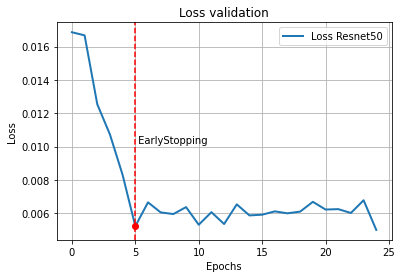

In [ ]:
## Crear Curve de perdida en entrenamiento y validación

import numpy as np
import matplotlib.pyplot as plt

#VGG16
plt.plot(xx_val3_2,yy_val3_2,linewidth=2.0, label = "Loss Resnet50")
#plt.plot(xx_val4_10,yy_val4_10,linewidth=3.0 ,color="CadetBlue", label = "Loss Vgg16 k=4")
plt.axvline(epoch_min3_2, ymin=0, ymax=1, linestyle="--",color="red")
#plt.axvline(epoch_min4_10, ymin=0, ymax=1, linestyle="--",color="red")
plt.plot(epoch_min3_2,stop_val3_2,marker="o",color="red")
#plt.plot(epoch_min4_10,stop_val4_10,marker="o",color="red")
plt.annotate(" EarlyStopping ",(epoch_min3_2,stop_val3_2),(epoch_min3_2,stop_val3_2+0.005))

plt.legend(loc="upper right")
#plt.plot(xx1,yy1,marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss validation")
#plt.axis([0,25,0,0.5])
plt.grid()
plt.savefig('loss.png',bbox_inches='tight')
plt.show()

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = torch.load('/content/modelo_torch_full.pth')
    num_ftrs = model.fc.in_features  #numero de neuronas en la capa de entrada 
    model.fc = nn.Linear(num_ftrs, 2) 
    model.load_state_dict(checkpoint['state_dict'])
    return model, checkpoint['class_to_idx']
  
# get index to class mapping
loaded_model, class_to_idx = load_checkpoint('/content/modelo_torch_1_3.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

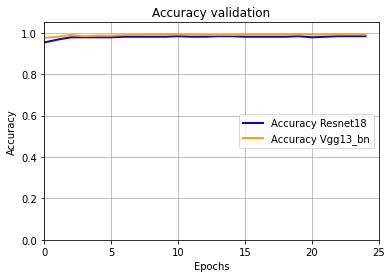

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(xx_val1_1,acc_val1_1,linewidth=2.0, color='blue', label = "Accuracy Resnet18")
plt.plot(xx_val1_4,acc_val1_4,linewidth=2.0, color='orange', label = "Accuracy Vgg13_bn")
#plt.plot(xx_val1_13,acc_val1_13,linewidth=3.0, color='yellow', label = "Accuracy Vgg19_bn k=1")
#plt.plot(xx_val4_13,acc_val4_13,linewidth=3.0, color='orange', label = "Accuracy Vgg19_bn k=4")
#plt.axvline(epoch_min, ymin=0, ymax=1, linestyle="--",color="red")
#plt.plot(epoch_min,stop_val,marker="o",color="red")
plt.legend(loc="right")
#plt.plot(xx1,yy1,marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy validation")
plt.axis([0,25,0,1.05])
plt.grid()
plt.savefig('Accuracy.png',bbox_inches='tight')
plt.show()

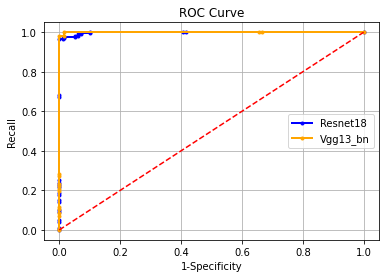

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
import numpy as np


#best_labels=best_labels.cpu()
#best_predict=best_predict.cpu()
#best_prob=best_prob.cpu()
xx=np.linspace(0,1,100)
yy=xx


lr_fpr1_1, lr_tpr1_1, _ = roc_curve(best_labels1_1, best_prob1_1)
#lr_fpr1_2, lr_tpr1_2, _ = roc_curve(best_labels1_2, best_prob1_2)
#lr_fpr1_3, lr_tpr1_3, _ = roc_curve(best_labels1_3, best_prob1_3)
lr_fpr1_4, lr_tpr1_4, _ = roc_curve(best_labels1_4, best_prob1_4)
plt.plot(lr_fpr1_1, lr_tpr1_1, marker='.', linewidth=2.0, color='blue', label='Resnet18')
#plt.plot(lr_fpr1_2, lr_tpr1_2, marker='.',  color='blue', label='Resnet101 k=4')
#plt.plot(lr_fpr1_3, lr_tpr1_3, marker='.', color='yellow', label='Vgg19_bn k=1')
plt.plot(lr_fpr1_4, lr_tpr1_4, marker='.', linewidth=2.0, color='orange', label='Vgg13_bn')
plt.plot(xx,yy, color="red",linestyle="--")
plt.xlabel("1-Specificity")
plt.ylabel("Recall")
plt.title("ROC Curve")
plt.axis([-0.05,1.05,-0.05,1.05])
plt.grid()
plt.legend(loc="right")
VP=0
FP=0
VN=0
FN=0

plt.savefig('ROC Curve.png',bbox_inches='tight')